<a href="https://colab.research.google.com/github/abhikmr778/RFH/blob/main/March18Gamma1_10e_10_30dbmAP32_train_DDPG_parameterNoise_Uplink_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
"""cell_free_ul_reward_state_update_30dBm.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1589qShRSOT9j6evPI_C-XxGqxPkwZL2P
"""



# Commented out IPython magic to ensure Python compatibility.
%tensorflow_version 2.x
%load_ext tensorboard
import numpy as np
import pandas as pd
# import keras.backend.tensorflow_backend as backend
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Dense, Activation, Dropout, Conv2D, LayerNormalization, MaxPooling2D, Activation, Flatten
from tensorflow.keras.layers import Input,Add, Lambda
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard
#from object_detection.utils.networks import tfSummary, OrnsteinUhlenbeckProcess
!rm -rf ./logs/ 
from collections import deque
import time
import random
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from pathlib import Path
from keras import losses
import h5py
from datetime import datetime  
import argparse
import pprint as pp

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Abhinav-cell-free/'
path = Path(base_dir+str(datetime.now().strftime("%c"))+'/testlogs')
dest = path
dest.mkdir(parents=True, exist_ok=True)
path2 = Path(base_dir+str(datetime.now().strftime("%c"))+'/models')
dest2 = path2
model_path = Path(base_dir + 'test30th')
dest2.mkdir(parents=True, exist_ok=True)
path3 = Path(base_dir+'2020-01-30 19:42:04.279775'+'/models')
dest3 = path3
restore_path = base_dir+'Thu Jul 23 01:53:05 2020/models'

Mounted at /content/gdrive


In [3]:
# DISCOUNT = 0.7
REPLAY_MEMORY_SIZE = 20000
# MIN_REPLAY_MEMORY_SIZE = 512
MINIBATCH_SIZE = 32
#UPDATE_TARGET_EVERY = 100
MIN_REWARD = 30

EPISODES = 1000
UPDATES = 50
# EPOCH = 10
# START = 0
EPSILON = 0.6
MIN_EPSILON = 0.01
EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
# var = 10
# min_var = 1e-5
# var_decay = np.power(min_var,(1/(EPISODES)))
# MIN_EPSILON = 0

AGGREGATE_STATS_EVERY = 1
np.random.seed(2)
tf.compat.v1.set_random_seed(2)

In [4]:
# channelGains['channelGain'][0].shape
np.random.rand(10, 32).shape

(10, 32)

In [5]:
class wirelessEnv:
    def __init__(self, pu, nrx, gainspath, random_seed):
        print(pu)
        random.seed(random_seed)
        self.filename = base_dir+str(gainspath)
        self.channelGains = h5py.File(self.filename, 'r')
        self.B = 20000000
        self.N0 = 1

        self.T_c = 0.001
        
        self.Ptcm = 0.2
        self.Ptcl = 0.2
        self.Pom = 0.825
        self.pp = 0.2
        
        self.K = 10
        self.tauc = 200
        self.eff = 0.4 #amplifier efficiency
        self.M = 32
        self.pu = pu
        #self.ui = 4 # for all i
        #self.F = 3
        #self.Pfix =  # for all i
        self.Pft = 10
        self.C_fh = 100000000
        self.nu = 2
        self.a = 0.88115
        self.b = 0.88115
        self.taup = self.K
        self.tauf = 1 - (self.taup/self.tauc)
        #print(self.tauf)
        self.Nrx = nrx
        
        self.R_fh = 2*self.K*self.nu*self.tauf*self.tauc/self.T_c
        #print(self.R_fh)
        self.Pfix   = self.M*((self.Nrx*self.Ptcm)+self.Pom + self.Pft*self.R_fh/self.C_fh)/self.K
        #print(self.Pfix)
        self.theta_max = 1
        #self.sigma2 = self.F*self.N0*self.B
        self.alpha = deque(maxlen=2)
        self.beta = deque(maxlen=2)
        self.ch_gain = deque(maxlen=2)
        self.wi = [1/self.K for i in range(self.K)] # define equal weights which sum to 1
        self.pi = deque(maxlen=2)
        self.initialize_p()
        self.a_dim = 1 # we decide the cardinality as per the required resolution
        self.action_bound = np.asarray([0, 1])
        # initialize actions
        #self.actions = [0.00001]  
        #for x in range(self.action_space-1):
            #self.actions.append((x+1)*self.theta_max/(self.action_space-1))    
        # input/output for the neural net
        #self.s_dim = 8*self.K + 4*self.M + 2
        self.s_dim = self.K*self.M
        # self.s_dim = 4*self.M + 3*self.K - 1
        self.input = 100
        self.output = self.a_dim
        
    def initialize_matrix(self, episode):
        for t in range(2):
          # BETA = np.random.rand(self.M, self.K)
          BETA = self.channelGains['channelGain'][episode].transpose()
          gamma_num = np.zeros((self.M,self.K))
          gamma_den = np.zeros((self.M,self.K))

          Gamma = np.zeros((self.M,self.K))
          for m in range(self.M):
              for k in range(self.K):
                  gamma_num[m][k] = self.taup*self.pp*np.power(BETA[m][k],2)                                  
                  gamma_den[m][k] = self.taup*self.pp*BETA[m][k]+1                    
                  Gamma[m][k] = gamma_num[m][k]/gamma_den[m][k]
          self.ch_gain.append(Gamma)
          alpha1 = np.zeros((self.K,))
          for k in range(self.K):
              #alpha1[k] = self.Nrx*self.pu*np.sum(Gamma[:][k])*self.pi[t][k]
              alpha1[k] = self.pu*np.power(self.a*self.Nrx*np.sum(Gamma[:,k]),2)
          self.alpha.append(alpha1)
          beta1 = np.zeros((self.K,self.K))
          for k in range(self.K):
              for q in range(self.K):
                  beta1 [k][q] = self.a*self.a*self.pu*self.Nrx*(BETA[:,q].T@Gamma[:,k])         
          self.beta.append(beta1)
          # if episode >= 1999:
          #   print(f'Gamma:{Gamma}')
          #self.alpha_beta.append(np.array([[np.random.uniform(0,1) for e in range(K)] for e in range(K)]))        
        return

    def initialize_p(self):
        for t in range(2):
          self.pi.append(np.random.uniform(low=0, high=self.theta_max, size=(self.K,)))
        return
    
    def cal_alpha_p(self, i, t):
        val = self.alpha[t][i]*self.pi[t][i]
        # print(f'cal_alpha_p: {val}')
        return val
    
    def cal_beta_p(self, i, j, t):
        val = self.beta[t][i][j]*self.pi[t][j] # channel from UE j to BS i
        # print(f'cal_beta_p: {val}')
        return val
    
    def sum_beta_p(self, i, t):
        val = 0
        for j in range(self.K):
            val += self.cal_beta_p(i,j,t)  
        #val = val + (self.b-self.a*self.a)*self.Nrx*self.pu*np.sum(np.square(np.asarray(self.ch_gain)[t,:,i]))/(np.asarray(self.ch_gain)[t,:,i]))
        # print(f'sum_beta_p: {val}')
        return val 

    def cal_Ri(self,i, t):
        val = np.log2(1+(self.cal_alpha_p(i,t)/(self.b*self.Nrx*np.sum(np.asarray(self.ch_gain)[t,:,i]) + (self.b-self.a*self.a)*self.Nrx*self.Nrx*self.pu*self.pi[t][i]*np.linalg.norm(np.asarray(self.ch_gain)[t,:,i])**2 + self.b/(self.a*self.a)*self.sum_beta_p(i, t))))
        return val
        
    def cal_EEi(self,i,t):
        val = self.tauf*self.cal_Ri(i,t)/(self.pu*self.N0*self.pi[t][i]/self.eff + self.Pfix + self.Ptcl)
        return val

    def cal_total_WSEE(self,t):
        val = 0
        for x in range(self.K):
            val += self.wi[x]*self.cal_EEi(x,t)
        return val
    
    def cal_equal_p_WSEE(self, t):
        p = [self.theta_max for x in range(self.K)]
        temp = self.pi.copy()
        self.pi[t] = p
        val = self.cal_total_WSEE(t)
        self.pi = temp
        return val
  

    def cal_reward(self,i,t):
        #ri = self.wi[i]*self.cal_EEi(i,t) - self.sum_price(i,t)
        # ri = self.cal_total_WSEE(t)
        # ri = (np.log(self.cal_total_WSEE(t)) - np.log(self.cal_equal_p_WSEE(t)))
        ri = self.cal_total_WSEE(t) - self.cal_equal_p_WSEE(t) 
        return ri

  
    def cal_state(self,i):
        state = []
        indx = 0
        for t in reversed(range(1)): #for current timestep only
            # next two elements in states are alpha(t)*pi(t-1) and Σbeta(t)pi(t-1)
            #state.append(self.cal_alpha_p(i,t)) # 2
            #state.append(self.sum_beta_p(i,t)) # 2
          for m in range(self.M):
            for k in range(self.K):
              state.append(self.ch_gain[t][m][k]) #M
            # state.append(self.ch_gain[t][m][i]*self.pi[t][i]) #M
            # print(f'ch_gain: {self.ch_gain[t][m][i]}')
            # print(f'pi: {self.pi[t][i]}')
          #2*2*M

          # next elements in states are the interferences from other users to ith user at time step t
          #for x in range(self.K):                               
              #state.append(self.cal_interfering(i,x,t)) # K
              #state.append(self.cal_EEi(x,t)) # K
          # 2xK
          
          # next elements in states are the interfered users by the ith user at time step t
          # for x in range(self.K):
          #     if x!= i:                    
          #         if t==1:
          #           # print(f'cal_alpha_p: {self.cal_alpha_p(x,1)}')
          #           # print(f'cal_beta_p: {self.cal_beta_p(i,x,1)}')
          #           # print(f'sum_beta_p: {self.sum_beta_p(x,1)}')
          #           state.append(self.cal_alpha_p(x,1)) # K-1
          #           # state.append(self.cal_total_WSEE(t)) # K-1
          #           state.append(self.cal_beta_p(i,x,1)) # K-1
          #           state.append(self.sum_beta_p(x,1)) # K-1
                      
                  #state.append(self.cal_interfered(i,x,t)) # K-1
          # 4x(K-1)
        
        # pi(t-1) and WSEEi(t-1)
        # print(f'cal_total_WSEE: {self.cal_total_WSEE(1)}')
        # state.append(self.pi[1][i])
        # state.append(self.cal_total_WSEE(1))        # 1
        #return np.asarray(state)
        state = np.reshape(state, [1, self.s_dim])
        return np.asarray(-np.log10(state))

    def initialize_state(self):
        UE = random.randint(0,self.K-1)
        state = self.cal_state(UE)
        return state, UE

    def reset(self, episode):
        self.initialize_matrix(episode)
#         self.initialize_p()
        self.episode_step = 0
        state, agent_no = self.initialize_state()
        return state, agent_no

    def initialize_state_test(self, UE):
        state = self.cal_state(UE)
        return state

    def reset_test(self, episode):
        self.initialize_matrix(episode)
        self.episode_step = 0

    def agent_reset(self):
        state, agent_no = self.initialize_state()
        state = np.reshape(state, [1, self.s_dim])
        return state, agent_no

            
    def step(self, action, agent):
        self.episode_step += 1
        temp = self.pi[1].copy()
        temp[agent] = action #action generated from action network (+noise+bounding)
        self.pi.append(temp)
        next_state = self.cal_state(agent)
        reward = self.cal_reward(agent,1)
        next_state = np.reshape(next_state, [1, self.s_dim])
        done = False
        if self.episode_step >= UPDATES:
            done = True
        return next_state, reward, done


In [6]:
class ReplayBuffer():
    def __init__(self, random_seed=1337):
        self.buffer = deque(maxlen = REPLAY_MEMORY_SIZE)
        self.priorities = deque(maxlen = REPLAY_MEMORY_SIZE)
        random.seed(random_seed)

    def add(self, experience):
        self.buffer.append(experience)
        self.priorities.append(max(self.priorities, default=1))

    def get_probabilities(self, priority_scale):
        scaled_priorities = np.array(self.priorities)**priority_scale
        # print(f'shape {scaled_priorities}, sum {np.sum(scaled_priorities)}')
        sampled_probabilities = scaled_priorities/sum(scaled_priorities)
        return sampled_probabilities

    def get_importance(self, probabilities):
        importance = 1/len(self.buffer) * 1/probabilities
        importance_normalized = importance/max(importance)
        return importance_normalized

    def sample(self, priority_scale = 0.7):
        samples = random.sample(self.buffer, MINIBATCH_SIZE)
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = random.choices(range(len(self.buffer)), k = MINIBATCH_SIZE, weights= sample_probs)
        samples = np.array(self.buffer)[sample_indices]
        importance = self.get_importance(sample_probs[sample_indices])
        return samples, importance, sample_indices

    def set_priorities(self, indices, errors, offset=0.1):
        for i,e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset


In [7]:
class AdaptiveParamNoise:
  def __init__(self, initial_stddev=0.15, desired_action_stddev=0.15, adoption_coefficient=1.01):
    self.initial_stddev = tf.Variable(initial_stddev)
    self.desired_action_stddev = tf.Variable(desired_action_stddev)
    self.adoption_coefficient = tf.Variable(adoption_coefficient)
    self.current_stddev = tf.Variable(initial_stddev)

  def adapt_stddev(self, distance):
    return tf.cond(distance > self.desired_action_stddev,
                    lambda: self.current_stddev.assign(tf.compat.v1.div(self.current_stddev, self.adoption_coefficient)),
                    lambda: self.current_stddev.assign(tf.compat.v1.multiply(self.current_stddev, self.adoption_coefficient)))
    
  def __repr__(self):
    _repr = 'AdaptiveParamNoise(initial_stddev={}, desired_action_stddev={}, adoption_coefficient={})'
    return _repr.format(self.initial_stddev, self.desired_action_stddev, self.adoption_coefficient)

In [8]:
class Stats:
  def __init__(self, sess, shape=()):
    self.sess = sess
    self.sum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(0.0),
        name='runningsum', trainable=False)
    self.sqsum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(1e-2),
        name='runningsqsum', trainable=False)
    self.count = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=(),
        initializer=tf.constant_initializer(1e-2),
        name='count', trainable=False)
    
    self.mean = tf.compat.v1.div(self.sum, self.count)
    self.std = tf.clip_by_value(
        tf.sqrt(tf.compat.v1.squared_difference(tf.sqrt(tf.compat.v1.div(self.sqsum, self.count)),self.mean)),1e-2, 10)
    
    self.sum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.sqsum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.count_next = tf.compat.v1.placeholder(tf.float32, shape=())
    self.update_op = [self.sum.assign_add(self.sum_next), self.sqsum.assign_add(self.sqsum_next),
                      self.count.assign_add(self.count_next)]

  def update(self, state):
    self.sess.run(self.update_op, feed_dict={self.sum_next: state.sum(axis=0),
                                             self.sqsum_next: np.square(state).sum(axis=0),
                                             self.count_next: np.array(len(state), dtype='float32')})

In [9]:
def normalize(x, stats):
    if stats is None:
        return x
    return (x - stats.mean) / stats.std


In [10]:
class Actor:
    def __init__(self, sess, s_dim, a_dim, normalize_observations=True,
                 use_param_noise=False, tau=0.01, gamma=.99, delta=0.2, learning_rate=0.0001,
                 observation_range=(-5., 5.)):
        #main model #gets trained every step
        
        self.save_path = path2
        self.sess = sess
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.delta = delta
        self.lr = learning_rate
        self.observation_range = observation_range
        self.normalize_observations = normalize_observations

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim], name='states_a')
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32, name='drop_prob_a')
        self.critic_gradients = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim], 'critic_grad_a')
        self.obs_rms = None


        #Observation normalization
        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, self.s_dim)

        with tf.compat.v1.variable_scope('actor'):
          self.actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.policy_params = tf.compat.v1.trainable_variables(scope='actor')


        if use_param_noise: 
          with tf.compat.v1.variable_scope('perturbed_actor'):
            self.perturbed_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
          self.perturbed_policy_params = tf.compat.v1.trainable_variables(scope='perturbed_actor')
        
          self.adapt_noise = AdaptiveParamNoise()
          self.stddev_ph = tf.compat.v1.placeholder(tf.float32)

          self.action_distance, self.stddev = self.adaptive_param_noise()

          self.updated_perturbed_policy_params = [self.perturbed_policy_params[i].assign(self.policy_params[i] + tf.random.normal(tf.shape(self.perturbed_policy_params[i]), 0.,self.stddev_ph, seed=1337)) for i in range(len(self.perturbed_policy_params)) if 'LayerNorm' not in self.perturbed_policy_params[i].name]


        with tf.compat.v1.variable_scope('target_actor'):
          self.target_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.target_policy_params = tf.compat.v1.trainable_variables(scope='target_actor')

        self.objective_gradient = \
            tf.gradients(self.actions, self.policy_params, -self.critic_gradients)

        self.update_policy_params = tf.compat.v1.train.AdamOptimizer(self.lr).apply_gradients(
            zip(self.objective_gradient, self.policy_params))

        # print(f'policy_params{np.array(self.policy_params).shape}, target_policy_params{np.array(self.target_policy_params).shape}')
        # print(f'policy_params{self.policy_params}')
        # print(f'target_policy_params{self.target_policy_params}')
        
        self.update_target_policy_params = [self.target_policy_params[i].assign(
                                                                  self.tau * self.policy_params[i]
                                                                  + (1 - self.tau) *
                                                                  self.target_policy_params[i]
                                                                  )
                                                        for i in range(len(self.target_policy_params))]

        # self.merge_op = tf.summary.merge_all(scope='Actor')
        self.saver = tf.compat.v1.train.Saver()




    def policy_network(self, state, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])

        # input = Input(shape = (self.s_dim,))
        h1 = Dense(128)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('relu')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)

        # h1 = tf.layers.dense(state, 128)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)

        h2 = Dense(64)(h1)
        h2 = LayerNormalization(center=True , scale=True)(h2)
        h2 = Activation('tanh')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.layers.dense(h1, 128)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        h3 = Dense(32)(h2)
        h3 = LayerNormalization(center=True , scale=True)(h3)
        h3 = Activation('relu')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        h4 = Dense(16)(h3)
        h4 = LayerNormalization(center=True , scale=True)(h4)
        h4 = Activation('tanh')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        h5 = Dense(8)(h4)
        h5 = LayerNormalization(center=True , scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h4 = tf.layers.dense(h3, 64)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        actions = Dense(self.a_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))(h5)
        actions = Activation('relu')(actions)

        # actions = tf.layers.dense(h4, self.action_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))
        # actions = tf.nn.tanh(actions)

        return actions

    def add_param_noise(self, state):
        adaptive_policy_distance, stddev = self.sess.run([self.action_distance, self.stddev],
                                                         feed_dict={self.state_ph: state, self.drop_prob_ph: 0.0})
        self.sess.run(self.updated_perturbed_policy_params, feed_dict={self.stddev_ph: stddev})

        return adaptive_policy_distance, stddev

    def adaptive_param_noise(self):
        adaptive_policy_distance = tf.sqrt(tf.reduce_mean(
            tf.compat.v1.squared_difference(self.actions, self.perturbed_actions)))
        
        std_dev = self.adapt_noise.adapt_stddev(adaptive_policy_distance)

        return adaptive_policy_distance, std_dev

    def train(self, state, drop_prob, critic_grads):
        self.sess.run(self.update_policy_params, feed_dict={self.state_ph: state,
                                                            self.drop_prob_ph: drop_prob,
                                                            self.critic_gradients: critic_grads})
        
    def predict(self, state, drop_prob):
        return self.sess.run(self.actions, feed_dict={self.state_ph: state,
                                                      self.drop_prob_ph: drop_prob})

    def perturbed_predict(self, state, drop_prob):
        return self.sess.run(self.perturbed_actions, feed_dict={self.state_ph: state,
                                                                self.drop_prob_ph: drop_prob})
        
    def target_predict(self, state, drop_prob):
        return self.sess.run(self.target_actions, feed_dict={self.state_ph: state,
                                                             self.drop_prob_ph: drop_prob})
        
    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')   

        

In [11]:
class Critic:
    def __init__(self, sess, s_dim ,a_dim, normalize_observations=True,
                 tau=0.01, gamma=.99, learning_rate=0.001, l2_reg=0.01, observation_range=(-5., 5.)):
        
        self.sess = sess
        self.save_path = path2
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.lr = learning_rate
        self.l2_reg = l2_reg
        self.gamma = gamma
        self.normalize_observations = normalize_observations
        self.observation_range = observation_range
        self.obs_rms = None

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim])
        self.action_ph = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim])
        self.future_reward_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.importance_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32)

        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, shape=self.s_dim)

        with tf.compat.v1.variable_scope('critic'):
          self.q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.q_params = tf.compat.v1.trainable_variables(scope='critic')

        with tf.compat.v1.variable_scope('target_critic'):
          self.target_q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.target_q_params = tf.compat.v1.trainable_variables(scope='target_critic')

        self.critic_gradients = tf.gradients(self.q_value, self.action_ph)

        self.loss = tf.reduce_mean((self.importance_ph**(1-EPSILON))*tf.compat.v1.squared_difference(self.q_value, self.future_reward_ph)) + \
                    self.l2_reg*tf.compat.v1.losses.get_regularization_loss(scope='critic')

        # self.loss = tf.compat.v1.losses.mean_squared_error(self.predict(self.state_ph, self.action_ph, self.drop_prob_ph), self.future_reward_ph, weights = self.importance_ph**(1-EPSILON), scope='critic')

        # mse = tf.keras.losses.MeanSquaredError()
        # self.loss = mse(self.future_reward_ph, self.q_value, sample_weight = self.importance_ph**(1-EPSILON))

        self.update_q_params = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(self.loss)

        self.update_target_q_params = [self.target_q_params[i].assign(self.tau*self.q_params[i]+(1-self.tau)*self.target_q_params[i]) for i in range(len(self.target_q_params))]

        self.saver = tf.compat.v1.train.Saver()

        # self.merge_op = tf.summary.merge_all(scope='critic')

    def q_value_network(self, state, action, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])



        # Layer 1
        h1 = Dense(128, kernel_regularizer=tf.nn.l2_loss)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('tanh')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)
        # h1 = tf.layers.dense(state, 128, kernel_regularizer=tf.nn.l2_loss)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)
        

        # Layer 2 + add actions
        h2 = tf.keras.layers.concatenate([h1, action], axis=-1)

        h2 = Dense(64, kernel_regularizer=tf.nn.l2_loss)(h2)
        h2 = LayerNormalization(center=True, scale=True)(h2)
        h2 = Activation('relu')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.concat([h1, action], axis=-1)

        # h2 = tf.layers.dense(h2, 128, kernel_regularizer=tf.nn.l2_loss)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        # Layer 3
        h3 = Dense(32, kernel_regularizer=tf.nn.l2_loss)(h2)
        h3 = LayerNormalization(center=True, scale=True)(h3)
        h3 = Activation('tanh')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64, kernel_regularizer=tf.nn.l2_loss)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        # Layer 4
        h4 = Dense(16, kernel_regularizer=tf.nn.l2_loss)(h3)
        h4 = LayerNormalization(center=True, scale=True)(h4)
        h4 = Activation('relu')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        # h4 = tf.layers.dense(h3, 64, kernel_regularizer=tf.nn.l2_loss)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        # Layer 5
        h5 = Dense(8, kernel_regularizer=tf.nn.l2_loss)(h4)
        h5 = LayerNormalization(center=True, scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h5 = tf.layers.dense(h4, 64, kernel_regularizer=tf.nn.l2_loss)
        # h5 = tc.layers.layer_norm(h5, center=True, scale=True)
        # h5 = tf.nn.elu(h5)
        # h5 = tf.layers.dropout(h5, drop_prob, seed=seed)

        # Output q_value
        q_value = Dense(1, kernel_regularizer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))(h5)
        # q_value = tf.layers.dense(h4, 1, kernel_initializer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))

        return q_value

    def compute_grads(self, state, action, drop_prob):
        return self.sess.run(self.critic_gradients, feed_dict={self.state_ph: state,
                                                               self.action_ph: action,
                                                               self.drop_prob_ph: drop_prob})

    def train(self, state, action, drop_prob, future_reward, importance):
        return self.sess.run([self.loss, self.update_q_params], feed_dict={self.state_ph: state,
                                                         self.action_ph: action,
                                                         self.drop_prob_ph: drop_prob,
                                                         self.future_reward_ph: future_reward,
                                                         self.importance_ph: importance})

    def predict(self, state, action, drop_prob):
        return self.sess.run(self.q_value, feed_dict={self.state_ph: state,
                                                      self.action_ph: action,
                                                      self.drop_prob_ph: drop_prob})

    def target_predict(self, state, action, drop_prob):
        return self.sess.run(self.target_q_value, feed_dict={self.state_ph: state,
                                                             self.action_ph: action,
                                                             self.drop_prob_ph: drop_prob})

    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')




In [12]:
def variable_summaries(var, name):
  with tf.name_scope(name):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

Namespace(actor_lr=0.005, buffer_size=10000, critic_lr=0.05, delta=0.2, drop_prob=0.4, gamma=0.999999999, l2_reg=0.0, max_episode_len=20000, max_episodes=1000, max_exploration_steps=1000000.0, minibatch_size=512, normalize_obs=True, random_seed=1337, restore=False, save=True, summary_dir='./results/tf_ddpg', tau=0.01, train=True, train_step=50, use_adaptive_parameter_noise=True)
1.0
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


  0%|          | 0/1000 [00:00<?, ?episode/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:203: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 1/1000 [00:00<08:40,  1.92episode/s]

Loss: None|| Global step: 50 || Episode: 1 || Reward: -0.92 || Distance: nan ||
wsee: 0.11052579306041635, eqwsee: 0.12405338095790251, reward: -0.9236488407708251
|| Test Run No: 1100 || WSEE: 0.019337751304110237 || eq_WSEE: 0.10417327110291066 || Reward: -0.49 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07761965002382906, fpa_wsee: 0.12424997011815597


  0%|          | 2/1000 [00:04<26:28,  1.59s/episode]

Loss: None|| Global step: 100 || Episode: 2 || Reward: -3.93 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -3.930645413635999


  0%|          | 3/1000 [00:05<20:39,  1.24s/episode]

Loss: None|| Global step: 150 || Episode: 3 || Reward: -3.19 || Distance: nan ||
wsee: 0.06052864185486667, eqwsee: 0.12667374975229123, reward: -3.1897221972016823
|| Test Run No: 1100 || WSEE: 0.01930711683246188 || eq_WSEE: 0.10417327110291066 || Reward: -0.51 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07761934367911257, fpa_wsee: 0.12424997011815597


  0%|          | 4/1000 [00:09<34:41,  2.09s/episode]

Loss: None|| Global step: 200 || Episode: 4 || Reward: -1.66 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -1.6625270630342754


  0%|          | 5/1000 [00:09<26:25,  1.59s/episode]

Loss: None|| Global step: 250 || Episode: 5 || Reward: -2.87 || Distance: nan ||
wsee: 0.07476066397188637, eqwsee: 0.13794311653266034, reward: -2.872596748329633
|| Test Run No: 1100 || WSEE: 0.019341942753895492 || eq_WSEE: 0.10417327110291066 || Reward: -0.49 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.0776196919383269, fpa_wsee: 0.12424997011815597


  1%|          | 6/1000 [00:13<38:53,  2.35s/episode]

Loss: None|| Global step: 300 || Episode: 6 || Reward: -1.01 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -1.013255850605532


  1%|          | 7/1000 [00:14<29:39,  1.79s/episode]

Loss: None|| Global step: 350 || Episode: 7 || Reward: -1.16 || Distance: nan ||
wsee: 0.12553785136715712, eqwsee: 0.1493886152409169, reward: -1.1600672371915126
|| Test Run No: 1100 || WSEE: 0.018652430049464184 || eq_WSEE: 0.10417327110291066 || Reward: -0.63 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.0776127968112826, fpa_wsee: 0.12424997011815597


  1%|          | 8/1000 [00:18<40:59,  2.48s/episode]

Loss: None|| Global step: 400 || Episode: 8 || Reward: -0.80 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -0.7964237637867293


  1%|          | 9/1000 [00:18<31:05,  1.88s/episode]

Loss: None|| Global step: 450 || Episode: 9 || Reward: -1.98 || Distance: nan ||
wsee: 0.031769090114377826, eqwsee: 0.08196776106857911, reward: -1.9826988785730615
|| Test Run No: 1100 || WSEE: 0.01941561463766322 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07762042865716459, fpa_wsee: 0.12424997011815597


  1%|1         | 10/1000 [00:22<42:06,  2.55s/episode]

Loss: None|| Global step: 500 || Episode: 10 || Reward: -2.30 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -2.2968688809802167


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creati

Loss: 0.05201112478971481|| Global step: 550 || Episode: 11 || Reward: 0.89 || Distance: 0.3118 ||
wsee: 0.1494716303445404, eqwsee: 0.1329870525598128, reward: 0.8887567886212321
|| Test Run No: 1100 || WSEE: 0.018520308350091115 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.02132754993745707 || eq_WSEE: 0.15875344714719553 || Reward: -1.21 ||
|| Test Run No: 1140 || WSEE: 0.07169964237771283 || eq_WSEE: 0.10557475616596732 || Reward: -0.31 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0892175551380306 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.053793694191610585, fpa_wsee: 0.12424997011815597


  1%|1         | 12/1000 [00:31<57:27,  3.49s/episode]

Loss: 0.030218064785003662|| Global step: 600 || Episode: 12 || Reward: 0.80 || Distance: 0.1983 ||
wsee: 0.106922787996486, eqwsee: 0.13152993615391398, reward: 0.8037739162981687


  1%|1         | 13/1000 [00:32<47:38,  2.90s/episode]

Loss: 0.05479099228978157|| Global step: 650 || Episode: 13 || Reward: 0.60 || Distance: 0.1428 ||
wsee: 0.16021373300042033, eqwsee: 0.13109976637185683, reward: 0.6013312173650563
|| Test Run No: 1100 || WSEE: 0.017277907535562586 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.01270114058438766 || eq_WSEE: 0.15875344714719553 || Reward: -1.28 ||
|| Test Run No: 1140 || WSEE: 0.06670522480920033 || eq_WSEE: 0.10557475616596732 || Reward: -0.36 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0859748325257914 || eq_WSEE: 0.13084527637398705 || Reward: -0.57 ||
wsee:0.04840951991773191, fpa_wsee: 0.12424997011815597


  1%|1         | 14/1000 [00:37<57:54,  3.52s/episode]

Loss: 0.05804739147424698|| Global step: 700 || Episode: 14 || Reward: 1.22 || Distance: 0.5586 ||
wsee: 0.10402663550783749, eqwsee: 0.13152993615391398, reward: 1.224529628702207


  2%|1         | 15/1000 [00:39<47:58,  2.92s/episode]

Loss: 0.026681743562221527|| Global step: 750 || Episode: 15 || Reward: 0.21 || Distance: 0.2414 ||
wsee: 0.11220720604419987, eqwsee: 0.08896563362710563, reward: 0.21224158092488055
|| Test Run No: 1100 || WSEE: 0.017527885649477586 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.0051765004606938465 || eq_WSEE: 0.15875344714719553 || Reward: -1.35 ||
|| Test Run No: 1140 || WSEE: 0.05570039965585735 || eq_WSEE: 0.10557475616596732 || Reward: -0.46 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08192175737950193 || eq_WSEE: 0.13084527637398705 || Reward: -0.59 ||
wsee:0.0419634337033972, fpa_wsee: 0.12424997011815597


  2%|1         | 16/1000 [00:44<58:37,  3.57s/episode]

Loss: 0.10320784896612167|| Global step: 800 || Episode: 16 || Reward: 1.43 || Distance: 0.2845 ||
wsee: 0.10158632784824373, eqwsee: 0.13152993615391398, reward: 1.4285598402548787


  2%|1         | 17/1000 [00:46<49:02,  2.99s/episode]

Loss: 0.051382530480623245|| Global step: 850 || Episode: 17 || Reward: 0.67 || Distance: 0.3232 ||
wsee: 0.17304019692112, eqwsee: 0.1498842137957764, reward: 0.6673592556818767
|| Test Run No: 1100 || WSEE: 0.015509088028228306 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.004537188223686104 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.03894337490970026 || eq_WSEE: 0.10557475616596732 || Reward: -0.61 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07805881344864544 || eq_WSEE: 0.13084527637398705 || Reward: -0.61 ||
wsee:0.034669750096383394, fpa_wsee: 0.12424997011815597


  2%|1         | 18/1000 [00:51<59:55,  3.66s/episode]

Loss: 0.07354190945625305|| Global step: 900 || Episode: 18 || Reward: 0.90 || Distance: 0.2900 ||
wsee: 0.09997707999515038, eqwsee: 0.13152993615391398, reward: 0.8956651221305518


  2%|1         | 19/1000 [00:52<49:38,  3.04s/episode]

Loss: 0.04575681686401367|| Global step: 950 || Episode: 19 || Reward: -0.13 || Distance: 0.4250 ||
wsee: 0.11183468585723368, eqwsee: 0.10658873034354317, reward: -0.12733070943156005
|| Test Run No: 1100 || WSEE: 0.015069358884838345 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 0.0038467148108055423 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.032864612754552484 || eq_WSEE: 0.10557475616596732 || Reward: -0.68 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07219508474632559 || eq_WSEE: 0.13084527637398705 || Reward: -0.67 ||
wsee:0.030722522054698734, fpa_wsee: 0.12424997011815597


  2%|2         | 20/1000 [00:57<59:28,  3.64s/episode]

Loss: 0.0013818000443279743|| Global step: 1000 || Episode: 20 || Reward: 0.37 || Distance: 0.3519 ||
wsee: 0.09740528275391183, eqwsee: 0.13152993615391398, reward: 0.3699649098650503


  2%|2         | 21/1000 [00:59<49:51,  3.06s/episode]

Loss: 0.05968848243355751|| Global step: 1050 || Episode: 21 || Reward: 1.14 || Distance: 0.1614 ||
wsee: 0.13477392238990513, eqwsee: 0.10375368536381287, reward: 1.1434002680236686
|| Test Run No: 1100 || WSEE: 0.018575047415932664 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0029600927792307196 || eq_WSEE: 0.15875344714719553 || Reward: -1.45 ||
|| Test Run No: 1140 || WSEE: 0.029452242730027087 || eq_WSEE: 0.10557475616596732 || Reward: -0.75 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06126469033928463 || eq_WSEE: 0.13084527637398705 || Reward: -0.79 ||
wsee:0.02792303170928089, fpa_wsee: 0.12424997011815597


  2%|2         | 22/1000 [01:04<1:01:05,  3.75s/episode]

Loss: 0.04469594731926918|| Global step: 1100 || Episode: 22 || Reward: 2.37 || Distance: 0.4603 ||
wsee: 0.09192921913073149, eqwsee: 0.13152993615391398, reward: 2.3678078951680166


  2%|2         | 23/1000 [01:06<51:16,  3.15s/episode]  

Loss: 0.11427181214094162|| Global step: 1150 || Episode: 23 || Reward: 1.02 || Distance: 0.3330 ||
wsee: 0.1438391956029705, eqwsee: 0.12460080593306919, reward: 1.023296576629442
|| Test Run No: 1100 || WSEE: 0.017064777815030414 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.008368866093846796 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.029523432938608686 || eq_WSEE: 0.10557475616596732 || Reward: -0.78 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.055152410099228805 || eq_WSEE: 0.13084527637398705 || Reward: -0.87 ||
wsee:0.026367111251137314, fpa_wsee: 0.12424997011815597


  2%|2         | 24/1000 [01:12<1:02:10,  3.82s/episode]

Loss: 0.07752218097448349|| Global step: 1200 || Episode: 24 || Reward: 0.90 || Distance: 0.2484 ||
wsee: 0.08785133724743721, eqwsee: 0.13152993615391398, reward: 0.8987167793857613


  2%|2         | 25/1000 [01:13<52:17,  3.22s/episode]  

Loss: 0.05781141668558121|| Global step: 1250 || Episode: 25 || Reward: 0.82 || Distance: 0.4362 ||
wsee: 0.12165821560761543, eqwsee: 0.09376202016680894, reward: 0.8153473456870667
|| Test Run No: 1100 || WSEE: 0.014565492751064479 || eq_WSEE: 0.10417327110291066 || Reward: -0.45 ||
|| Test Run No: 1120 || WSEE: 0.008372794630478173 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.029523793785632295 || eq_WSEE: 0.10557475616596732 || Reward: -0.78 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05515086103713151 || eq_WSEE: 0.13084527637398705 || Reward: -0.87 ||
wsee:0.02634183835683029, fpa_wsee: 0.12424997011815597


  3%|2         | 26/1000 [01:19<1:03:02,  3.88s/episode]

Loss: 0.036552030593156815|| Global step: 1300 || Episode: 26 || Reward: 0.21 || Distance: 0.5424 ||
wsee: 0.08785038316735669, eqwsee: 0.13152993615391398, reward: 0.21196624239107803


  3%|2         | 27/1000 [01:21<52:54,  3.26s/episode]  

Loss: 0.0328110046684742|| Global step: 1350 || Episode: 27 || Reward: -5.66 || Distance: 0.2049 ||
wsee: 0.00010754111152873204, eqwsee: 0.13133773297561768, reward: -5.662044892734271
|| Test Run No: 1100 || WSEE: 0.01739272200791165 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.011798639352211126 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.0317082614786971 || eq_WSEE: 0.10557475616596732 || Reward: -0.77 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05221574296380274 || eq_WSEE: 0.13084527637398705 || Reward: -0.90 ||
wsee:0.02544357064939386, fpa_wsee: 0.12424997011815597


  3%|2         | 28/1000 [01:26<1:03:32,  3.92s/episode]

Loss: 0.052236832678318024|| Global step: 1400 || Episode: 28 || Reward: 0.57 || Distance: 0.2625 ||
wsee: 0.0863406372434753, eqwsee: 0.13152993615391398, reward: 0.5748590192198924


  3%|2         | 29/1000 [01:28<53:09,  3.29s/episode]  

Loss: 0.07899796962738037|| Global step: 1450 || Episode: 29 || Reward: -4.59 || Distance: 0.3796 ||
wsee: 0.001208914333768393, eqwsee: 0.11307266508670075, reward: -4.594606569227279
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.02078379698330412 || eq_WSEE: 0.15875344714719553 || Reward: -1.35 ||
|| Test Run No: 1140 || WSEE: 0.031202946812908024 || eq_WSEE: 0.10557475616596732 || Reward: -0.85 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.049564106322485556 || eq_WSEE: 0.13084527637398705 || Reward: -0.94 ||
wsee:0.02379701125567865, fpa_wsee: 0.12424997011815597


  3%|3         | 30/1000 [01:34<1:04:07,  3.97s/episode]

Loss: 0.06206719949841499|| Global step: 1500 || Episode: 30 || Reward: -7.34 || Distance: 0.1266 ||
wsee: 0.08296034206512232, eqwsee: 0.13152993615391398, reward: -7.33900452895545


  3%|3         | 31/1000 [01:35<53:51,  3.33s/episode]  

Loss: 0.05067912116646767|| Global step: 1550 || Episode: 31 || Reward: 0.45 || Distance: 0.3727 ||
wsee: 0.12422858760017681, eqwsee: 0.11408816315779949, reward: 0.44974221813241483
|| Test Run No: 1100 || WSEE: 0.018958267706725686 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.025101968355435416 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.0314626681664666 || eq_WSEE: 0.10557475616596732 || Reward: -0.85 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04779141394269219 || eq_WSEE: 0.13084527637398705 || Reward: -0.96 ||
wsee:0.023299712478184863, fpa_wsee: 0.12424997011815597


  3%|3         | 32/1000 [01:41<1:04:52,  4.02s/episode]

Loss: 0.04381856322288513|| Global step: 1600 || Episode: 32 || Reward: 0.83 || Distance: 0.2950 ||
wsee: 0.08088927707066706, eqwsee: 0.13152993615391398, reward: 0.828419425052606


  3%|3         | 33/1000 [01:43<54:49,  3.40s/episode]  

Loss: 0.015541283413767815|| Global step: 1650 || Episode: 33 || Reward: 1.41 || Distance: 0.1770 ||
wsee: 0.14963175562464015, eqwsee: 0.12747766087200432, reward: 1.408488036140172
|| Test Run No: 1100 || WSEE: 0.019062675905003327 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.02942286127643462 || eq_WSEE: 0.15875344714719553 || Reward: -1.31 ||
|| Test Run No: 1140 || WSEE: 0.03172993191620787 || eq_WSEE: 0.10557475616596732 || Reward: -0.85 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.045119228942639984 || eq_WSEE: 0.13084527637398705 || Reward: -1.01 ||
wsee:0.021828269651133242, fpa_wsee: 0.12424997011815597


  3%|3         | 34/1000 [01:49<1:06:06,  4.11s/episode]

Loss: 0.03257281333208084|| Global step: 1700 || Episode: 34 || Reward: 1.30 || Distance: 0.3201 ||
wsee: 0.07574798915688152, eqwsee: 0.13152993615391398, reward: 1.303280820996145


  4%|3         | 35/1000 [01:51<55:39,  3.46s/episode]  

Loss: 0.026606766507029533|| Global step: 1750 || Episode: 35 || Reward: -1.68 || Distance: 0.1834 ||
wsee: 0.13669451541554062, eqwsee: 0.1546985766937026, reward: -1.6791748870002268
|| Test Run No: 1100 || WSEE: 0.019455871009247876 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.029360295005735546 || eq_WSEE: 0.15875344714719553 || Reward: -1.31 ||
|| Test Run No: 1140 || WSEE: 0.03161077952317792 || eq_WSEE: 0.10557475616596732 || Reward: -0.85 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.042004493284012095 || eq_WSEE: 0.13084527637398705 || Reward: -1.04 ||
wsee:0.020724790519017287, fpa_wsee: 0.12424997011815597


  4%|3         | 36/1000 [01:56<1:06:33,  4.14s/episode]

Loss: 0.04242745786905289|| Global step: 1800 || Episode: 36 || Reward: 1.72 || Distance: 0.3835 ||
wsee: 0.07477332228207274, eqwsee: 0.13152993615391398, reward: 1.7197319244606906


  4%|3         | 37/1000 [01:58<56:01,  3.49s/episode]  

Loss: 0.0015719570219516754|| Global step: 1850 || Episode: 37 || Reward: 0.18 || Distance: 0.2940 ||
wsee: 0.1438358306684331, eqwsee: 0.12942636481142852, reward: 0.1816458298458265
|| Test Run No: 1100 || WSEE: 0.015396927338627185 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.031025058895832652 || eq_WSEE: 0.15875344714719553 || Reward: -1.31 ||
|| Test Run No: 1140 || WSEE: 0.032378414079878313 || eq_WSEE: 0.10557475616596732 || Reward: -0.85 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03692765747989611 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.01991368518301023, fpa_wsee: 0.12424997011815597


  4%|3         | 38/1000 [02:04<1:05:31,  4.09s/episode]

Loss: 0.051977016031742096|| Global step: 1900 || Episode: 38 || Reward: 0.41 || Distance: 0.3686 ||
wsee: 0.07250974404689624, eqwsee: 0.13152993615391398, reward: 0.40539395820409907


  4%|3         | 39/1000 [02:06<54:57,  3.43s/episode]  

Loss: 0.052164897322654724|| Global step: 1950 || Episode: 39 || Reward: 0.44 || Distance: 0.2229 ||
wsee: 0.16299626209333407, eqwsee: 0.13366216924837832, reward: 0.44406373805244986
|| Test Run No: 1100 || WSEE: 0.018850928626220245 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.031895347978791365 || eq_WSEE: 0.15875344714719553 || Reward: -1.30 ||
|| Test Run No: 1140 || WSEE: 0.03258163869220063 || eq_WSEE: 0.10557475616596732 || Reward: -0.84 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0356689918521778 || eq_WSEE: 0.13084527637398705 || Reward: -1.11 ||
wsee:0.019731858279071555, fpa_wsee: 0.12424997011815597


  4%|4         | 40/1000 [02:11<1:04:22,  4.02s/episode]

Loss: 0.036727070808410645|| Global step: 2000 || Episode: 40 || Reward: 1.55 || Distance: 0.3075 ||
wsee: 0.07171784419036545, eqwsee: 0.13152993615391398, reward: 1.5549455567438963


  4%|4         | 41/1000 [02:13<54:11,  3.39s/episode]  

Loss: 0.025737974792718887|| Global step: 2050 || Episode: 41 || Reward: -7.02 || Distance: 0.3817 ||
wsee: 3.881886799111797e-05, eqwsee: 0.14705632290708276, reward: -7.020910325871593
|| Test Run No: 1100 || WSEE: 0.01587455321390042 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 0.03169578267204318 || eq_WSEE: 0.15875344714719553 || Reward: -1.30 ||
|| Test Run No: 1140 || WSEE: 0.03245671053477465 || eq_WSEE: 0.10557475616596732 || Reward: -0.84 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.036194994588105954 || eq_WSEE: 0.13084527637398705 || Reward: -1.10 ||
wsee:0.019742942011608023, fpa_wsee: 0.12424997011815597


  4%|4         | 42/1000 [02:18<1:03:34,  3.98s/episode]

Loss: 0.014259799383580685|| Global step: 2100 || Episode: 42 || Reward: -0.44 || Distance: 0.3552 ||
wsee: 0.07194994611363936, eqwsee: 0.13152993615391398, reward: -0.4417373157436342


  4%|4         | 43/1000 [02:20<53:39,  3.36s/episode]  

Loss: 0.013913017697632313|| Global step: 2150 || Episode: 43 || Reward: -0.29 || Distance: 0.1423 ||
wsee: 0.13081655594752636, eqwsee: 0.10543505078886685, reward: -0.2857284611271959
|| Test Run No: 1100 || WSEE: 0.01793637317453045 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.031980725022940915 || eq_WSEE: 0.15875344714719553 || Reward: -1.30 ||
|| Test Run No: 1140 || WSEE: 0.03263517132512571 || eq_WSEE: 0.10557475616596732 || Reward: -0.84 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.035445938134581585 || eq_WSEE: 0.13084527637398705 || Reward: -1.11 ||
wsee:0.019704495954470196, fpa_wsee: 0.12424997011815597


  4%|4         | 44/1000 [02:26<1:03:18,  3.97s/episode]

Loss: 0.047690652310848236|| Global step: 2200 || Episode: 44 || Reward: 1.60 || Distance: 0.1738 ||
wsee: 0.07161853703075197, eqwsee: 0.13152993615391398, reward: 1.602120588366677


  4%|4         | 45/1000 [02:28<53:34,  3.37s/episode]  

Loss: 0.013205032795667648|| Global step: 2250 || Episode: 45 || Reward: -0.03 || Distance: 0.3794 ||
wsee: 0.10928485984743641, eqwsee: 0.09938214209364687, reward: -0.029643356431750978
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.03238247207863664 || eq_WSEE: 0.15875344714719553 || Reward: -1.30 ||
|| Test Run No: 1140 || WSEE: 0.03288519254050649 || eq_WSEE: 0.10557475616596732 || Reward: -0.84 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.034367102181160424 || eq_WSEE: 0.13084527637398705 || Reward: -1.12 ||
wsee:0.019477747430300885, fpa_wsee: 0.12424997011815597


  5%|4         | 46/1000 [02:33<1:03:27,  3.99s/episode]

Loss: 0.00612045731395483|| Global step: 2300 || Episode: 46 || Reward: -4.03 || Distance: 0.1128 ||
wsee: 0.07114474119181914, eqwsee: 0.13152993615391398, reward: -4.026115697100542


  5%|4         | 47/1000 [02:35<53:49,  3.39s/episode]  

Loss: 0.012559904716908932|| Global step: 2350 || Episode: 47 || Reward: 0.82 || Distance: 0.3068 ||
wsee: 0.15936240989034292, eqwsee: 0.12716993041365515, reward: 0.8247615812956766
|| Test Run No: 1100 || WSEE: 0.0164474510509726 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.032525791373937116 || eq_WSEE: 0.15875344714719553 || Reward: -1.30 ||
|| Test Run No: 1140 || WSEE: 0.03293180607201856 || eq_WSEE: 0.10557475616596732 || Reward: -0.84 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03358876865575563 || eq_WSEE: 0.13084527637398705 || Reward: -1.13 ||
wsee:0.019622096258061737, fpa_wsee: 0.12424997011815597


  5%|4         | 48/1000 [02:41<1:03:25,  4.00s/episode]

Loss: 0.012847552075982094|| Global step: 2400 || Episode: 48 || Reward: 0.78 || Distance: 0.4333 ||
wsee: 0.0707870479492347, eqwsee: 0.13152993615391398, reward: 0.7827045865192661


  5%|4         | 49/1000 [02:43<53:46,  3.39s/episode]  

Loss: 0.020838892087340355|| Global step: 2450 || Episode: 49 || Reward: -5.09 || Distance: 0.1854 ||
wsee: 0.0006927298786958197, eqwsee: 0.11422182043007181, reward: -5.092278913564006
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.03164333801059406 || eq_WSEE: 0.15875344714719553 || Reward: -1.31 ||
|| Test Run No: 1140 || WSEE: 0.03218195482608528 || eq_WSEE: 0.10557475616596732 || Reward: -0.85 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03446975047926753 || eq_WSEE: 0.13084527637398705 || Reward: -1.12 ||
wsee:0.019367382564821883, fpa_wsee: 0.12424997011815597


  5%|5         | 50/1000 [02:48<1:03:25,  4.01s/episode]

Loss: 0.01989719644188881|| Global step: 2500 || Episode: 50 || Reward: -8.44 || Distance: 0.1856 ||
wsee: 0.07117107170447494, eqwsee: 0.13152993615391398, reward: -8.44035476926447


  5%|5         | 51/1000 [02:50<53:59,  3.41s/episode]  

Loss: 0.039386242628097534|| Global step: 2550 || Episode: 51 || Reward: 0.02 || Distance: 0.4370 ||
wsee: 0.11345424995058981, eqwsee: 0.09371570435552588, reward: 0.019651533625606343
|| Test Run No: 1100 || WSEE: 0.016180789050829206 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 0.030490053620529492 || eq_WSEE: 0.15875344714719553 || Reward: -1.31 ||
|| Test Run No: 1140 || WSEE: 0.03117141751989344 || eq_WSEE: 0.10557475616596732 || Reward: -0.85 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03546240126141099 || eq_WSEE: 0.13084527637398705 || Reward: -1.11 ||
wsee:0.01952705225328888, fpa_wsee: 0.12424997011815597


  5%|5         | 52/1000 [02:55<1:03:50,  4.04s/episode]

Loss: 0.030759206041693687|| Global step: 2600 || Episode: 52 || Reward: 1.01 || Distance: 0.2048 ||
wsee: 0.07161753179260726, eqwsee: 0.13152993615391398, reward: 1.0054850012936747


  5%|5         | 53/1000 [02:58<54:22,  3.44s/episode]  

Loss: 0.03258298337459564|| Global step: 2650 || Episode: 53 || Reward: -4.35 || Distance: 0.1089 ||
wsee: 0.00011947517101353308, eqwsee: 0.10080306344627107, reward: -4.35003795749946
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.02990000715260368 || eq_WSEE: 0.15875344714719553 || Reward: -1.31 ||
|| Test Run No: 1140 || WSEE: 0.030587082284362275 || eq_WSEE: 0.10557475616596732 || Reward: -0.86 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03763017151594615 || eq_WSEE: 0.13084527637398705 || Reward: -1.08 ||
wsee:0.019573430430430812, fpa_wsee: 0.12424997011815597


  5%|5         | 54/1000 [03:03<1:04:04,  4.06s/episode]

Loss: 0.016394061967730522|| Global step: 2700 || Episode: 54 || Reward: -5.17 || Distance: 0.0747 ||
wsee: 0.07288127695737136, eqwsee: 0.13152993615391398, reward: -5.173886807693772


  6%|5         | 55/1000 [03:05<54:33,  3.46s/episode]  

Loss: 0.011610057204961777|| Global step: 2750 || Episode: 55 || Reward: 0.79 || Distance: 0.0466 ||
wsee: 0.15326079256078534, eqwsee: 0.1195833502440462, reward: 0.7896042350298766
|| Test Run No: 1100 || WSEE: 0.019454271117895175 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 0.029687934877806584 || eq_WSEE: 0.15875344714719553 || Reward: -1.31 ||
|| Test Run No: 1140 || WSEE: 0.03028226984666099 || eq_WSEE: 0.10557475616596732 || Reward: -0.86 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04003632923761106 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.02001726784869797, fpa_wsee: 0.12424997011815597


  6%|5         | 56/1000 [03:11<1:05:02,  4.13s/episode]

Loss: 0.03846464678645134|| Global step: 2800 || Episode: 56 || Reward: 0.70 || Distance: 0.1550 ||
wsee: 0.07439433402650956, eqwsee: 0.13152993615391398, reward: 0.7021137383321927


  6%|5         | 57/1000 [03:13<55:21,  3.52s/episode]  

Loss: 0.02937600389122963|| Global step: 2850 || Episode: 57 || Reward: 0.68 || Distance: 0.1133 ||
wsee: 0.11764856732782976, eqwsee: 0.09568350753601491, reward: 0.6837162093436518
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.029098427795424833 || eq_WSEE: 0.15875344714719553 || Reward: -1.31 ||
|| Test Run No: 1140 || WSEE: 0.029683421056395917 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04149395044966257 || eq_WSEE: 0.13084527637398705 || Reward: -1.03 ||
wsee:0.01999875638718491, fpa_wsee: 0.12424997011815597


  6%|5         | 58/1000 [03:19<1:05:02,  4.14s/episode]

Loss: 0.0026467577554285526|| Global step: 2900 || Episode: 58 || Reward: -1.42 || Distance: 0.1454 ||
wsee: 0.07524807983498409, eqwsee: 0.13152993615391398, reward: -1.4249210991229477


  6%|5         | 59/1000 [03:21<55:32,  3.54s/episode]  

Loss: 0.012572498992085457|| Global step: 2950 || Episode: 59 || Reward: 0.67 || Distance: 0.4277 ||
wsee: 0.176642917956072, eqwsee: 0.14337031954840265, reward: 0.6705947632632518
|| Test Run No: 1100 || WSEE: 0.017907377767331638 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.028607924952311573 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.029107143685032297 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.042390436441629875 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.020360874943467756, fpa_wsee: 0.12424997011815597


  6%|6         | 60/1000 [03:26<1:04:53,  4.14s/episode]

Loss: 0.03949471563100815|| Global step: 3000 || Episode: 60 || Reward: 1.38 || Distance: 0.2362 ||
wsee: 0.07568131211048372, eqwsee: 0.13152993615391398, reward: 1.3849261539754134


  6%|6         | 61/1000 [03:28<55:28,  3.55s/episode]  

Loss: 0.03716123104095459|| Global step: 3050 || Episode: 61 || Reward: 1.32 || Distance: 0.2581 ||
wsee: 0.183180395117514, eqwsee: 0.14523213734839777, reward: 1.323363506230556
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.027952939439257512 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.02847401692716401 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04254543331342742 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.020179227887352685, fpa_wsee: 0.12424997011815597


  6%|6         | 62/1000 [03:34<1:05:36,  4.20s/episode]

Loss: 0.012840092182159424|| Global step: 3100 || Episode: 62 || Reward: -4.27 || Distance: 0.1037 ||
wsee: 0.07574735698610982, eqwsee: 0.13152993615391398, reward: -4.26625147227794


  6%|6         | 63/1000 [03:36<56:29,  3.62s/episode]  

Loss: 0.002586366143077612|| Global step: 3150 || Episode: 63 || Reward: -5.98 || Distance: 0.1182 ||
wsee: 0.00018690031799214527, eqwsee: 0.13208198076632058, reward: -5.976495847415098
|| Test Run No: 1100 || WSEE: 0.016753212417302522 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.027680104620284852 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.02813904473066869 || eq_WSEE: 0.10557475616596732 || Reward: -0.88 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.042623200177439945 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.0203316383458701, fpa_wsee: 0.12424997011815597


  6%|6         | 64/1000 [03:42<1:06:31,  4.26s/episode]

Loss: 0.013186747208237648|| Global step: 3200 || Episode: 64 || Reward: 0.18 || Distance: 0.2946 ||
wsee: 0.0757431988175338, eqwsee: 0.13152993615391398, reward: 0.18462059953508492


  6%|6         | 65/1000 [03:44<56:49,  3.65s/episode]  

Loss: 0.02806503139436245|| Global step: 3250 || Episode: 65 || Reward: -4.46 || Distance: 0.1907 ||
wsee: 0.0005064283168590595, eqwsee: 0.12165755228267655, reward: -4.4584113946634565
|| Test Run No: 1100 || WSEE: 0.018274322656458244 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.027616082331016336 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.027971127643868814 || eq_WSEE: 0.10557475616596732 || Reward: -0.88 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04233589321653911 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.020266695186452535, fpa_wsee: 0.12424997011815597


  7%|6         | 66/1000 [03:50<1:07:07,  4.31s/episode]

Loss: 0.047132525593042374|| Global step: 3300 || Episode: 66 || Reward: 0.70 || Distance: 0.2511 ||
wsee: 0.07552968158315698, eqwsee: 0.13152993615391398, reward: 0.7000679749461834


  7%|6         | 67/1000 [03:52<57:19,  3.69s/episode]  

Loss: 0.013186661526560783|| Global step: 3350 || Episode: 67 || Reward: 1.26 || Distance: 0.2368 ||
wsee: 0.16427861858445228, eqwsee: 0.12686051062707315, reward: 1.2573556061335385
|| Test Run No: 1100 || WSEE: 0.019160412064720026 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.02762471429454875 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.02798370636199716 || eq_WSEE: 0.10557475616596732 || Reward: -0.88 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04236799634800271 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.02028394432649741, fpa_wsee: 0.12424997011815597


  7%|6         | 68/1000 [03:58<1:06:40,  4.29s/episode]

Loss: 0.019428467378020287|| Global step: 3400 || Episode: 68 || Reward: 1.98 || Distance: 0.1918 ||
wsee: 0.07555158924961124, eqwsee: 0.13152993615391398, reward: 1.9823621639977071


  7%|6         | 69/1000 [04:00<57:03,  3.68s/episode]  

Loss: 0.01626380905508995|| Global step: 3450 || Episode: 69 || Reward: 0.54 || Distance: 0.2142 ||
wsee: 0.16292564097013645, eqwsee: 0.13495539352471292, reward: 0.5364488037024061
|| Test Run No: 1100 || WSEE: 0.016909426550483574 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.027652666628582904 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.02781955168398483 || eq_WSEE: 0.10557475616596732 || Reward: -0.88 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04208849988504216 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.020138152824939172, fpa_wsee: 0.12424997011815597


  7%|7         | 70/1000 [04:06<1:06:26,  4.29s/episode]

Loss: 0.028067249804735184|| Global step: 3500 || Episode: 70 || Reward: 1.30 || Distance: 0.3367 ||
wsee: 0.0751103491254987, eqwsee: 0.13152993615391398, reward: 1.3037749347678997


  7%|7         | 71/1000 [04:08<57:05,  3.69s/episode]  

Loss: 0.016933714970946312|| Global step: 3550 || Episode: 71 || Reward: 0.64 || Distance: 0.2202 ||
wsee: 0.1516021198372991, eqwsee: 0.1217394096666866, reward: 0.6446731605621921
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.02765109792922742 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.02778248830024975 || eq_WSEE: 0.10557475616596732 || Reward: -0.88 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04205983041242809 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.019956446445815193, fpa_wsee: 0.12424997011815597


  7%|7         | 72/1000 [04:14<1:06:25,  4.29s/episode]

Loss: 0.023423418402671814|| Global step: 3600 || Episode: 72 || Reward: -5.64 || Distance: 0.1500 ||
wsee: 0.07504441776682293, eqwsee: 0.13152993615391398, reward: -5.643754312282985


  7%|7         | 73/1000 [04:16<57:12,  3.70s/episode]  

Loss: 0.018512915819883347|| Global step: 3650 || Episode: 73 || Reward: -0.38 || Distance: 0.2981 ||
wsee: 0.17059470643250002, eqwsee: 0.15288602961823075, reward: -0.38252775038923437
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.02766166652556253 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.02779868383069269 || eq_WSEE: 0.10557475616596732 || Reward: -0.88 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04207581771858969 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.019961653311854687, fpa_wsee: 0.12424997011815597


  7%|7         | 74/1000 [04:22<1:06:51,  4.33s/episode]

Loss: 0.007152211852371693|| Global step: 3700 || Episode: 74 || Reward: -4.02 || Distance: 0.1332 ||
wsee: 0.07505752717866676, eqwsee: 0.13152993615391398, reward: -4.018282869944457


  8%|7         | 75/1000 [04:24<57:30,  3.73s/episode]  

Loss: 0.02708292379975319|| Global step: 3750 || Episode: 75 || Reward: 0.88 || Distance: 0.3086 ||
wsee: 0.12183342533827277, eqwsee: 0.09627257334639852, reward: 0.883875428024643
|| Test Run No: 1100 || WSEE: 0.01880242867996746 || eq_WSEE: 0.10417327110291066 || Reward: -0.61 ||
|| Test Run No: 1120 || WSEE: 0.02741409028814914 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.027419190314445584 || eq_WSEE: 0.10557475616596732 || Reward: -0.88 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04189097577946759 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.02004566264063621, fpa_wsee: 0.12424997011815597


  8%|7         | 76/1000 [04:30<1:06:42,  4.33s/episode]

Loss: 0.014979998581111431|| Global step: 3800 || Episode: 76 || Reward: -0.47 || Distance: 0.0847 ||
wsee: 0.07476982492799711, eqwsee: 0.13152993615391398, reward: -0.4746058954491558


  8%|7         | 77/1000 [04:33<57:19,  3.73s/episode]  

Loss: 0.009117580950260162|| Global step: 3850 || Episode: 77 || Reward: 1.91 || Distance: 0.0728 ||
wsee: 0.19821093939382603, eqwsee: 0.15128695705743034, reward: 1.9145272631254482
|| Test Run No: 1100 || WSEE: 0.018377359087688293 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.02704343253296285 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.02690209998266423 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0418266683648134 || eq_WSEE: 0.13084527637398705 || Reward: -1.03 ||
wsee:0.019950748691329675, fpa_wsee: 0.12424997011815597


  8%|7         | 78/1000 [04:38<1:06:41,  4.34s/episode]

Loss: 0.021677684038877487|| Global step: 3900 || Episode: 78 || Reward: 1.61 || Distance: 0.1441 ||
wsee: 0.07449150625067727, eqwsee: 0.13152993615391398, reward: 1.6144824725621894


  8%|7         | 79/1000 [04:41<57:37,  3.75s/episode]  

Loss: 0.030163444578647614|| Global step: 3950 || Episode: 79 || Reward: 0.35 || Distance: 0.0780 ||
wsee: 0.1365636282321799, eqwsee: 0.11141469645881293, reward: 0.3520008149153969
|| Test Run No: 1100 || WSEE: 0.01832074116421158 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.026727308806855855 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.02647318932340836 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04202203327335547 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.019949171972612752, fpa_wsee: 0.12424997011815597


  8%|8         | 80/1000 [04:47<1:07:49,  4.42s/episode]

Loss: 0.007038654759526253|| Global step: 4000 || Episode: 80 || Reward: 1.62 || Distance: 0.1239 ||
wsee: 0.07447924021625438, eqwsee: 0.13152993615391398, reward: 1.6245598640947856


  8%|8         | 81/1000 [04:49<58:43,  3.83s/episode]  

Loss: 0.018442027270793915|| Global step: 4050 || Episode: 81 || Reward: -0.57 || Distance: 0.1118 ||
wsee: 0.12957286317462183, eqwsee: 0.11480777355807266, reward: -0.5697576416092
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.026744942521823002 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.026488538328108453 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04203254483691702 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.019774442963429017, fpa_wsee: 0.12424997011815597


  8%|8         | 82/1000 [04:55<1:08:57,  4.51s/episode]

Loss: 0.01758939027786255|| Global step: 4100 || Episode: 82 || Reward: -6.47 || Distance: 0.0674 ||
wsee: 0.07448430006261353, eqwsee: 0.13152993615391398, reward: -6.4682128344779635


  8%|8         | 83/1000 [04:58<59:25,  3.89s/episode]  

Loss: 0.02063838765025139|| Global step: 4150 || Episode: 83 || Reward: -5.23 || Distance: 0.1684 ||
wsee: 0.0003022442369315932, eqwsee: 0.12013979620869529, reward: -5.230580736975065
|| Test Run No: 1100 || WSEE: 0.017448316500437388 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.02672082652271039 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.026449632948869695 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04204897706683871 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.019942350794296876, fpa_wsee: 0.12424997011815597


  8%|8         | 84/1000 [05:04<1:08:42,  4.50s/episode]

Loss: 0.0026802613865584135|| Global step: 4200 || Episode: 84 || Reward: 0.52 || Distance: 0.1346 ||
wsee: 0.07447740724425173, eqwsee: 0.13152993615391398, reward: 0.520340936830761


  8%|8         | 85/1000 [05:06<59:20,  3.89s/episode]  

Loss: 0.003935759887099266|| Global step: 4250 || Episode: 85 || Reward: 1.47 || Distance: 0.1608 ||
wsee: 0.11843377332756791, eqwsee: 0.09230989531623571, reward: 1.4687794269129912
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.026719065424830393 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.026442027221139506 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.042042841374789856 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.019770663399261736, fpa_wsee: 0.12424997011815597


  9%|8         | 86/1000 [05:12<1:08:25,  4.49s/episode]

Loss: 0.009012742899358273|| Global step: 4300 || Episode: 86 || Reward: -5.43 || Distance: 0.1721 ||
wsee: 0.07446996940094332, eqwsee: 0.13152993615391398, reward: -5.434680857270972


  9%|8         | 87/1000 [05:14<59:12,  3.89s/episode]  

Loss: 0.012243038974702358|| Global step: 4350 || Episode: 87 || Reward: -4.93 || Distance: 0.0239 ||
wsee: 0.0001784653816908092, eqwsee: 0.11331474216233171, reward: -4.9284755092033015
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.026719286726209997 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.026439566157921732 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.042036655672536054 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.019768793826270184, fpa_wsee: 0.12424997011815597


  9%|8         | 88/1000 [05:20<1:08:08,  4.48s/episode]

Loss: 0.019850756973028183|| Global step: 4400 || Episode: 88 || Reward: -5.77 || Distance: 0.1791 ||
wsee: 0.07446389497185447, eqwsee: 0.13152993615391398, reward: -5.769590399537971


  9%|8         | 89/1000 [05:23<58:55,  3.88s/episode]  

Loss: 0.012451214715838432|| Global step: 4450 || Episode: 89 || Reward: -5.66 || Distance: 0.1410 ||
wsee: 0.000185412999271491, eqwsee: 0.13078292750269094, reward: -5.6597690068556235
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.026719992776426806 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.026439733486183187 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04203812870595086 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.019769159737894587, fpa_wsee: 0.12424997011815597


  9%|9         | 90/1000 [05:29<1:08:00,  4.48s/episode]

Loss: 0.021656043827533722|| Global step: 4500 || Episode: 90 || Reward: -7.07 || Distance: 0.1460 ||
wsee: 0.07446434496626367, eqwsee: 0.13152993615391398, reward: -7.065085525533999


  9%|9         | 91/1000 [05:31<58:52,  3.89s/episode]  

Loss: 0.024792619049549103|| Global step: 4550 || Episode: 91 || Reward: 0.84 || Distance: 0.1374 ||
wsee: 0.21209487115779815, eqwsee: 0.17312453190109664, reward: 0.8411962921976257
|| Test Run No: 1100 || WSEE: 0.018291463926853106 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.026720471630940303 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.026439587338793757 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04203997508505796 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.01994728686794415, fpa_wsee: 0.12424997011815597


  9%|9         | 92/1000 [05:37<1:08:02,  4.50s/episode]

Loss: 0.008241305127739906|| Global step: 4600 || Episode: 92 || Reward: 1.79 || Distance: 0.3466 ||
wsee: 0.07446543242850903, eqwsee: 0.13152993615391398, reward: 1.794534006834983


  9%|9         | 93/1000 [05:40<59:05,  3.91s/episode]  

Loss: 0.02659561112523079|| Global step: 4650 || Episode: 93 || Reward: -7.48 || Distance: 0.1755 ||
wsee: 0.00020050932690897746, eqwsee: 0.16126954815004813, reward: -7.478752643324745
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.026719926423840752 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.026437168334344938 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.042037434455929855 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.01976871849857448, fpa_wsee: 0.12424997011815597


  9%|9         | 94/1000 [05:46<1:08:20,  4.53s/episode]

Loss: 0.022249266505241394|| Global step: 4700 || Episode: 94 || Reward: -7.39 || Distance: 0.1011 ||
wsee: 0.07446238369765236, eqwsee: 0.13152993615391398, reward: -7.388992070693502


 10%|9         | 95/1000 [05:48<59:27,  3.94s/episode]  

Loss: 0.014918343164026737|| Global step: 4750 || Episode: 95 || Reward: 0.25 || Distance: 0.1051 ||
wsee: 0.13387805154231994, eqwsee: 0.11205650903237177, reward: 0.25232234840633005
|| Test Run No: 1100 || WSEE: 0.018416365699134022 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.026701956979293964 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.026419192204761216 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04203250775122831 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.019944556887669426, fpa_wsee: 0.12424997011815597


 10%|9         | 96/1000 [05:54<1:09:14,  4.60s/episode]

Loss: 0.017070425674319267|| Global step: 4800 || Episode: 96 || Reward: 1.27 || Distance: 0.2134 ||
wsee: 0.07445564403347558, eqwsee: 0.13152993615391398, reward: 1.2654926623035723


 10%|9         | 97/1000 [05:57<1:00:08,  4.00s/episode]

Loss: 0.06278343498706818|| Global step: 4850 || Episode: 97 || Reward: -6.78 || Distance: 0.1999 ||
wsee: 0.00010570803075102371, eqwsee: 0.1438770677374375, reward: -6.7779266852739175
|| Test Run No: 1100 || WSEE: 0.01656302013046538 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.026546393424826332 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.02640554325735165 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04195797967160326 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.019899944052183968, fpa_wsee: 0.12424997011815597


 10%|9         | 98/1000 [06:03<1:09:06,  4.60s/episode]

Loss: 0.025119490921497345|| Global step: 4900 || Episode: 98 || Reward: 0.26 || Distance: 0.3126 ||
wsee: 0.07444685836455653, eqwsee: 0.13152993615391398, reward: 0.2575383480957597


 10%|9         | 99/1000 [06:06<1:00:16,  4.01s/episode]

Loss: 0.03825162723660469|| Global step: 4950 || Episode: 99 || Reward: 0.66 || Distance: 0.2132 ||
wsee: 0.12621511302552496, eqwsee: 0.10245243408924709, reward: 0.6584214756991524
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.025817095157976377 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.025655309655403604 || eq_WSEE: 0.10557475616596732 || Reward: -0.90 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04233536371116208 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.01977941934545471, fpa_wsee: 0.12424997011815597


 10%|#         | 100/1000 [06:12<1:09:08,  4.61s/episode]

Loss: 0.022012807428836823|| Global step: 5000 || Episode: 100 || Reward: -6.68 || Distance: 0.1327 ||
wsee: 0.07455265509162083, eqwsee: 0.13152993615391398, reward: -6.67744420574526


 10%|#         | 101/1000 [06:14<1:00:17,  4.02s/episode]

Loss: 0.01934085041284561|| Global step: 5050 || Episode: 101 || Reward: 0.27 || Distance: 0.3314 ||
wsee: 0.10393631424784688, eqwsee: 0.0903939833962715, reward: 0.2671973483247947
|| Test Run No: 1100 || WSEE: 0.01808190149481128 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.0257927570873172 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.02563807913447651 || eq_WSEE: 0.10557475616596732 || Reward: -0.90 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.042323612476396065 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.01995022165829143, fpa_wsee: 0.12424997011815597


 10%|#         | 102/1000 [06:20<1:09:34,  4.65s/episode]

Loss: 0.022491849958896637|| Global step: 5100 || Episode: 102 || Reward: 2.15 || Distance: 0.2048 ||
wsee: 0.07454244246410646, eqwsee: 0.13152993615391398, reward: 2.150374572980649


 10%|#         | 103/1000 [06:23<1:00:47,  4.07s/episode]

Loss: 0.032702066004276276|| Global step: 5150 || Episode: 103 || Reward: -6.04 || Distance: 0.2134 ||
wsee: 0.00033249118809100493, eqwsee: 0.13455395481375648, reward: -6.035907408281158
|| Test Run No: 1100 || WSEE: 0.019030277476172176 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.025874118698584223 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.025808662032315202 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0422481792804011 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.019952633412421393, fpa_wsee: 0.12424997011815597


 10%|#         | 104/1000 [06:29<1:09:49,  4.68s/episode]

Loss: 0.02903776988387108|| Global step: 5200 || Episode: 104 || Reward: 0.11 || Distance: 0.1664 ||
wsee: 0.07454248361996035, eqwsee: 0.13152993615391398, reward: 0.10605396604364567


 10%|#         | 105/1000 [06:32<1:00:41,  4.07s/episode]

Loss: 0.015301740728318691|| Global step: 5250 || Episode: 105 || Reward: -5.39 || Distance: 0.0907 ||
wsee: 4.052837981750504e-05, eqwsee: 0.11843456618775551, reward: -5.387205630552099
|| Test Run No: 1100 || WSEE: 0.017073636375436803 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.02529981369616105 || eq_WSEE: 0.15875344714719553 || Reward: -1.34 ||
|| Test Run No: 1140 || WSEE: 0.026003632382930034 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0426810948246286 || eq_WSEE: 0.13084527637398705 || Reward: -1.01 ||
wsee:0.020054356418505344, fpa_wsee: 0.12424997011815597


 11%|#         | 106/1000 [06:38<1:09:36,  4.67s/episode]

Loss: 0.009720195084810257|| Global step: 5300 || Episode: 106 || Reward: 0.24 || Distance: 0.0984 ||
wsee: 0.07513232389793431, eqwsee: 0.13152993615391398, reward: 0.242465348850688


 11%|#         | 107/1000 [06:41<1:00:39,  4.08s/episode]

Loss: 0.03591182827949524|| Global step: 5350 || Episode: 107 || Reward: -6.73 || Distance: 0.1377 ||
wsee: 8.438424982380197e-05, eqwsee: 0.15563911557671967, reward: -6.732792618516865
|| Test Run No: 1100 || WSEE: 0.017884461571123948 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.02291020205494963 || eq_WSEE: 0.15875344714719553 || Reward: -1.35 ||
|| Test Run No: 1140 || WSEE: 0.02484351901372654 || eq_WSEE: 0.10557475616596732 || Reward: -0.90 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04304946947909304 || eq_WSEE: 0.13084527637398705 || Reward: -1.01 ||
wsee:0.020017281757032518, fpa_wsee: 0.12424997011815597


 11%|#         | 108/1000 [06:47<1:09:43,  4.69s/episode]

Loss: 0.019719069823622704|| Global step: 5400 || Episode: 108 || Reward: 0.27 || Distance: 0.2229 ||
wsee: 0.0754952217216938, eqwsee: 0.13152993615391398, reward: 0.26805620625840887


 11%|#         | 109/1000 [06:49<1:01:09,  4.12s/episode]

Loss: 0.03634088858962059|| Global step: 5450 || Episode: 109 || Reward: 1.16 || Distance: 0.1361 ||
wsee: 0.12010455555803655, eqwsee: 0.09374848365668549, reward: 1.159410973419113
|| Test Run No: 1100 || WSEE: 0.019098691728966624 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.023060906633420673 || eq_WSEE: 0.15875344714719553 || Reward: -1.35 ||
|| Test Run No: 1140 || WSEE: 0.025047400899229303 || eq_WSEE: 0.10557475616596732 || Reward: -0.90 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04303907057221934 || eq_WSEE: 0.13084527637398705 || Reward: -1.01 ||
wsee:0.020040187739704188, fpa_wsee: 0.12424997011815597


 11%|#1        | 110/1000 [06:56<1:10:12,  4.73s/episode]

Loss: 0.03229503706097603|| Global step: 5500 || Episode: 110 || Reward: 1.21 || Distance: 0.2028 ||
wsee: 0.07550959330360259, eqwsee: 0.13152993615391398, reward: 1.2108324723525747


 11%|#1        | 111/1000 [06:58<1:01:25,  4.15s/episode]

Loss: 0.02449067495763302|| Global step: 5550 || Episode: 111 || Reward: 1.50 || Distance: 0.2646 ||
wsee: 0.14862849791092891, eqwsee: 0.1133930359662023, reward: 1.5041849233555036
|| Test Run No: 1100 || WSEE: 0.017020174617545805 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.02373072136868056 || eq_WSEE: 0.15875344714719553 || Reward: -1.34 ||
|| Test Run No: 1140 || WSEE: 0.025855648927161988 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04320210766657725 || eq_WSEE: 0.13084527637398705 || Reward: -1.01 ||
wsee:0.020126540132104364, fpa_wsee: 0.12424997011815597


 11%|#1        | 112/1000 [07:05<1:10:27,  4.76s/episode]

Loss: 0.004857675172388554|| Global step: 5600 || Episode: 112 || Reward: 1.16 || Distance: 0.4519 ||
wsee: 0.07571583840281587, eqwsee: 0.13152993615391398, reward: 1.160511348918269


 11%|#1        | 113/1000 [07:07<1:02:00,  4.19s/episode]

Loss: 0.023087497800588608|| Global step: 5650 || Episode: 113 || Reward: 1.11 || Distance: 0.1673 ||
wsee: 0.10660218236821982, eqwsee: 0.08060645463185492, reward: 1.1096944260709716
|| Test Run No: 1100 || WSEE: 0.018287358080174225 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.023579975722534924 || eq_WSEE: 0.15875344714719553 || Reward: -1.34 ||
|| Test Run No: 1140 || WSEE: 0.025591613526078354 || eq_WSEE: 0.10557475616596732 || Reward: -0.90 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.043879814559031845 || eq_WSEE: 0.13084527637398705 || Reward: -1.00 ||
wsee:0.020271985705796122, fpa_wsee: 0.12424997011815597


 11%|#1        | 114/1000 [07:14<1:11:09,  4.82s/episode]

Loss: 0.017007650807499886|| Global step: 5700 || Episode: 114 || Reward: 1.16 || Distance: 0.0702 ||
wsee: 0.07605089175126226, eqwsee: 0.13152993615391398, reward: 1.1585643450035352


 12%|#1        | 115/1000 [07:17<1:02:39,  4.25s/episode]

Loss: 0.015811119228601456|| Global step: 5750 || Episode: 115 || Reward: 0.95 || Distance: 0.4072 ||
wsee: 0.17058856420030052, eqwsee: 0.13499431860432443, reward: 0.9545426661073003
|| Test Run No: 1100 || WSEE: 0.014773936427859685 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 0.018666618835347266 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.020192772738375414 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.043934078697311314 || eq_WSEE: 0.13084527637398705 || Reward: -0.99 ||
wsee:0.019804515233342136, fpa_wsee: 0.12424997011815597


 12%|#1        | 116/1000 [07:23<1:11:40,  4.87s/episode]

Loss: 0.003616862930357456|| Global step: 5800 || Episode: 116 || Reward: 0.51 || Distance: 0.1826 ||
wsee: 0.07564341031699294, eqwsee: 0.13152993615391398, reward: 0.5081046303025925


 12%|#1        | 117/1000 [07:26<1:02:48,  4.27s/episode]

Loss: 0.01378320250660181|| Global step: 5850 || Episode: 117 || Reward: 0.44 || Distance: 0.1902 ||
wsee: 0.10430876691219171, eqwsee: 0.08652146543575229, reward: 0.43754573999032276
|| Test Run No: 1100 || WSEE: 0.018919185972579005 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0014404807902881004 || eq_WSEE: 0.15875344714719553 || Reward: -1.52 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.033719647334769544 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.015927945055218252, fpa_wsee: 0.12424997011815597


 12%|#1        | 118/1000 [07:32<1:12:06,  4.91s/episode]

Loss: 0.0033057183027267456|| Global step: 5900 || Episode: 118 || Reward: 1.51 || Distance: 0.1945 ||
wsee: 0.06424009366518678, eqwsee: 0.13152993615391398, reward: 1.506867636480634


 12%|#1        | 119/1000 [07:35<1:03:24,  4.32s/episode]

Loss: 0.021242957562208176|| Global step: 5950 || Episode: 119 || Reward: -5.90 || Distance: 0.1142 ||
wsee: 0.00010949786149624875, eqwsee: 0.13222857554697048, reward: -5.903983332769718
|| Test Run No: 1100 || WSEE: 0.017083416554112347 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.0014422336542898684 || eq_WSEE: 0.15875344714719553 || Reward: -1.52 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03392517146625691 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.015974677757111245, fpa_wsee: 0.12424997011815597


 12%|#2        | 120/1000 [07:42<1:12:26,  4.94s/episode]

Loss: 0.02432950586080551|| Global step: 6000 || Episode: 120 || Reward: 0.77 || Distance: 0.2508 ||
wsee: 0.06445194008084726, eqwsee: 0.13152993615391398, reward: 0.7702118672538939


 12%|#2        | 121/1000 [07:44<1:03:34,  4.34s/episode]

Loss: 0.039450984448194504|| Global step: 6050 || Episode: 121 || Reward: 0.98 || Distance: 0.2153 ||
wsee: 0.12439017462863004, eqwsee: 0.1068064543895102, reward: 0.9795544181379523
|| Test Run No: 1100 || WSEE: 0.017714759221272806 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.0014091421335100643 || eq_WSEE: 0.15875344714719553 || Reward: -1.52 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03321448710122383 || eq_WSEE: 0.13084527637398705 || Reward: -1.10 ||
wsee:0.015849749338991692, fpa_wsee: 0.12424997011815597


 12%|#2        | 122/1000 [07:51<1:13:08,  5.00s/episode]

Loss: 0.04260862618684769|| Global step: 6100 || Episode: 122 || Reward: 1.60 || Distance: 0.2436 ||
wsee: 0.06368147911183714, eqwsee: 0.13152993615391398, reward: 1.601378048488243


 12%|#2        | 123/1000 [07:54<1:04:04,  4.38s/episode]

Loss: 0.014947324991226196|| Global step: 6150 || Episode: 123 || Reward: 0.22 || Distance: 0.1490 ||
wsee: 0.16485296393593388, eqwsee: 0.14704602472359213, reward: 0.21675393210139807
|| Test Run No: 1100 || WSEE: 0.017974122922974022 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.0013035650233039042 || eq_WSEE: 0.15875344714719553 || Reward: -1.52 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.032939916532469464 || eq_WSEE: 0.13084527637398705 || Reward: -1.10 ||
wsee:0.015507161316491215, fpa_wsee: 0.12424997011815597


 12%|#2        | 124/1000 [08:00<1:13:20,  5.02s/episode]

Loss: 0.004845775663852692|| Global step: 6200 || Episode: 124 || Reward: 1.01 || Distance: 0.1830 ||
wsee: 0.06163001370310743, eqwsee: 0.13152993615391398, reward: 1.0146407956560366


 12%|#2        | 125/1000 [08:04<1:04:30,  4.42s/episode]

Loss: 0.0073457034304738045|| Global step: 6250 || Episode: 125 || Reward: -2.93 || Distance: 0.2154 ||
wsee: 0.07296322504581881, eqwsee: 0.1266206041293283, reward: -2.9308807753473354
|| Test Run No: 1100 || WSEE: 0.01866544867496856 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0009231915816316221 || eq_WSEE: 0.15875344714719553 || Reward: -1.54 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.02682366019826846 || eq_WSEE: 0.13084527637398705 || Reward: -1.14 ||
wsee:0.012454217907901941, fpa_wsee: 0.12424997011815597


 13%|#2        | 126/1000 [08:10<1:14:05,  5.09s/episode]

Loss: 0.03882606327533722|| Global step: 6300 || Episode: 126 || Reward: 1.04 || Distance: 0.0524 ||
wsee: 0.05331825257314038, eqwsee: 0.13152993615391398, reward: 1.0443523506867014


 13%|#2        | 127/1000 [08:13<1:05:08,  4.48s/episode]

Loss: 0.004150053486227989|| Global step: 6350 || Episode: 127 || Reward: -0.07 || Distance: 0.2084 ||
wsee: 0.139196817882741, eqwsee: 0.12531465515260803, reward: -0.06676339380275093
|| Test Run No: 1100 || WSEE: 0.01946643979690195 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.0007925388565815315 || eq_WSEE: 0.15875344714719553 || Reward: -1.55 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.023253711148409788 || eq_WSEE: 0.13084527637398705 || Reward: -1.17 ||
wsee:0.011586267570887572, fpa_wsee: 0.12424997011815597


 13%|#2        | 128/1000 [08:20<1:14:14,  5.11s/episode]

Loss: 0.03546266630291939|| Global step: 6400 || Episode: 128 || Reward: 0.75 || Distance: 0.2610 ||
wsee: 0.04868656705309907, eqwsee: 0.13152993615391398, reward: 0.7469505286596372


 13%|#2        | 129/1000 [08:23<1:05:27,  4.51s/episode]

Loss: 0.005462026223540306|| Global step: 6450 || Episode: 129 || Reward: 1.52 || Distance: 0.1663 ||
wsee: 0.1666899728491175, eqwsee: 0.12772584936887826, reward: 1.524109578541026
|| Test Run No: 1100 || WSEE: 0.01920736458254329 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0007076037688276074 || eq_WSEE: 0.15875344714719553 || Reward: -1.55 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.021035814018741723 || eq_WSEE: 0.13084527637398705 || Reward: -1.19 ||
wsee:0.010714342270310588, fpa_wsee: 0.12424997011815597


 13%|#3        | 130/1000 [08:30<1:14:48,  5.16s/episode]

Loss: 0.04689518362283707|| Global step: 6500 || Episode: 130 || Reward: 1.91 || Distance: 0.2508 ||
wsee: 0.045501953525011046, eqwsee: 0.13152993615391398, reward: 1.9052128548548577


 13%|#3        | 131/1000 [08:33<1:05:55,  4.55s/episode]

Loss: 0.03439154475927353|| Global step: 6550 || Episode: 131 || Reward: 1.08 || Distance: 0.1566 ||
wsee: 0.15572919877908625, eqwsee: 0.12009873610401972, reward: 1.081342326138792
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0007309008088940167 || eq_WSEE: 0.15875344714719553 || Reward: -1.55 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.021807130188817303 || eq_WSEE: 0.13084527637398705 || Reward: -1.18 ||
wsee:0.010759367833689864, fpa_wsee: 0.12424997011815597


 13%|#3        | 132/1000 [08:39<1:15:11,  5.20s/episode]

Loss: 0.04266461730003357|| Global step: 6600 || Episode: 132 || Reward: -5.45 || Distance: 0.1914 ||
wsee: 0.04619997852174957, eqwsee: 0.13152993615391398, reward: -5.4467467101759395


 13%|#3        | 133/1000 [08:43<1:06:28,  4.60s/episode]

Loss: 0.012947309762239456|| Global step: 6650 || Episode: 133 || Reward: -5.48 || Distance: 0.1190 ||
wsee: 0.0002080596487712113, eqwsee: 0.12691388386149793, reward: -5.4849086428332825
|| Test Run No: 1100 || WSEE: 0.01695166035206233 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.0006126024656914771 || eq_WSEE: 0.15875344714719553 || Reward: -1.56 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.017528133094819535 || eq_WSEE: 0.13084527637398705 || Reward: -1.22 ||
wsee:0.009751604091386588, fpa_wsee: 0.12424997011815597


 13%|#3        | 134/1000 [08:50<1:16:21,  5.29s/episode]

Loss: 0.004068815149366856|| Global step: 6700 || Episode: 134 || Reward: 0.84 || Distance: 0.1840 ||
wsee: 0.03918221293518848, eqwsee: 0.13152993615391398, reward: 0.8376699823642397


 14%|#3        | 135/1000 [08:53<1:07:11,  4.66s/episode]

Loss: 0.04895342141389847|| Global step: 6750 || Episode: 135 || Reward: 1.01 || Distance: 0.2397 ||
wsee: 0.13683520769253343, eqwsee: 0.10596101217868595, reward: 1.0132955854220054
|| Test Run No: 1100 || WSEE: 0.018655731198522884 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0004117388004792324 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.014049392001400082 || eq_WSEE: 0.13084527637398705 || Reward: -1.24 ||
wsee:0.009378899361589633, fpa_wsee: 0.12424997011815597


 14%|#3        | 136/1000 [09:00<1:16:33,  5.32s/episode]

Loss: 0.014710789546370506|| Global step: 6800 || Episode: 136 || Reward: 1.29 || Distance: 0.1859 ||
wsee: 0.03636821184757773, eqwsee: 0.13152993615391398, reward: 1.2940556222375141


 14%|#3        | 137/1000 [09:03<1:07:11,  4.67s/episode]

Loss: 0.012313125655055046|| Global step: 6850 || Episode: 137 || Reward: -5.00 || Distance: 0.2703 ||
wsee: 0.0014709188320600258, eqwsee: 0.11645374864848552, reward: -4.997823315529481
|| Test Run No: 1100 || WSEE: 0.018104879694054665 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.00042482816769321053 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.01436253340356633 || eq_WSEE: 0.13084527637398705 || Reward: -1.24 ||
wsee:0.00941331809599944, fpa_wsee: 0.12424997011815597


 14%|#3        | 138/1000 [09:09<1:16:09,  5.30s/episode]

Loss: 0.03983496129512787|| Global step: 6900 || Episode: 138 || Reward: 0.81 || Distance: 0.1855 ||
wsee: 0.036709997158622304, eqwsee: 0.13152993615391398, reward: 0.8117949889364241


 14%|#3        | 139/1000 [09:13<1:07:01,  4.67s/episode]

Loss: 0.029153043404221535|| Global step: 6950 || Episode: 139 || Reward: -1.05 || Distance: 0.1133 ||
wsee: 0.0633792759568437, eqwsee: 0.07967767598104078, reward: -1.0481640338210523
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0004088335728157553 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.013984436350762679 || eq_WSEE: 0.13084527637398705 || Reward: -1.24 ||
wsee:0.009211488525076243, fpa_wsee: 0.12424997011815597


 14%|#4        | 140/1000 [09:19<1:15:19,  5.26s/episode]

Loss: 0.03342823684215546|| Global step: 7000 || Episode: 140 || Reward: -5.80 || Distance: 0.1718 ||
wsee: 0.036405623390596775, eqwsee: 0.13152993615391398, reward: -5.803648749197817


 14%|#4        | 141/1000 [09:23<1:06:40,  4.66s/episode]

Loss: 0.03248581662774086|| Global step: 7050 || Episode: 141 || Reward: 0.27 || Distance: 0.1852 ||
wsee: 0.0725347946936733, eqwsee: 0.0596140608006554, reward: 0.27300426884217405
|| Test Run No: 1100 || WSEE: 0.019233813760156485 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.00038627430304118165 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.013326788381533252 || eq_WSEE: 0.13084527637398705 || Reward: -1.25 ||
wsee:0.009270531637712022, fpa_wsee: 0.12424997011815597


 14%|#4        | 142/1000 [09:29<1:15:23,  5.27s/episode]

Loss: 0.013042647391557693|| Global step: 7100 || Episode: 142 || Reward: 1.38 || Distance: 0.0863 ||
wsee: 0.03528315966460192, eqwsee: 0.13152993615391398, reward: 1.3756156270663087


 14%|#4        | 143/1000 [09:33<1:06:45,  4.67s/episode]

Loss: 0.020346755161881447|| Global step: 7150 || Episode: 143 || Reward: 0.18 || Distance: 0.2549 ||
wsee: 0.14026035555348423, eqwsee: 0.12082249036212048, reward: 0.1784065323561928
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00031734505149428005 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.012008978007865545 || eq_WSEE: 0.13084527637398705 || Reward: -1.25 ||
wsee:0.008894726594131177, fpa_wsee: 0.12424997011815597


 14%|#4        | 144/1000 [09:39<1:15:28,  5.29s/episode]

Loss: 0.030696336179971695|| Global step: 7200 || Episode: 144 || Reward: -3.69 || Distance: 0.1184 ||
wsee: 0.03318052856482343, eqwsee: 0.13152993615391398, reward: -3.6857117792539076


 14%|#4        | 145/1000 [09:43<1:06:36,  4.67s/episode]

Loss: 0.03557644411921501|| Global step: 7250 || Episode: 145 || Reward: 1.33 || Distance: 0.1776 ||
wsee: 0.13776684097565073, eqwsee: 0.10804323163315988, reward: 1.3263933731145843
|| Test Run No: 1100 || WSEE: 0.01886885764515897 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.000157873122231066 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.00934139340722566 || eq_WSEE: 0.13084527637398705 || Reward: -1.26 ||
wsee:0.008588936264441616, fpa_wsee: 0.12424997011815597


 15%|#4        | 146/1000 [09:49<1:15:57,  5.34s/episode]

Loss: 0.013610799796879292|| Global step: 7300 || Episode: 146 || Reward: 1.52 || Distance: 0.1399 ||
wsee: 0.03066516189318908, eqwsee: 0.13152993615391398, reward: 1.5225424540696089


 15%|#4        | 147/1000 [09:53<1:07:26,  4.74s/episode]

Loss: 0.032258011400699615|| Global step: 7350 || Episode: 147 || Reward: 1.08 || Distance: 0.0678 ||
wsee: 0.14614109517305712, eqwsee: 0.10928827558944719, reward: 1.084822305880615
|| Test Run No: 1100 || WSEE: 0.019212632744341086 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.00043296726947280364 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.015138225527703263 || eq_WSEE: 0.13084527637398705 || Reward: -1.24 ||
wsee:0.009622097793989976, fpa_wsee: 0.12424997011815597


 15%|#4        | 148/1000 [10:00<1:16:51,  5.41s/episode]

Loss: 0.03957148641347885|| Global step: 7400 || Episode: 148 || Reward: 2.08 || Distance: 0.1886 ||
wsee: 0.04107681885923718, eqwsee: 0.13152993615391398, reward: 2.0820133725615677


 15%|#4        | 149/1000 [10:03<1:07:53,  4.79s/episode]

Loss: 0.02044662833213806|| Global step: 7450 || Episode: 149 || Reward: -0.23 || Distance: 0.1913 ||
wsee: 0.24010741714023398, eqwsee: 0.18824242066067803, reward: -0.228289643657276
|| Test Run No: 1100 || WSEE: 0.01871374166303189 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0004082437570917935 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.013944296493954907 || eq_WSEE: 0.13084527637398705 || Reward: -1.24 ||
wsee:0.009627472561425212, fpa_wsee: 0.12424997011815597


 15%|#5        | 150/1000 [10:10<1:17:25,  5.46s/episode]

Loss: 0.013429774902760983|| Global step: 7500 || Episode: 150 || Reward: 1.85 || Distance: 0.2172 ||
wsee: 0.03945502414238154, eqwsee: 0.13152993615391398, reward: 1.8481555644161098


 15%|#5        | 151/1000 [10:14<1:08:39,  4.85s/episode]

Loss: 0.01241539977490902|| Global step: 7550 || Episode: 151 || Reward: 0.85 || Distance: 0.2598 ||
wsee: 0.12292378148404268, eqwsee: 0.09488279119230687, reward: 0.845411628111428
|| Test Run No: 1100 || WSEE: 0.018389435189966847 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.000465774362482318 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.013553894003794137 || eq_WSEE: 0.13084527637398705 || Reward: -1.24 ||
wsee:0.010388458712594759, fpa_wsee: 0.12424997011815597


 15%|#5        | 152/1000 [10:21<1:17:34,  5.49s/episode]

Loss: 0.021963944658637047|| Global step: 7600 || Episode: 152 || Reward: 1.93 || Distance: 0.0924 ||
wsee: 0.038283828122156034, eqwsee: 0.13152993615391398, reward: 1.930180810280372


 15%|#5        | 153/1000 [10:24<1:08:54,  4.88s/episode]

Loss: 0.021733161062002182|| Global step: 7650 || Episode: 153 || Reward: -5.60 || Distance: 0.0346 ||
wsee: 1.1766260179963381e-05, eqwsee: 0.11317976166347088, reward: -5.603876179436576
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00046854560216804514 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.01373650436284553 || eq_WSEE: 0.13084527637398705 || Reward: -1.24 ||
wsee:0.010205081516518253, fpa_wsee: 0.12424997011815597


 15%|#5        | 154/1000 [10:31<1:17:41,  5.51s/episode]

Loss: 0.01699511893093586|| Global step: 7700 || Episode: 154 || Reward: -6.25 || Distance: 0.2452 ||
wsee: 0.03872134947896783, eqwsee: 0.13152993615391398, reward: -6.248060379462139


 16%|#5        | 155/1000 [10:34<1:08:40,  4.88s/episode]

Loss: 0.014707882888615131|| Global step: 7750 || Episode: 155 || Reward: 0.14 || Distance: 0.1947 ||
wsee: 0.14808623494475245, eqwsee: 0.12108352547142147, reward: 0.14209135315466906
|| Test Run No: 1100 || WSEE: 0.01673246493391015 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.0004562610679884697 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.01352391163926853 || eq_WSEE: 0.13084527637398705 || Reward: -1.24 ||
wsee:0.010340915765425628, fpa_wsee: 0.12424997011815597


 16%|#5        | 156/1000 [10:41<1:17:14,  5.49s/episode]

Loss: 0.011964913457632065|| Global step: 7800 || Episode: 156 || Reward: 1.14 || Distance: 0.2524 ||
wsee: 0.038495588328628226, eqwsee: 0.13152993615391398, reward: 1.1444881006870435


 16%|#5        | 157/1000 [10:45<1:08:32,  4.88s/episode]

Loss: 0.024611901491880417|| Global step: 7850 || Episode: 157 || Reward: -6.31 || Distance: 0.0835 ||
wsee: 0.00012898846274289724, eqwsee: 0.13331824740891934, reward: -6.311369464943261
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.000320719408028743 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.01138633233733726 || eq_WSEE: 0.13084527637398705 || Reward: -1.25 ||
wsee:0.009270909448870865, fpa_wsee: 0.12424997011815597


 16%|#5        | 158/1000 [10:52<1:17:19,  5.51s/episode]

Loss: 0.020631244406104088|| Global step: 7900 || Episode: 158 || Reward: -5.84 || Distance: 0.0731 ||
wsee: 0.03592599623530906, eqwsee: 0.13152993615391398, reward: -5.837491019444696


 16%|#5        | 159/1000 [10:55<1:08:41,  4.90s/episode]

Loss: 0.013754134066402912|| Global step: 7950 || Episode: 159 || Reward: -5.81 || Distance: 0.0828 ||
wsee: 6.850969973958537e-05, eqwsee: 0.12025972556187904, reward: -5.810334397500062
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0002937454441212561 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.010148697300622773 || eq_WSEE: 0.13084527637398705 || Reward: -1.26 ||
wsee:0.009423783170758199, fpa_wsee: 0.12424997011815597


 16%|#6        | 160/1000 [11:02<1:18:15,  5.59s/episode]

Loss: 0.023545484989881516|| Global step: 8000 || Episode: 160 || Reward: -5.72 || Distance: 0.0725 ||
wsee: 0.03491419634197557, eqwsee: 0.13152993615391398, reward: -5.72111885142816


 16%|#6        | 161/1000 [11:06<1:09:29,  4.97s/episode]

Loss: 0.004478431306779385|| Global step: 8050 || Episode: 161 || Reward: 0.97 || Distance: 0.1250 ||
wsee: 0.1290928634877885, eqwsee: 0.10194385547852836, reward: 0.9705206101768488
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00030149184678087185 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.010346390250779543 || eq_WSEE: 0.13084527637398705 || Reward: -1.26 ||
wsee:0.00948868726813503, fpa_wsee: 0.12424997011815597


 16%|#6        | 162/1000 [11:13<1:17:42,  5.56s/episode]

Loss: 0.029500795528292656|| Global step: 8100 || Episode: 162 || Reward: -5.18 || Distance: 0.1312 ||
wsee: 0.03524875847610582, eqwsee: 0.13152993615391398, reward: -5.175627098796633


 16%|#6        | 163/1000 [11:16<1:08:53,  4.94s/episode]

Loss: 0.016135558485984802|| Global step: 8150 || Episode: 163 || Reward: 1.40 || Distance: 0.2352 ||
wsee: 0.1559491580092049, eqwsee: 0.1193921110252658, reward: 1.4010583243445678
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00045239986559340097 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.01277179694406312 || eq_WSEE: 0.13084527637398705 || Reward: -1.25 ||
wsee:0.010053330720337825, fpa_wsee: 0.12424997011815597


 16%|#6        | 164/1000 [11:23<1:17:22,  5.55s/episode]

Loss: 0.03037201054394245|| Global step: 8200 || Episode: 164 || Reward: -4.90 || Distance: 0.1501 ||
wsee: 0.0370171295571695, eqwsee: 0.13152993615391398, reward: -4.8950655953952165


 16%|#6        | 165/1000 [11:27<1:09:04,  4.96s/episode]

Loss: 0.008065835572779179|| Global step: 8250 || Episode: 165 || Reward: -4.62 || Distance: 0.1027 ||
wsee: 0.0008119396253826323, eqwsee: 0.10457568363236475, reward: -4.61916491217803
|| Test Run No: 1100 || WSEE: 0.01877618341715886 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0004502987031661125 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.012385413391196247 || eq_WSEE: 0.13084527637398705 || Reward: -1.25 ||
wsee:0.01028029082406144, fpa_wsee: 0.12424997011815597


 17%|#6        | 166/1000 [11:34<1:17:02,  5.54s/episode]

Loss: 0.020135395228862762|| Global step: 8300 || Episode: 166 || Reward: 2.03 || Distance: 0.1200 ||
wsee: 0.03639588445478543, eqwsee: 0.13152993615391398, reward: 2.0250210914439855


 17%|#6        | 167/1000 [11:37<1:08:31,  4.94s/episode]

Loss: 0.00376727432012558|| Global step: 8350 || Episode: 167 || Reward: 0.31 || Distance: 0.3537 ||
wsee: 0.10251086001639369, eqwsee: 0.08603068002953343, reward: 0.30888879939245
|| Test Run No: 1100 || WSEE: 0.019318689489210818 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.00044965364889959486 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.012529607818618026 || eq_WSEE: 0.13084527637398705 || Reward: -1.25 ||
wsee:0.010255184574471641, fpa_wsee: 0.12424997011815597


 17%|#6        | 168/1000 [11:44<1:16:39,  5.53s/episode]

Loss: 0.02692403644323349|| Global step: 8400 || Episode: 168 || Reward: 1.76 || Distance: 0.1608 ||
wsee: 0.03661410064800642, eqwsee: 0.13152993615391398, reward: 1.7630813043841638


 17%|#6        | 169/1000 [11:48<1:08:25,  4.94s/episode]

Loss: 0.04256005585193634|| Global step: 8450 || Episode: 169 || Reward: -6.00 || Distance: 0.1077 ||
wsee: 0.00045704274745657207, eqwsee: 0.1333014236989324, reward: -6.0009460399594525
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00045279050737634515 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.012593067364514552 || eq_WSEE: 0.13084527637398705 || Reward: -1.25 ||
wsee:0.01007947079811651, fpa_wsee: 0.12424997011815597


 17%|#7        | 170/1000 [11:55<1:17:03,  5.57s/episode]

Loss: 0.013930339366197586|| Global step: 8500 || Episode: 170 || Reward: -5.22 || Distance: 0.0853 ||
wsee: 0.03667876885681763, eqwsee: 0.13152993615391398, reward: -5.224130811224845


 17%|#7        | 171/1000 [11:58<1:08:59,  4.99s/episode]

Loss: 0.030743906274437904|| Global step: 8550 || Episode: 171 || Reward: -5.97 || Distance: 0.0443 ||
wsee: 0.0002583806497865868, eqwsee: 0.12863849488214546, reward: -5.973103358599084
|| Test Run No: 1100 || WSEE: 0.018639388804187192 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0005313031651164658 || eq_WSEE: 0.15875344714719553 || Reward: -1.56 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.01348957862463484 || eq_WSEE: 0.13084527637398705 || Reward: -1.24 ||
wsee:0.010689985251064136, fpa_wsee: 0.12424997011815597


 17%|#7        | 172/1000 [12:06<1:17:48,  5.64s/episode]

Loss: 0.022139539942145348|| Global step: 8600 || Episode: 172 || Reward: 0.69 || Distance: 0.1973 ||
wsee: 0.03820059000710476, eqwsee: 0.13152993615391398, reward: 0.6856393755572725


 17%|#7        | 173/1000 [12:09<1:09:30,  5.04s/episode]

Loss: 0.028131091967225075|| Global step: 8650 || Episode: 173 || Reward: -0.16 || Distance: 0.2379 ||
wsee: 0.16512335441589038, eqwsee: 0.1438335862080987, reward: -0.15862191190571842
|| Test Run No: 1100 || WSEE: 0.015594698920493952 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.0005547144534605687 || eq_WSEE: 0.15875344714719553 || Reward: -1.56 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.013660002383034053 || eq_WSEE: 0.13084527637398705 || Reward: -1.24 ||
wsee:0.0107931730352683, fpa_wsee: 0.12424997011815597


 17%|#7        | 174/1000 [12:16<1:18:14,  5.68s/episode]

Loss: 0.018336933106184006|| Global step: 8700 || Episode: 174 || Reward: 0.85 || Distance: 0.2855 ||
wsee: 0.03854318226888662, eqwsee: 0.13152993615391398, reward: 0.8489510991204499


 18%|#7        | 175/1000 [12:20<1:09:50,  5.08s/episode]

Loss: 0.04171151667833328|| Global step: 8750 || Episode: 175 || Reward: 0.33 || Distance: 0.2741 ||
wsee: 0.08218717141267427, eqwsee: 0.07271622855893983, reward: 0.33492708892266304
|| Test Run No: 1100 || WSEE: 0.018060488867657085 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.0005336859847229801 || eq_WSEE: 0.15875344714719553 || Reward: -1.56 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.01316484640007826 || eq_WSEE: 0.13084527637398705 || Reward: -1.25 ||
wsee:0.010772675741561922, fpa_wsee: 0.12424997011815597


 18%|#7        | 176/1000 [12:27<1:18:55,  5.75s/episode]

Loss: 0.010989031754434109|| Global step: 8800 || Episode: 176 || Reward: 1.84 || Distance: 0.1282 ||
wsee: 0.03774216342346073, eqwsee: 0.13152993615391398, reward: 1.838044967157671


 18%|#7        | 177/1000 [12:31<1:10:36,  5.15s/episode]

Loss: 0.011765946634113789|| Global step: 8850 || Episode: 177 || Reward: 0.77 || Distance: 0.2385 ||
wsee: 0.07923613168360046, eqwsee: 0.0656670224731152, reward: 0.7666964583427412
|| Test Run No: 1100 || WSEE: 0.018286350859515757 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0005135551459059232 || eq_WSEE: 0.15875344714719553 || Reward: -1.56 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.012680005192883809 || eq_WSEE: 0.13084527637398705 || Reward: -1.25 ||
wsee:0.010769657307658826, fpa_wsee: 0.12424997011815597


 18%|#7        | 178/1000 [12:38<1:18:56,  5.76s/episode]

Loss: 0.02393082156777382|| Global step: 8900 || Episode: 178 || Reward: 1.12 || Distance: 0.2067 ||
wsee: 0.0373246533161801, eqwsee: 0.13152993615391398, reward: 1.1167927728516993


 18%|#7        | 179/1000 [12:42<1:10:48,  5.17s/episode]

Loss: 0.019961802288889885|| Global step: 8950 || Episode: 179 || Reward: -6.12 || Distance: 0.0612 ||
wsee: 0.00014286822740903826, eqwsee: 0.12673587548098364, reward: -6.116274103659711
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0003945771540899329 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.010962432875188907 || eq_WSEE: 0.13084527637398705 || Reward: -1.26 ||
wsee:0.010196479263400272, fpa_wsee: 0.12424997011815597


 18%|#8        | 180/1000 [12:49<1:19:18,  5.80s/episode]

Loss: 0.012949890457093716|| Global step: 9000 || Episode: 180 || Reward: -4.19 || Distance: 0.1213 ||
wsee: 0.03520691333247071, eqwsee: 0.13152993615391398, reward: -4.1947921533964445


 18%|#8        | 181/1000 [12:53<1:10:55,  5.20s/episode]

Loss: 0.03818076476454735|| Global step: 9050 || Episode: 181 || Reward: 0.45 || Distance: 0.2491 ||
wsee: 0.10978651442369763, eqwsee: 0.08837355831320659, reward: 0.45273458323441623
|| Test Run No: 1100 || WSEE: 0.01818510980982674 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.00039923714021548407 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.01116436478380787 || eq_WSEE: 0.13084527637398705 || Reward: -1.26 ||
wsee:0.010394592866242024, fpa_wsee: 0.12424997011815597


 18%|#8        | 182/1000 [13:01<1:19:38,  5.84s/episode]

Loss: 0.019836869090795517|| Global step: 9100 || Episode: 182 || Reward: 1.03 || Distance: 0.0889 ||
wsee: 0.035562043436847456, eqwsee: 0.13152993615391398, reward: 1.0311972997885406


 18%|#8        | 183/1000 [13:04<1:11:36,  5.26s/episode]

Loss: 0.022921357303857803|| Global step: 9150 || Episode: 183 || Reward: -4.77 || Distance: 0.1988 ||
wsee: 0.0014488418593345204, eqwsee: 0.11178924987925727, reward: -4.773406503266291
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00031378951715922037 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.010540995940755273 || eq_WSEE: 0.13084527637398705 || Reward: -1.26 ||
wsee:0.00993490734993888, fpa_wsee: 0.12424997011815597


 18%|#8        | 184/1000 [13:12<1:20:08,  5.89s/episode]

Loss: 0.01879209280014038|| Global step: 9200 || Episode: 184 || Reward: -6.58 || Distance: 0.1487 ||
wsee: 0.036423364635515154, eqwsee: 0.13152993615391398, reward: -6.580682982033006


 18%|#8        | 185/1000 [13:16<1:11:49,  5.29s/episode]

Loss: 0.024879824370145798|| Global step: 9250 || Episode: 185 || Reward: 0.43 || Distance: 0.2103 ||
wsee: 0.1376580998040436, eqwsee: 0.1093679537656583, reward: 0.43016808821841
|| Test Run No: 1100 || WSEE: 0.0163602703892143 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 0.0003156025655575215 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.010542329676048984 || eq_WSEE: 0.13084527637398705 || Reward: -1.26 ||
wsee:0.010126778473705958, fpa_wsee: 0.12424997011815597


 19%|#8        | 186/1000 [13:23<1:19:48,  5.88s/episode]

Loss: 0.011530567891895771|| Global step: 9300 || Episode: 186 || Reward: 1.13 || Distance: 0.3124 ||
wsee: 0.03657639269110197, eqwsee: 0.13152993615391398, reward: 1.1251246308861216


 19%|#8        | 187/1000 [13:27<1:11:24,  5.27s/episode]

Loss: 0.022776145488023758|| Global step: 9350 || Episode: 187 || Reward: -0.13 || Distance: 0.2346 ||
wsee: 0.14145593934655568, eqwsee: 0.11472161726222613, reward: -0.1268894337644593
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00038783960402578264 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.01246151908498537 || eq_WSEE: 0.13084527637398705 || Reward: -1.25 ||
wsee:0.010122491492668926, fpa_wsee: 0.12424997011815597


 19%|#8        | 188/1000 [13:34<1:20:29,  5.95s/episode]

Loss: 0.027255235239863396|| Global step: 9400 || Episode: 188 || Reward: -5.49 || Distance: 0.0910 ||
wsee: 0.03893971038295497, eqwsee: 0.13152993615391398, reward: -5.489627604485372


 19%|#8        | 189/1000 [13:38<1:12:30,  5.36s/episode]

Loss: 0.018461115658283234|| Global step: 9450 || Episode: 189 || Reward: 0.79 || Distance: 0.1707 ||
wsee: 0.10784534221527248, eqwsee: 0.0854466930093406, reward: 0.7934352404053711
|| Test Run No: 1100 || WSEE: 0.017782478124525776 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.0003179083074828966 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.010828967606862503 || eq_WSEE: 0.13084527637398705 || Reward: -1.26 ||
wsee:0.010218994226887127, fpa_wsee: 0.12424997011815597


 19%|#9        | 190/1000 [13:46<1:20:45,  5.98s/episode]

Loss: 0.036274947226047516|| Global step: 9500 || Episode: 190 || Reward: 1.21 || Distance: 0.1799 ||
wsee: 0.037001987601147764, eqwsee: 0.13152993615391398, reward: 1.2058296994733406


 19%|#9        | 191/1000 [13:50<1:12:50,  5.40s/episode]

Loss: 0.020941415801644325|| Global step: 9550 || Episode: 191 || Reward: -4.71 || Distance: 0.2125 ||
wsee: 0.00021967044838513736, eqwsee: 0.1064416978716864, reward: -4.706702058476899
|| Test Run No: 1100 || WSEE: 0.01835228192560546 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0002683340053474143 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.00908277014648967 || eq_WSEE: 0.13084527637398705 || Reward: -1.27 ||
wsee:0.010154243959729168, fpa_wsee: 0.12424997011815597


 19%|#9        | 192/1000 [13:58<1:22:11,  6.10s/episode]

Loss: 0.012223025783896446|| Global step: 9600 || Episode: 192 || Reward: 0.50 || Distance: 0.1203 ||
wsee: 0.03455279612670765, eqwsee: 0.13152993615391398, reward: 0.4998252662098581


 19%|#9        | 193/1000 [14:02<1:13:27,  5.46s/episode]

Loss: 0.009747698903083801|| Global step: 9650 || Episode: 193 || Reward: -5.60 || Distance: 0.1786 ||
wsee: 0.00018261382445684647, eqwsee: 0.12244205211833531, reward: -5.59610380245255
|| Test Run No: 1100 || WSEE: 0.018585023484698242 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 5.724383988591717e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.002572775024416715 || eq_WSEE: 0.13084527637398705 || Reward: -1.30 ||
wsee:0.00983452637204723, fpa_wsee: 0.12424997011815597


 19%|#9        | 194/1000 [14:09<1:21:54,  6.10s/episode]

Loss: 0.020999260246753693|| Global step: 9700 || Episode: 194 || Reward: 0.75 || Distance: 0.1853 ||
wsee: 0.027329265634242796, eqwsee: 0.13152993615391398, reward: 0.7511943180109019


 20%|#9        | 195/1000 [14:13<1:13:21,  5.47s/episode]

Loss: 0.013920637778937817|| Global step: 9750 || Episode: 195 || Reward: 1.20 || Distance: 0.1642 ||
wsee: 0.147711673340148, eqwsee: 0.11290926101019262, reward: 1.2008120574539651
|| Test Run No: 1100 || WSEE: 0.018484153912633524 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 8.143333810973263e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0028379764363676454 || eq_WSEE: 0.13084527637398705 || Reward: -1.30 ||
wsee:0.009844776189517929, fpa_wsee: 0.12424997011815597


 20%|#9        | 196/1000 [14:21<1:21:36,  6.09s/episode]

Loss: 0.018907250836491585|| Global step: 9800 || Episode: 196 || Reward: 1.83 || Distance: 0.1528 ||
wsee: 0.026765203439874933, eqwsee: 0.13152993615391398, reward: 1.8295585791620514


 20%|#9        | 197/1000 [14:25<1:13:12,  5.47s/episode]

Loss: 0.022107422351837158|| Global step: 9850 || Episode: 197 || Reward: -5.32 || Distance: 0.2089 ||
wsee: 0.00010921124243192068, eqwsee: 0.10909326771655171, reward: -5.323675847054604
|| Test Run No: 1100 || WSEE: 0.01787104519101293 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.481632376952772e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.002176852138201862 || eq_WSEE: 0.13084527637398705 || Reward: -1.30 ||
wsee:0.009735477491210013, fpa_wsee: 0.12424997011815597


 20%|#9        | 198/1000 [14:32<1:21:34,  6.10s/episode]

Loss: 0.019761744886636734|| Global step: 9900 || Episode: 198 || Reward: 0.57 || Distance: 0.1645 ||
wsee: 0.026162997219370505, eqwsee: 0.13152993615391398, reward: 0.5672826879736869


 20%|#9        | 199/1000 [14:36<1:13:17,  5.49s/episode]

Loss: 0.02205178514122963|| Global step: 9950 || Episode: 199 || Reward: 0.52 || Distance: 0.1730 ||
wsee: 0.21902633437882524, eqwsee: 0.1759747793818985, reward: 0.5232827739674536
|| Test Run No: 1100 || WSEE: 0.017154123764564447 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.001297477461322348 || eq_WSEE: 0.13084527637398705 || Reward: -1.30 ||
wsee:0.009562459029311864, fpa_wsee: 0.12424997011815597


 20%|##        | 200/1000 [14:44<1:21:32,  6.12s/episode]

Loss: 0.027215508744120598|| Global step: 10000 || Episode: 200 || Reward: 0.87 || Distance: 0.1584 ||
wsee: 0.02518249470679729, eqwsee: 0.13152993615391398, reward: 0.8674097372446733


 20%|##        | 201/1000 [14:48<1:13:17,  5.50s/episode]

Loss: 0.003844771534204483|| Global step: 10050 || Episode: 201 || Reward: -4.41 || Distance: 0.1252 ||
wsee: 0.00023144564183113914, eqwsee: 0.09174166323888716, reward: -4.4105248780458455
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.008947592192440314, fpa_wsee: 0.12424997011815597


 20%|##        | 202/1000 [14:56<1:21:41,  6.14s/episode]

Loss: 0.0131900105625391|| Global step: 10100 || Episode: 202 || Reward: -4.23 || Distance: 0.0943 ||
wsee: 0.01779955501632237, eqwsee: 0.13152993615391398, reward: -4.225879456155404


 20%|##        | 203/1000 [15:00<1:13:32,  5.54s/episode]

Loss: 0.020938271656632423|| Global step: 10150 || Episode: 203 || Reward: -4.67 || Distance: 0.1154 ||
wsee: 0.00046488560668385713, eqwsee: 0.09774888453443875, reward: -4.667758158397549
|| Test Run No: 1100 || WSEE: 0.01808015012266466 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.0023758156199386263 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.009172812906224858, fpa_wsee: 0.12424997011815597


 20%|##        | 204/1000 [15:07<1:22:08,  6.19s/episode]

Loss: 0.003189991693943739|| Global step: 10200 || Episode: 204 || Reward: 0.03 || Distance: 0.0699 ||
wsee: 0.016118287533037633, eqwsee: 0.13152993615391398, reward: 0.03378493040469738


 20%|##        | 205/1000 [15:12<1:14:01,  5.59s/episode]

Loss: 0.010368229821324348|| Global step: 10250 || Episode: 205 || Reward: 1.01 || Distance: 0.1052 ||
wsee: 0.20174227688347798, eqwsee: 0.1624468121755209, reward: 1.0091737117037942
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.002647962666922157 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.009121686967540545, fpa_wsee: 0.12424997011815597


 21%|##        | 206/1000 [15:19<1:22:01,  6.20s/episode]

Loss: 0.026534460484981537|| Global step: 10300 || Episode: 206 || Reward: -2.69 || Distance: 0.1533 ||
wsee: 0.017015927670824778, eqwsee: 0.13152993615391398, reward: -2.692411797116959


 21%|##        | 207/1000 [15:23<1:13:40,  5.57s/episode]

Loss: 0.02281440794467926|| Global step: 10350 || Episode: 207 || Reward: -7.67 || Distance: 0.1628 ||
wsee: 0.00010234863850193056, eqwsee: 0.1559885536480079, reward: -7.667407953572671
|| Test Run No: 1100 || WSEE: 0.018311833996448385 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.000609341570624681 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.009297443013600193, fpa_wsee: 0.12424997011815597


 21%|##        | 208/1000 [15:31<1:21:57,  6.21s/episode]

Loss: 0.02106710895895958|| Global step: 10400 || Episode: 208 || Reward: 0.64 || Distance: 0.0928 ||
wsee: 0.018340479653428485, eqwsee: 0.13152993615391398, reward: 0.6351785963545711


 21%|##        | 209/1000 [15:35<1:13:58,  5.61s/episode]

Loss: 0.01124474499374628|| Global step: 10450 || Episode: 209 || Reward: 0.60 || Distance: 0.2001 ||
wsee: 0.15469212240346966, eqwsee: 0.12071660613719319, reward: 0.6021025117204467
|| Test Run No: 1100 || WSEE: 0.01913108284457885 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.00036462014564547866 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.010245835525743268 || eq_WSEE: 0.13084527637398705 || Reward: -1.26 ||
wsee:0.01008846921262183, fpa_wsee: 0.12424997011815597


 21%|##1       | 210/1000 [15:43<1:22:22,  6.26s/episode]

Loss: 0.014448534697294235|| Global step: 10500 || Episode: 210 || Reward: 2.03 || Distance: 0.1322 ||
wsee: 0.032430600392010116, eqwsee: 0.13152993615391398, reward: 2.0346482778830217


 21%|##1       | 211/1000 [15:47<1:14:16,  5.65s/episode]

Loss: 0.004266406409442425|| Global step: 10550 || Episode: 211 || Reward: -7.15 || Distance: 0.0802 ||
wsee: 4.5387588631070614e-05, eqwsee: 0.14518714254961243, reward: -7.148623586415805
|| Test Run No: 1100 || WSEE: 0.018535632678355597 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.00011181266159569783 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.002680280815544533 || eq_WSEE: 0.13084527637398705 || Reward: -1.30 ||
wsee:0.00950865736515919, fpa_wsee: 0.12424997011815597


 21%|##1       | 212/1000 [15:55<1:22:18,  6.27s/episode]

Loss: 0.04254188388586044|| Global step: 10600 || Episode: 212 || Reward: 1.16 || Distance: 0.3118 ||
wsee: 0.021999126872291667, eqwsee: 0.13152993615391398, reward: 1.1616097518979207


 21%|##1       | 213/1000 [15:59<1:14:22,  5.67s/episode]

Loss: 0.026793109253048897|| Global step: 10650 || Episode: 213 || Reward: 0.77 || Distance: 0.1367 ||
wsee: 0.13578700415857886, eqwsee: 0.11240789577447549, reward: 0.7692915611093579
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.014634110430649567 || eq_WSEE: 0.15875344714719553 || Reward: -1.45 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.012914725715809464 || eq_WSEE: 0.13084527637398705 || Reward: -1.25 ||
wsee:0.012772946111559809, fpa_wsee: 0.12424997011815597


 21%|##1       | 214/1000 [16:07<1:22:44,  6.32s/episode]

Loss: 0.023708805441856384|| Global step: 10700 || Episode: 214 || Reward: -4.15 || Distance: 0.2161 ||
wsee: 0.03643530404327926, eqwsee: 0.13152993615391398, reward: -4.149184687546383


 22%|##1       | 215/1000 [16:11<1:14:29,  5.69s/episode]

Loss: 0.012094974517822266|| Global step: 10750 || Episode: 215 || Reward: 1.59 || Distance: 0.2165 ||
wsee: 0.15983520079859803, eqwsee: 0.12440176567673004, reward: 1.5923852988477551
|| Test Run No: 1100 || WSEE: 0.019163029201720392 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.029555623855209892 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0013956359388964633 || eq_WSEE: 0.13084527637398705 || Reward: -1.30 ||
wsee:0.012643827792858792, fpa_wsee: 0.12424997011815597


 22%|##1       | 216/1000 [16:19<1:22:42,  6.33s/episode]

Loss: 0.015872666612267494|| Global step: 10800 || Episode: 216 || Reward: 1.20 || Distance: 0.1370 ||
wsee: 0.026478018173259815, eqwsee: 0.13152993615391398, reward: 1.2028934388177788


 22%|##1       | 217/1000 [16:23<1:14:36,  5.72s/episode]

Loss: 0.02002241462469101|| Global step: 10850 || Episode: 217 || Reward: 1.05 || Distance: 0.1772 ||
wsee: 0.12401698641180743, eqwsee: 0.0947835325971672, reward: 1.0489692940695494
|| Test Run No: 1100 || WSEE: 0.015773639543916928 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 0.024576555850875828 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.003573833061596822 || eq_WSEE: 0.13084527637398705 || Reward: -1.29 ||
wsee:0.012378675713391265, fpa_wsee: 0.12424997011815597


 22%|##1       | 218/1000 [16:31<1:22:35,  6.34s/episode]

Loss: 0.05374246835708618|| Global step: 10900 || Episode: 218 || Reward: 0.82 || Distance: 0.4090 ||
wsee: 0.029003167080077545, eqwsee: 0.13152993615391398, reward: 0.8162425147263606


 22%|##1       | 219/1000 [16:35<1:14:22,  5.71s/episode]

Loss: 0.042976751923561096|| Global step: 10950 || Episode: 219 || Reward: -5.06 || Distance: 0.1639 ||
wsee: 0.00038188335401715653, eqwsee: 0.11916338826684061, reward: -5.060096842897343
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.02534642198763831 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0057177321944568375 || eq_WSEE: 0.13084527637398705 || Reward: -1.28 ||
wsee:0.012630498851957314, fpa_wsee: 0.12424997011815597


 22%|##2       | 220/1000 [16:43<1:22:06,  6.32s/episode]

Loss: 0.021863607689738274|| Global step: 11000 || Episode: 220 || Reward: -5.81 || Distance: 0.1562 ||
wsee: 0.031308971152034855, eqwsee: 0.13152993615391398, reward: -5.8080742847276525


 22%|##2       | 221/1000 [16:48<1:14:16,  5.72s/episode]

Loss: 0.052772652357816696|| Global step: 11050 || Episode: 221 || Reward: -7.15 || Distance: 0.2176 ||
wsee: 0.00017435527667955452, eqwsee: 0.15508714737980372, reward: -7.152285621046122
|| Test Run No: 1100 || WSEE: 0.016886444372459817 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.025733073142238154 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.008703193381647432 || eq_WSEE: 0.13084527637398705 || Reward: -1.27 ||
wsee:0.013402650850134843, fpa_wsee: 0.12424997011815597


 22%|##2       | 222/1000 [16:55<1:22:31,  6.36s/episode]

Loss: 0.03667682409286499|| Global step: 11100 || Episode: 222 || Reward: -0.04 || Distance: 0.2201 ||
wsee: 0.03513034213546454, eqwsee: 0.13152993615391398, reward: -0.03572984885374908


 22%|##2       | 223/1000 [17:00<1:14:18,  5.74s/episode]

Loss: 0.023321839049458504|| Global step: 11150 || Episode: 223 || Reward: 1.17 || Distance: 0.1175 ||
wsee: 0.1517615593471306, eqwsee: 0.1152582368708269, reward: 1.170551823044402
|| Test Run No: 1100 || WSEE: 0.016021702137469247 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.030579903621720198 || eq_WSEE: 0.15875344714719553 || Reward: -1.34 ||
|| Test Run No: 1140 || WSEE: 0.009524892611829672 || eq_WSEE: 0.10557475616596732 || Reward: -1.00 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.014119651689598525 || eq_WSEE: 0.13084527637398705 || Reward: -1.24 ||
wsee:0.015404443708716862, fpa_wsee: 0.12424997011815597


 22%|##2       | 224/1000 [17:07<1:21:45,  6.32s/episode]

Loss: 0.004538955632597208|| Global step: 11200 || Episode: 224 || Reward: 1.42 || Distance: 0.2985 ||
wsee: 0.0417290259902124, eqwsee: 0.13152993615391398, reward: 1.4195238568030741


 22%|##2       | 225/1000 [17:12<1:13:49,  5.72s/episode]

Loss: 0.03843222185969353|| Global step: 11250 || Episode: 225 || Reward: 0.76 || Distance: 0.1354 ||
wsee: 0.09443506603213085, eqwsee: 0.07366986585324131, reward: 0.7576938905671652
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.028769179106272892 || eq_WSEE: 0.15875344714719553 || Reward: -1.35 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.013735186900627624 || eq_WSEE: 0.13084527637398705 || Reward: -1.24 ||
wsee:0.014432370424039538, fpa_wsee: 0.12424997011815597


 23%|##2       | 226/1000 [17:19<1:21:25,  6.31s/episode]

Loss: 0.007847128435969353|| Global step: 11300 || Episode: 226 || Reward: -5.41 || Distance: 0.3339 ||
wsee: 0.04127407234634603, eqwsee: 0.13152993615391398, reward: -5.409980789521007


 23%|##2       | 227/1000 [17:24<1:13:44,  5.72s/episode]

Loss: 0.0178116075694561|| Global step: 11350 || Episode: 227 || Reward: 1.16 || Distance: 0.1835 ||
wsee: 0.1541621827547347, eqwsee: 0.12167494506024959, reward: 1.16176030267989
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.035018256006773475 || eq_WSEE: 0.15875344714719553 || Reward: -1.27 ||
|| Test Run No: 1140 || WSEE: 0.029489002724600998 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03183198280649748 || eq_WSEE: 0.13084527637398705 || Reward: -1.13 ||
wsee:0.020427582971974848, fpa_wsee: 0.12424997011815597


 23%|##2       | 228/1000 [17:32<1:21:49,  6.36s/episode]

Loss: 0.024429775774478912|| Global step: 11400 || Episode: 228 || Reward: -5.85 || Distance: 0.0588 ||
wsee: 0.058231379539082126, eqwsee: 0.13152993615391398, reward: -5.850892097772172


 23%|##2       | 229/1000 [17:36<1:14:16,  5.78s/episode]

Loss: 0.042312465608119965|| Global step: 11450 || Episode: 229 || Reward: 1.03 || Distance: 0.2137 ||
wsee: 0.15808662528880957, eqwsee: 0.1260310188067621, reward: 1.0293756083379901
|| Test Run No: 1100 || WSEE: 0.017882495641304674 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.04155892165278535 || eq_WSEE: 0.15875344714719553 || Reward: -1.20 ||
|| Test Run No: 1140 || WSEE: 0.043259379797691136 || eq_WSEE: 0.10557475616596732 || Reward: -0.76 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.041174082619276124 || eq_WSEE: 0.13084527637398705 || Reward: -1.03 ||
wsee:0.02499835024533551, fpa_wsee: 0.12424997011815597


 23%|##3       | 230/1000 [17:44<1:22:27,  6.43s/episode]

Loss: 0.0038605458103120327|| Global step: 11500 || Episode: 230 || Reward: 1.73 || Distance: 0.1772 ||
wsee: 0.06932416108456595, eqwsee: 0.13152993615391398, reward: 1.729705023996277


 23%|##3       | 231/1000 [17:48<1:15:04,  5.86s/episode]

Loss: 0.0051467930898070335|| Global step: 11550 || Episode: 231 || Reward: -4.05 || Distance: 0.1492 ||
wsee: 0.0005070523821713794, eqwsee: 0.09891900639191681, reward: -4.048149445401413
|| Test Run No: 1100 || WSEE: 0.018255400052204197 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.04213968706920165 || eq_WSEE: 0.15875344714719553 || Reward: -1.20 ||
|| Test Run No: 1140 || WSEE: 0.042261911794882104 || eq_WSEE: 0.10557475616596732 || Reward: -0.77 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.040081308740980794 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.02449255821648079, fpa_wsee: 0.12424997011815597


 23%|##3       | 232/1000 [17:56<1:23:13,  6.50s/episode]

Loss: 0.03971812501549721|| Global step: 11600 || Episode: 232 || Reward: 0.75 || Distance: 0.1678 ||
wsee: 0.06797815793900698, eqwsee: 0.13152993615391398, reward: 0.754150182282957


 23%|##3       | 233/1000 [18:01<1:15:08,  5.88s/episode]

Loss: 0.05194149166345596|| Global step: 11650 || Episode: 233 || Reward: 0.34 || Distance: 0.2576 ||
wsee: 0.10625733242951549, eqwsee: 0.09232353005939588, reward: 0.3422366878930981
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.04342755845002445 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.043364889148337527 || eq_WSEE: 0.10557475616596732 || Reward: -0.76 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.040334359095111794 || eq_WSEE: 0.13084527637398705 || Reward: -1.04 ||
wsee:0.024671909169633497, fpa_wsee: 0.12424997011815597


 23%|##3       | 234/1000 [18:09<1:22:41,  6.48s/episode]

Loss: 0.03179934248328209|| Global step: 11700 || Episode: 234 || Reward: -6.18 || Distance: 0.1877 ||
wsee: 0.06823918681738152, eqwsee: 0.13152993615391398, reward: -6.179555983572982


 24%|##3       | 235/1000 [18:13<1:14:47,  5.87s/episode]

Loss: 0.016263987869024277|| Global step: 11750 || Episode: 235 || Reward: 0.53 || Distance: 0.1650 ||
wsee: 0.09828488634205486, eqwsee: 0.07763278502225465, reward: 0.532655096489842
|| Test Run No: 1100 || WSEE: 0.017688651256835847 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.04325831542210742 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.04344671014547603 || eq_WSEE: 0.10557475616596732 || Reward: -0.76 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04063612509416109 || eq_WSEE: 0.13084527637398705 || Reward: -1.04 ||
wsee:0.02492908795317291, fpa_wsee: 0.12424997011815597


 24%|##3       | 236/1000 [18:21<1:22:31,  6.48s/episode]

Loss: 0.04565499350428581|| Global step: 11800 || Episode: 236 || Reward: 1.10 || Distance: 0.3836 ||
wsee: 0.06853852064470846, eqwsee: 0.13152993615391398, reward: 1.0993321093628612


 24%|##3       | 237/1000 [18:26<1:14:43,  5.88s/episode]

Loss: 0.026232697069644928|| Global step: 11850 || Episode: 237 || Reward: 1.94 || Distance: 0.1098 ||
wsee: 0.12760500149755583, eqwsee: 0.09822328217820347, reward: 1.9397149022446296
|| Test Run No: 1100 || WSEE: 0.018284656038053317 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.043904588406816644 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.04434088898891654 || eq_WSEE: 0.10557475616596732 || Reward: -0.75 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.041118453424896714 || eq_WSEE: 0.13084527637398705 || Reward: -1.04 ||
wsee:0.02527803862300244, fpa_wsee: 0.12424997011815597


 24%|##3       | 238/1000 [18:33<1:22:19,  6.48s/episode]

Loss: 0.00400497717782855|| Global step: 11900 || Episode: 238 || Reward: 1.25 || Distance: 0.2548 ||
wsee: 0.06914770956464776, eqwsee: 0.13152993615391398, reward: 1.2466787537993307


 24%|##3       | 239/1000 [18:38<1:14:35,  5.88s/episode]

Loss: 0.03149009495973587|| Global step: 11950 || Episode: 239 || Reward: 0.51 || Distance: 0.1809 ||
wsee: 0.14109179268820232, eqwsee: 0.11435105846603218, reward: 0.5135501767875185
|| Test Run No: 1100 || WSEE: 0.019348347472825694 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.03988431705901975 || eq_WSEE: 0.15875344714719553 || Reward: -1.21 ||
|| Test Run No: 1140 || WSEE: 0.0415146704289504 || eq_WSEE: 0.10557475616596732 || Reward: -0.77 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04180104411546584 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.02460658701849832, fpa_wsee: 0.12424997011815597


 24%|##4       | 240/1000 [18:46<1:22:30,  6.51s/episode]

Loss: 0.012668171897530556|| Global step: 12000 || Episode: 240 || Reward: 1.15 || Distance: 0.2600 ||
wsee: 0.06952185821143265, eqwsee: 0.13152993615391398, reward: 1.153162095064598


 24%|##4       | 241/1000 [18:51<1:15:32,  5.97s/episode]

Loss: 0.005418842658400536|| Global step: 12050 || Episode: 241 || Reward: 0.60 || Distance: 0.1901 ||
wsee: 0.13943715215015842, eqwsee: 0.12055256678864162, reward: 0.6043527399929363
|| Test Run No: 1100 || WSEE: 0.019146694264491764 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.03451293318075311 || eq_WSEE: 0.15875344714719553 || Reward: -1.23 ||
|| Test Run No: 1140 || WSEE: 0.04183592892552005 || eq_WSEE: 0.10557475616596732 || Reward: -0.77 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.047624873013319025 || eq_WSEE: 0.13084527637398705 || Reward: -0.94 ||
wsee:0.025536377229531344, fpa_wsee: 0.12424997011815597


 24%|##4       | 242/1000 [18:59<1:23:58,  6.65s/episode]

Loss: 0.01685434766113758|| Global step: 12100 || Episode: 242 || Reward: 1.33 || Distance: 0.2926 ||
wsee: 0.07482991066292867, eqwsee: 0.13152993615391398, reward: 1.3303282192716768


 24%|##4       | 243/1000 [19:04<1:16:12,  6.04s/episode]

Loss: 0.01575624942779541|| Global step: 12150 || Episode: 243 || Reward: 1.76 || Distance: 0.0889 ||
wsee: 0.1795633174275518, eqwsee: 0.13842951438353351, reward: 1.7645244800962019
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.031770149249649125 || eq_WSEE: 0.15875344714719553 || Reward: -1.24 ||
|| Test Run No: 1140 || WSEE: 0.042729295801314515 || eq_WSEE: 0.10557475616596732 || Reward: -0.72 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05034770087152758 || eq_WSEE: 0.13084527637398705 || Reward: -0.91 ||
wsee:0.026195078091682866, fpa_wsee: 0.12424997011815597


 24%|##4       | 244/1000 [19:12<1:24:35,  6.71s/episode]

Loss: 0.03529419004917145|| Global step: 12200 || Episode: 244 || Reward: -4.77 || Distance: 0.1406 ||
wsee: 0.0769942229869913, eqwsee: 0.13152993615391398, reward: -4.773244191462164


 24%|##4       | 245/1000 [19:16<1:16:50,  6.11s/episode]

Loss: 0.02663937211036682|| Global step: 12250 || Episode: 245 || Reward: 0.92 || Distance: 0.1248 ||
wsee: 0.18565600588704614, eqwsee: 0.1454410834312328, reward: 0.9158991044270897
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.031067354514818835 || eq_WSEE: 0.15875344714719553 || Reward: -1.25 ||
|| Test Run No: 1140 || WSEE: 0.04109197552787657 || eq_WSEE: 0.10557475616596732 || Reward: -0.77 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.049634338249672366 || eq_WSEE: 0.13084527637398705 || Reward: -0.92 ||
wsee:0.02558565623124397, fpa_wsee: 0.12424997011815597


 25%|##4       | 246/1000 [19:25<1:24:23,  6.72s/episode]

Loss: 0.017074186354875565|| Global step: 12300 || Episode: 246 || Reward: -4.45 || Distance: 0.1264 ||
wsee: 0.07623389014470154, eqwsee: 0.13152993615391398, reward: -4.452046962354275


 25%|##4       | 247/1000 [19:29<1:16:31,  6.10s/episode]

Loss: 0.03543630987405777|| Global step: 12350 || Episode: 247 || Reward: 1.16 || Distance: 0.2890 ||
wsee: 0.16318197537092485, eqwsee: 0.12767306731308792, reward: 1.162151534393918
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.02249894669680248 || eq_WSEE: 0.15875344714719553 || Reward: -1.31 ||
|| Test Run No: 1140 || WSEE: 0.03276526202348646 || eq_WSEE: 0.10557475616596732 || Reward: -0.84 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.046695968305450225 || eq_WSEE: 0.13084527637398705 || Reward: -0.95 ||
wsee:0.022677057063226265, fpa_wsee: 0.12424997011815597


 25%|##4       | 248/1000 [19:37<1:24:16,  6.72s/episode]

Loss: 0.08347499370574951|| Global step: 12400 || Episode: 248 || Reward: -4.35 || Distance: 0.1204 ||
wsee: 0.07327127374171333, eqwsee: 0.13152993615391398, reward: -4.353016687824984


 25%|##4       | 249/1000 [19:42<1:16:34,  6.12s/episode]

Loss: 0.03157602995634079|| Global step: 12450 || Episode: 249 || Reward: 0.89 || Distance: 0.1234 ||
wsee: 0.1331293051331913, eqwsee: 0.10580049850597681, reward: 0.8923679867288791
|| Test Run No: 1100 || WSEE: 0.01719431575303156 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.015945317378477465 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.017172337680484925 || eq_WSEE: 0.10557475616596732 || Reward: -0.95 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.041744216453652366 || eq_WSEE: 0.13084527637398705 || Reward: -0.99 ||
wsee:0.019234038643076542, fpa_wsee: 0.12424997011815597


 25%|##5       | 250/1000 [19:50<1:24:42,  6.78s/episode]

Loss: 0.007911063730716705|| Global step: 12500 || Episode: 250 || Reward: 1.09 || Distance: 0.1646 ||
wsee: 0.06770733647689194, eqwsee: 0.13152993615391398, reward: 1.0936911222578676


 25%|##5       | 251/1000 [19:55<1:16:58,  6.17s/episode]

Loss: 0.021685827523469925|| Global step: 12550 || Episode: 251 || Reward: -0.68 || Distance: 0.1231 ||
wsee: 0.17573532109961762, eqwsee: 0.1777707255764258, reward: -0.675027987764974
|| Test Run No: 1100 || WSEE: 0.018567453257510007 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.01689342835253245 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.012960534365439544 || eq_WSEE: 0.10557475616596732 || Reward: -0.98 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03993513403626071 || eq_WSEE: 0.13084527637398705 || Reward: -1.01 ||
wsee:0.018661696824621682, fpa_wsee: 0.12424997011815597


 25%|##5       | 252/1000 [20:03<1:24:42,  6.79s/episode]

Loss: 0.015817368403077126|| Global step: 12600 || Episode: 252 || Reward: 1.21 || Distance: 0.0848 ||
wsee: 0.06565923706221524, eqwsee: 0.13152993615391398, reward: 1.21233917897756


 25%|##5       | 253/1000 [20:08<1:17:13,  6.20s/episode]

Loss: 0.022822057828307152|| Global step: 12650 || Episode: 253 || Reward: 0.29 || Distance: 0.1641 ||
wsee: 0.1598849513171948, eqwsee: 0.14039495709082161, reward: 0.2890171891375306
|| Test Run No: 1100 || WSEE: 0.018361418983881963 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.019742396261079813 || eq_WSEE: 0.15875344714719553 || Reward: -1.34 ||
|| Test Run No: 1140 || WSEE: 0.020356576437654386 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04163485366644497 || eq_WSEE: 0.13084527637398705 || Reward: -1.00 ||
wsee:0.019511302956250975, fpa_wsee: 0.12424997011815597


 25%|##5       | 254/1000 [20:17<1:25:11,  6.85s/episode]

Loss: 0.03266901895403862|| Global step: 12700 || Episode: 254 || Reward: 1.66 || Distance: 0.1314 ||
wsee: 0.06747204644315342, eqwsee: 0.13152993615391398, reward: 1.6635494559557584


 26%|##5       | 255/1000 [20:21<1:17:23,  6.23s/episode]

Loss: 0.01485171727836132|| Global step: 12750 || Episode: 255 || Reward: 1.77 || Distance: 0.1107 ||
wsee: 0.17593334254197607, eqwsee: 0.13581260768450565, reward: 1.7662545145545567
|| Test Run No: 1100 || WSEE: 0.018425051405055286 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.016344572252719927 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.017166323698718827 || eq_WSEE: 0.10557475616596732 || Reward: -0.95 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04285968057955008 || eq_WSEE: 0.13084527637398705 || Reward: -0.98 ||
wsee:0.01937300857158856, fpa_wsee: 0.12424997011815597


 26%|##5       | 256/1000 [20:30<1:24:40,  6.83s/episode]

Loss: 0.0033375672064721584|| Global step: 12800 || Episode: 256 || Reward: 1.75 || Distance: 0.1513 ||
wsee: 0.06825656675471632, eqwsee: 0.13152993615391398, reward: 1.750004926395399


 26%|##5       | 257/1000 [20:35<1:17:08,  6.23s/episode]

Loss: 0.052387334406375885|| Global step: 12850 || Episode: 257 || Reward: 0.67 || Distance: 0.1303 ||
wsee: 0.1365235632441832, eqwsee: 0.10588461111176428, reward: 0.6675032477170173
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.013941680837845962 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.017437847687449888 || eq_WSEE: 0.10557475616596732 || Reward: -0.95 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04452261777542389 || eq_WSEE: 0.13084527637398705 || Reward: -0.96 ||
wsee:0.019462733935394678, fpa_wsee: 0.12424997011815597


 26%|##5       | 258/1000 [20:43<1:24:34,  6.84s/episode]

Loss: 0.013674811460077763|| Global step: 12900 || Episode: 258 || Reward: -4.47 || Distance: 0.1036 ||
wsee: 0.0697167498722783, eqwsee: 0.13152993615391398, reward: -4.473954660243965


 26%|##5       | 259/1000 [20:48<1:17:15,  6.26s/episode]

Loss: 0.013657843694090843|| Global step: 12950 || Episode: 259 || Reward: -5.27 || Distance: 0.3128 ||
wsee: 0.0002898685484131808, eqwsee: 0.12354971535589435, reward: -5.273341438626239
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.011260942770247133 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.015726506780626575 || eq_WSEE: 0.10557475616596732 || Reward: -0.96 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04525710419946503 || eq_WSEE: 0.13084527637398705 || Reward: -0.95 ||
wsee:0.019416004156095953, fpa_wsee: 0.12424997011815597


 26%|##6       | 260/1000 [20:56<1:25:07,  6.90s/episode]

Loss: 0.01449024211615324|| Global step: 13000 || Episode: 260 || Reward: -6.15 || Distance: 0.2439 ||
wsee: 0.07030837768810462, eqwsee: 0.13152993615391398, reward: -6.1486229393663665


 26%|##6       | 261/1000 [21:01<1:17:43,  6.31s/episode]

Loss: 0.03469237685203552|| Global step: 13050 || Episode: 261 || Reward: 0.44 || Distance: 0.1242 ||
wsee: 0.18992496087064306, eqwsee: 0.15395853065847603, reward: 0.4408183138162026
|| Test Run No: 1100 || WSEE: 0.017881933466585065 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.003419410756393627 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.02357778730560419 || eq_WSEE: 0.10557475616596732 || Reward: -0.91 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.051025511751510884 || eq_WSEE: 0.13084527637398705 || Reward: -0.88 ||
wsee:0.021434974678734352, fpa_wsee: 0.12424997011815597


 26%|##6       | 262/1000 [21:10<1:26:01,  6.99s/episode]

Loss: 0.04435471445322037|| Global step: 13100 || Episode: 262 || Reward: 1.36 || Distance: 0.1593 ||
wsee: 0.07643165772012571, eqwsee: 0.13152993615391398, reward: 1.3584731607969145


 26%|##6       | 263/1000 [21:15<1:19:15,  6.45s/episode]

Loss: 0.010499239899218082|| Global step: 13150 || Episode: 263 || Reward: 0.94 || Distance: 0.1415 ||
wsee: 0.160306610408486, eqwsee: 0.12484488918664194, reward: 0.9414660804345713
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.01090501509016287 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.030807725482313048 || eq_WSEE: 0.10557475616596732 || Reward: -0.86 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05090844200522921 || eq_WSEE: 0.13084527637398705 || Reward: -0.89 ||
wsee:0.022486119581573122, fpa_wsee: 0.12424997011815597


 26%|##6       | 264/1000 [21:24<1:29:16,  7.28s/episode]

Loss: 0.014255208894610405|| Global step: 13200 || Episode: 264 || Reward: -4.51 || Distance: 0.0779 ||
wsee: 0.07675723954542225, eqwsee: 0.13152993615391398, reward: -4.510689376911149


 26%|##6       | 265/1000 [21:29<1:21:49,  6.68s/episode]

Loss: 0.025572452694177628|| Global step: 13250 || Episode: 265 || Reward: 0.68 || Distance: 0.2937 ||
wsee: 0.15004156033792074, eqwsee: 0.12695472560923804, reward: 0.6823459158704814
|| Test Run No: 1100 || WSEE: 0.017188361712301217 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.013278154804073152 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.03277724187933498 || eq_WSEE: 0.10557475616596732 || Reward: -0.84 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04694270642684471 || eq_WSEE: 0.13084527637398705 || Reward: -0.95 ||
wsee:0.022089253035405258, fpa_wsee: 0.12424997011815597


 27%|##6       | 266/1000 [21:38<1:30:57,  7.43s/episode]

Loss: 0.016818854957818985|| Global step: 13300 || Episode: 266 || Reward: 1.36 || Distance: 0.1387 ||
wsee: 0.07492067559830784, eqwsee: 0.13152993615391398, reward: 1.3614457851677988


 27%|##6       | 267/1000 [21:44<1:22:55,  6.79s/episode]

Loss: 0.03426104038953781|| Global step: 13350 || Episode: 267 || Reward: -1.20 || Distance: 0.1347 ||
wsee: 0.12059079654415943, eqwsee: 0.14426185472255149, reward: -1.197833723479065
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.02436479833910914 || eq_WSEE: 0.15875344714719553 || Reward: -1.29 ||
|| Test Run No: 1140 || WSEE: 0.043608023948480776 || eq_WSEE: 0.10557475616596732 || Reward: -0.68 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.049011621658265725 || eq_WSEE: 0.13084527637398705 || Reward: -0.94 ||
wsee:0.02596308472670951, fpa_wsee: 0.12424997011815597


 27%|##6       | 268/1000 [21:53<1:31:32,  7.50s/episode]

Loss: 0.04917481914162636|| Global step: 13400 || Episode: 268 || Reward: -4.07 || Distance: 0.0444 ||
wsee: 0.07716216838756396, eqwsee: 0.13152993615391398, reward: -4.068289500903008


 27%|##6       | 269/1000 [21:58<1:23:08,  6.82s/episode]

Loss: 0.038455791771411896|| Global step: 13450 || Episode: 269 || Reward: -0.50 || Distance: 0.2134 ||
wsee: 0.1363295004397498, eqwsee: 0.12984638770387963, reward: -0.5044716579450254
|| Test Run No: 1100 || WSEE: 0.017899223296437543 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.02670571740636029 || eq_WSEE: 0.15875344714719553 || Reward: -1.28 ||
|| Test Run No: 1140 || WSEE: 0.04345574914650577 || eq_WSEE: 0.10557475616596732 || Reward: -0.69 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04780894859522555 || eq_WSEE: 0.13084527637398705 || Reward: -0.96 ||
wsee:0.02594796010555958, fpa_wsee: 0.12424997011815597


 27%|##7       | 270/1000 [22:07<1:30:24,  7.43s/episode]

Loss: 0.02684784308075905|| Global step: 13500 || Episode: 270 || Reward: 1.47 || Distance: 0.1900 ||
wsee: 0.0761854677220615, eqwsee: 0.13152993615391398, reward: 1.474490629817104


 27%|##7       | 271/1000 [22:12<1:22:41,  6.81s/episode]

Loss: 0.038697678595781326|| Global step: 13550 || Episode: 271 || Reward: 0.59 || Distance: 0.2115 ||
wsee: 0.09429140140562768, eqwsee: 0.07284470389984232, reward: 0.5949297634187869
|| Test Run No: 1100 || WSEE: 0.017778557051917367 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.032355943914844185 || eq_WSEE: 0.15875344714719553 || Reward: -1.24 ||
|| Test Run No: 1140 || WSEE: 0.0493559844069973 || eq_WSEE: 0.10557475616596732 || Reward: -0.61 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.048589212274869606 || eq_WSEE: 0.13084527637398705 || Reward: -0.96 ||
wsee:0.027738776257963536, fpa_wsee: 0.12424997011815597


 27%|##7       | 272/1000 [22:22<1:31:50,  7.57s/episode]

Loss: 0.013130445033311844|| Global step: 13600 || Episode: 272 || Reward: 1.63 || Distance: 0.1413 ||
wsee: 0.07737787359937506, eqwsee: 0.13152993615391398, reward: 1.6299866085159889


 27%|##7       | 273/1000 [22:27<1:23:58,  6.93s/episode]

Loss: 0.029922332614660263|| Global step: 13650 || Episode: 273 || Reward: 0.33 || Distance: 0.2519 ||
wsee: 0.17607021047453242, eqwsee: 0.15503860439130218, reward: 0.32534699428906816
|| Test Run No: 1100 || WSEE: 0.019499014521587067 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.03435884484181339 || eq_WSEE: 0.15875344714719553 || Reward: -1.23 ||
|| Test Run No: 1140 || WSEE: 0.04809369215370513 || eq_WSEE: 0.10557475616596732 || Reward: -0.64 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04674002553272092 || eq_WSEE: 0.13084527637398705 || Reward: -0.98 ||
wsee:0.026850906276507606, fpa_wsee: 0.12424997011815597


 27%|##7       | 274/1000 [22:36<1:32:22,  7.63s/episode]

Loss: 0.026022695004940033|| Global step: 13700 || Episode: 274 || Reward: 0.67 || Distance: 0.1308 ||
wsee: 0.07667537461792762, eqwsee: 0.13152993615391398, reward: 0.673427185776725


 28%|##7       | 275/1000 [22:42<1:24:15,  6.97s/episode]

Loss: 0.03777916729450226|| Global step: 13750 || Episode: 275 || Reward: 0.35 || Distance: 0.2978 ||
wsee: 0.11949139025697599, eqwsee: 0.1087807154838924, reward: 0.34509382917124903
|| Test Run No: 1100 || WSEE: 0.018980542124093572 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.03252275836211172 || eq_WSEE: 0.15875344714719553 || Reward: -1.24 ||
|| Test Run No: 1140 || WSEE: 0.04832160233738808 || eq_WSEE: 0.10557475616596732 || Reward: -0.63 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.048002019364163546 || eq_WSEE: 0.13084527637398705 || Reward: -0.96 ||
wsee:0.026938354563614063, fpa_wsee: 0.12424997011815597


 28%|##7       | 276/1000 [22:51<1:33:22,  7.74s/episode]

Loss: 0.03866550698876381|| Global step: 13800 || Episode: 276 || Reward: 1.32 || Distance: 0.1231 ||
wsee: 0.0777569158190048, eqwsee: 0.13152993615391398, reward: 1.321173286212133


 28%|##7       | 277/1000 [22:57<1:25:01,  7.06s/episode]

Loss: 0.009067341685295105|| Global step: 13850 || Episode: 277 || Reward: 0.78 || Distance: 0.1320 ||
wsee: 0.17366253587271255, eqwsee: 0.1372067195771099, reward: 0.7799643015680331
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.002365760695829145 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.039513644232977485 || eq_WSEE: 0.13084527637398705 || Reward: -1.01 ||
wsee:0.01696141903967313, fpa_wsee: 0.12424997011815597


 28%|##7       | 278/1000 [23:06<1:32:50,  7.72s/episode]

Loss: 0.024605941027402878|| Global step: 13900 || Episode: 278 || Reward: -5.76 || Distance: 0.1915 ||
wsee: 0.0669296784370344, eqwsee: 0.13152993615391398, reward: -5.762661551447976


 28%|##7       | 279/1000 [23:12<1:24:31,  7.03s/episode]

Loss: 0.02783212438225746|| Global step: 13950 || Episode: 279 || Reward: 0.41 || Distance: 0.2330 ||
wsee: 0.20016278581082358, eqwsee: 0.168965200940453, reward: 0.40879520209023557
|| Test Run No: 1100 || WSEE: 0.017411074864331473 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.0011713045738196283 || eq_WSEE: 0.15875344714719553 || Reward: -1.53 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.02389289384953124 || eq_WSEE: 0.13084527637398705 || Reward: -1.19 ||
wsee:0.012551632049060055, fpa_wsee: 0.12424997011815597


 28%|##8       | 280/1000 [23:21<1:32:36,  7.72s/episode]

Loss: 0.025601137429475784|| Global step: 14000 || Episode: 280 || Reward: 0.74 || Distance: 0.1908 ||
wsee: 0.05440465598289642, eqwsee: 0.13152993615391398, reward: 0.7386884154719255


 28%|##8       | 281/1000 [23:26<1:24:11,  7.03s/episode]

Loss: 0.05219147354364395|| Global step: 14050 || Episode: 281 || Reward: 0.41 || Distance: 0.1832 ||
wsee: 0.16180824485201767, eqwsee: 0.14015771308982583, reward: 0.4096950829153742
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.042303564230117774 || eq_WSEE: 0.15875344714719553 || Reward: -1.17 ||
|| Test Run No: 1140 || WSEE: 0.05859092283847243 || eq_WSEE: 0.10557475616596732 || Reward: -0.49 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.051764752068885166 || eq_WSEE: 0.13084527637398705 || Reward: -0.96 ||
wsee:0.03196937558260208, fpa_wsee: 0.12424997011815597


 28%|##8       | 282/1000 [23:36<1:32:16,  7.71s/episode]

Loss: 0.0036117518320679665|| Global step: 14100 || Episode: 282 || Reward: -3.53 || Distance: 0.3193 ||
wsee: 0.08283828922087762, eqwsee: 0.13152993615391398, reward: -3.5313116024619258


 28%|##8       | 283/1000 [23:41<1:24:06,  7.04s/episode]

Loss: 0.028689170256257057|| Global step: 14150 || Episode: 283 || Reward: 1.38 || Distance: 0.0854 ||
wsee: 0.15315736509479558, eqwsee: 0.11892559072304831, reward: 1.3817072619666246
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0340361429549462 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.05220384126568484 || eq_WSEE: 0.10557475616596732 || Reward: -0.56 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.052103467323010785 || eq_WSEE: 0.13084527637398705 || Reward: -0.94 ||
wsee:0.030213339531322426, fpa_wsee: 0.12424997011815597


 28%|##8       | 284/1000 [23:50<1:32:05,  7.72s/episode]

Loss: 0.02774539776146412|| Global step: 14200 || Episode: 284 || Reward: -4.86 || Distance: 0.2748 ||
wsee: 0.08312637608935805, eqwsee: 0.13152993615391398, reward: -4.856172987700829


 28%|##8       | 285/1000 [23:56<1:24:07,  7.06s/episode]

Loss: 0.09889175742864609|| Global step: 14250 || Episode: 285 || Reward: 1.01 || Distance: 0.2231 ||
wsee: 0.13952413378312925, eqwsee: 0.11049674426779822, reward: 1.0124604939563577
|| Test Run No: 1100 || WSEE: 0.016048103935009158 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.046593263499639784 || eq_WSEE: 0.15875344714719553 || Reward: -1.14 ||
|| Test Run No: 1140 || WSEE: 0.0629590120559031 || eq_WSEE: 0.10557475616596732 || Reward: -0.45 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.053392735115438836 || eq_WSEE: 0.13084527637398705 || Reward: -0.95 ||
wsee:0.033626066191221556, fpa_wsee: 0.12424997011815597


 29%|##8       | 286/1000 [24:05<1:32:44,  7.79s/episode]

Loss: 0.02646704390645027|| Global step: 14300 || Episode: 286 || Reward: 0.49 || Distance: 0.2349 ||
wsee: 0.08529690455993247, eqwsee: 0.13152993615391398, reward: 0.49496248850017366


 29%|##8       | 287/1000 [24:11<1:24:47,  7.14s/episode]

Loss: 0.027224138379096985|| Global step: 14350 || Episode: 287 || Reward: -0.39 || Distance: 0.2745 ||
wsee: 0.14374681669734102, eqwsee: 0.13142733226984962, reward: -0.39303006954596653
|| Test Run No: 1100 || WSEE: 0.017117727578329668 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.011265604926573296 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.04374066658127838 || eq_WSEE: 0.10557475616596732 || Reward: -0.63 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05723107621495102 || eq_WSEE: 0.13084527637398705 || Reward: -0.86 ||
wsee:0.029007924939735884, fpa_wsee: 0.12424997011815597


 29%|##8       | 288/1000 [24:20<1:33:00,  7.84s/episode]

Loss: 0.017953045666217804|| Global step: 14400 || Episode: 288 || Reward: 1.23 || Distance: 0.1307 ||
wsee: 0.08625315440413693, eqwsee: 0.13152993615391398, reward: 1.2258542916344692


 29%|##8       | 289/1000 [24:26<1:25:06,  7.18s/episode]

Loss: 0.01672740839421749|| Global step: 14450 || Episode: 289 || Reward: 1.06 || Distance: 0.1559 ||
wsee: 0.08931844713332451, eqwsee: 0.07067148582198653, reward: 1.061058740691738
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.004574281529923467 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.030954265968988124 || eq_WSEE: 0.10557475616596732 || Reward: -0.69 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06850983699458056 || eq_WSEE: 0.13084527637398705 || Reward: -0.71 ||
wsee:0.030478047016595164, fpa_wsee: 0.12424997011815597


 29%|##9       | 290/1000 [24:36<1:33:30,  7.90s/episode]

Loss: 0.014856813475489616|| Global step: 14500 || Episode: 290 || Reward: -6.12 || Distance: 0.0624 ||
wsee: 0.09353625137540462, eqwsee: 0.13152993615391398, reward: -6.11554439307312


 29%|##9       | 291/1000 [24:41<1:25:10,  7.21s/episode]

Loss: 0.04826302081346512|| Global step: 14550 || Episode: 291 || Reward: -4.47 || Distance: 0.1979 ||
wsee: 0.0001495944775580048, eqwsee: 0.11890037742396263, reward: -4.468934291028469
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.005868358434875324 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.05085650643095146 || eq_WSEE: 0.10557475616596732 || Reward: -0.49 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08254214457351974 || eq_WSEE: 0.13084527637398705 || Reward: -0.56 ||
wsee:0.042950606704315636, fpa_wsee: 0.12424997011815597


 29%|##9       | 292/1000 [24:51<1:33:14,  7.90s/episode]

Loss: 0.021381119266152382|| Global step: 14600 || Episode: 292 || Reward: -5.91 || Distance: 0.1569 ||
wsee: 0.10516290707768897, eqwsee: 0.13152993615391398, reward: -5.911585968771315


 29%|##9       | 293/1000 [24:56<1:25:00,  7.21s/episode]

Loss: 0.01603139564394951|| Global step: 14650 || Episode: 293 || Reward: 0.62 || Distance: 0.5200 ||
wsee: 0.20703638489352455, eqwsee: 0.17226948734384567, reward: 0.617400139912761
|| Test Run No: 1100 || WSEE: 0.13939344644647328 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015842890396502152 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.1284675359406825 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.13272302129984495 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.14805232417441958 || eq_WSEE: 0.13084527637398705 || Reward: 0.15 ||
wsee:0.14779090526611133, fpa_wsee: 0.12424997011815597


 29%|##9       | 294/1000 [25:06<1:33:25,  7.94s/episode]

Loss: 0.03862413763999939|| Global step: 14700 || Episode: 294 || Reward: -2.44 || Distance: 0.2993 ||
wsee: 0.15899496815222985, eqwsee: 0.13152993615391398, reward: -2.43538057606736


 30%|##9       | 295/1000 [25:12<1:25:32,  7.28s/episode]

Loss: 0.04882059246301651|| Global step: 14750 || Episode: 295 || Reward: -5.04 || Distance: 0.1979 ||
wsee: 0.020728327570246147, eqwsee: 0.14251139203897542, reward: -5.041911359212877
|| Test Run No: 1100 || WSEE: 0.08268406025350812 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.014634312449965806 || eq_WSEE: 0.15875344714719553 || Reward: -0.90 ||
|| Test Run No: 1140 || WSEE: 0.12709442173517835 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.13130756453557704 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.1407671161258803 || eq_WSEE: 0.13084527637398705 || Reward: 0.07 ||
wsee:0.1441761021638898, fpa_wsee: 0.12424997011815597


 30%|##9       | 296/1000 [25:21<1:33:52,  8.00s/episode]

Loss: 0.0055124834179878235|| Global step: 14800 || Episode: 296 || Reward: -0.12 || Distance: 0.3144 ||
wsee: 0.1547869014305176, eqwsee: 0.13152993615391398, reward: -0.115127031692451


 30%|##9       | 297/1000 [25:27<1:25:40,  7.31s/episode]

Loss: 0.059794045984745026|| Global step: 14850 || Episode: 297 || Reward: 1.49 || Distance: 0.0652 ||
wsee: 0.16279205922208356, eqwsee: 0.12878647169149535, reward: 1.4927415980134355
|| Test Run No: 1100 || WSEE: 0.13981183960395818 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.07254634166595361 || eq_WSEE: 0.15875344714719553 || Reward: -0.50 ||
|| Test Run No: 1140 || WSEE: 0.12992611270145243 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13341401878885248 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14894364593641826 || eq_WSEE: 0.13084527637398705 || Reward: 0.16 ||
wsee:0.1499201954511087, fpa_wsee: 0.12424997011815597


 30%|##9       | 298/1000 [25:37<1:33:37,  8.00s/episode]

Loss: 0.02781691402196884|| Global step: 14900 || Episode: 298 || Reward: -6.01 || Distance: 0.1111 ||
wsee: 0.15976758884335523, eqwsee: 0.13152993615391398, reward: -6.00810813430829


 30%|##9       | 299/1000 [25:43<1:25:52,  7.35s/episode]

Loss: 0.048453398048877716|| Global step: 14950 || Episode: 299 || Reward: 1.31 || Distance: 0.2797 ||
wsee: 0.18845061537883534, eqwsee: 0.15245544412380457, reward: 1.314327159137928
|| Test Run No: 1100 || WSEE: 0.1387873946159597 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.04121811870815444 || eq_WSEE: 0.15875344714719553 || Reward: -0.70 ||
|| Test Run No: 1140 || WSEE: 0.12875681578368034 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.13260612815944012 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.1455002134821253 || eq_WSEE: 0.13084527637398705 || Reward: 0.12 ||
wsee:0.14783914239111773, fpa_wsee: 0.12424997011815597


 30%|###       | 300/1000 [25:52<1:33:24,  8.01s/episode]

Loss: 0.016694428399205208|| Global step: 15000 || Episode: 300 || Reward: -3.89 || Distance: 0.1321 ||
wsee: 0.15741461054744424, eqwsee: 0.13152993615391398, reward: -3.886008675008512


 30%|###       | 301/1000 [25:58<1:25:11,  7.31s/episode]

Loss: 0.019828394055366516|| Global step: 15050 || Episode: 301 || Reward: 1.55 || Distance: 0.1980 ||
wsee: 0.1845689357886127, eqwsee: 0.14842995815682827, reward: 1.5450730948225886
|| Test Run No: 1100 || WSEE: 0.08874853107759059 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.011245097897818626 || eq_WSEE: 0.15875344714719553 || Reward: -1.08 ||
|| Test Run No: 1140 || WSEE: 0.11512620315305787 || eq_WSEE: 0.10557475616596732 || Reward: 0.11 ||
|| Test Run No: 1160 || WSEE: 0.12597263243803467 || eq_WSEE: 0.10639065246086721 || Reward: 0.17 ||
|| Test Run No: 1180 || WSEE: 0.12206973496991365 || eq_WSEE: 0.13084527637398705 || Reward: -0.13 ||
wsee:0.13133181856064302, fpa_wsee: 0.12424997011815597


 30%|###       | 302/1000 [26:07<1:32:49,  7.98s/episode]

Loss: 0.05044485628604889|| Global step: 15100 || Episode: 302 || Reward: -4.10 || Distance: 0.1340 ||
wsee: 0.1373118922817872, eqwsee: 0.13152993615391398, reward: -4.09615446598221


 30%|###       | 303/1000 [26:13<1:24:39,  7.29s/episode]

Loss: 0.02989114075899124|| Global step: 15150 || Episode: 303 || Reward: 0.44 || Distance: 0.1271 ||
wsee: 0.1723716538225542, eqwsee: 0.146481306186028, reward: 0.4379970408187918
|| Test Run No: 1100 || WSEE: 0.09333642799155213 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.013526375406479541 || eq_WSEE: 0.15875344714719553 || Reward: -0.96 ||
|| Test Run No: 1140 || WSEE: 0.12245390865551195 || eq_WSEE: 0.10557475616596732 || Reward: 0.17 ||
|| Test Run No: 1160 || WSEE: 0.12977097085245268 || eq_WSEE: 0.10639065246086721 || Reward: 0.22 ||
|| Test Run No: 1180 || WSEE: 0.13433519793828833 || eq_WSEE: 0.13084527637398705 || Reward: 0.01 ||
wsee:0.14008856025081012, fpa_wsee: 0.12424997011815597


 30%|###       | 304/1000 [26:22<1:31:46,  7.91s/episode]

Loss: 0.04836966097354889|| Global step: 15200 || Episode: 304 || Reward: 1.54 || Distance: 0.2042 ||
wsee: 0.14835233160960093, eqwsee: 0.13152993615391398, reward: 1.5414106219193593


 30%|###       | 305/1000 [26:28<1:23:47,  7.23s/episode]

Loss: 0.024240512400865555|| Global step: 15250 || Episode: 305 || Reward: 0.54 || Distance: 0.2229 ||
wsee: 0.1580124843287519, eqwsee: 0.13987816186276575, reward: 0.5409050307891862
|| Test Run No: 1100 || WSEE: 0.13252502367644228 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.013452463208337345 || eq_WSEE: 0.15875344714719553 || Reward: -0.96 ||
|| Test Run No: 1140 || WSEE: 0.12235883571044186 || eq_WSEE: 0.10557475616596732 || Reward: 0.17 ||
|| Test Run No: 1160 || WSEE: 0.12953483667609023 || eq_WSEE: 0.10639065246086721 || Reward: 0.22 ||
|| Test Run No: 1180 || WSEE: 0.13378937929916895 || eq_WSEE: 0.13084527637398705 || Reward: -0.00 ||
wsee:0.1401847307543143, fpa_wsee: 0.12424997011815597


 31%|###       | 306/1000 [26:37<1:30:02,  7.78s/episode]

Loss: 0.0164782851934433|| Global step: 15300 || Episode: 306 || Reward: 1.07 || Distance: 0.3202 ||
wsee: 0.14793762529839985, eqwsee: 0.13152993615391398, reward: 1.072526559784072


 31%|###       | 307/1000 [26:43<1:22:12,  7.12s/episode]

Loss: 0.028221361339092255|| Global step: 15350 || Episode: 307 || Reward: -5.61 || Distance: 0.1886 ||
wsee: 0.0005577209779277536, eqwsee: 0.13185509954926658, reward: -5.608626789139409
|| Test Run No: 1100 || WSEE: 0.1389126625837912 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.0720036254389656 || eq_WSEE: 0.15875344714719553 || Reward: -0.52 ||
|| Test Run No: 1140 || WSEE: 0.12926077972443567 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13269774686671235 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.14608696016118747 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14866082525407406, fpa_wsee: 0.12424997011815597


 31%|###       | 308/1000 [26:52<1:29:16,  7.74s/episode]

Loss: 0.01753346249461174|| Global step: 15400 || Episode: 308 || Reward: -5.29 || Distance: 0.0992 ||
wsee: 0.15813088079669985, eqwsee: 0.13152993615391398, reward: -5.288895829490872


 31%|###       | 309/1000 [26:57<1:21:46,  7.10s/episode]

Loss: 0.02292664721608162|| Global step: 15450 || Episode: 309 || Reward: 1.74 || Distance: 0.2336 ||
wsee: 0.1968543733231892, eqwsee: 0.15684970358649933, reward: 1.7407307594808108
|| Test Run No: 1100 || WSEE: 0.09745071753001508 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.11016853567782345 || eq_WSEE: 0.15875344714719553 || Reward: -0.28 ||
|| Test Run No: 1140 || WSEE: 0.13110787422530268 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13386935376939313 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15090350606948136 || eq_WSEE: 0.13084527637398705 || Reward: 0.18 ||
wsee:0.15106829024934249, fpa_wsee: 0.12424997011815597
Model could have been saved!


 31%|###1      | 310/1000 [27:07<1:28:36,  7.71s/episode]

Loss: 0.050431933254003525|| Global step: 15500 || Episode: 310 || Reward: 1.29 || Distance: 0.2358 ||
wsee: 0.1611716722220592, eqwsee: 0.13152993615391398, reward: 1.28502597435992


 31%|###1      | 311/1000 [27:12<1:21:13,  7.07s/episode]

Loss: 0.0035914971958845854|| Global step: 15550 || Episode: 311 || Reward: -3.22 || Distance: 0.1390 ||
wsee: 0.00010749691387966105, eqwsee: 0.09552650900226609, reward: -3.2178709239546692
|| Test Run No: 1100 || WSEE: 0.09652855483241995 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.13464002309359957 || eq_WSEE: 0.15875344714719553 || Reward: -0.13 ||
|| Test Run No: 1140 || WSEE: 0.13220235040496456 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1343481401445399 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1533725012294199 || eq_WSEE: 0.13084527637398705 || Reward: 0.21 ||
wsee:0.15263926780668685, fpa_wsee: 0.12424997011815597
Model could have been saved!


 31%|###1      | 312/1000 [27:21<1:27:59,  7.67s/episode]

Loss: 0.010566813871264458|| Global step: 15600 || Episode: 312 || Reward: -0.00 || Distance: 0.1689 ||
wsee: 0.16285511432366379, eqwsee: 0.13152993615391398, reward: -0.0008154889381251362


 31%|###1      | 313/1000 [27:27<1:20:37,  7.04s/episode]

Loss: 0.018802981823682785|| Global step: 15650 || Episode: 313 || Reward: -6.20 || Distance: 0.1060 ||
wsee: 0.0001274255337798909, eqwsee: 0.16569532740425252, reward: -6.199218487973202
|| Test Run No: 1100 || WSEE: 0.12166049438805782 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.14054687984792674 || eq_WSEE: 0.15875344714719553 || Reward: -0.10 ||
|| Test Run No: 1140 || WSEE: 0.13254198793254257 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13448942092406807 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15414727467544248 || eq_WSEE: 0.13084527637398705 || Reward: 0.22 ||
wsee:0.153356553586385, fpa_wsee: 0.12424997011815597
Model could have been saved!


 31%|###1      | 314/1000 [27:36<1:28:38,  7.75s/episode]

Loss: 0.011329524219036102|| Global step: 15700 || Episode: 314 || Reward: 1.02 || Distance: 0.0878 ||
wsee: 0.1634342175057908, eqwsee: 0.13152993615391398, reward: 1.0159294533670398


 32%|###1      | 315/1000 [27:42<1:21:31,  7.14s/episode]

Loss: 0.02106776088476181|| Global step: 15750 || Episode: 315 || Reward: 1.55 || Distance: 0.1299 ||
wsee: 0.18811296768985108, eqwsee: 0.15306058512443263, reward: 1.5501705315820784
|| Test Run No: 1100 || WSEE: 0.14094820457540222 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.14209323680983169 || eq_WSEE: 0.15875344714719553 || Reward: -0.09 ||
|| Test Run No: 1140 || WSEE: 0.1326394640548965 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13453314302514563 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1543766107668754 || eq_WSEE: 0.13084527637398705 || Reward: 0.22 ||
wsee:0.15368197561638167, fpa_wsee: 0.12424997011815597
Model could have been saved!


 32%|###1      | 316/1000 [27:51<1:29:30,  7.85s/episode]

Loss: 0.04994894564151764|| Global step: 15800 || Episode: 316 || Reward: -4.02 || Distance: 0.1094 ||
wsee: 0.16360241890981142, eqwsee: 0.13152993615391398, reward: -4.023266412223078


 32%|###1      | 317/1000 [27:57<1:22:16,  7.23s/episode]

Loss: 0.01808217354118824|| Global step: 15850 || Episode: 317 || Reward: -4.82 || Distance: 0.1564 ||
wsee: 0.00016820239568525884, eqwsee: 0.12473562336840471, reward: -4.817419850769361
|| Test Run No: 1100 || WSEE: 0.10587980530490662 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.14141419514556475 || eq_WSEE: 0.15875344714719553 || Reward: -0.09 ||
|| Test Run No: 1140 || WSEE: 0.13259662998724797 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1345123616718003 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15427380976482122 || eq_WSEE: 0.13084527637398705 || Reward: 0.22 ||
wsee:0.15327223247629843, fpa_wsee: 0.12424997011815597
Model could have been saved!


 32%|###1      | 318/1000 [28:07<1:29:31,  7.88s/episode]

Loss: 0.07294340431690216|| Global step: 15900 || Episode: 318 || Reward: 0.29 || Distance: 0.2080 ||
wsee: 0.16352860941549233, eqwsee: 0.13152993615391398, reward: 0.2929883177682592


 32%|###1      | 319/1000 [28:12<1:22:23,  7.26s/episode]

Loss: 0.05136117711663246|| Global step: 15950 || Episode: 319 || Reward: -5.74 || Distance: 0.1452 ||
wsee: 0.00013861147989028687, eqwsee: 0.14599958795243084, reward: -5.739325332304049
|| Test Run No: 1100 || WSEE: 0.11957521441647703 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.13998791792622467 || eq_WSEE: 0.15875344714719553 || Reward: -0.10 ||
|| Test Run No: 1140 || WSEE: 0.13256414915948633 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13453265016748897 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15440082047420042 || eq_WSEE: 0.13084527637398705 || Reward: 0.22 ||
wsee:0.15339724936456817, fpa_wsee: 0.12424997011815597
Model could have been saved!


 32%|###2      | 320/1000 [28:22<1:30:24,  7.98s/episode]

Loss: 0.03221999853849411|| Global step: 16000 || Episode: 320 || Reward: 0.56 || Distance: 0.1863 ||
wsee: 0.16351455059094008, eqwsee: 0.13152993615391398, reward: 0.556884890188696


 32%|###2      | 321/1000 [28:28<1:23:16,  7.36s/episode]

Loss: 0.03645317628979683|| Global step: 16050 || Episode: 321 || Reward: 0.90 || Distance: 0.2343 ||
wsee: 0.12653714777622163, eqwsee: 0.10197329345565556, reward: 0.9017769967308222
|| Test Run No: 1100 || WSEE: 0.12423640667938435 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.134972703453182 || eq_WSEE: 0.15875344714719553 || Reward: -0.13 ||
|| Test Run No: 1140 || WSEE: 0.13237268013148712 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1344143075479701 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15382294067723787 || eq_WSEE: 0.13084527637398705 || Reward: 0.21 ||
wsee:0.15311465989863182, fpa_wsee: 0.12424997011815597
Model could have been saved!


 32%|###2      | 322/1000 [28:38<1:31:07,  8.06s/episode]

Loss: 0.014224888756871223|| Global step: 16100 || Episode: 322 || Reward: 2.12 || Distance: 0.4535 ||
wsee: 0.16319369056782773, eqwsee: 0.13152993615391398, reward: 2.1164816056848657


 32%|###2      | 323/1000 [28:44<1:23:28,  7.40s/episode]

Loss: 0.05607428029179573|| Global step: 16150 || Episode: 323 || Reward: -5.54 || Distance: 0.1829 ||
wsee: 8.531000199429815e-05, eqwsee: 0.1337456704964399, reward: -5.544982516424028
|| Test Run No: 1100 || WSEE: 0.09679730668035186 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.08766166100738765 || eq_WSEE: 0.15875344714719553 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.12998658488922327 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13320120468981136 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.14888707541777713 || eq_WSEE: 0.13084527637398705 || Reward: 0.16 ||
wsee:0.14959026959140412, fpa_wsee: 0.12424997011815597
Model could have been saved!


 32%|###2      | 324/1000 [28:53<1:29:59,  7.99s/episode]

Loss: 0.017326315864920616|| Global step: 16200 || Episode: 324 || Reward: 0.76 || Distance: 0.2426 ||
wsee: 0.15978795933214054, eqwsee: 0.13152993615391398, reward: 0.764521148124604


 32%|###2      | 325/1000 [28:59<1:22:27,  7.33s/episode]

Loss: 0.01770329661667347|| Global step: 16250 || Episode: 325 || Reward: 1.27 || Distance: 0.0985 ||
wsee: 0.14025579323751894, eqwsee: 0.10804555317034047, reward: 1.2726667930093485
|| Test Run No: 1100 || WSEE: 0.11395509530865383 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.08836866280410083 || eq_WSEE: 0.15875344714719553 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.13006682769218342 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13322940066828237 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.14899950148302937 || eq_WSEE: 0.13084527637398705 || Reward: 0.16 ||
wsee:0.14983659650048556, fpa_wsee: 0.12424997011815597
Model could have been saved!


 33%|###2      | 326/1000 [29:08<1:29:04,  7.93s/episode]

Loss: 0.02696300856769085|| Global step: 16300 || Episode: 326 || Reward: 1.56 || Distance: 0.1427 ||
wsee: 0.15989068306987453, eqwsee: 0.13152993615391398, reward: 1.5584665190017883


 33%|###2      | 327/1000 [29:14<1:21:56,  7.31s/episode]

Loss: 0.0462145134806633|| Global step: 16350 || Episode: 327 || Reward: -5.03 || Distance: 0.1733 ||
wsee: 6.89325819333808e-05, eqwsee: 0.12558831519361005, reward: -5.033206438900296
|| Test Run No: 1100 || WSEE: 0.12031391895144292 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.11593889813236857 || eq_WSEE: 0.15875344714719553 || Reward: -0.24 ||
|| Test Run No: 1140 || WSEE: 0.1314628414388617 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13401484147881004 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15191961623495664 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.15188856726048405, fpa_wsee: 0.12424997011815597
Model could have been saved!


 33%|###2      | 328/1000 [29:23<1:29:24,  7.98s/episode]

Loss: 0.04975948855280876|| Global step: 16400 || Episode: 328 || Reward: 1.20 || Distance: 0.2783 ||
wsee: 0.16197087507950228, eqwsee: 0.13152993615391398, reward: 1.1975227380586388


 33%|###2      | 329/1000 [29:29<1:21:58,  7.33s/episode]

Loss: 0.025549815967679024|| Global step: 16450 || Episode: 329 || Reward: 0.57 || Distance: 0.2276 ||
wsee: 0.13702750840978184, eqwsee: 0.13272760372369863, reward: 0.5697858225858237
|| Test Run No: 1100 || WSEE: 0.09944134269005495 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.10364555271540679 || eq_WSEE: 0.15875344714719553 || Reward: -0.32 ||
|| Test Run No: 1140 || WSEE: 0.13063387862011394 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13358121803939912 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15027503020965188 || eq_WSEE: 0.13084527637398705 || Reward: 0.18 ||
wsee:0.15063929260781472, fpa_wsee: 0.12424997011815597
Model could have been saved!


 33%|###3      | 330/1000 [29:39<1:28:58,  7.97s/episode]

Loss: 0.005742174573242664|| Global step: 16500 || Episode: 330 || Reward: 1.20 || Distance: 0.1633 ||
wsee: 0.16077329645720134, eqwsee: 0.13152993615391398, reward: 1.1994498380867382


 33%|###3      | 331/1000 [29:45<1:21:55,  7.35s/episode]

Loss: 0.014297692105174065|| Global step: 16550 || Episode: 331 || Reward: 1.17 || Distance: 0.1086 ||
wsee: 0.1290328096276243, eqwsee: 0.10342804688440324, reward: 1.1706578370454985
|| Test Run No: 1100 || WSEE: 0.10632180531168683 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.07139119200519689 || eq_WSEE: 0.15875344714719553 || Reward: -0.52 ||
|| Test Run No: 1140 || WSEE: 0.12854525352153567 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.13244922430559652 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.14656911988638258 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14806752875617427, fpa_wsee: 0.12424997011815597
Model could have been saved!


 33%|###3      | 332/1000 [29:54<1:29:20,  8.02s/episode]

Loss: 0.033109523355960846|| Global step: 16600 || Episode: 332 || Reward: 1.68 || Distance: 0.2221 ||
wsee: 0.15791664587534332, eqwsee: 0.13152993615391398, reward: 1.6810956408939028


 33%|###3      | 333/1000 [30:00<1:22:13,  7.40s/episode]

Loss: 0.03643094748258591|| Global step: 16650 || Episode: 333 || Reward: 2.11 || Distance: 0.2163 ||
wsee: 0.21038135890783358, eqwsee: 0.16324142847770337, reward: 2.1081249902834482
|| Test Run No: 1100 || WSEE: 0.08409767816621905 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.0699364677003402 || eq_WSEE: 0.15875344714719553 || Reward: -0.53 ||
|| Test Run No: 1140 || WSEE: 0.12848742071206004 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.13241268254687036 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.14645794091010134 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14775883939025602, fpa_wsee: 0.12424997011815597
Model could have been saved!


 33%|###3      | 334/1000 [30:10<1:29:03,  8.02s/episode]

Loss: 0.01729995384812355|| Global step: 16700 || Episode: 334 || Reward: 0.30 || Distance: 0.4025 ||
wsee: 0.15784370344080417, eqwsee: 0.13152993615391398, reward: 0.29723584910071477


 34%|###3      | 335/1000 [30:16<1:22:01,  7.40s/episode]

Loss: 0.026305753737688065|| Global step: 16750 || Episode: 335 || Reward: 1.19 || Distance: 0.3545 ||
wsee: 0.14621511069328905, eqwsee: 0.12084423517745674, reward: 1.1887594791365304
|| Test Run No: 1100 || WSEE: 0.11466045982775024 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.08139707600892057 || eq_WSEE: 0.15875344714719553 || Reward: -0.46 ||
|| Test Run No: 1140 || WSEE: 0.12929789179601878 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13289991020420394 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.14784617369634623 || eq_WSEE: 0.13084527637398705 || Reward: 0.15 ||
wsee:0.14907632276613975, fpa_wsee: 0.12424997011815597
Model could have been saved!


 34%|###3      | 336/1000 [30:25<1:28:58,  8.04s/episode]

Loss: 0.029063738882541656|| Global step: 16800 || Episode: 336 || Reward: 1.55 || Distance: 0.1023 ||
wsee: 0.1589109973606276, eqwsee: 0.13152993615391398, reward: 1.5494458916400202


 34%|###3      | 337/1000 [30:31<1:22:05,  7.43s/episode]

Loss: 0.018127230927348137|| Global step: 16850 || Episode: 337 || Reward: 1.50 || Distance: 0.2375 ||
wsee: 0.1958236371210233, eqwsee: 0.1582581783843741, reward: 1.5021362739960096
|| Test Run No: 1100 || WSEE: 0.09053184626416036 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.08587441624821543 || eq_WSEE: 0.15875344714719553 || Reward: -0.43 ||
|| Test Run No: 1140 || WSEE: 0.12960888557244377 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1330743461683077 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.14839190893373794 || eq_WSEE: 0.13084527637398705 || Reward: 0.16 ||
wsee:0.14922425447940016, fpa_wsee: 0.12424997011815597
Model could have been saved!


 34%|###3      | 338/1000 [30:41<1:28:45,  8.04s/episode]

Loss: 0.025587374344468117|| Global step: 16900 || Episode: 338 || Reward: 1.41 || Distance: 0.3515 ||
wsee: 0.1593323651396906, eqwsee: 0.13152993615391398, reward: 1.413263455689713


 34%|###3      | 339/1000 [30:47<1:21:56,  7.44s/episode]

Loss: 0.016334788873791695|| Global step: 16950 || Episode: 339 || Reward: -3.07 || Distance: 0.1169 ||
wsee: 0.0007330458733361639, eqwsee: 0.09972996174543007, reward: -3.069309759320842
|| Test Run No: 1100 || WSEE: 0.09833226133383666 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.09023633733947879 || eq_WSEE: 0.15875344714719553 || Reward: -0.40 ||
|| Test Run No: 1140 || WSEE: 0.12992524547618053 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13324696018828913 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1489481727455219 || eq_WSEE: 0.13084527637398705 || Reward: 0.16 ||
wsee:0.1496925769980545, fpa_wsee: 0.12424997011815597
Model could have been saved!


 34%|###4      | 340/1000 [30:56<1:28:35,  8.05s/episode]

Loss: 0.02269846573472023|| Global step: 17000 || Episode: 340 || Reward: -0.17 || Distance: 0.2540 ||
wsee: 0.1597603813397133, eqwsee: 0.13152993615391398, reward: -0.16919640503707


 34%|###4      | 341/1000 [31:02<1:21:39,  7.43s/episode]

Loss: 0.016695242375135422|| Global step: 17050 || Episode: 341 || Reward: 1.72 || Distance: 0.1541 ||
wsee: 0.1634738598638809, eqwsee: 0.13056349940672268, reward: 1.7156736092327223
|| Test Run No: 1100 || WSEE: 0.1391776291099419 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.0881938916838351 || eq_WSEE: 0.15875344714719553 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.12977035189696864 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13316895002515308 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.14869134650009555 || eq_WSEE: 0.13084527637398705 || Reward: 0.16 ||
wsee:0.14991840494095648, fpa_wsee: 0.12424997011815597


 34%|###4      | 342/1000 [31:12<1:28:36,  8.08s/episode]

Loss: 0.04991232603788376|| Global step: 17100 || Episode: 342 || Reward: -4.76 || Distance: 0.1898 ||
wsee: 0.15955191313131, eqwsee: 0.13152993615391398, reward: -4.763470452013379


 34%|###4      | 343/1000 [31:18<1:21:53,  7.48s/episode]

Loss: 0.0026988552417606115|| Global step: 17150 || Episode: 343 || Reward: 1.44 || Distance: 0.1324 ||
wsee: 0.199997783269604, eqwsee: 0.16881396148644967, reward: 1.4444458589907618
|| Test Run No: 1100 || WSEE: 0.1383759744332002 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.07151545412267928 || eq_WSEE: 0.15875344714719553 || Reward: -0.52 ||
|| Test Run No: 1140 || WSEE: 0.1284307405653257 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.13255611911871057 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.14687122745109135 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1485125939243814, fpa_wsee: 0.12424997011815597


 34%|###4      | 344/1000 [31:28<1:29:04,  8.15s/episode]

Loss: 0.015253294259309769|| Global step: 17200 || Episode: 344 || Reward: -1.90 || Distance: 0.3500 ||
wsee: 0.1579597561913907, eqwsee: 0.13152993615391398, reward: -1.9018827768245707


 34%|###4      | 345/1000 [31:34<1:23:10,  7.62s/episode]

Loss: 0.04149840772151947|| Global step: 17250 || Episode: 345 || Reward: 0.82 || Distance: 0.2233 ||
wsee: 0.13529632765058375, eqwsee: 0.11596668052121505, reward: 0.820424466287032
|| Test Run No: 1100 || WSEE: 0.11023941500604553 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.06887874363228508 || eq_WSEE: 0.15875344714719553 || Reward: -0.54 ||
|| Test Run No: 1140 || WSEE: 0.1282652412533336 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.13245026992943046 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.1465853010388107 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14801391972822014, fpa_wsee: 0.12424997011815597
Model could have been saved!


 35%|###4      | 346/1000 [31:44<1:30:32,  8.31s/episode]

Loss: 0.0449618436396122|| Global step: 17300 || Episode: 346 || Reward: 1.03 || Distance: 0.2579 ||
wsee: 0.15774334294056724, eqwsee: 0.13152993615391398, reward: 1.0287912323642696


 35%|###4      | 347/1000 [31:50<1:23:24,  7.66s/episode]

Loss: 0.02152627520263195|| Global step: 17350 || Episode: 347 || Reward: 0.17 || Distance: 0.1426 ||
wsee: 0.1616577190655863, eqwsee: 0.14172496958837452, reward: 0.17155744533911352
|| Test Run No: 1100 || WSEE: 0.11774124487364682 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.06853767908702621 || eq_WSEE: 0.15875344714719553 || Reward: -0.54 ||
|| Test Run No: 1140 || WSEE: 0.12824248259019766 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.13243728710395358 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.14655110403819052 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14806217133898558, fpa_wsee: 0.12424997011815597
Model could have been saved!


 35%|###4      | 348/1000 [32:00<1:30:41,  8.35s/episode]

Loss: 0.021268581971526146|| Global step: 17400 || Episode: 348 || Reward: 1.08 || Distance: 0.2543 ||
wsee: 0.15771535554119623, eqwsee: 0.13152993615391398, reward: 1.0838045995297858


 35%|###4      | 349/1000 [32:06<1:24:02,  7.75s/episode]

Loss: 0.015257582068443298|| Global step: 17450 || Episode: 349 || Reward: -4.67 || Distance: 0.1333 ||
wsee: 0.000374390166612093, eqwsee: 0.12202070486546901, reward: -4.670682657363163
|| Test Run No: 1100 || WSEE: 0.10965269667843101 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.06685156961086233 || eq_WSEE: 0.15875344714719553 || Reward: -0.55 ||
|| Test Run No: 1140 || WSEE: 0.12813039653185543 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.1323735669923111 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.1463780418196313 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14784859038284595, fpa_wsee: 0.12424997011815597
Model could have been saved!


 35%|###5      | 350/1000 [32:16<1:31:10,  8.42s/episode]

Loss: 0.03495223820209503|| Global step: 17500 || Episode: 350 || Reward: 0.21 || Distance: 0.1699 ||
wsee: 0.15757731719875098, eqwsee: 0.13152993615391398, reward: 0.20711615418157625


 35%|###5      | 351/1000 [32:22<1:23:55,  7.76s/episode]

Loss: 0.03411049395799637|| Global step: 17550 || Episode: 351 || Reward: 1.78 || Distance: 0.2057 ||
wsee: 0.1651904859054668, eqwsee: 0.1330342522363284, reward: 1.7793510634531884
|| Test Run No: 1100 || WSEE: 0.13815490172391373 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.06661177520420282 || eq_WSEE: 0.15875344714719553 || Reward: -0.55 ||
|| Test Run No: 1140 || WSEE: 0.12811438938877528 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.13236285466543005 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.14635166376312034 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14811331434412284, fpa_wsee: 0.12424997011815597


 35%|###5      | 352/1000 [32:32<1:30:45,  8.40s/episode]

Loss: 0.01812046766281128|| Global step: 17600 || Episode: 352 || Reward: -5.51 || Distance: 0.0875 ||
wsee: 0.15755661945057547, eqwsee: 0.13152993615391398, reward: -5.513983652349491


 35%|###5      | 353/1000 [32:39<1:24:31,  7.84s/episode]

Loss: 0.022035740315914154|| Global step: 17650 || Episode: 353 || Reward: -3.83 || Distance: 0.1334 ||
wsee: 0.0003541973090538825, eqwsee: 0.10014120861230018, reward: -3.832871956897369
|| Test Run No: 1100 || WSEE: 0.10323163438704501 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.06664058294668505 || eq_WSEE: 0.15875344714719553 || Reward: -0.55 ||
|| Test Run No: 1140 || WSEE: 0.12811697049501353 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.1323646245658394 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.14635620541190617 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.1477672711091899, fpa_wsee: 0.12424997011815597
Model could have been saved!


 35%|###5      | 354/1000 [32:49<1:32:04,  8.55s/episode]

Loss: 0.009962025098502636|| Global step: 17700 || Episode: 354 || Reward: 0.63 || Distance: 0.1453 ||
wsee: 0.15756008822170303, eqwsee: 0.13152993615391398, reward: 0.6317420875507793


 36%|###5      | 355/1000 [32:55<1:24:48,  7.89s/episode]

Loss: 0.03880936652421951|| Global step: 17750 || Episode: 355 || Reward: 1.47 || Distance: 0.1215 ||
wsee: 0.17778335340013893, eqwsee: 0.13925313882136758, reward: 1.4704837108366298
|| Test Run No: 1100 || WSEE: 0.10411769252583201 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.06678443121189276 || eq_WSEE: 0.15875344714719553 || Reward: -0.55 ||
|| Test Run No: 1140 || WSEE: 0.12813990799558572 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.13237568560729188 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.1463893871868377 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.1477991657256056, fpa_wsee: 0.12424997011815597
Model could have been saved!


 36%|###5      | 356/1000 [33:05<1:30:56,  8.47s/episode]

Loss: 0.024152299389243126|| Global step: 17800 || Episode: 356 || Reward: 0.97 || Distance: 0.2165 ||
wsee: 0.15758989737873208, eqwsee: 0.13152993615391398, reward: 0.9670802953978354


 36%|###5      | 357/1000 [33:12<1:24:12,  7.86s/episode]

Loss: 0.01685163378715515|| Global step: 17850 || Episode: 357 || Reward: 1.44 || Distance: 0.1533 ||
wsee: 0.13383190616602647, eqwsee: 0.10645401897853049, reward: 1.4438683677391082
|| Test Run No: 1100 || WSEE: 0.11068867202988983 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.06425006851571942 || eq_WSEE: 0.15875344714719553 || Reward: -0.57 ||
|| Test Run No: 1140 || WSEE: 0.12796185309351374 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.13225950730385133 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.14610080909249004 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14764467668631515, fpa_wsee: 0.12424997011815597


 36%|###5      | 358/1000 [33:22<1:31:19,  8.53s/episode]

Loss: 0.019334688782691956|| Global step: 17900 || Episode: 358 || Reward: 1.72 || Distance: 0.1988 ||
wsee: 0.1573679426458202, eqwsee: 0.13152993615391398, reward: 1.7234647110005477


 36%|###5      | 359/1000 [33:28<1:24:27,  7.91s/episode]

Loss: 0.011898750439286232|| Global step: 17950 || Episode: 359 || Reward: 1.52 || Distance: 0.1129 ||
wsee: 0.1555485518112378, eqwsee: 0.12391964756782252, reward: 1.5206016752935931
|| Test Run No: 1100 || WSEE: 0.12978284865997913 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.06225546129205877 || eq_WSEE: 0.15875344714719553 || Reward: -0.58 ||
|| Test Run No: 1140 || WSEE: 0.1278086839841413 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.13215271745513674 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.1458221863980127 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14763756266403769, fpa_wsee: 0.12424997011815597


 36%|###6      | 360/1000 [33:39<1:32:08,  8.64s/episode]

Loss: 0.03733823448419571|| Global step: 18000 || Episode: 360 || Reward: 2.06 || Distance: 0.0715 ||
wsee: 0.1571580531701504, eqwsee: 0.13152993615391398, reward: 2.0564473270277923


 36%|###6      | 361/1000 [33:45<1:25:17,  8.01s/episode]

Loss: 0.003992093726992607|| Global step: 18050 || Episode: 361 || Reward: 1.52 || Distance: 0.2827 ||
wsee: 0.12120587506406508, eqwsee: 0.09642657198939965, reward: 1.5249382675213436
|| Test Run No: 1100 || WSEE: 0.1377248001624507 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.059283837270272595 || eq_WSEE: 0.15875344714719553 || Reward: -0.60 ||
|| Test Run No: 1140 || WSEE: 0.12750664555387567 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.13196521642980363 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.1453526547566417 || eq_WSEE: 0.13084527637398705 || Reward: 0.12 ||
wsee:0.1473714380025469, fpa_wsee: 0.12424997011815597


 36%|###6      | 362/1000 [33:56<1:33:03,  8.75s/episode]

Loss: 0.014185046777129173|| Global step: 18100 || Episode: 362 || Reward: -3.77 || Distance: 0.0518 ||
wsee: 0.15676134418570403, eqwsee: 0.13152993615391398, reward: -3.7679666592360475


 36%|###6      | 363/1000 [34:02<1:26:12,  8.12s/episode]

Loss: 0.014139635488390923|| Global step: 18150 || Episode: 363 || Reward: -3.51 || Distance: 0.1426 ||
wsee: 0.00024686927370234593, eqwsee: 0.09323161825549492, reward: -3.510210132532687
|| Test Run No: 1100 || WSEE: 0.09987299442717869 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.059312231977110635 || eq_WSEE: 0.15875344714719553 || Reward: -0.60 ||
|| Test Run No: 1140 || WSEE: 0.1275109440980996 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.1319681436020644 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.14535907108595586 || eq_WSEE: 0.13084527637398705 || Reward: 0.12 ||
wsee:0.14699768345480357, fpa_wsee: 0.12424997011815597


 36%|###6      | 364/1000 [34:13<1:33:47,  8.85s/episode]

Loss: 0.021399307996034622|| Global step: 18200 || Episode: 364 || Reward: 0.19 || Distance: 0.2330 ||
wsee: 0.15676690839712684, eqwsee: 0.13152993615391398, reward: 0.18903070908973157


 36%|###6      | 365/1000 [34:20<1:27:07,  8.23s/episode]

Loss: 0.03295908868312836|| Global step: 18250 || Episode: 365 || Reward: 1.16 || Distance: 0.1670 ||
wsee: 0.10147405678544333, eqwsee: 0.07498927861100133, reward: 1.1620598568347693
|| Test Run No: 1100 || WSEE: 0.1377696875045763 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.05993271092546111 || eq_WSEE: 0.15875344714719553 || Reward: -0.60 ||
|| Test Run No: 1140 || WSEE: 0.1275713195313189 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.13200783585154427 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.1454502598107718 || eq_WSEE: 0.13084527637398705 || Reward: 0.12 ||
wsee:0.14744621912322217, fpa_wsee: 0.12424997011815597


 37%|###6      | 366/1000 [34:30<1:35:12,  9.01s/episode]

Loss: 0.018359407782554626|| Global step: 18300 || Episode: 366 || Reward: -4.59 || Distance: 0.1578 ||
wsee: 0.15684197776847514, eqwsee: 0.13152993615391398, reward: -4.585829664066985


 37%|###6      | 367/1000 [34:37<1:27:59,  8.34s/episode]

Loss: 0.036006778478622437|| Global step: 18350 || Episode: 367 || Reward: -2.51 || Distance: 0.2332 ||
wsee: 0.0004318825487213696, eqwsee: 0.0777948330943821, reward: -2.5099936816428596
|| Test Run No: 1100 || WSEE: 0.11401649493843272 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.06475513568390205 || eq_WSEE: 0.15875344714719553 || Reward: -0.56 ||
|| Test Run No: 1140 || WSEE: 0.12800417018258411 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.13229958180700296 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.14611577490079752 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.1477186258655772, fpa_wsee: 0.12424997011815597


 37%|###6      | 368/1000 [34:48<1:34:57,  9.01s/episode]

Loss: 0.0036925841122865677|| Global step: 18400 || Episode: 368 || Reward: 1.10 || Distance: 0.1551 ||
wsee: 0.1573903054526068, eqwsee: 0.13152993615391398, reward: 1.1006736729908564


 37%|###6      | 369/1000 [34:55<1:27:43,  8.34s/episode]

Loss: 0.020594362169504166|| Global step: 18450 || Episode: 369 || Reward: 0.88 || Distance: 0.1939 ||
wsee: 0.163682452165142, eqwsee: 0.14252969993646555, reward: 0.8818968722117114
|| Test Run No: 1100 || WSEE: 0.15287200248695026 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.07311218083620039 || eq_WSEE: 0.15875344714719553 || Reward: -0.51 ||
|| Test Run No: 1140 || WSEE: 0.12865720731290442 || eq_WSEE: 0.10557475616596732 || Reward: 0.23 ||
|| Test Run No: 1160 || WSEE: 0.13269859619850088 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.14707292866468535 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14885768531745655, fpa_wsee: 0.12424997011815597
Model could have been saved!


 37%|###7      | 370/1000 [35:05<1:34:20,  8.99s/episode]

Loss: 0.017832806333899498|| Global step: 18500 || Episode: 370 || Reward: 0.74 || Distance: 0.2461 ||
wsee: 0.15818581213122018, eqwsee: 0.13152993615391398, reward: 0.7374655880200315


 37%|###7      | 371/1000 [35:12<1:27:01,  8.30s/episode]

Loss: 0.012688064016401768|| Global step: 18550 || Episode: 371 || Reward: 2.10 || Distance: 0.1881 ||
wsee: 0.21101279065142217, eqwsee: 0.16750340669481822, reward: 2.103882670339934
|| Test Run No: 1100 || WSEE: 0.09632246145222387 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.08495575053063883 || eq_WSEE: 0.15875344714719553 || Reward: -0.43 ||
|| Test Run No: 1140 || WSEE: 0.1297173612432042 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13345554544971278 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14902486239425186 || eq_WSEE: 0.13084527637398705 || Reward: 0.16 ||
wsee:0.1496524551476788, fpa_wsee: 0.12424997011815597
Model could have been saved!


 37%|###7      | 372/1000 [35:22<1:33:49,  8.96s/episode]

Loss: 0.03382377326488495|| Global step: 18600 || Episode: 372 || Reward: 1.21 || Distance: 0.1871 ||
wsee: 0.15968096714674532, eqwsee: 0.13152993615391398, reward: 1.21241399151405


 37%|###7      | 373/1000 [35:29<1:26:39,  8.29s/episode]

Loss: 0.01800529658794403|| Global step: 18650 || Episode: 373 || Reward: 0.25 || Distance: 0.2693 ||
wsee: 0.17511238530676645, eqwsee: 0.16718088435029227, reward: 0.24946945784008703
|| Test Run No: 1100 || WSEE: 0.12387366753578986 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.08961198811200319 || eq_WSEE: 0.15875344714719553 || Reward: -0.39 ||
|| Test Run No: 1140 || WSEE: 0.13015914475505672 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13375368265707027 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1498264317588178 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.15047831212630775, fpa_wsee: 0.12424997011815597
Model could have been saved!


 37%|###7      | 374/1000 [35:39<1:33:13,  8.94s/episode]

Loss: 0.020614661276340485|| Global step: 18700 || Episode: 374 || Reward: 1.67 || Distance: 0.1422 ||
wsee: 0.16031525732478133, eqwsee: 0.13152993615391398, reward: 1.6695396675219334


 38%|###7      | 375/1000 [35:46<1:26:01,  8.26s/episode]

Loss: 0.013208651915192604|| Global step: 18750 || Episode: 375 || Reward: -6.04 || Distance: 0.2058 ||
wsee: 0.00012686265285145377, eqwsee: 0.1593133116508774, reward: -6.0422580952703795
|| Test Run No: 1100 || WSEE: 0.13960152817683327 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.08966436515656487 || eq_WSEE: 0.15875344714719553 || Reward: -0.39 ||
|| Test Run No: 1140 || WSEE: 0.13011837099391133 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13373856677620494 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14978480962664448 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.15060675291052403, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###7      | 376/1000 [35:57<1:33:36,  9.00s/episode]

Loss: 0.03690079599618912|| Global step: 18800 || Episode: 376 || Reward: -5.93 || Distance: 0.1717 ||
wsee: 0.16026383223970353, eqwsee: 0.13152993615391398, reward: -5.9280749015918275


 38%|###7      | 377/1000 [36:04<1:26:42,  8.35s/episode]

Loss: 0.02530565671622753|| Global step: 18850 || Episode: 377 || Reward: 1.64 || Distance: 0.0973 ||
wsee: 0.1571308632436518, eqwsee: 0.12334699196177243, reward: 1.637283316001139
|| Test Run No: 1100 || WSEE: 0.09025070102484511 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.08950004913231271 || eq_WSEE: 0.15875344714719553 || Reward: -0.40 ||
|| Test Run No: 1140 || WSEE: 0.13010450066236626 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13373075912593865 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14976355138515443 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.1500976344305474, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###7      | 378/1000 [36:14<1:33:42,  9.04s/episode]

Loss: 0.017693378031253815|| Global step: 18900 || Episode: 378 || Reward: 1.11 || Distance: 0.3177 ||
wsee: 0.16024524290469347, eqwsee: 0.13152993615391398, reward: 1.1096148254402844


 38%|###7      | 379/1000 [36:21<1:26:42,  8.38s/episode]

Loss: 0.005262238904833794|| Global step: 18950 || Episode: 379 || Reward: -5.43 || Distance: 0.2464 ||
wsee: 0.00011550583295599494, eqwsee: 0.1398930440274911, reward: -5.432356176007974
|| Test Run No: 1100 || WSEE: 0.13958138004155968 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.08916362979798585 || eq_WSEE: 0.15875344714719553 || Reward: -0.40 ||
|| Test Run No: 1140 || WSEE: 0.13009029840180306 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13372069808401363 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14973811336647155 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.15057074051900746, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###8      | 380/1000 [36:32<1:32:54,  8.99s/episode]

Loss: 0.01791408658027649|| Global step: 19000 || Episode: 380 || Reward: -6.06 || Distance: 0.1859 ||
wsee: 0.16022859737776027, eqwsee: 0.13152993615391398, reward: -6.05956723010338


 38%|###8      | 381/1000 [36:38<1:25:38,  8.30s/episode]

Loss: 0.008854168467223644|| Global step: 19050 || Episode: 381 || Reward: -5.54 || Distance: 0.2909 ||
wsee: 0.000346162565570448, eqwsee: 0.14548990440548254, reward: -5.54402023022334
|| Test Run No: 1100 || WSEE: 0.10482476821004526 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.08922207119848605 || eq_WSEE: 0.15875344714719553 || Reward: -0.40 ||
|| Test Run No: 1140 || WSEE: 0.1301001622342496 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13372604583087216 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14975511072885933 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.15023376153313173, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###8      | 382/1000 [36:49<1:31:51,  8.92s/episode]

Loss: 0.01846049167215824|| Global step: 19100 || Episode: 382 || Reward: -0.24 || Distance: 0.1427 ||
wsee: 0.16024250260533401, eqwsee: 0.13152993615391398, reward: -0.23630033180180782


 38%|###8      | 383/1000 [36:55<1:25:10,  8.28s/episode]

Loss: 0.0241253562271595|| Global step: 19150 || Episode: 383 || Reward: -3.77 || Distance: 0.0987 ||
wsee: 0.000306271866921843, eqwsee: 0.10818925366770366, reward: -3.767382819378337
|| Test Run No: 1100 || WSEE: 0.13958627183842437 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.08925192669331175 || eq_WSEE: 0.15875344714719553 || Reward: -0.40 ||
|| Test Run No: 1140 || WSEE: 0.1300996805919238 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13372613739043562 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14975644285392428 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.15058189238224276, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###8      | 384/1000 [37:06<1:31:33,  8.92s/episode]

Loss: 0.0038762034382671118|| Global step: 19200 || Episode: 384 || Reward: -8.07 || Distance: 0.1547 ||
wsee: 0.1602420184845077, eqwsee: 0.13152993615391398, reward: -8.071685273758868


 38%|###8      | 385/1000 [37:13<1:24:54,  8.28s/episode]

Loss: 0.019815649837255478|| Global step: 19250 || Episode: 385 || Reward: 1.93 || Distance: 0.1329 ||
wsee: 0.18115082423091944, eqwsee: 0.14163731413951222, reward: 1.9296213015453332
|| Test Run No: 1100 || WSEE: 0.11256364003815904 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.08933939101552378 || eq_WSEE: 0.15875344714719553 || Reward: -0.40 ||
|| Test Run No: 1140 || WSEE: 0.13011718020104426 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.1337361088924074 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14978235222393357 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.15032948255750292, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###8      | 386/1000 [37:23<1:31:38,  8.95s/episode]

Loss: 0.010918239131569862|| Global step: 19300 || Episode: 386 || Reward: 1.46 || Distance: 0.2128 ||
wsee: 0.16026588363465757, eqwsee: 0.13152993615391398, reward: 1.4606537529064596


 39%|###8      | 387/1000 [37:30<1:24:51,  8.31s/episode]

Loss: 0.004659946542233229|| Global step: 19350 || Episode: 387 || Reward: -5.38 || Distance: 0.1499 ||
wsee: 9.244406369487369e-05, eqwsee: 0.1429431295774163, reward: -5.380460587044365
|| Test Run No: 1100 || WSEE: 0.09480436817666592 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.08946558751605792 || eq_WSEE: 0.15875344714719553 || Reward: -0.40 ||
|| Test Run No: 1140 || WSEE: 0.13013246498683942 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13374559281008896 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1498083275617837 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.15016930499749034, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###8      | 388/1000 [37:40<1:31:28,  8.97s/episode]

Loss: 0.0046736691147089005|| Global step: 19400 || Episode: 388 || Reward: 0.04 || Distance: 0.2330 ||
wsee: 0.1602870266287466, eqwsee: 0.13152993615391398, reward: 0.0371834953224256


 39%|###8      | 389/1000 [37:47<1:24:55,  8.34s/episode]

Loss: 0.03256905451416969|| Global step: 19450 || Episode: 389 || Reward: 1.12 || Distance: 0.2967 ||
wsee: 0.09342765457245522, eqwsee: 0.07076031717146083, reward: 1.1153677740736625
|| Test Run No: 1100 || WSEE: 0.10799505964337322 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.0890085013804559 || eq_WSEE: 0.15875344714719553 || Reward: -0.40 ||
|| Test Run No: 1140 || WSEE: 0.1300795938317103 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13371285225446028 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14972022962448064 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.15024072459571802, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###9      | 390/1000 [37:58<1:31:22,  8.99s/episode]

Loss: 0.015726273879408836|| Global step: 19500 || Episode: 390 || Reward: 1.57 || Distance: 0.1216 ||
wsee: 0.16021212532369755, eqwsee: 0.13152993615391398, reward: 1.5741242101935613


 39%|###9      | 391/1000 [38:05<1:24:40,  8.34s/episode]

Loss: 0.012413550168275833|| Global step: 19550 || Episode: 391 || Reward: -4.70 || Distance: 0.2458 ||
wsee: 6.983334476315145e-05, eqwsee: 0.13201893055203429, reward: -4.700693916678673
|| Test Run No: 1100 || WSEE: 0.1072027538102248 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.08782597478932727 || eq_WSEE: 0.15875344714719553 || Reward: -0.41 ||
|| Test Run No: 1140 || WSEE: 0.1299393104895241 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13362194906024338 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14947223815127822 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.1500677367695912, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###9      | 392/1000 [38:15<1:30:59,  8.98s/episode]

Loss: 0.020027216523885727|| Global step: 19600 || Episode: 392 || Reward: 1.12 || Distance: 0.2211 ||
wsee: 0.16001335452567875, eqwsee: 0.13152993615391398, reward: 1.116437615360815


 39%|###9      | 393/1000 [38:22<1:24:24,  8.34s/episode]

Loss: 0.01940746232867241|| Global step: 19650 || Episode: 393 || Reward: 1.99 || Distance: 0.2400 ||
wsee: 0.1665382332804027, eqwsee: 0.1294172963732943, reward: 1.9903946893518336
|| Test Run No: 1100 || WSEE: 0.1156783626529344 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.0859652537727785 || eq_WSEE: 0.15875344714719553 || Reward: -0.42 ||
|| Test Run No: 1140 || WSEE: 0.12973608861594066 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.13349293626777312 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1491307049388576 || eq_WSEE: 0.13084527637398705 || Reward: 0.16 ||
wsee:0.14991873485018017, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###9      | 394/1000 [38:32<1:30:18,  8.94s/episode]

Loss: 0.005207821726799011|| Global step: 19700 || Episode: 394 || Reward: 1.46 || Distance: 0.0823 ||
wsee: 0.1597350766879064, eqwsee: 0.13152993615391398, reward: 1.4582790629824804


 40%|###9      | 395/1000 [38:39<1:23:55,  8.32s/episode]

Loss: 0.008672421798110008|| Global step: 19750 || Episode: 395 || Reward: 1.20 || Distance: 0.1979 ||
wsee: 0.17279112732753743, eqwsee: 0.13683130646590777, reward: 1.1980485051150556
|| Test Run No: 1100 || WSEE: 0.13919454175037455 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.0843244441297496 || eq_WSEE: 0.15875344714719553 || Reward: -0.43 ||
|| Test Run No: 1140 || WSEE: 0.12949998198892337 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.1333427075764153 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14872264787442693 || eq_WSEE: 0.13084527637398705 || Reward: 0.16 ||
wsee:0.14988694217872678, fpa_wsee: 0.12424997011815597


 40%|###9      | 396/1000 [38:50<1:30:19,  8.97s/episode]

Loss: 0.026670895516872406|| Global step: 19800 || Episode: 396 || Reward: -3.03 || Distance: 0.1106 ||
wsee: 0.15940489946806113, eqwsee: 0.13152993615391398, reward: -3.0287492759209824


 40%|###9      | 397/1000 [38:57<1:23:51,  8.34s/episode]

Loss: 0.01846124604344368|| Global step: 19850 || Episode: 397 || Reward: 1.21 || Distance: 0.1418 ||
wsee: 0.10217127818521894, eqwsee: 0.07846748700443817, reward: 1.210031276346914
|| Test Run No: 1100 || WSEE: 0.13975560630165398 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.09065361682530193 || eq_WSEE: 0.15875344714719553 || Reward: -0.38 ||
|| Test Run No: 1140 || WSEE: 0.1303610558800598 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13390442706427913 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15018134413456996 || eq_WSEE: 0.13084527637398705 || Reward: 0.18 ||
wsee:0.15088014665925142, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|###9      | 398/1000 [39:07<1:30:16,  9.00s/episode]

Loss: 0.030978091061115265|| Global step: 19900 || Episode: 398 || Reward: -4.47 || Distance: 0.1448 ||
wsee: 0.1606038895824283, eqwsee: 0.13152993615391398, reward: -4.468129592285348


 40%|###9      | 399/1000 [39:14<1:24:06,  8.40s/episode]

Loss: 0.006769120693206787|| Global step: 19950 || Episode: 399 || Reward: 0.73 || Distance: 0.2993 ||
wsee: 0.10632916619105233, eqwsee: 0.09066094192120373, reward: 0.7328395311686673
|| Test Run No: 1100 || WSEE: 0.10414871905503648 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.09096604623797622 || eq_WSEE: 0.15875344714719553 || Reward: -0.38 ||
|| Test Run No: 1140 || WSEE: 0.1304568214865138 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13395886118220915 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1503240178690266 || eq_WSEE: 0.13084527637398705 || Reward: 0.18 ||
wsee:0.15062057958024927, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|####      | 400/1000 [39:25<1:30:22,  9.04s/episode]

Loss: 0.030028635635972023|| Global step: 20000 || Episode: 400 || Reward: 1.15 || Distance: 0.1328 ||
wsee: 0.16073841770713396, eqwsee: 0.13152993615391398, reward: 1.1502000996399502


 40%|####      | 401/1000 [39:32<1:23:44,  8.39s/episode]

Loss: 0.003632824867963791|| Global step: 20050 || Episode: 401 || Reward: 1.86 || Distance: 0.1786 ||
wsee: 0.20316937078058545, eqwsee: 0.16595860597219106, reward: 1.8569337898808205
|| Test Run No: 1100 || WSEE: 0.10001957229044783 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.0910072847954422 || eq_WSEE: 0.15875344714719553 || Reward: -0.38 ||
|| Test Run No: 1140 || WSEE: 0.1304674900424114 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13396476263486737 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15033901993717844 || eq_WSEE: 0.13084527637398705 || Reward: 0.18 ||
wsee:0.15058965625962972, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|####      | 402/1000 [39:42<1:30:33,  9.09s/episode]

Loss: 0.022296419367194176|| Global step: 20100 || Episode: 402 || Reward: 1.55 || Distance: 0.1911 ||
wsee: 0.1607528636771899, eqwsee: 0.13152993615391398, reward: 1.5532974351574824


 40%|####      | 403/1000 [39:49<1:24:33,  8.50s/episode]

Loss: 0.015137887559831142|| Global step: 20150 || Episode: 403 || Reward: -5.83 || Distance: 0.1829 ||
wsee: 5.517159318991332e-05, eqwsee: 0.148164174494866, reward: -5.834607763707495
|| Test Run No: 1100 || WSEE: 0.10601880798739158 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.09100257415202825 || eq_WSEE: 0.15875344714719553 || Reward: -0.38 ||
|| Test Run No: 1140 || WSEE: 0.13046673236462197 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13396425178005922 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15033764262746532 || eq_WSEE: 0.13084527637398705 || Reward: 0.18 ||
wsee:0.1506487754892424, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|####      | 404/1000 [40:00<1:31:25,  9.20s/episode]

Loss: 0.011337471194565296|| Global step: 20200 || Episode: 404 || Reward: -0.72 || Distance: 0.2028 ||
wsee: 0.16075176012472261, eqwsee: 0.13152993615391398, reward: -0.7223273267695681


 40%|####      | 405/1000 [40:07<1:24:51,  8.56s/episode]

Loss: 0.03279658406972885|| Global step: 20250 || Episode: 405 || Reward: -4.43 || Distance: 0.1855 ||
wsee: 0.00022745137411958212, eqwsee: 0.11535639752611902, reward: -4.427137310100111
|| Test Run No: 1100 || WSEE: 0.13979188804783382 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.09078527431741201 || eq_WSEE: 0.15875344714719553 || Reward: -0.38 ||
|| Test Run No: 1140 || WSEE: 0.13042090800826742 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13393757035949966 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15026451688387354 || eq_WSEE: 0.13084527637398705 || Reward: 0.18 ||
wsee:0.1509385090658976, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####      | 406/1000 [40:18<1:30:25,  9.13s/episode]

Loss: 0.024893205612897873|| Global step: 20300 || Episode: 406 || Reward: -5.41 || Distance: 0.1775 ||
wsee: 0.16068643848645964, eqwsee: 0.13152993615391398, reward: -5.411765653886431


 41%|####      | 407/1000 [40:25<1:24:20,  8.53s/episode]

Loss: 0.011193649843335152|| Global step: 20350 || Episode: 407 || Reward: 0.87 || Distance: 0.2277 ||
wsee: 0.16054336191541477, eqwsee: 0.1379271282896849, reward: 0.8704890086043849
|| Test Run No: 1100 || WSEE: 0.13979790782410573 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.09085484498471032 || eq_WSEE: 0.15875344714719553 || Reward: -0.38 ||
|| Test Run No: 1140 || WSEE: 0.13042944158547048 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13394370371199016 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15028004031326742 || eq_WSEE: 0.13084527637398705 || Reward: 0.18 ||
wsee:0.15094904361099445, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####      | 408/1000 [40:36<1:30:41,  9.19s/episode]

Loss: 0.018674494698643684|| Global step: 20400 || Episode: 408 || Reward: -6.90 || Distance: 0.1203 ||
wsee: 0.16069888508972252, eqwsee: 0.13152993615391398, reward: -6.900398667284894


 41%|####      | 409/1000 [40:43<1:23:52,  8.52s/episode]

Loss: 0.010778938420116901|| Global step: 20450 || Episode: 409 || Reward: 1.59 || Distance: 0.1130 ||
wsee: 0.15175253390151197, eqwsee: 0.11868739040808492, reward: 1.5914465614569753
|| Test Run No: 1100 || WSEE: 0.10729681744333339 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.09084144095595972 || eq_WSEE: 0.15875344714719553 || Reward: -0.38 ||
|| Test Run No: 1140 || WSEE: 0.13042579477501418 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13394162123210546 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15027448538957983 || eq_WSEE: 0.13084527637398705 || Reward: 0.18 ||
wsee:0.1506203980714301, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####1     | 410/1000 [40:53<1:30:05,  9.16s/episode]

Loss: 0.008791346102952957|| Global step: 20500 || Episode: 410 || Reward: 1.68 || Distance: 0.1758 ||
wsee: 0.16069379350882043, eqwsee: 0.13152993615391398, reward: 1.6803845952010281


 41%|####1     | 411/1000 [41:00<1:23:51,  8.54s/episode]

Loss: 0.006286581978201866|| Global step: 20550 || Episode: 411 || Reward: 1.57 || Distance: 0.1619 ||
wsee: 0.1607137111928613, eqwsee: 0.12636265501480015, reward: 1.5674954870194662
|| Test Run No: 1100 || WSEE: 0.13979530988100983 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.0908389327683231 || eq_WSEE: 0.15875344714719553 || Reward: -0.38 ||
|| Test Run No: 1140 || WSEE: 0.13042512168323303 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.1339411823731197 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15027337977526206 || eq_WSEE: 0.13084527637398705 || Reward: 0.18 ||
wsee:0.15094466887952257, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####1     | 412/1000 [41:11<1:30:03,  9.19s/episode]

Loss: 0.009230920113623142|| Global step: 20600 || Episode: 412 || Reward: -4.81 || Distance: 0.0859 ||
wsee: 0.16069282302802002, eqwsee: 0.13152993615391398, reward: -4.810794867127391


 41%|####1     | 413/1000 [41:18<1:23:24,  8.53s/episode]

Loss: 0.030176769942045212|| Global step: 20650 || Episode: 413 || Reward: 0.93 || Distance: 0.2863 ||
wsee: 0.12498616187039022, eqwsee: 0.1011991718870916, reward: 0.9266027870680311
|| Test Run No: 1100 || WSEE: 0.10935220669229954 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.09086851666529747 || eq_WSEE: 0.15875344714719553 || Reward: -0.38 ||
|| Test Run No: 1140 || WSEE: 0.13043094825865742 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13394508539123626 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15028321636338143 || eq_WSEE: 0.13084527637398705 || Reward: 0.18 ||
wsee:0.1506467578949663, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####1     | 414/1000 [41:29<1:29:31,  9.17s/episode]

Loss: 0.01894964464008808|| Global step: 20700 || Episode: 414 || Reward: 2.01 || Distance: 0.2041 ||
wsee: 0.16070129642381586, eqwsee: 0.13152993615391398, reward: 2.01160078962113


 42%|####1     | 415/1000 [41:36<1:22:56,  8.51s/episode]

Loss: 0.011021335609257221|| Global step: 20750 || Episode: 415 || Reward: 1.49 || Distance: 0.1916 ||
wsee: 0.11650265696165822, eqwsee: 0.09757300072048439, reward: 1.494885044746836
|| Test Run No: 1100 || WSEE: 0.1351930880534568 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.09089599169100727 || eq_WSEE: 0.15875344714719553 || Reward: -0.38 ||
|| Test Run No: 1140 || WSEE: 0.13043412577925848 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13394747124121467 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1502892476020629 || eq_WSEE: 0.13084527637398705 || Reward: 0.18 ||
wsee:0.15090912971626566, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####1     | 416/1000 [41:46<1:29:11,  9.16s/episode]

Loss: 0.031964097172021866|| Global step: 20800 || Episode: 416 || Reward: 1.09 || Distance: 0.0816 ||
wsee: 0.16070593430366237, eqwsee: 0.13152993615391398, reward: 1.0887891662923925


 42%|####1     | 417/1000 [41:53<1:23:11,  8.56s/episode]

Loss: 0.00432790769264102|| Global step: 20850 || Episode: 417 || Reward: 0.84 || Distance: 0.1905 ||
wsee: 0.1340338008498369, eqwsee: 0.11138147671585223, reward: 0.8436265850952033
|| Test Run No: 1100 || WSEE: 0.1118307431765502 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.09080338444122149 || eq_WSEE: 0.15875344714719553 || Reward: -0.38 ||
|| Test Run No: 1140 || WSEE: 0.1304152496574845 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13393570339948047 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15025786910802014 || eq_WSEE: 0.13084527637398705 || Reward: 0.18 ||
wsee:0.15065508610976008, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####1     | 418/1000 [42:04<1:29:55,  9.27s/episode]

Loss: 0.004344554152339697|| Global step: 20900 || Episode: 418 || Reward: 2.26 || Distance: 0.0992 ||
wsee: 0.16067898505892775, eqwsee: 0.13152993615391398, reward: 2.264709536666298


 42%|####1     | 419/1000 [42:12<1:23:57,  8.67s/episode]

Loss: 0.03272091597318649|| Global step: 20950 || Episode: 419 || Reward: -5.01 || Distance: 0.0768 ||
wsee: 0.0005017164691910976, eqwsee: 0.12702362671835485, reward: -5.0050768018019385
|| Test Run No: 1100 || WSEE: 0.08644646321783905 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.09401356027970019 || eq_WSEE: 0.15875344714719553 || Reward: -0.36 ||
|| Test Run No: 1140 || WSEE: 0.13079720365409195 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13420317372716697 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15100127998801466 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.1508771249760461, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####2     | 420/1000 [42:23<1:30:30,  9.36s/episode]

Loss: 0.020505672320723534|| Global step: 21000 || Episode: 420 || Reward: -0.45 || Distance: 0.3502 ||
wsee: 0.1612577809582912, eqwsee: 0.13152993615391398, reward: -0.4501851406937345


 42%|####2     | 421/1000 [42:30<1:24:00,  8.71s/episode]

Loss: 0.02918291464447975|| Global step: 21050 || Episode: 421 || Reward: 1.27 || Distance: 0.0763 ||
wsee: 0.11880587442547316, eqwsee: 0.09195879225575405, reward: 1.2720361204986932
|| Test Run No: 1100 || WSEE: 0.14016546030647453 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.0949864805687206 || eq_WSEE: 0.15875344714719553 || Reward: -0.35 ||
|| Test Run No: 1140 || WSEE: 0.13098670248139704 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13431381519159566 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15129740024528995 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.15161122804746033, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####2     | 422/1000 [42:41<1:30:08,  9.36s/episode]

Loss: 0.025082599371671677|| Global step: 21100 || Episode: 422 || Reward: -3.97 || Distance: 0.0902 ||
wsee: 0.16152790208728085, eqwsee: 0.13152993615391398, reward: -3.9748499900202763


 42%|####2     | 423/1000 [42:48<1:23:25,  8.67s/episode]

Loss: 0.004375533200800419|| Global step: 21150 || Episode: 423 || Reward: -5.85 || Distance: 0.1599 ||
wsee: 0.00013538949958680422, eqwsee: 0.15560516555741555, reward: -5.849474218678819
|| Test Run No: 1100 || WSEE: 0.12441849877896097 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.09558074324159185 || eq_WSEE: 0.15875344714719553 || Reward: -0.35 ||
|| Test Run No: 1140 || WSEE: 0.13101289476927874 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13434316574127014 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15138042338097368 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.15150543638016908, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####2     | 424/1000 [42:58<1:28:21,  9.20s/episode]

Loss: 0.02781529352068901|| Global step: 21200 || Episode: 424 || Reward: 0.64 || Distance: 0.1038 ||
wsee: 0.16157379120536566, eqwsee: 0.13152993615391398, reward: 0.6429616724403028


 42%|####2     | 425/1000 [43:05<1:21:35,  8.51s/episode]

Loss: 0.0033305175602436066|| Global step: 21250 || Episode: 425 || Reward: 1.10 || Distance: 0.1446 ||
wsee: 0.08736646174063029, eqwsee: 0.06515589978636617, reward: 1.1024367740683205
|| Test Run No: 1100 || WSEE: 0.14025214764105703 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.09656351108737621 || eq_WSEE: 0.15875344714719553 || Reward: -0.34 ||
|| Test Run No: 1140 || WSEE: 0.1311319063724979 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1344088471107068 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1515777262915185 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.1517929125520823, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####2     | 426/1000 [43:15<1:26:51,  9.08s/episode]

Loss: 0.030289199203252792|| Global step: 21300 || Episode: 426 || Reward: -5.91 || Distance: 0.2692 ||
wsee: 0.16173834388003544, eqwsee: 0.13152993615391398, reward: -5.910331955981143


 43%|####2     | 427/1000 [43:22<1:20:34,  8.44s/episode]

Loss: 0.0036804615519940853|| Global step: 21350 || Episode: 427 || Reward: -3.98 || Distance: 0.1753 ||
wsee: 0.00038680056231445327, eqwsee: 0.12010258686463408, reward: -3.9804904976791446
|| Test Run No: 1100 || WSEE: 0.12924471468232251 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.09597676714274497 || eq_WSEE: 0.15875344714719553 || Reward: -0.34 ||
|| Test Run No: 1140 || WSEE: 0.13107475058076723 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13438778762177106 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15148719781932526 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.15163255470260567, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####2     | 428/1000 [43:33<1:26:14,  9.05s/episode]

Loss: 0.00718007143586874|| Global step: 21400 || Episode: 428 || Reward: 1.07 || Distance: 0.1344 ||
wsee: 0.16166871373657465, eqwsee: 0.13152993615391398, reward: 1.0663948457233605


 43%|####2     | 429/1000 [43:40<1:20:14,  8.43s/episode]

Loss: 0.0037109151016920805|| Global step: 21450 || Episode: 429 || Reward: 1.85 || Distance: 0.1967 ||
wsee: 0.17450505413269382, eqwsee: 0.13717578996562185, reward: 1.847890005251489
|| Test Run No: 1100 || WSEE: 0.1402306330165551 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.0959674812133979 || eq_WSEE: 0.15875344714719553 || Reward: -0.34 ||
|| Test Run No: 1140 || WSEE: 0.13107231563664506 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1343876324499399 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15148536566968668 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.15174146076497377, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####3     | 430/1000 [43:50<1:25:57,  9.05s/episode]

Loss: 0.0141192227602005|| Global step: 21500 || Episode: 430 || Reward: -4.36 || Distance: 0.2023 ||
wsee: 0.16166630975056176, eqwsee: 0.13152993615391398, reward: -4.359411958437357


 43%|####3     | 431/1000 [43:57<1:19:45,  8.41s/episode]

Loss: 0.02476498857140541|| Global step: 21550 || Episode: 431 || Reward: 0.42 || Distance: 0.2391 ||
wsee: 0.12457217870128563, eqwsee: 0.10620728886993407, reward: 0.4186715722453287
|| Test Run No: 1100 || WSEE: 0.1403356977808385 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.09608725199667258 || eq_WSEE: 0.15875344714719553 || Reward: -0.34 ||
|| Test Run No: 1140 || WSEE: 0.13108511059896621 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13439715447291362 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15151283910463553 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.1517595463957429, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####3     | 432/1000 [44:08<1:25:21,  9.02s/episode]

Loss: 0.022289402782917023|| Global step: 21600 || Episode: 432 || Reward: 1.25 || Distance: 0.1471 ||
wsee: 0.16168664864182175, eqwsee: 0.13152993615391398, reward: 1.24868205582942


 43%|####3     | 433/1000 [44:15<1:19:10,  8.38s/episode]

Loss: 0.003545929677784443|| Global step: 21650 || Episode: 433 || Reward: -0.21 || Distance: 0.1580 ||
wsee: 0.11903911055348368, eqwsee: 0.1261239482253695, reward: -0.20680153102577603
|| Test Run No: 1100 || WSEE: 0.09865580127894683 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.10435079979496525 || eq_WSEE: 0.15875344714719553 || Reward: -0.28 ||
|| Test Run No: 1140 || WSEE: 0.13200307182698756 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1349602598046462 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1532212791636592 || eq_WSEE: 0.13084527637398705 || Reward: 0.21 ||
wsee:0.1524130753782617, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####3     | 434/1000 [44:25<1:24:51,  9.00s/episode]

Loss: 0.018245922401547432|| Global step: 21700 || Episode: 434 || Reward: 0.59 || Distance: 0.1384 ||
wsee: 0.16305470725780177, eqwsee: 0.13152993615391398, reward: 0.5933213286263121


 44%|####3     | 435/1000 [44:32<1:19:01,  8.39s/episode]

Loss: 0.03299256041646004|| Global step: 21750 || Episode: 435 || Reward: -4.95 || Distance: 0.1448 ||
wsee: 0.00037626060479102597, eqwsee: 0.1448004852147029, reward: -4.954934976398286
|| Test Run No: 1100 || WSEE: 0.14583774991878018 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.1620593308848165 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.1356609312394663 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365186143972884 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16341861368311125 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15808747554605784, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####3     | 436/1000 [44:43<1:24:58,  9.04s/episode]

Loss: 0.03165218234062195|| Global step: 21800 || Episode: 436 || Reward: 0.41 || Distance: 0.1324 ||
wsee: 0.17045581132370113, eqwsee: 0.13152993615391398, reward: 0.4094470106727579


 44%|####3     | 437/1000 [44:50<1:19:07,  8.43s/episode]

Loss: 0.02329605631530285|| Global step: 21850 || Episode: 437 || Reward: 1.16 || Distance: 0.2776 ||
wsee: 0.17743901857280645, eqwsee: 0.1502347935190261, reward: 1.1623202937667332
|| Test Run No: 1100 || WSEE: 0.13195089887030778 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.01654578353341398 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.1325176428034867 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1359528196021895 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14984457596312756 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14815855887715346, fpa_wsee: 0.12424997011815597


 44%|####3     | 438/1000 [45:00<1:24:26,  9.02s/episode]

Loss: 0.0040649715811014175|| Global step: 21900 || Episode: 438 || Reward: 1.78 || Distance: 0.2421 ||
wsee: 0.16297775792595415, eqwsee: 0.13152993615391398, reward: 1.7785082053601395


 44%|####3     | 439/1000 [45:07<1:18:36,  8.41s/episode]

Loss: 0.023462463170289993|| Global step: 21950 || Episode: 439 || Reward: 1.05 || Distance: 0.1163 ||
wsee: 0.11155318037934205, eqwsee: 0.08764643715630718, reward: 1.0473322511286605
|| Test Run No: 1100 || WSEE: 0.14040009840872006 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.016551544907442046 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.13252451828120554 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13595878093848374 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14987572592252454 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14826922984223556, fpa_wsee: 0.12424997011815597


 44%|####4     | 440/1000 [45:17<1:24:13,  9.02s/episode]

Loss: 0.03917448967695236|| Global step: 22000 || Episode: 440 || Reward: -4.02 || Distance: 0.1712 ||
wsee: 0.16300611753164881, eqwsee: 0.13152993615391398, reward: -4.0226733556175835


 44%|####4     | 441/1000 [45:24<1:18:13,  8.40s/episode]

Loss: 0.014461732469499111|| Global step: 22050 || Episode: 441 || Reward: 1.41 || Distance: 0.2312 ||
wsee: 0.20538928278961877, eqwsee: 0.16717572189233082, reward: 1.406504746182605
|| Test Run No: 1100 || WSEE: 0.09246800870093212 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.01655381887629922 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.13252815646054097 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13596069151410817 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14988613482275936 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14779800797028728, fpa_wsee: 0.12424997011815597


 44%|####4     | 442/1000 [45:35<1:23:41,  9.00s/episode]

Loss: 0.009699838235974312|| Global step: 22100 || Episode: 442 || Reward: 0.86 || Distance: 0.1502 ||
wsee: 0.16301570122290976, eqwsee: 0.13152993615391398, reward: 0.8631682187814983


 44%|####4     | 443/1000 [45:42<1:17:48,  8.38s/episode]

Loss: 0.02285316213965416|| Global step: 22150 || Episode: 443 || Reward: 0.71 || Distance: 0.2006 ||
wsee: 0.12233011467441617, eqwsee: 0.10402237377460036, reward: 0.705497292810479
|| Test Run No: 1100 || WSEE: 0.11748469925991756 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.016558066959669004 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.13253492233048525 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13596423908042007 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14990760411992057 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14806545693748271, fpa_wsee: 0.12424997011815597


 44%|####4     | 444/1000 [45:52<1:23:21,  9.00s/episode]

Loss: 0.0049994029104709625|| Global step: 22200 || Episode: 444 || Reward: 1.40 || Distance: 0.1543 ||
wsee: 0.16303472122053989, eqwsee: 0.13152993615391398, reward: 1.4012257786992526


 44%|####4     | 445/1000 [45:59<1:17:35,  8.39s/episode]

Loss: 0.009163163602352142|| Global step: 22250 || Episode: 445 || Reward: 0.65 || Distance: 0.0731 ||
wsee: 0.18317459695877242, eqwsee: 0.16478037695934752, reward: 0.6465998939044512
|| Test Run No: 1100 || WSEE: 0.14119333769052927 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.016558837639363014 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.13253588332449445 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1359650332788655 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14991167939152109 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.1483059746988134, fpa_wsee: 0.12424997011815597


 45%|####4     | 446/1000 [46:10<1:23:08,  9.01s/episode]

Loss: 0.014019238762557507|| Global step: 22300 || Episode: 446 || Reward: 1.26 || Distance: 0.3863 ||
wsee: 0.16303834122766647, eqwsee: 0.13152993615391398, reward: 1.2621552076369535


 45%|####4     | 447/1000 [46:16<1:17:14,  8.38s/episode]

Loss: 0.04053421691060066|| Global step: 22350 || Episode: 447 || Reward: 0.72 || Distance: 0.2007 ||
wsee: 0.10131273852698237, eqwsee: 0.08432502034163945, reward: 0.7245247478326426
|| Test Run No: 1100 || WSEE: 0.1400388583608994 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.016229133170155043 || eq_WSEE: 0.15875344714719553 || Reward: -0.81 ||
|| Test Run No: 1140 || WSEE: 0.13209546215237639 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1356241543343115 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14823119214134947 || eq_WSEE: 0.13084527637398705 || Reward: 0.15 ||
wsee:0.1469216164514677, fpa_wsee: 0.12424997011815597


 45%|####4     | 448/1000 [46:27<1:23:11,  9.04s/episode]

Loss: 0.02218184620141983|| Global step: 22400 || Episode: 448 || Reward: -4.72 || Distance: 0.1288 ||
wsee: 0.1615618347361899, eqwsee: 0.13152993615391398, reward: -4.7153157963365855


 45%|####4     | 449/1000 [46:34<1:17:12,  8.41s/episode]

Loss: 0.020327415317296982|| Global step: 22450 || Episode: 449 || Reward: 1.43 || Distance: 0.2831 ||
wsee: 0.1707165608042557, eqwsee: 0.1385031597933069, reward: 1.4322571717503643
|| Test Run No: 1100 || WSEE: 0.1029803946369867 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.016065092146338934 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13187462231609168 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13546834169948704 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14737067536341075 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14574249020216862, fpa_wsee: 0.12424997011815597


 45%|####5     | 450/1000 [46:45<1:22:57,  9.05s/episode]

Loss: 0.007726597599685192|| Global step: 22500 || Episode: 450 || Reward: 0.99 || Distance: 0.2258 ||
wsee: 0.1607567720215587, eqwsee: 0.13152993615391398, reward: 0.986545061944027


 45%|####5     | 451/1000 [46:52<1:17:06,  8.43s/episode]

Loss: 0.009154018014669418|| Global step: 22550 || Episode: 451 || Reward: 1.78 || Distance: 0.1277 ||
wsee: 0.22966469056283279, eqwsee: 0.1843892115710513, reward: 1.7814421966998724
|| Test Run No: 1100 || WSEE: 0.11170031474135067 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.015969047045876514 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.131778165695412 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.135351745929098 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1468986728065139 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14533472278398873, fpa_wsee: 0.12424997011815597


 45%|####5     | 452/1000 [47:02<1:22:19,  9.01s/episode]

Loss: 0.014187203720211983|| Global step: 22600 || Episode: 452 || Reward: 1.66 || Distance: 0.2030 ||
wsee: 0.16031320803299393, eqwsee: 0.13152993615391398, reward: 1.6561151331819204


 45%|####5     | 453/1000 [47:09<1:16:40,  8.41s/episode]

Loss: 0.036264076828956604|| Global step: 22650 || Episode: 453 || Reward: 0.74 || Distance: 0.1803 ||
wsee: 0.1913410618411241, eqwsee: 0.16356237955464067, reward: 0.7354409873377208
|| Test Run No: 1100 || WSEE: 0.11830763759325683 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.01595881820756583 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1317786830199364 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1353298038539644 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14684463328939856 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14532258788520003, fpa_wsee: 0.12424997011815597


 45%|####5     | 454/1000 [47:19<1:22:08,  9.03s/episode]

Loss: 0.014657802879810333|| Global step: 22700 || Episode: 454 || Reward: 0.56 || Distance: 0.1687 ||
wsee: 0.16026013414345527, eqwsee: 0.13152993615391398, reward: 0.5585270935883537


 46%|####5     | 455/1000 [47:26<1:16:34,  8.43s/episode]

Loss: 0.006862029433250427|| Global step: 22750 || Episode: 455 || Reward: 1.63 || Distance: 0.1653 ||
wsee: 0.15930121586839022, eqwsee: 0.12332303338061744, reward: 1.6342798786422306
|| Test Run No: 1100 || WSEE: 0.13389567103155328 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.015972228616721484 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13179816198033956 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13534099333017505 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1469025453877399 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.145515798424826, fpa_wsee: 0.12424997011815597


 46%|####5     | 456/1000 [47:37<1:22:31,  9.10s/episode]

Loss: 0.023010360077023506|| Global step: 22800 || Episode: 456 || Reward: 2.01 || Distance: 0.0757 ||
wsee: 0.16031052822939473, eqwsee: 0.13152993615391398, reward: 2.0105411700937683


 46%|####5     | 457/1000 [47:44<1:16:51,  8.49s/episode]

Loss: 0.02396887168288231|| Global step: 22850 || Episode: 457 || Reward: 1.32 || Distance: 0.3128 ||
wsee: 0.2165453914596649, eqwsee: 0.17974055312586273, reward: 1.3232785210484872
|| Test Run No: 1100 || WSEE: 0.12380215804419255 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.0159798821375147 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13180946243362657 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13534812868056634 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1469449803148845 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14546363160199346, fpa_wsee: 0.12424997011815597


 46%|####5     | 458/1000 [47:55<1:22:34,  9.14s/episode]

Loss: 0.021302776411175728|| Global step: 22900 || Episode: 458 || Reward: 1.12 || Distance: 0.1243 ||
wsee: 0.16035214595156236, eqwsee: 0.13152993615391398, reward: 1.1240328958292325


 46%|####5     | 459/1000 [48:02<1:16:42,  8.51s/episode]

Loss: 0.0117386719211936|| Global step: 22950 || Episode: 459 || Reward: 0.74 || Distance: 0.0997 ||
wsee: 0.11977846108156669, eqwsee: 0.09633106148855397, reward: 0.742059093170117
|| Test Run No: 1100 || WSEE: 0.10011457753229984 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.015978301600994515 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13180690409472973 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13534689579398998 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14693624436812286 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14521631836787088, fpa_wsee: 0.12424997011815597


 46%|####6     | 460/1000 [48:12<1:22:02,  9.12s/episode]

Loss: 0.0051132021471858025|| Global step: 23000 || Episode: 460 || Reward: 0.77 || Distance: 0.2360 ||
wsee: 0.1603432379944702, eqwsee: 0.13152993615391398, reward: 0.7749744116022071


 46%|####6     | 461/1000 [48:19<1:16:19,  8.50s/episode]

Loss: 0.014686226844787598|| Global step: 23050 || Episode: 461 || Reward: -4.30 || Distance: 0.1154 ||
wsee: 0.00032906043405263275, eqwsee: 0.13615837994584973, reward: -4.300678773383338
|| Test Run No: 1100 || WSEE: 0.09460596675863203 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.01597678488180455 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13180469569301828 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1353457370127335 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14692815382724803 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14515224467649435, fpa_wsee: 0.12424997011815597


 46%|####6     | 462/1000 [48:30<1:21:46,  9.12s/episode]

Loss: 0.011283442378044128|| Global step: 23100 || Episode: 462 || Reward: 0.44 || Distance: 0.2522 ||
wsee: 0.16033532941112486, eqwsee: 0.13152993615391398, reward: 0.4449627561831997


 46%|####6     | 463/1000 [48:37<1:16:03,  8.50s/episode]

Loss: 0.03060830757021904|| Global step: 23150 || Episode: 463 || Reward: 1.97 || Distance: 0.2385 ||
wsee: 0.18060385056012856, eqwsee: 0.14063484557224631, reward: 1.9681981016572592
|| Test Run No: 1100 || WSEE: 0.12993358532270116 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.01598594486522686 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.131818356765452 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1353522486374083 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14697382039169252 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14554813322482052, fpa_wsee: 0.12424997011815597


 46%|####6     | 464/1000 [48:48<1:21:46,  9.15s/episode]

Loss: 0.0040522376075387|| Global step: 23200 || Episode: 464 || Reward: 1.92 || Distance: 0.1828 ||
wsee: 0.16037810927165316, eqwsee: 0.13152993615391398, reward: 1.9169658330932877


 46%|####6     | 465/1000 [48:55<1:16:04,  8.53s/episode]

Loss: 0.02706577256321907|| Global step: 23250 || Episode: 465 || Reward: 1.63 || Distance: 0.1868 ||
wsee: 0.17650981246640401, eqwsee: 0.13742149497220768, reward: 1.6335831291230247
|| Test Run No: 1100 || WSEE: 0.14007298328247456 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.016296513658016213 || eq_WSEE: 0.15875344714719553 || Reward: -0.80 ||
|| Test Run No: 1140 || WSEE: 0.13225851720112614 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1356503800507795 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14864443719447726 || eq_WSEE: 0.13084527637398705 || Reward: 0.16 ||
wsee:0.14722969289635457, fpa_wsee: 0.12424997011815597


 47%|####6     | 466/1000 [49:05<1:21:17,  9.13s/episode]

Loss: 0.016316117718815804|| Global step: 23300 || Episode: 466 || Reward: -5.37 || Distance: 0.0952 ||
wsee: 0.16191970731324096, eqwsee: 0.13152993615391398, reward: -5.371617630213695


 47%|####6     | 467/1000 [49:12<1:15:28,  8.50s/episode]

Loss: 0.013181842863559723|| Global step: 23350 || Episode: 467 || Reward: -3.16 || Distance: 0.1515 ||
wsee: 0.0008972686436949655, eqwsee: 0.10367418051034569, reward: -3.1553899608677423
|| Test Run No: 1100 || WSEE: 0.10643943157182278 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.016490464075661498 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.1325209918461468 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13582949087611967 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1496782654758982 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.147720508930554, fpa_wsee: 0.12424997011815597


 47%|####6     | 468/1000 [49:23<1:20:20,  9.06s/episode]

Loss: 0.02252732776105404|| Global step: 23400 || Episode: 468 || Reward: 0.57 || Distance: 0.1468 ||
wsee: 0.16282673177463644, eqwsee: 0.13152993615391398, reward: 0.5679389830334854


 47%|####6     | 469/1000 [49:30<1:14:32,  8.42s/episode]

Loss: 0.010536575689911842|| Global step: 23450 || Episode: 469 || Reward: -5.93 || Distance: 0.1195 ||
wsee: 8.459683299500845e-05, eqwsee: 0.15522937396277822, reward: -5.932797174772556
|| Test Run No: 1100 || WSEE: 0.14028148667444035 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.01650437874334657 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.13253327451749444 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13584509241161544 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14973587236485855 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14809879002882964, fpa_wsee: 0.12424997011815597


 47%|####6     | 470/1000 [49:40<1:19:46,  9.03s/episode]

Loss: 0.01990545354783535|| Global step: 23500 || Episode: 470 || Reward: -7.69 || Distance: 0.1335 ||
wsee: 0.16287400626140952, eqwsee: 0.13152993615391398, reward: -7.689600630482741


 47%|####7     | 471/1000 [49:47<1:14:09,  8.41s/episode]

Loss: 0.012031477876007557|| Global step: 23550 || Episode: 471 || Reward: 1.45 || Distance: 0.1898 ||
wsee: 0.1475393970077177, eqwsee: 0.11616538539567278, reward: 1.4541783976271574
|| Test Run No: 1100 || WSEE: 0.10816699287196854 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.016504666928065865 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.13253399892988482 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13584526263177807 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14973696885032298 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14777765453366948, fpa_wsee: 0.12424997011815597


 47%|####7     | 472/1000 [49:58<1:19:32,  9.04s/episode]

Loss: 0.0244009830057621|| Global step: 23600 || Episode: 472 || Reward: 1.39 || Distance: 0.1438 ||
wsee: 0.16287466891354613, eqwsee: 0.13152993615391398, reward: 1.3944148140121153


 47%|####7     | 473/1000 [50:05<1:13:50,  8.41s/episode]

Loss: 0.012974396347999573|| Global step: 23650 || Episode: 473 || Reward: 1.45 || Distance: 0.1452 ||
wsee: 0.16221788831615858, eqwsee: 0.1348737408350798, reward: 1.4523102156229957
|| Test Run No: 1100 || WSEE: 0.11673477718782718 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.01650555785296187 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.1325352125451768 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13584612105242244 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14974142197211157 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14786669290225127, fpa_wsee: 0.12424997011815597


 47%|####7     | 474/1000 [50:15<1:18:44,  8.98s/episode]

Loss: 0.00397742772474885|| Global step: 23700 || Episode: 474 || Reward: 1.86 || Distance: 0.2933 ||
wsee: 0.1628784478693439, eqwsee: 0.13152993615391398, reward: 1.8633185408101522


 48%|####7     | 475/1000 [50:22<1:13:16,  8.37s/episode]

Loss: 0.02610762231051922|| Global step: 23750 || Episode: 475 || Reward: -4.95 || Distance: 0.1371 ||
wsee: 4.2321838886943137e-05, eqwsee: 0.13042484342449776, reward: -4.946552710392242
|| Test Run No: 1100 || WSEE: 0.14028283884408854 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.016507135091555863 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.13253773246945846 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1358469330309929 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14974797777914917 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14810525062993776, fpa_wsee: 0.12424997011815597


 48%|####7     | 476/1000 [50:32<1:18:20,  8.97s/episode]

Loss: 0.0265196580439806|| Global step: 23800 || Episode: 476 || Reward: -7.10 || Distance: 0.0809 ||
wsee: 0.16288369592317403, eqwsee: 0.13152993615391398, reward: -7.098293090504616


 48%|####7     | 477/1000 [50:39<1:12:54,  8.36s/episode]

Loss: 0.004627049434930086|| Global step: 23850 || Episode: 477 || Reward: 0.80 || Distance: 0.3318 ||
wsee: 0.17426013879844607, eqwsee: 0.14807505335980295, reward: 0.7964331357799415
|| Test Run No: 1100 || WSEE: 0.15323232758656496 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.01650713670127566 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.13253774396803436 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13584692600395967 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1497479762373657 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14823472675187474, fpa_wsee: 0.12424997011815597


 48%|####7     | 478/1000 [50:50<1:18:23,  9.01s/episode]

Loss: 0.022197073325514793|| Global step: 23900 || Episode: 478 || Reward: 0.30 || Distance: 0.1956 ||
wsee: 0.16288369611944406, eqwsee: 0.13152993615391398, reward: 0.3021534089090569


 48%|####7     | 479/1000 [50:57<1:13:10,  8.43s/episode]

Loss: 0.018228627741336823|| Global step: 23950 || Episode: 479 || Reward: 0.81 || Distance: 0.0713 ||
wsee: 0.11638775398216966, eqwsee: 0.10072338797964131, reward: 0.8134917289860768
|| Test Run No: 1100 || WSEE: 0.1034585694716016 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.01650502704325937 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.13253706737347237 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13584383265928263 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1497362846841494 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14772581206223978, fpa_wsee: 0.12424997011815597


 48%|####8     | 480/1000 [51:07<1:18:32,  9.06s/episode]

Loss: 0.005342449061572552|| Global step: 24000 || Episode: 480 || Reward: 0.94 || Distance: 0.2777 ||
wsee: 0.16287376853101226, eqwsee: 0.13152993615391398, reward: 0.9362085151035562


 48%|####8     | 481/1000 [51:14<1:13:10,  8.46s/episode]

Loss: 0.025451648980379105|| Global step: 24050 || Episode: 481 || Reward: 1.81 || Distance: 0.2977 ||
wsee: 0.1686993799147997, eqwsee: 0.13472601010546462, reward: 1.8137839000388238
|| Test Run No: 1100 || WSEE: 0.1568913694895507 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.016498541821239606 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.13252778134670148 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1358388858836958 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14971968383367373 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.1482606134075174, fpa_wsee: 0.12424997011815597


 48%|####8     | 482/1000 [51:25<1:18:32,  9.10s/episode]

Loss: 0.013994958251714706|| Global step: 24100 || Episode: 482 || Reward: -3.92 || Distance: 0.1801 ||
wsee: 0.16286363010572927, eqwsee: 0.13152993615391398, reward: -3.918730109838588


 48%|####8     | 483/1000 [51:32<1:12:50,  8.45s/episode]

Loss: 0.009271007962524891|| Global step: 24150 || Episode: 483 || Reward: 0.74 || Distance: 0.1867 ||
wsee: 0.13617365992741343, eqwsee: 0.11795950842165587, reward: 0.7363834857198405
|| Test Run No: 1100 || WSEE: 0.11743784839307395 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.016500212188652087 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.13252998503670202 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13583994448448417 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14972787418613742 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14787235321296452, fpa_wsee: 0.12424997011815597


 48%|####8     | 484/1000 [51:42<1:17:49,  9.05s/episode]

Loss: 0.02066764235496521|| Global step: 24200 || Episode: 484 || Reward: 1.14 || Distance: 0.1758 ||
wsee: 0.16287101844095775, eqwsee: 0.13152993615391398, reward: 1.1356978092838563


 48%|####8     | 485/1000 [51:49<1:12:36,  8.46s/episode]

Loss: 0.0029714079573750496|| Global step: 24250 || Episode: 485 || Reward: 1.43 || Distance: 0.1388 ||
wsee: 0.13457654509983302, eqwsee: 0.1074972753336427, reward: 1.4285537807028
|| Test Run No: 1100 || WSEE: 0.12003612409935878 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.016495335378512877 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.13252011297053048 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13583916601689786 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1497106526346394 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14789381041916583, fpa_wsee: 0.12424997011815597


 49%|####8     | 486/1000 [52:00<1:17:58,  9.10s/episode]

Loss: 0.0032212999649345875|| Global step: 24300 || Episode: 486 || Reward: 2.16 || Distance: 0.2001 ||
wsee: 0.16285687287680506, eqwsee: 0.13152993615391398, reward: 2.162176692917436


 49%|####8     | 487/1000 [52:07<1:12:36,  8.49s/episode]

Loss: 0.004273862577974796|| Global step: 24350 || Episode: 487 || Reward: -5.31 || Distance: 0.0816 ||
wsee: 0.00026040992455422156, eqwsee: 0.12842402062999075, reward: -5.31034352532172
|| Test Run No: 1100 || WSEE: 0.14028691918691175 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.01649054565990657 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.13250327409663243 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1358427673085792 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1496874338615212 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.1480888228690984, fpa_wsee: 0.12424997011815597


 49%|####8     | 488/1000 [52:18<1:17:44,  9.11s/episode]

Loss: 0.014029234647750854|| Global step: 24400 || Episode: 488 || Reward: -4.76 || Distance: 0.0965 ||
wsee: 0.16283466520357803, eqwsee: 0.13152993615391398, reward: -4.763477239031437


 49%|####8     | 489/1000 [52:25<1:12:06,  8.47s/episode]

Loss: 0.03725983202457428|| Global step: 24450 || Episode: 489 || Reward: 2.10 || Distance: 0.1944 ||
wsee: 0.19966054823250134, eqwsee: 0.1558486995897364, reward: 2.100083328013023
|| Test Run No: 1100 || WSEE: 0.10384779641346609 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.016519687007260152 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.1325340111737979 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1358720253913535 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1498245398344133 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14782243077701776, fpa_wsee: 0.12424997011815597


 49%|####9     | 490/1000 [52:35<1:16:53,  9.05s/episode]

Loss: 0.03342984989285469|| Global step: 24500 || Episode: 490 || Reward: 1.48 || Distance: 0.1611 ||
wsee: 0.16294682408601072, eqwsee: 0.13152993615391398, reward: 1.4807077599483982


 49%|####9     | 491/1000 [52:42<1:11:26,  8.42s/episode]

Loss: 0.011767989955842495|| Global step: 24550 || Episode: 491 || Reward: 0.51 || Distance: 0.1318 ||
wsee: 0.13436416725462835, eqwsee: 0.1162265810960651, reward: 0.514873808964424
|| Test Run No: 1100 || WSEE: 0.09969055387145107 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.016641228890559894 || eq_WSEE: 0.15875344714719553 || Reward: -0.78 ||
|| Test Run No: 1140 || WSEE: 0.13271291027235105 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13596477738535992 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15039281688917255 || eq_WSEE: 0.13084527637398705 || Reward: 0.18 ||
wsee:0.14814286948830682, fpa_wsee: 0.12424997011815597


 49%|####9     | 492/1000 [52:52<1:16:29,  9.03s/episode]

Loss: 0.004017631523311138|| Global step: 24600 || Episode: 492 || Reward: 0.89 || Distance: 0.1953 ||
wsee: 0.16341597684356357, eqwsee: 0.13152993615391398, reward: 0.8914578535203177


 49%|####9     | 493/1000 [52:59<1:11:16,  8.43s/episode]

Loss: 0.0217529758810997|| Global step: 24650 || Episode: 493 || Reward: 1.13 || Distance: 0.3188 ||
wsee: 0.18945481491302316, eqwsee: 0.15930401364478294, reward: 1.130681277566195
|| Test Run No: 1100 || WSEE: 0.14040350078628466 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.016661043705592158 || eq_WSEE: 0.15875344714719553 || Reward: -0.78 ||
|| Test Run No: 1140 || WSEE: 0.13273891753233222 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13598153030956753 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15049331361128293 || eq_WSEE: 0.13084527637398705 || Reward: 0.18 ||
wsee:0.14862078669881165, fpa_wsee: 0.12424997011815597


 49%|####9     | 494/1000 [53:10<1:16:11,  9.03s/episode]

Loss: 0.011798916384577751|| Global step: 24700 || Episode: 494 || Reward: -5.25 || Distance: 0.1773 ||
wsee: 0.16349876436128113, eqwsee: 0.13152993615391398, reward: -5.24665909416952


 50%|####9     | 495/1000 [53:17<1:10:52,  8.42s/episode]

Loss: 0.019423438236117363|| Global step: 24750 || Episode: 495 || Reward: -3.96 || Distance: 0.1359 ||
wsee: 0.000800354372428467, eqwsee: 0.12095842044559056, reward: -3.9562456181907817
|| Test Run No: 1100 || WSEE: 0.1083113852706315 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.016655314712350874 || eq_WSEE: 0.15875344714719553 || Reward: -0.78 ||
|| Test Run No: 1140 || WSEE: 0.13273331789530893 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1359770404467449 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15046375186316963 || eq_WSEE: 0.13084527637398705 || Reward: 0.18 ||
wsee:0.14827746674229902, fpa_wsee: 0.12424997011815597


 50%|####9     | 496/1000 [53:27<1:15:57,  9.04s/episode]

Loss: 0.012122530490159988|| Global step: 24800 || Episode: 496 || Reward: 0.44 || Distance: 0.1128 ||
wsee: 0.16347415996907078, eqwsee: 0.13152993615391398, reward: 0.43611231971964115


 50%|####9     | 497/1000 [53:34<1:10:54,  8.46s/episode]

Loss: 0.025473512709140778|| Global step: 24850 || Episode: 497 || Reward: 0.96 || Distance: 0.1427 ||
wsee: 0.09607702157252433, eqwsee: 0.07454283941322655, reward: 0.9572647374724025
|| Test Run No: 1100 || WSEE: 0.11524413459542181 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.016654837958121615 || eq_WSEE: 0.15875344714719553 || Reward: -0.78 ||
|| Test Run No: 1140 || WSEE: 0.13273421038119135 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13597585603495246 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15046007596475197 || eq_WSEE: 0.13084527637398705 || Reward: 0.18 ||
wsee:0.14834179187471053, fpa_wsee: 0.12424997011815597


 50%|####9     | 498/1000 [53:45<1:16:24,  9.13s/episode]

Loss: 0.0132221020758152|| Global step: 24900 || Episode: 498 || Reward: 1.97 || Distance: 0.2075 ||
wsee: 0.16347076083754553, eqwsee: 0.13152993615391398, reward: 1.9744471481306571


 50%|####9     | 499/1000 [53:52<1:11:18,  8.54s/episode]

Loss: 0.026796501129865646|| Global step: 24950 || Episode: 499 || Reward: 1.81 || Distance: 0.1095 ||
wsee: 0.16606671424699418, eqwsee: 0.1281592905628322, reward: 1.8077142758092326
|| Test Run No: 1100 || WSEE: 0.09930496978817106 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.016581428762180796 || eq_WSEE: 0.15875344714719553 || Reward: -0.78 ||
|| Test Run No: 1140 || WSEE: 0.13266253270789938 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13589925696691726 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15007761404662714 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.1478780506497478, fpa_wsee: 0.12424997011815597


 50%|#####     | 500/1000 [54:03<1:16:15,  9.15s/episode]

Loss: 0.013170259073376656|| Global step: 25000 || Episode: 500 || Reward: 0.83 || Distance: 0.2429 ||
wsee: 0.16314730518828438, eqwsee: 0.13152993615391398, reward: 0.8270054222457031


 50%|#####     | 501/1000 [54:10<1:10:47,  8.51s/episode]

Loss: 0.005076572764664888|| Global step: 25050 || Episode: 501 || Reward: -4.47 || Distance: 0.1460 ||
wsee: 6.492231284500369e-05, eqwsee: 0.1251408695091011, reward: -4.470297872223465
|| Test Run No: 1100 || WSEE: 0.12521133458690153 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.016552867069616728 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.13263861153713566 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13586661808968103 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14993983364121893 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14803078158074456, fpa_wsee: 0.12424997011815597


 50%|#####     | 502/1000 [54:20<1:15:50,  9.14s/episode]

Loss: 0.0381246916949749|| Global step: 25100 || Episode: 502 || Reward: 1.00 || Distance: 0.1581 ||
wsee: 0.16303404914644437, eqwsee: 0.13152993615391398, reward: 0.9968113789700354


 50%|#####     | 503/1000 [54:28<1:10:27,  8.51s/episode]

Loss: 0.005801423452794552|| Global step: 25150 || Episode: 503 || Reward: 1.28 || Distance: 0.2588 ||
wsee: 0.20341541131467156, eqwsee: 0.17154847604416565, reward: 1.2845436688633534
|| Test Run No: 1100 || WSEE: 0.0894021357437842 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.0165533594673156 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.1326398514766289 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13586671416255547 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1499448752456541 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14767664937034644, fpa_wsee: 0.12424997011815597


 50%|#####     | 504/1000 [54:38<1:15:38,  9.15s/episode]

Loss: 0.021685106679797173|| Global step: 25200 || Episode: 504 || Reward: 0.77 || Distance: 0.4741 ||
wsee: 0.16303839898863878, eqwsee: 0.13152993615391398, reward: 0.7666190363408869


 50%|#####     | 505/1000 [54:45<1:10:22,  8.53s/episode]

Loss: 0.0030988126527518034|| Global step: 25250 || Episode: 505 || Reward: 1.61 || Distance: 0.1234 ||
wsee: 0.18131577579023803, eqwsee: 0.1427801917471584, reward: 1.6072132295410924
|| Test Run No: 1100 || WSEE: 0.09692326741066112 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.01655588511796747 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.1326437452810557 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13586757505617114 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14995651238409421 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.1477589668214688, fpa_wsee: 0.12424997011815597


 51%|#####     | 506/1000 [54:56<1:15:27,  9.16s/episode]

Loss: 0.016949553042650223|| Global step: 25300 || Episode: 506 || Reward: 1.55 || Distance: 0.2355 ||
wsee: 0.16304849538432625, eqwsee: 0.13152993615391398, reward: 1.5479277795906443


 51%|#####     | 507/1000 [55:03<1:10:04,  8.53s/episode]

Loss: 0.045219071209430695|| Global step: 25350 || Episode: 507 || Reward: 1.06 || Distance: 0.1211 ||
wsee: 0.11008042950903019, eqwsee: 0.08678608878455545, reward: 1.0594942407807884
|| Test Run No: 1100 || WSEE: 0.12441621381801439 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.016558336922977673 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.1326461938784779 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13586988304662992 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14996832011410646 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14804263122509784, fpa_wsee: 0.12424997011815597


 51%|#####     | 508/1000 [55:14<1:15:12,  9.17s/episode]

Loss: 0.024314746260643005|| Global step: 25400 || Episode: 508 || Reward: 1.96 || Distance: 0.0900 ||
wsee: 0.16305820109379074, eqwsee: 0.13152993615391398, reward: 1.9605212256601359


 51%|#####     | 509/1000 [55:21<1:09:38,  8.51s/episode]

Loss: 0.006496588699519634|| Global step: 25450 || Episode: 509 || Reward: 0.95 || Distance: 0.1363 ||
wsee: 0.14428203315577567, eqwsee: 0.11317168719988961, reward: 0.9518700914425252
|| Test Run No: 1100 || WSEE: 0.09226328550326342 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.01655128286246939 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.1326379414792922 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13586432248781677 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14992891874090758 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14769052202207653, fpa_wsee: 0.12424997011815597


 51%|#####1    | 510/1000 [55:31<1:14:27,  9.12s/episode]

Loss: 0.01785733550786972|| Global step: 25500 || Episode: 510 || Reward: 0.83 || Distance: 0.3076 ||
wsee: 0.16302427097152583, eqwsee: 0.13152993615391398, reward: 0.8337012167522019


 51%|#####1    | 511/1000 [55:38<1:09:20,  8.51s/episode]

Loss: 0.012320159003138542|| Global step: 25550 || Episode: 511 || Reward: 0.67 || Distance: 0.1350 ||
wsee: 0.07127609691618625, eqwsee: 0.056177140919504556, reward: 0.6711283134935998
|| Test Run No: 1100 || WSEE: 0.11794717169574745 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.016545523757156535 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.1326304717446498 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.135858390992527 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14989589762961508 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14792222667665944, fpa_wsee: 0.12424997011815597


 51%|#####1    | 512/1000 [55:49<1:14:24,  9.15s/episode]

Loss: 0.02566659264266491|| Global step: 25600 || Episode: 512 || Reward: 1.35 || Distance: 0.0853 ||
wsee: 0.16299669071420747, eqwsee: 0.13152993615391398, reward: 1.3488675202884146


 51%|#####1    | 513/1000 [55:56<1:09:19,  8.54s/episode]

Loss: 0.02753167413175106|| Global step: 25650 || Episode: 513 || Reward: 2.26 || Distance: 0.1001 ||
wsee: 0.13432099022186111, eqwsee: 0.10524001418560977, reward: 2.260124744844026
|| Test Run No: 1100 || WSEE: 0.1402874666278521 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.016554205858115973 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.1326402810843694 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13586654840051773 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14994124099829378 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.1481797326787985, fpa_wsee: 0.12424997011815597


 51%|#####1    | 514/1000 [56:07<1:14:03,  9.14s/episode]

Loss: 0.05378676950931549|| Global step: 25700 || Episode: 514 || Reward: -3.32 || Distance: 0.1468 ||
wsee: 0.1630346841412057, eqwsee: 0.13152993615391398, reward: -3.324905441018867


 52%|#####1    | 515/1000 [56:14<1:08:48,  8.51s/episode]

Loss: 0.017144866287708282|| Global step: 25750 || Episode: 515 || Reward: 0.84 || Distance: 0.1503 ||
wsee: 0.14701878412176025, eqwsee: 0.12032630903229555, reward: 0.8410767269580391
|| Test Run No: 1100 || WSEE: 0.11145062353595453 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.01655186458952654 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.13263858568833556 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13586439405760076 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1499327092715059 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.147887229487553, fpa_wsee: 0.12424997011815597


 52%|#####1    | 516/1000 [56:24<1:13:27,  9.11s/episode]

Loss: 0.008533153682947159|| Global step: 25800 || Episode: 516 || Reward: 1.45 || Distance: 0.2274 ||
wsee: 0.16302841944728882, eqwsee: 0.13152993615391398, reward: 1.4454413030423245


 52%|#####1    | 517/1000 [56:31<1:08:14,  8.48s/episode]

Loss: 0.008135953918099403|| Global step: 25850 || Episode: 517 || Reward: 1.12 || Distance: 0.1375 ||
wsee: 0.14086159312598728, eqwsee: 0.11175651354754572, reward: 1.1244369781576977
|| Test Run No: 1100 || WSEE: 0.09416415544747268 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.01655496990288627 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.13264195661227407 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13586763441020192 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14994843448742215 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14772610610420925, fpa_wsee: 0.12424997011815597


 52%|#####1    | 518/1000 [56:42<1:13:06,  9.10s/episode]

Loss: 0.014668367803096771|| Global step: 25900 || Episode: 518 || Reward: 1.23 || Distance: 0.1957 ||
wsee: 0.16304139013151514, eqwsee: 0.13152993615391398, reward: 1.225920139996537


 52%|#####1    | 519/1000 [56:49<1:08:20,  8.52s/episode]

Loss: 0.016729317605495453|| Global step: 25950 || Episode: 519 || Reward: 1.44 || Distance: 0.1904 ||
wsee: 0.2060204269607823, eqwsee: 0.16938058697006803, reward: 1.4359403126431245
|| Test Run No: 1100 || WSEE: 0.14029067138610096 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.016556528002717386 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.13264339575402073 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13586914905748632 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14995651159450482 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14819351073599993, fpa_wsee: 0.12424997011815597


 52%|#####2    | 520/1000 [56:59<1:13:10,  9.15s/episode]

Loss: 0.005977265536785126|| Global step: 26000 || Episode: 520 || Reward: -3.92 || Distance: 0.1844 ||
wsee: 0.1630480460362087, eqwsee: 0.13152993615391398, reward: -3.920596263677498


 52%|#####2    | 521/1000 [57:06<1:07:58,  8.51s/episode]

Loss: 0.01174929179251194|| Global step: 26050 || Episode: 521 || Reward: 1.98 || Distance: 0.1634 ||
wsee: 0.166543076795099, eqwsee: 0.12960795678411063, reward: 1.9783527535837502
|| Test Run No: 1100 || WSEE: 0.1402908128459771 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.016556672273048453 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.13264351085975812 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13586929708789577 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14995731683169722 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14819414642546588, fpa_wsee: 0.12424997011815597


 52%|#####2    | 522/1000 [57:17<1:12:34,  9.11s/episode]

Loss: 0.00818239152431488|| Global step: 26100 || Episode: 522 || Reward: -4.68 || Distance: 0.1199 ||
wsee: 0.16304869847836628, eqwsee: 0.13152993615391398, reward: -4.676436789142706


 52%|#####2    | 523/1000 [57:24<1:07:26,  8.48s/episode]

Loss: 0.01884244941174984|| Global step: 26150 || Episode: 523 || Reward: -4.80 || Distance: 0.1143 ||
wsee: 9.823130653460751e-05, eqwsee: 0.14005126870542825, reward: -4.802149201702129
|| Test Run No: 1100 || WSEE: 0.09060942665525298 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.016559153978839187 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.13264583175041028 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13587168243156417 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14997058783657846 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.1477076004757237, fpa_wsee: 0.12424997011815597


 52%|#####2    | 524/1000 [57:35<1:12:32,  9.14s/episode]

Loss: 0.02690279856324196|| Global step: 26200 || Episode: 524 || Reward: -0.28 || Distance: 0.2865 ||
wsee: 0.1630596845498082, eqwsee: 0.13152993615391398, reward: -0.27947009971889814


 52%|#####2    | 525/1000 [57:42<1:07:37,  8.54s/episode]

Loss: 0.016607625409960747|| Global step: 26250 || Episode: 525 || Reward: 1.42 || Distance: 0.3149 ||
wsee: 0.1721926601919668, eqwsee: 0.1371462510790451, reward: 1.4232832940804954
|| Test Run No: 1100 || WSEE: 0.10011506566936611 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.01656019851833014 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.1326463930654504 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13587310777265327 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14997827760970997 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14781043736372051, fpa_wsee: 0.12424997011815597


 53%|#####2    | 526/1000 [57:52<1:12:28,  9.17s/episode]

Loss: 0.03689155727624893|| Global step: 26300 || Episode: 526 || Reward: 1.58 || Distance: 0.1785 ||
wsee: 0.163066455971927, eqwsee: 0.13152993615391398, reward: 1.5825840466938519


 53%|#####2    | 527/1000 [57:59<1:07:14,  8.53s/episode]

Loss: 0.003139725187793374|| Global step: 26350 || Episode: 527 || Reward: 1.05 || Distance: 0.2669 ||
wsee: 0.18389277129070072, eqwsee: 0.15409197571556008, reward: 1.0544680937979976
|| Test Run No: 1100 || WSEE: 0.15047343915589464 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.016560435181709 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.13264660617737528 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1358733077759385 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14997982748905828 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14831533989413728, fpa_wsee: 0.12424997011815597


 53%|#####2    | 528/1000 [58:10<1:11:36,  9.10s/episode]

Loss: 0.01508239284157753|| Global step: 26400 || Episode: 528 || Reward: 1.06 || Distance: 0.0595 ||
wsee: 0.16306779309300026, eqwsee: 0.13152993615391398, reward: 1.058364770116697


 53%|#####2    | 529/1000 [58:17<1:06:31,  8.47s/episode]

Loss: 0.009380944073200226|| Global step: 26450 || Episode: 529 || Reward: -5.00 || Distance: 0.1150 ||
wsee: 0.0006399279059800282, eqwsee: 0.1488362470659458, reward: -4.997563116691232
|| Test Run No: 1100 || WSEE: 0.14029572597902645 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.016561479157311442 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.1326479557428025 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1358742876520312 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.14998314867678547 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.14821447461112908, fpa_wsee: 0.12424997011815597


 53%|#####3    | 530/1000 [58:27<1:11:10,  9.09s/episode]

Loss: 0.0166458822786808|| Global step: 26500 || Episode: 530 || Reward: -6.25 || Distance: 0.1562 ||
wsee: 0.16307010477087186, eqwsee: 0.13152993615391398, reward: -6.24720469301208


 53%|#####3    | 531/1000 [58:34<1:06:13,  8.47s/episode]

Loss: 0.022786514833569527|| Global step: 26550 || Episode: 531 || Reward: -4.75 || Distance: 0.2314 ||
wsee: 5.593329132007847e-05, eqwsee: 0.1213714572706546, reward: -4.75154439830973
|| Test Run No: 1100 || WSEE: 0.09740049780418743 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.016564204965933478 || eq_WSEE: 0.15875344714719553 || Reward: -0.79 ||
|| Test Run No: 1140 || WSEE: 0.1326500571650839 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13587681743503222 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1499973880291005 || eq_WSEE: 0.13084527637398705 || Reward: 0.17 ||
wsee:0.1477965887393119, fpa_wsee: 0.12424997011815597


 53%|#####3    | 532/1000 [58:45<1:10:56,  9.10s/episode]

Loss: 0.011011553928256035|| Global step: 26600 || Episode: 532 || Reward: 0.32 || Distance: 0.2090 ||
wsee: 0.16308206460727945, eqwsee: 0.13152993615391398, reward: 0.3244168406259678


 53%|#####3    | 533/1000 [58:52<1:05:55,  8.47s/episode]

Loss: 0.03662579506635666|| Global step: 26650 || Episode: 533 || Reward: 1.06 || Distance: 0.1339 ||
wsee: 0.14004727088082042, eqwsee: 0.11470194579958493, reward: 1.0648961887503585
|| Test Run No: 1100 || WSEE: 0.10016224855799115 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.016673804429474567 || eq_WSEE: 0.15875344714719553 || Reward: -0.78 ||
|| Test Run No: 1140 || WSEE: 0.13274416208126974 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13599347269899914 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15053545309248176 || eq_WSEE: 0.13084527637398705 || Reward: 0.18 ||
wsee:0.14821809368828373, fpa_wsee: 0.12424997011815597


 53%|#####3    | 534/1000 [59:03<1:10:32,  9.08s/episode]

Loss: 0.01657159999012947|| Global step: 26700 || Episode: 534 || Reward: 1.78 || Distance: 0.2362 ||
wsee: 0.16351604974226422, eqwsee: 0.13152993615391398, reward: 1.7831545292062774


 54%|#####3    | 535/1000 [59:10<1:05:38,  8.47s/episode]

Loss: 0.004221203736960888|| Global step: 26750 || Episode: 535 || Reward: -4.52 || Distance: 0.0746 ||
wsee: 0.014195441002889279, eqwsee: 0.12120938441951647, reward: -4.518998332516118
|| Test Run No: 1100 || WSEE: 0.14067249269724058 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.01694563178069683 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302092204179056 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13627261549177308 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15193966243965476 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.1496147719496865, fpa_wsee: 0.12424997011815597


 54%|#####3    | 536/1000 [59:20<1:10:02,  9.06s/episode]

Loss: 0.012918692082166672|| Global step: 26800 || Episode: 536 || Reward: -4.38 || Distance: 0.1403 ||
wsee: 0.16461626007781377, eqwsee: 0.13152993615391398, reward: -4.38490979902483


 54%|#####3    | 537/1000 [59:27<1:05:10,  8.45s/episode]

Loss: 0.008049705065786839|| Global step: 26850 || Episode: 537 || Reward: 1.94 || Distance: 0.1491 ||
wsee: 0.1779343910000689, eqwsee: 0.13901795103800327, reward: 1.9367116798543642
|| Test Run No: 1100 || WSEE: 0.13268537186328655 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.01694538819347946 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302363262221337 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13627135682305552 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.151934865643626 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14952847043990825, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####3    | 538/1000 [59:38<1:09:53,  9.08s/episode]

Loss: 0.0030991346575319767|| Global step: 26900 || Episode: 538 || Reward: 2.06 || Distance: 0.1459 ||
wsee: 0.1646133311711443, eqwsee: 0.13152993615391398, reward: 2.0589057271608175


 54%|#####3    | 539/1000 [59:45<1:05:14,  8.49s/episode]

Loss: 0.00455816276371479|| Global step: 26950 || Episode: 539 || Reward: 1.08 || Distance: 0.1076 ||
wsee: 0.14095474268168084, eqwsee: 0.11906115387714553, reward: 1.080247200643755
|| Test Run No: 1100 || WSEE: 0.10182411901802854 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.016945663195021214 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.1330235112494138 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13627177461670342 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15193567297339716 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14922047777630737, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####4    | 540/1000 [59:55<1:10:23,  9.18s/episode]

Loss: 0.012473078444600105|| Global step: 27000 || Episode: 540 || Reward: 1.47 || Distance: 0.0856 ||
wsee: 0.16461391724609872, eqwsee: 0.13152993615391398, reward: 1.4696898258890951


 54%|#####4    | 541/1000 [1:00:03<1:05:28,  8.56s/episode]

Loss: 0.01053663156926632|| Global step: 27050 || Episode: 541 || Reward: -3.53 || Distance: 0.1789 ||
wsee: 0.0026110893288542087, eqwsee: 0.10526667307960791, reward: -3.525478680915178
|| Test Run No: 1100 || WSEE: 0.09750290642969643 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.016954595830287716 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13303516154581324 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13627939781486023 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15196939504500342 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14919280805310303, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####4    | 542/1000 [1:00:13<1:10:03,  9.18s/episode]

Loss: 0.007017591968178749|| Global step: 27100 || Episode: 542 || Reward: 0.27 || Distance: 0.2566 ||
wsee: 0.1646383984712465, eqwsee: 0.13152993615391398, reward: 0.26892658149739607


 54%|#####4    | 543/1000 [1:00:20<1:05:21,  8.58s/episode]

Loss: 0.003817740362137556|| Global step: 27150 || Episode: 543 || Reward: 1.42 || Distance: 0.1318 ||
wsee: 0.13477890278599067, eqwsee: 0.1038072877764848, reward: 1.4226680803862235
|| Test Run No: 1100 || WSEE: 0.11041703323929297 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.016966167186700326 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.1330483550940716 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13629009054906188 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15202098398949368 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.1493520737585592, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####4    | 544/1000 [1:00:31<1:09:39,  9.17s/episode]

Loss: 0.013154963031411171|| Global step: 27200 || Episode: 544 || Reward: 1.32 || Distance: 0.1143 ||
wsee: 0.1646765989421701, eqwsee: 0.13152993615391398, reward: 1.3195660413734576


 55%|#####4    | 545/1000 [1:00:38<1:04:38,  8.52s/episode]

Loss: 0.011228973045945168|| Global step: 27250 || Episode: 545 || Reward: 0.04 || Distance: 0.1531 ||
wsee: 0.11793038841917648, eqwsee: 0.11954370941529363, reward: 0.03977789948175231
|| Test Run No: 1100 || WSEE: 0.12114282727756641 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.0169814460486371 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13306776362678632 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13630329694292243 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1520899017849631 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.14949752238785044, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####4    | 546/1000 [1:00:48<1:09:04,  9.13s/episode]

Loss: 0.02883344329893589|| Global step: 27300 || Episode: 546 || Reward: 1.28 || Distance: 0.1967 ||
wsee: 0.1647274310217533, eqwsee: 0.13152993615391398, reward: 1.2755202690768817


 55%|#####4    | 547/1000 [1:00:56<1:04:17,  8.51s/episode]

Loss: 0.010664458386600018|| Global step: 27350 || Episode: 547 || Reward: 1.15 || Distance: 0.2820 ||
wsee: 0.1653905035610155, eqwsee: 0.1405445828469824, reward: 1.146425646258531
|| Test Run No: 1100 || WSEE: 0.09235160705906628 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.016908684465113448 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13301261141162285 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13621545184335496 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15173518340742248 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14896195199541531, fpa_wsee: 0.12424997011815597


 55%|#####4    | 548/1000 [1:01:06<1:09:08,  9.18s/episode]

Loss: 0.0024364087730646133|| Global step: 27400 || Episode: 548 || Reward: 1.12 || Distance: 0.2045 ||
wsee: 0.1644680551750498, eqwsee: 0.13152993615391398, reward: 1.1176514361975909


 55%|#####4    | 549/1000 [1:01:13<1:04:27,  8.57s/episode]

Loss: 0.017371291294693947|| Global step: 27450 || Episode: 549 || Reward: -2.41 || Distance: 0.1392 ||
wsee: 0.0009418625925528979, eqwsee: 0.07627706909498665, reward: -2.414007648295322
|| Test Run No: 1100 || WSEE: 0.14412787715174194 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.01686313763791986 || eq_WSEE: 0.15875344714719553 || Reward: -0.77 ||
|| Test Run No: 1140 || WSEE: 0.13295632026650167 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13617756579556092 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15147868719260144 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14930553144517597, fpa_wsee: 0.12424997011815597


 55%|#####5    | 550/1000 [1:01:24<1:09:00,  9.20s/episode]

Loss: 0.0060799699276685715|| Global step: 27500 || Episode: 550 || Reward: 0.30 || Distance: 0.1432 ||
wsee: 0.1642668990198812, eqwsee: 0.13152993615391398, reward: 0.2996629405868072


 55%|#####5    | 551/1000 [1:01:31<1:04:03,  8.56s/episode]

Loss: 0.008660238236188889|| Global step: 27550 || Episode: 551 || Reward: 0.73 || Distance: 0.1603 ||
wsee: 0.1757014582927216, eqwsee: 0.15708891837023017, reward: 0.7254927336550747
|| Test Run No: 1100 || WSEE: 0.14056850623931913 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.016869194162715935 || eq_WSEE: 0.15875344714719553 || Reward: -0.77 ||
|| Test Run No: 1140 || WSEE: 0.13296892269814597 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13618029204221982 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15148978613570058 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14926247560474645, fpa_wsee: 0.12424997011815597


 55%|#####5    | 552/1000 [1:01:42<1:08:20,  9.15s/episode]

Loss: 0.004390418529510498|| Global step: 27600 || Episode: 552 || Reward: -4.55 || Distance: 0.0853 ||
wsee: 0.16427380677150288, eqwsee: 0.13152993615391398, reward: -4.54604946661164


 55%|#####5    | 553/1000 [1:01:49<1:03:37,  8.54s/episode]

Loss: 0.01062818057835102|| Global step: 27650 || Episode: 553 || Reward: 2.13 || Distance: 0.1122 ||
wsee: 0.20722641781300763, eqwsee: 0.16183763178373017, reward: 2.1285443882375312
|| Test Run No: 1100 || WSEE: 0.1405524650104424 || eq_WSEE: 0.10417327110291066 || Reward: -0.09 ||
|| Test Run No: 1120 || WSEE: 0.016861716377688143 || eq_WSEE: 0.15875344714719553 || Reward: -0.77 ||
|| Test Run No: 1140 || WSEE: 0.13297309246043448 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13616370679966414 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15146044723234942 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14923597579747974, fpa_wsee: 0.12424997011815597


 55%|#####5    | 554/1000 [1:01:59<1:07:56,  9.14s/episode]

Loss: 0.006234919652342796|| Global step: 27700 || Episode: 554 || Reward: -3.23 || Distance: 0.1822 ||
wsee: 0.16425657590975162, eqwsee: 0.13152993615391398, reward: -3.228445908809513


 56%|#####5    | 555/1000 [1:02:06<1:03:05,  8.51s/episode]

Loss: 0.010043460875749588|| Global step: 27750 || Episode: 555 || Reward: 0.42 || Distance: 0.2649 ||
wsee: 0.10284895873538541, eqwsee: 0.08869789151377093, reward: 0.4226532589772323
|| Test Run No: 1100 || WSEE: 0.1019649725305099 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.016908463007103348 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302153525448468 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13620573260007063 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15170658174485163 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.1490197286539727, fpa_wsee: 0.12424997011815597


 56%|#####5    | 556/1000 [1:02:17<1:07:26,  9.11s/episode]

Loss: 0.006761171389371157|| Global step: 27800 || Episode: 556 || Reward: 1.04 || Distance: 0.1216 ||
wsee: 0.16444751036599264, eqwsee: 0.13152993615391398, reward: 1.037813335557377


 56%|#####5    | 557/1000 [1:02:24<1:02:44,  8.50s/episode]

Loss: 0.010685424320399761|| Global step: 27850 || Episode: 557 || Reward: 1.06 || Distance: 0.2314 ||
wsee: 0.16729958403430006, eqwsee: 0.13818152769910005, reward: 1.0596633622147333
|| Test Run No: 1100 || WSEE: 0.10093199620323215 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.016925071736496454 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13304612192747498 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13621762727020226 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1517757167603105 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.1490431362452967, fpa_wsee: 0.12424997011815597


 56%|#####5    | 558/1000 [1:02:35<1:07:12,  9.12s/episode]

Loss: 0.0242120660841465|| Global step: 27900 || Episode: 558 || Reward: 1.64 || Distance: 0.2173 ||
wsee: 0.16450021055448433, eqwsee: 0.13152993615391398, reward: 1.6426058934387955


 56%|#####5    | 559/1000 [1:02:42<1:02:31,  8.51s/episode]

Loss: 0.004018885083496571|| Global step: 27950 || Episode: 559 || Reward: 1.41 || Distance: 0.0921 ||
wsee: 0.14247587000775477, eqwsee: 0.11430031859559298, reward: 1.4122164403431592
|| Test Run No: 1100 || WSEE: 0.10563834791088851 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.016918858133494866 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.1330369770752367 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1362134720525032 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1517532861223961 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14908220529049718, fpa_wsee: 0.12424997011815597


 56%|#####6    | 560/1000 [1:02:52<1:07:00,  9.14s/episode]

Loss: 0.022953225299715996|| Global step: 28000 || Episode: 560 || Reward: 1.61 || Distance: 0.2789 ||
wsee: 0.16448358604829197, eqwsee: 0.13152993615391398, reward: 1.6096401874075994


 56%|#####6    | 561/1000 [1:02:59<1:02:19,  8.52s/episode]

Loss: 0.009782711043953896|| Global step: 28050 || Episode: 561 || Reward: 0.58 || Distance: 0.2577 ||
wsee: 0.15093220419252235, eqwsee: 0.12927577817954616, reward: 0.5759454443197072
|| Test Run No: 1100 || WSEE: 0.09226688609218897 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.0169161492547927 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13303055974233796 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1362130962413874 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1517459004042203 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14894952883840543, fpa_wsee: 0.12424997011815597


 56%|#####6    | 562/1000 [1:03:10<1:06:41,  9.14s/episode]

Loss: 0.00782844889909029|| Global step: 28100 || Episode: 562 || Reward: 0.72 || Distance: 0.2991 ||
wsee: 0.16447785690481406, eqwsee: 0.13152993615391398, reward: 0.7237967966614591


 56%|#####6    | 563/1000 [1:03:17<1:01:57,  8.51s/episode]

Loss: 0.003275164868682623|| Global step: 28150 || Episode: 563 || Reward: 1.52 || Distance: 0.0817 ||
wsee: 0.19227577450307914, eqwsee: 0.1555456188703135, reward: 1.5181043267148124
|| Test Run No: 1100 || WSEE: 0.13787455327145295 || eq_WSEE: 0.10417327110291066 || Reward: 0.35 ||
|| Test Run No: 1120 || WSEE: 0.016915822911723895 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302972821583944 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13621316608571177 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15174494204532507 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14940579158700043, fpa_wsee: 0.12424997011815597


 56%|#####6    | 564/1000 [1:03:27<1:06:12,  9.11s/episode]

Loss: 0.010415752418339252|| Global step: 28200 || Episode: 564 || Reward: 0.32 || Distance: 0.1047 ||
wsee: 0.1644771322227525, eqwsee: 0.13152993615391398, reward: 0.31594287317372344


 56%|#####6    | 565/1000 [1:03:35<1:01:36,  8.50s/episode]

Loss: 0.0037570607382804155|| Global step: 28250 || Episode: 565 || Reward: 1.30 || Distance: 0.0821 ||
wsee: 0.13152932758258426, eqwsee: 0.10319859330665067, reward: 1.2995974719926466
|| Test Run No: 1100 || WSEE: 0.14059780665657595 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.016913604943984206 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302546168807905 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13621213256714718 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1517362890186301 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.149430087359141, fpa_wsee: 0.12424997011815597


 57%|#####6    | 566/1000 [1:03:45<1:05:46,  9.09s/episode]

Loss: 0.028515541926026344|| Global step: 28300 || Episode: 566 || Reward: -5.88 || Distance: 0.1871 ||
wsee: 0.16447068645826185, eqwsee: 0.13152993615391398, reward: -5.875420541224533


 57%|#####6    | 567/1000 [1:03:52<1:01:17,  8.49s/episode]

Loss: 0.024750269949436188|| Global step: 28350 || Episode: 567 || Reward: -5.04 || Distance: 0.2065 ||
wsee: 9.967038256029728e-05, eqwsee: 0.1484238104933123, reward: -5.040242939124822
|| Test Run No: 1100 || WSEE: 0.1265654586000527 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.016901926586559177 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.1330146277767854 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1362001594077104 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.151682823012193 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14925576316417544, fpa_wsee: 0.12424997011815597


 57%|#####6    | 568/1000 [1:04:03<1:05:36,  9.11s/episode]

Loss: 0.004291098099201918|| Global step: 28400 || Episode: 568 || Reward: 0.01 || Distance: 0.2495 ||
wsee: 0.16443083670136488, eqwsee: 0.13152993615391398, reward: 0.013838930968355423


 57%|#####6    | 569/1000 [1:04:10<1:01:02,  8.50s/episode]

Loss: 0.0155448317527771|| Global step: 28450 || Episode: 569 || Reward: 1.90 || Distance: 0.0970 ||
wsee: 0.19410385269077524, eqwsee: 0.15313293410568513, reward: 1.9017436346498213
|| Test Run No: 1100 || WSEE: 0.14057153518894275 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.0168927626848858 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13301530654365243 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13618411839221573 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15163619038363696 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.1493553575048088, fpa_wsee: 0.12424997011815597


 57%|#####6    | 570/1000 [1:04:20<1:04:57,  9.06s/episode]

Loss: 0.00932006724178791|| Global step: 28500 || Episode: 570 || Reward: -4.93 || Distance: 0.1936 ||
wsee: 0.16439741688105108, eqwsee: 0.13152993615391398, reward: -4.933047513847188


 57%|#####7    | 571/1000 [1:04:27<1:00:22,  8.45s/episode]

Loss: 0.011698530986905098|| Global step: 28550 || Episode: 571 || Reward: 1.35 || Distance: 0.3095 ||
wsee: 0.11570361479015204, eqwsee: 0.09835134824941415, reward: 1.3501944609736307
|| Test Run No: 1100 || WSEE: 0.12341853316774425 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.016894709631257963 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13301902180865433 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13618508474723784 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1516423269001161 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14918456524790505, fpa_wsee: 0.12424997011815597


 57%|#####7    | 572/1000 [1:04:38<1:04:34,  9.05s/episode]

Loss: 0.015128410421311855|| Global step: 28600 || Episode: 572 || Reward: 1.17 || Distance: 0.0975 ||
wsee: 0.16440190755296288, eqwsee: 0.13152993615391398, reward: 1.1721369900217682


 57%|#####7    | 573/1000 [1:04:45<1:00:00,  8.43s/episode]

Loss: 0.00860030297189951|| Global step: 28650 || Episode: 573 || Reward: 1.82 || Distance: 0.1126 ||
wsee: 0.18422816548474708, eqwsee: 0.14593546322169407, reward: 1.8200750150893565
|| Test Run No: 1100 || WSEE: 0.14057214118482506 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.01689584545243327 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302014459716588 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13618615478060397 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15164794909872367 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14935967912319906, fpa_wsee: 0.12424997011815597


 57%|#####7    | 574/1000 [1:04:55<1:04:14,  9.05s/episode]

Loss: 0.008768266998231411|| Global step: 28700 || Episode: 574 || Reward: -4.56 || Distance: 0.2719 ||
wsee: 0.1644061132788195, eqwsee: 0.13152993615391398, reward: -4.563473353887322


 57%|#####7    | 575/1000 [1:05:02<59:44,  8.43s/episode]  

Loss: 0.013396167196333408|| Global step: 28750 || Episode: 575 || Reward: -3.61 || Distance: 0.0941 ||
wsee: 0.00011401620496637275, eqwsee: 0.12288967827688582, reward: -3.6076427981798305
|| Test Run No: 1100 || WSEE: 0.09853224606146095 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.01689443917504248 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13301875922164255 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1361847969313192 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15164135328863262 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14893515400587506, fpa_wsee: 0.12424997011815597


 58%|#####7    | 576/1000 [1:05:12<1:03:44,  9.02s/episode]

Loss: 0.008888958021998405|| Global step: 28800 || Episode: 576 || Reward: 0.24 || Distance: 0.2283 ||
wsee: 0.1644011619346381, eqwsee: 0.13152993615391398, reward: 0.23815218354096326


 58%|#####7    | 577/1000 [1:05:19<59:17,  8.41s/episode]  

Loss: 0.01810864731669426|| Global step: 28850 || Episode: 577 || Reward: 0.68 || Distance: 0.2226 ||
wsee: 0.12370636161598973, eqwsee: 0.0960185564556954, reward: 0.6824297754525694
|| Test Run No: 1100 || WSEE: 0.14058884827515922 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.016915148986657143 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.1330389989311656 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13620593610472684 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1517413533834319 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.1494210738716759, fpa_wsee: 0.12424997011815597


 58%|#####7    | 578/1000 [1:05:30<1:03:39,  9.05s/episode]

Loss: 0.006013286300003529|| Global step: 28900 || Episode: 578 || Reward: -3.90 || Distance: 0.1576 ||
wsee: 0.16447648910493437, eqwsee: 0.13152993615391398, reward: -3.902417171166638


 58%|#####7    | 579/1000 [1:05:37<59:25,  8.47s/episode]  

Loss: 0.018988145515322685|| Global step: 28950 || Episode: 579 || Reward: -3.17 || Distance: 0.2118 ||
wsee: 0.0004850629758376612, eqwsee: 0.08183497564678084, reward: -3.1662043897456305
|| Test Run No: 1100 || WSEE: 0.09131144798427218 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.0169153724550883 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13303970442181445 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13620579052565068 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15174272655177312 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14892890605295123, fpa_wsee: 0.12424997011815597


 58%|#####8    | 580/1000 [1:05:48<1:03:36,  9.09s/episode]

Loss: 0.010183755308389664|| Global step: 29000 || Episode: 580 || Reward: 0.10 || Distance: 0.2420 ||
wsee: 0.16447778413487793, eqwsee: 0.13152993615391398, reward: 0.09958017819162332


 58%|#####8    | 581/1000 [1:05:55<59:08,  8.47s/episode]  

Loss: 0.0063539366237819195|| Global step: 29050 || Episode: 581 || Reward: 0.26 || Distance: 0.3044 ||
wsee: 0.10554644004984846, eqwsee: 0.09754851655707432, reward: 0.256284313182339
|| Test Run No: 1100 || WSEE: 0.10172374158975495 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.016913526129915875 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.1330383888210436 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13620357214139417 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15173387332601654 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14902692025732425, fpa_wsee: 0.12424997011815597


 58%|#####8    | 582/1000 [1:06:05<1:03:12,  9.07s/episode]

Loss: 0.00397679815068841|| Global step: 29100 || Episode: 582 || Reward: 1.23 || Distance: 0.2582 ||
wsee: 0.16447125131006293, eqwsee: 0.13152993615391398, reward: 1.2280338565015019


 58%|#####8    | 583/1000 [1:06:12<59:06,  8.50s/episode]  

Loss: 0.0045049795880913734|| Global step: 29150 || Episode: 583 || Reward: 2.35 || Distance: 0.2119 ||
wsee: 0.1718108085476445, eqwsee: 0.1209161101253803, reward: 2.353533850471536
|| Test Run No: 1100 || WSEE: 0.14057639445477285 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.016904624866113327 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.1330324292744506 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13619240498922927 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1516895094033531 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14938326703056093, fpa_wsee: 0.12424997011815597


 58%|#####8    | 584/1000 [1:06:23<1:03:39,  9.18s/episode]

Loss: 0.009015937335789204|| Global step: 29200 || Episode: 584 || Reward: -4.58 || Distance: 0.1768 ||
wsee: 0.1644380193027532, eqwsee: 0.13152993615391398, reward: -4.578782572549139


 58%|#####8    | 585/1000 [1:06:30<59:13,  8.56s/episode]  

Loss: 0.013342335820198059|| Global step: 29250 || Episode: 585 || Reward: 1.09 || Distance: 0.1253 ||
wsee: 0.1367052475196367, eqwsee: 0.11439660656243059, reward: 1.085705693822998
|| Test Run No: 1100 || WSEE: 0.11770571171630842 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.016892569526931307 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302202301272567 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1361789210881863 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15163034488437643 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14911406068280084, fpa_wsee: 0.12424997011815597


 59%|#####8    | 586/1000 [1:06:41<1:03:24,  9.19s/episode]

Loss: 0.007902264595031738|| Global step: 29300 || Episode: 586 || Reward: 1.21 || Distance: 0.2319 ||
wsee: 0.16439374659224715, eqwsee: 0.13152993615391398, reward: 1.212277137192451


 59%|#####8    | 587/1000 [1:06:48<59:04,  8.58s/episode]  

Loss: 0.0027474327944219112|| Global step: 29350 || Episode: 587 || Reward: 1.50 || Distance: 0.2701 ||
wsee: 0.15327104745577635, eqwsee: 0.1228758464327363, reward: 1.5045677911053956
|| Test Run No: 1100 || WSEE: 0.14103817166702864 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.0168927853548847 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.1330222395306241 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1361791654494631 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1516314451258086 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14934815466633233, fpa_wsee: 0.12424997011815597


 59%|#####8    | 588/1000 [1:06:59<1:03:38,  9.27s/episode]

Loss: 0.007050379179418087|| Global step: 29400 || Episode: 588 || Reward: 1.83 || Distance: 0.1654 ||
wsee: 0.16439457858427187, eqwsee: 0.13152993615391398, reward: 1.827844578466702


 59%|#####8    | 589/1000 [1:07:06<59:11,  8.64s/episode]  

Loss: 0.010589651763439178|| Global step: 29450 || Episode: 589 || Reward: 1.71 || Distance: 0.0995 ||
wsee: 0.21236089938052125, eqwsee: 0.17041539077364123, reward: 1.7091043240232493
|| Test Run No: 1100 || WSEE: 0.14056634823328104 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.016894331798690407 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302340280435204 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13618095301048475 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15163891300425644 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.1493485461919391, fpa_wsee: 0.12424997011815597


 59%|#####8    | 590/1000 [1:07:17<1:03:14,  9.26s/episode]

Loss: 0.007700004149228334|| Global step: 29500 || Episode: 590 || Reward: -4.02 || Distance: 0.0800 ||
wsee: 0.16440011201812704, eqwsee: 0.13152993615391398, reward: -4.017843308514783


 59%|#####9    | 591/1000 [1:07:24<58:47,  8.62s/episode]  

Loss: 0.010411206632852554|| Global step: 29550 || Episode: 591 || Reward: -5.91 || Distance: 0.1505 ||
wsee: 9.538713612487561e-05, eqwsee: 0.15496387283725319, reward: -5.914942517913954
|| Test Run No: 1100 || WSEE: 0.14056892156189624 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.01689676300598534 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.1330252367559327 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13618386318291567 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15165091171232423 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14935699118183174, fpa_wsee: 0.12424997011815597


 59%|#####9    | 592/1000 [1:07:35<1:02:48,  9.24s/episode]

Loss: 0.009744229726493359|| Global step: 29600 || Episode: 592 || Reward: -5.82 || Distance: 0.1386 ||
wsee: 0.16440903479008662, eqwsee: 0.13152993615391398, reward: -5.818612798538015


 59%|#####9    | 593/1000 [1:07:42<58:19,  8.60s/episode]  

Loss: 0.0034358531702309847|| Global step: 29650 || Episode: 593 || Reward: 2.06 || Distance: 0.1149 ||
wsee: 0.17190641960476166, eqwsee: 0.13023024240619668, reward: 2.0620469839635382
|| Test Run No: 1100 || WSEE: 0.11596342661951947 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.016898757474901712 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.1330264618003277 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13618640204258675 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15166048068807064 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.1491177573702404, fpa_wsee: 0.12424997011815597


 59%|#####9    | 594/1000 [1:07:52<1:02:31,  9.24s/episode]

Loss: 0.00665363809093833|| Global step: 29700 || Episode: 594 || Reward: 1.84 || Distance: 0.1494 ||
wsee: 0.16441604090290785, eqwsee: 0.13152993615391398, reward: 1.8374681568886686


 60%|#####9    | 595/1000 [1:08:00<58:16,  8.63s/episode]  

Loss: 0.02110755816102028|| Global step: 29750 || Episode: 595 || Reward: 0.43 || Distance: 0.2967 ||
wsee: 0.16851881970845464, eqwsee: 0.14885296757123784, reward: 0.4303682522515465
|| Test Run No: 1100 || WSEE: 0.11595523900962335 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.01689889763870884 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302653858158486 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13618659999511698 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15166114988954366 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14911817127417268, fpa_wsee: 0.12424997011815597


 60%|#####9    | 596/1000 [1:08:11<1:03:01,  9.36s/episode]

Loss: 0.015458015725016594|| Global step: 29800 || Episode: 596 || Reward: 1.70 || Distance: 0.2465 ||
wsee: 0.1644165247503162, eqwsee: 0.13152993615391398, reward: 1.7019490630708591


 60%|#####9    | 597/1000 [1:08:18<58:43,  8.74s/episode]  

Loss: 0.02006760612130165|| Global step: 29850 || Episode: 597 || Reward: -6.64 || Distance: 0.0698 ||
wsee: 2.870344614908442e-05, eqwsee: 0.17179358693314564, reward: -6.636093437510982
|| Test Run No: 1100 || WSEE: 0.11121157915921549 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.016899901580546783 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.1330295868784113 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13618639339740524 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15166745018124186 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14907334854789045, fpa_wsee: 0.12424997011815597


 60%|#####9    | 598/1000 [1:08:29<1:03:10,  9.43s/episode]

Loss: 0.004705658182501793|| Global step: 29900 || Episode: 598 || Reward: -0.29 || Distance: 0.3976 ||
wsee: 0.164421762776361, eqwsee: 0.13152993615391398, reward: -0.28676221576555316


 60%|#####9    | 599/1000 [1:08:36<58:45,  8.79s/episode]  

Loss: 0.003062430303543806|| Global step: 29950 || Episode: 599 || Reward: 0.49 || Distance: 0.1239 ||
wsee: 0.1922185394412493, eqwsee: 0.16325667951424744, reward: 0.49461610758438823
|| Test Run No: 1100 || WSEE: 0.0973724954176323 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.016901742367767703 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302607769387387 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13619312819946497 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15167220431843217 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.1489418451015315, fpa_wsee: 0.12424997011815597


 60%|######    | 600/1000 [1:08:47<1:02:57,  9.44s/episode]

Loss: 0.0297613013535738|| Global step: 30000 || Episode: 600 || Reward: 0.92 || Distance: 0.1314 ||
wsee: 0.1644236065604136, eqwsee: 0.13152993615391398, reward: 0.9248758119804613


 60%|######    | 601/1000 [1:08:55<58:34,  8.81s/episode]  

Loss: 0.004454366862773895|| Global step: 30050 || Episode: 601 || Reward: 1.79 || Distance: 0.2010 ||
wsee: 0.20099726504926194, eqwsee: 0.16446265996050924, reward: 1.7916281120753705
|| Test Run No: 1100 || WSEE: 0.09609966271816149 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.01690213516840523 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302606894997843 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13619395481141514 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15167407582557962 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14893078826265316, fpa_wsee: 0.12424997011815597


 60%|######    | 602/1000 [1:09:06<1:02:57,  9.49s/episode]

Loss: 0.0033628190867602825|| Global step: 30100 || Episode: 602 || Reward: 1.04 || Distance: 0.1182 ||
wsee: 0.1644249885030822, eqwsee: 0.13152993615391398, reward: 1.0403903264851615


 60%|######    | 603/1000 [1:09:13<58:26,  8.83s/episode]  

Loss: 0.003267094027251005|| Global step: 30150 || Episode: 603 || Reward: -4.65 || Distance: 0.1262 ||
wsee: 0.0002566955028512419, eqwsee: 0.11069738580360372, reward: -4.646497133546633
|| Test Run No: 1100 || WSEE: 0.11462550633649093 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.0169008657601393 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.1330265962578575 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13619113998245422 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15166888637420636 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.1491111404514321, fpa_wsee: 0.12424997011815597


 60%|######    | 604/1000 [1:09:24<1:02:37,  9.49s/episode]

Loss: 0.031621962785720825|| Global step: 30200 || Episode: 604 || Reward: 0.87 || Distance: 0.0950 ||
wsee: 0.1644215560919125, eqwsee: 0.13152993615391398, reward: 0.8654025078297906


 60%|######    | 605/1000 [1:09:31<58:13,  8.84s/episode]  

Loss: 0.013286082074046135|| Global step: 30250 || Episode: 605 || Reward: 1.03 || Distance: 0.2595 ||
wsee: 0.14823555528587135, eqwsee: 0.12008640756414252, reward: 1.0338195084619826
|| Test Run No: 1100 || WSEE: 0.10446215230543632 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.016900866663574807 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302566677431726 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13619185711382054 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1516680089077048 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14900942528288738, fpa_wsee: 0.12424997011815597


 61%|######    | 606/1000 [1:09:42<1:02:12,  9.47s/episode]

Loss: 0.0196395143866539|| Global step: 30300 || Episode: 606 || Reward: 1.55 || Distance: 0.1911 ||
wsee: 0.16442058296403927, eqwsee: 0.13152993615391398, reward: 1.5478663858344934


 61%|######    | 607/1000 [1:09:50<57:55,  8.84s/episode]  

Loss: 0.01640358380973339|| Global step: 30350 || Episode: 607 || Reward: -3.34 || Distance: 0.0892 ||
wsee: 0.00013014672816729505, eqwsee: 0.07793276692522683, reward: -3.3408519539711063
|| Test Run No: 1100 || WSEE: 0.14057695004586382 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.01690097010445954 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302492976229097 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1361927730777442 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1516677062714763 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14937114004156737, fpa_wsee: 0.12424997011815597


 61%|######    | 608/1000 [1:10:01<1:02:07,  9.51s/episode]

Loss: 0.015268867835402489|| Global step: 30400 || Episode: 608 || Reward: -6.92 || Distance: 0.1081 ||
wsee: 0.1644200253331704, eqwsee: 0.13152993615391398, reward: -6.915314876218478


 61%|######    | 609/1000 [1:10:08<57:53,  8.88s/episode]  

Loss: 0.010819344781339169|| Global step: 30450 || Episode: 609 || Reward: -5.22 || Distance: 0.1323 ||
wsee: 0.00032631602895072837, eqwsee: 0.129461991178109, reward: -5.223719613515289
|| Test Run No: 1100 || WSEE: 0.14057636323754208 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.016900526945358575 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302461548544608 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13619218694481408 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15166539036503218 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14936940780283167, fpa_wsee: 0.12424997011815597


 61%|######1   | 610/1000 [1:10:19<1:02:02,  9.54s/episode]

Loss: 0.009330731816589832|| Global step: 30500 || Episode: 610 || Reward: -6.67 || Distance: 0.1844 ||
wsee: 0.16441824242456932, eqwsee: 0.13152993615391398, reward: -6.671435029339264


 61%|######1   | 611/1000 [1:10:27<57:40,  8.90s/episode]  

Loss: 0.013476427644491196|| Global step: 30550 || Episode: 611 || Reward: 1.36 || Distance: 0.1853 ||
wsee: 0.1143480667491594, eqwsee: 0.0882121542763379, reward: 1.36009685583942
|| Test Run No: 1100 || WSEE: 0.09457081099797901 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.016898317482751904 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302350304962515 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13618861869895624 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15165441696007625 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14890056121602757, fpa_wsee: 0.12424997011815597


 61%|######1   | 612/1000 [1:10:38<1:01:58,  9.58s/episode]

Loss: 0.015690043568611145|| Global step: 30600 || Episode: 612 || Reward: 0.77 || Distance: 0.2320 ||
wsee: 0.16440990590982307, eqwsee: 0.13152993615391398, reward: 0.7737410832521904


 61%|######1   | 613/1000 [1:10:45<57:47,  8.96s/episode]  

Loss: 0.009093043394386768|| Global step: 30650 || Episode: 613 || Reward: 0.40 || Distance: 0.1400 ||
wsee: 0.13537149648523786, eqwsee: 0.1162510995189271, reward: 0.4043073660603739
|| Test Run No: 1100 || WSEE: 0.09381448467597517 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.01689884021785384 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302325563307468 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13618983734346493 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15165637613693725 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14889485451439377, fpa_wsee: 0.12424997011815597


 61%|######1   | 614/1000 [1:10:56<1:01:50,  9.61s/episode]

Loss: 0.004456659778952599|| Global step: 30700 || Episode: 614 || Reward: 0.92 || Distance: 0.2779 ||
wsee: 0.16441114236567264, eqwsee: 0.13152993615391398, reward: 0.9172633516779584


 62%|######1   | 615/1000 [1:11:04<57:25,  8.95s/episode]  

Loss: 0.026913560926914215|| Global step: 30750 || Episode: 615 || Reward: -2.77 || Distance: 0.3175 ||
wsee: 0.000785020058273291, eqwsee: 0.10704174912531923, reward: -2.773759564496825
|| Test Run No: 1100 || WSEE: 0.11467602969671833 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.01691514270407893 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302570961127475 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13621937794528127 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15172727763395857 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14916183074195744, fpa_wsee: 0.12424997011815597


 62%|######1   | 616/1000 [1:11:15<1:01:23,  9.59s/episode]

Loss: 0.016555294394493103|| Global step: 30800 || Episode: 616 || Reward: 0.59 || Distance: 0.2439 ||
wsee: 0.16446079980573103, eqwsee: 0.13152993615391398, reward: 0.5930432737693061


 62%|######1   | 617/1000 [1:11:22<57:01,  8.93s/episode]  

Loss: 0.006157957017421722|| Global step: 30850 || Episode: 617 || Reward: 1.43 || Distance: 0.1038 ||
wsee: 0.18569388763443095, eqwsee: 0.15002069732286513, reward: 1.4306283157392925
|| Test Run No: 1100 || WSEE: 0.12930523440703007 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.016915377390877766 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302581960235357 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13621976635147304 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.151728421246899 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14930903545799284, fpa_wsee: 0.12424997011815597


 62%|######1   | 618/1000 [1:11:33<1:00:36,  9.52s/episode]

Loss: 0.018394701182842255|| Global step: 30900 || Episode: 618 || Reward: 1.59 || Distance: 0.3003 ||
wsee: 0.1644616589270274, eqwsee: 0.13152993615391398, reward: 1.5920055566473696


 62%|######1   | 619/1000 [1:11:41<56:10,  8.85s/episode]  

Loss: 0.015468763187527657|| Global step: 30950 || Episode: 619 || Reward: 0.78 || Distance: 0.1189 ||
wsee: 0.17699052208464996, eqwsee: 0.15102874547839448, reward: 0.7775514027320596
|| Test Run No: 1100 || WSEE: 0.09642780434588365 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.016916516360002413 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302649319858498 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1362216485283861 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15173425699800036 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14898520858407188, fpa_wsee: 0.12424997011815597


 62%|######2   | 620/1000 [1:11:51<59:58,  9.47s/episode]

Loss: 0.028136512264609337|| Global step: 31000 || Episode: 620 || Reward: 1.33 || Distance: 0.1865 ||
wsee: 0.16446611869449604, eqwsee: 0.13152993615391398, reward: 1.3260406941901814


 62%|######2   | 621/1000 [1:11:59<55:46,  8.83s/episode]

Loss: 0.006998723838478327|| Global step: 31050 || Episode: 621 || Reward: 1.62 || Distance: 0.0796 ||
wsee: 0.14543271144522046, eqwsee: 0.11123602150899582, reward: 1.6152131485038763
|| Test Run No: 1100 || WSEE: 0.12154583120779164 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.016917276161992543 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302685987741564 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13622274967959988 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15173805367866028 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.1492392882129918, fpa_wsee: 0.12424997011815597


 62%|######2   | 622/1000 [1:12:10<59:44,  9.48s/episode]

Loss: 0.01926044374704361|| Global step: 31100 || Episode: 622 || Reward: 1.67 || Distance: 0.1200 ||
wsee: 0.1644689517018853, eqwsee: 0.13152993615391398, reward: 1.6650405282433034


 62%|######2   | 623/1000 [1:12:17<55:22,  8.81s/episode]

Loss: 0.005579228512942791|| Global step: 31150 || Episode: 623 || Reward: -3.74 || Distance: 0.1277 ||
wsee: 0.002608310331811014, eqwsee: 0.09825187326695473, reward: -3.738032683937848
|| Test Run No: 1100 || WSEE: 0.14060464468638723 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.016917262936678425 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302692900796714 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1362226799843169 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15173801427127406 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14942979625817418, fpa_wsee: 0.12424997011815597


 62%|######2   | 624/1000 [1:12:28<59:06,  9.43s/episode]

Loss: 0.011530710384249687|| Global step: 31200 || Episode: 624 || Reward: -7.02 || Distance: 0.0603 ||
wsee: 0.16446894365010914, eqwsee: 0.13152993615391398, reward: -7.016745473422493


 62%|######2   | 625/1000 [1:12:35<54:55,  8.79s/episode]

Loss: 0.0033324980176985264|| Global step: 31250 || Episode: 625 || Reward: -3.87 || Distance: 0.1747 ||
wsee: 0.00019370106573296116, eqwsee: 0.1221159355644926, reward: -3.8670931100639794
|| Test Run No: 1100 || WSEE: 0.12014026190263379 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.016917006708293124 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302673439175486 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13622230621208803 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15173668209844077 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14922410917098852, fpa_wsee: 0.12424997011815597


 63%|######2   | 626/1000 [1:12:46<58:42,  9.42s/episode]

Loss: 0.01846720278263092|| Global step: 31300 || Episode: 626 || Reward: 0.52 || Distance: 0.2295 ||
wsee: 0.1644679047612837, eqwsee: 0.13152993615391398, reward: 0.5230244797933188


 63%|######2   | 627/1000 [1:12:53<54:35,  8.78s/episode]

Loss: 0.010213225148618221|| Global step: 31350 || Episode: 627 || Reward: 1.78 || Distance: 0.0604 ||
wsee: 0.15315156330664825, eqwsee: 0.11828254416625733, reward: 1.781010385915807
|| Test Run No: 1100 || WSEE: 0.14060432557879135 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.01691703338615341 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302674261084665 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13622235351608644 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15173680877082055 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.1494288572732715, fpa_wsee: 0.12424997011815597


 63%|######2   | 628/1000 [1:13:04<58:32,  9.44s/episode]

Loss: 0.004524472635239363|| Global step: 31400 || Episode: 628 || Reward: -5.18 || Distance: 0.1198 ||
wsee: 0.16446799678265153, eqwsee: 0.13152993615391398, reward: -5.182173529109169


 63%|######2   | 629/1000 [1:13:12<54:21,  8.79s/episode]

Loss: 0.013830562122166157|| Global step: 31450 || Episode: 629 || Reward: 0.38 || Distance: 0.4963 ||
wsee: 0.11071272156466687, eqwsee: 0.10185053395993642, reward: 0.37946960618064507
|| Test Run No: 1100 || WSEE: 0.09330270106282765 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.016917128661542533 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.1330268023826434 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13622249266313038 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15173729395161914 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14895623398456984, fpa_wsee: 0.12424997011815597


 63%|######3   | 630/1000 [1:13:22<57:34,  9.34s/episode]

Loss: 0.0169551782310009|| Global step: 31500 || Episode: 630 || Reward: 0.81 || Distance: 0.2342 ||
wsee: 0.16446836582695717, eqwsee: 0.13152993615391398, reward: 0.8148347109532641


 63%|######3   | 631/1000 [1:13:30<53:36,  8.72s/episode]

Loss: 0.007151233963668346|| Global step: 31550 || Episode: 631 || Reward: 1.71 || Distance: 0.2435 ||
wsee: 0.22972806190158426, eqwsee: 0.19145260111912593, reward: 1.711202364890981
|| Test Run No: 1100 || WSEE: 0.14060444662523416 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.016917120815492428 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302680219972265 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13622247951582794 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15173725877823618 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14942923062609695, fpa_wsee: 0.12424997011815597


 63%|######3   | 632/1000 [1:13:40<57:22,  9.35s/episode]

Loss: 0.003353947540745139|| Global step: 31600 || Episode: 632 || Reward: -3.85 || Distance: 0.2614 ||
wsee: 0.16446834247690617, eqwsee: 0.13152993615391398, reward: -3.8451798429200132


 63%|######3   | 633/1000 [1:13:48<53:29,  8.74s/episode]

Loss: 0.0033197193406522274|| Global step: 31650 || Episode: 633 || Reward: 1.00 || Distance: 0.2284 ||
wsee: 0.098402530765619, eqwsee: 0.07622021572313133, reward: 0.9974279373443244
|| Test Run No: 1100 || WSEE: 0.09948069466475587 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.016916936537225726 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.1330267463126379 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1362221455331034 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1517363811099726 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.1490172539180349, fpa_wsee: 0.12424997011815597


 63%|######3   | 634/1000 [1:13:58<56:56,  9.34s/episode]

Loss: 0.011611361056566238|| Global step: 31700 || Episode: 634 || Reward: 1.24 || Distance: 0.1860 ||
wsee: 0.16446770345498535, eqwsee: 0.13152993615391398, reward: 1.2365217116236815


 64%|######3   | 635/1000 [1:14:06<52:56,  8.70s/episode]

Loss: 0.015461158007383347|| Global step: 31750 || Episode: 635 || Reward: 1.70 || Distance: 0.0835 ||
wsee: 0.17992533591152493, eqwsee: 0.14149150298244262, reward: 1.7024455700050365
|| Test Run No: 1100 || WSEE: 0.13864046986999523 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.01691720241302366 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302672156710052 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1362226837420479 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1517376023990432 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.1494099624799997, fpa_wsee: 0.12424997011815597


 64%|######3   | 636/1000 [1:14:17<56:52,  9.38s/episode]

Loss: 0.008771446533501148|| Global step: 31800 || Episode: 636 || Reward: 1.89 || Distance: 0.0649 ||
wsee: 0.1644685766600056, eqwsee: 0.13152993615391398, reward: 1.8863054003927644


 64%|######3   | 637/1000 [1:14:24<52:42,  8.71s/episode]

Loss: 0.007576330099254847|| Global step: 31850 || Episode: 637 || Reward: 1.86 || Distance: 0.2433 ||
wsee: 0.14277548427231126, eqwsee: 0.11067656580618809, reward: 1.8574685356794993
|| Test Run No: 1100 || WSEE: 0.10118763568880434 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.016917142336019035 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302674584642535 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13622248276485371 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15173729376612194 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14903506692442656, fpa_wsee: 0.12424997011815597


 64%|######3   | 638/1000 [1:14:34<56:02,  9.29s/episode]

Loss: 0.009100453928112984|| Global step: 31900 || Episode: 638 || Reward: 1.30 || Distance: 0.2307 ||
wsee: 0.16446834429018986, eqwsee: 0.13152993615391398, reward: 1.3048579057319074


 64%|######3   | 639/1000 [1:14:42<52:20,  8.70s/episode]

Loss: 0.003929347265511751|| Global step: 31950 || Episode: 639 || Reward: -4.08 || Distance: 0.1516 ||
wsee: 0.00037311500782698085, eqwsee: 0.12274307296928257, reward: -4.079038543353851
|| Test Run No: 1100 || WSEE: 0.10195490259885182 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.01691748148023482 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302686411370468 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13622307830750452 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15173899486700512 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.1490441952107883, fpa_wsee: 0.12424997011815597


 64%|######4   | 640/1000 [1:14:53<56:29,  9.42s/episode]

Loss: 0.011910391971468925|| Global step: 32000 || Episode: 640 || Reward: 0.15 || Distance: 0.2267 ||
wsee: 0.1644696288853178, eqwsee: 0.13152993615391398, reward: 0.15038320576849967


 64%|######4   | 641/1000 [1:15:00<52:18,  8.74s/episode]

Loss: 0.019119180738925934|| Global step: 32050 || Episode: 641 || Reward: -5.21 || Distance: 0.0887 ||
wsee: 0.00017508035874901144, eqwsee: 0.1506084112269192, reward: -5.211534243687824
|| Test Run No: 1100 || WSEE: 0.14060550449823683 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.016917708966244966 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302691886554568 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13622353971380274 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1517402682821205 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14943190101877477, fpa_wsee: 0.12424997011815597


 64%|######4   | 642/1000 [1:15:11<56:01,  9.39s/episode]

Loss: 0.01463539618998766|| Global step: 32100 || Episode: 642 || Reward: -6.94 || Distance: 0.1224 ||
wsee: 0.16447062500952267, eqwsee: 0.13152993615391398, reward: -6.939204678039748


 64%|######4   | 643/1000 [1:15:18<52:09,  8.77s/episode]

Loss: 0.016692060977220535|| Global step: 32150 || Episode: 643 || Reward: 1.18 || Distance: 0.1219 ||
wsee: 0.13225010483801952, eqwsee: 0.1041656216103437, reward: 1.1847629044203811
|| Test Run No: 1100 || WSEE: 0.12054544325203803 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.016917965335617045 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302696867133157 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13622401490755454 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15174147366733684 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14923234041971656, fpa_wsee: 0.12424997011815597


 64%|######4   | 644/1000 [1:15:29<55:34,  9.37s/episode]

Loss: 0.009864878840744495|| Global step: 32200 || Episode: 644 || Reward: 1.39 || Distance: 0.2309 ||
wsee: 0.16447152312110375, eqwsee: 0.13152993615391398, reward: 1.389301334300054


 64%|######4   | 645/1000 [1:15:36<51:48,  8.76s/episode]

Loss: 0.008425784297287464|| Global step: 32250 || Episode: 645 || Reward: 1.10 || Distance: 0.1843 ||
wsee: 0.1446766022193106, eqwsee: 0.11707447234548438, reward: 1.0961850501322932
|| Test Run No: 1100 || WSEE: 0.10039752792718545 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.016917987744084203 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302696799493766 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13622406371601453 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15174158421978773 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14903096915125003, fpa_wsee: 0.12424997011815597


 65%|######4   | 646/1000 [1:15:47<55:46,  9.45s/episode]

Loss: 0.011870970949530602|| Global step: 32300 || Episode: 646 || Reward: 1.52 || Distance: 0.1923 ||
wsee: 0.16447160187684565, eqwsee: 0.13152993615391398, reward: 1.5154072244154553


 65%|######4   | 647/1000 [1:15:55<52:00,  8.84s/episode]

Loss: 0.013048917055130005|| Global step: 32350 || Episode: 647 || Reward: 1.40 || Distance: 0.2440 ||
wsee: 0.11711810554619462, eqwsee: 0.09485442459122706, reward: 1.3951223664949435
|| Test Run No: 1100 || WSEE: 0.12853162580024213 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.016917885111402794 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302694987506564 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13622387179275086 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1517411311041835 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14931192144402575, fpa_wsee: 0.12424997011815597


 65%|######4   | 648/1000 [1:16:06<55:45,  9.50s/episode]

Loss: 0.02109750732779503|| Global step: 32400 || Episode: 648 || Reward: 1.41 || Distance: 0.1390 ||
wsee: 0.16447128648174442, eqwsee: 0.13152993615391398, reward: 1.4118059016514013


 65%|######4   | 649/1000 [1:16:13<51:46,  8.85s/episode]

Loss: 0.003473229706287384|| Global step: 32450 || Episode: 649 || Reward: 0.83 || Distance: 0.2073 ||
wsee: 0.16978024442345782, eqwsee: 0.1398504200540317, reward: 0.8263906215674358
|| Test Run No: 1100 || WSEE: 0.11286655484812827 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.016917702691089432 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302690728606686 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13622356718205866 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15174030867097077 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.1491545956674957, fpa_wsee: 0.12424997011815597


 65%|######5   | 650/1000 [1:16:24<55:31,  9.52s/episode]

Loss: 0.0165240541100502|| Global step: 32500 || Episode: 650 || Reward: 1.86 || Distance: 0.2506 ||
wsee: 0.16447069019035318, eqwsee: 0.13152993615391398, reward: 1.8594603936305587


 65%|######5   | 651/1000 [1:16:31<51:22,  8.83s/episode]

Loss: 0.00355071434751153|| Global step: 32550 || Episode: 651 || Reward: 1.19 || Distance: 0.1725 ||
wsee: 0.12429659370993384, eqwsee: 0.10270972447533794, reward: 1.1859854880118503
|| Test Run No: 1100 || WSEE: 0.11708756515692485 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.0169177502025287 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.1330269218568189 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13622365506140893 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15174054180403124 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14919701061658336, fpa_wsee: 0.12424997011815597


 65%|######5   | 652/1000 [1:16:42<54:29,  9.39s/episode]

Loss: 0.01879490166902542|| Global step: 32600 || Episode: 652 || Reward: 0.96 || Distance: 0.1532 ||
wsee: 0.1644708637439045, eqwsee: 0.13152993615391398, reward: 0.9631705697676085


 65%|######5   | 653/1000 [1:16:49<50:47,  8.78s/episode]

Loss: 0.0034848779905587435|| Global step: 32650 || Episode: 653 || Reward: 1.48 || Distance: 0.1321 ||
wsee: 0.15972884267091017, eqwsee: 0.12901515754373338, reward: 1.4838068175848833
|| Test Run No: 1100 || WSEE: 0.10611410788697229 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.01691799715557121 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302700640867585 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1362241084268571 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15174175034288043 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14908830220537547, fpa_wsee: 0.12424997011815597


 65%|######5   | 654/1000 [1:17:00<54:10,  9.40s/episode]

Loss: 0.005650651175528765|| Global step: 32700 || Episode: 654 || Reward: 1.67 || Distance: 0.1480 ||
wsee: 0.16447176177216352, eqwsee: 0.13152993615391398, reward: 1.6741249876653908


 66%|######5   | 655/1000 [1:17:07<50:13,  8.73s/episode]

Loss: 0.007812444120645523|| Global step: 32750 || Episode: 655 || Reward: 1.61 || Distance: 0.0894 ||
wsee: 0.14771015614216476, eqwsee: 0.11454423007778317, reward: 1.613201214708948
|| Test Run No: 1100 || WSEE: 0.09886550599099318 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.016917981469736776 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302699719758762 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13622408221015062 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.151741679007673 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14901576464239993, fpa_wsee: 0.12424997011815597


 66%|######5   | 656/1000 [1:17:18<53:37,  9.35s/episode]

Loss: 0.011347449384629726|| Global step: 32800 || Episode: 656 || Reward: 1.16 || Distance: 0.2422 ||
wsee: 0.16447170917394718, eqwsee: 0.13152993615391398, reward: 1.1578893758170807


 66%|######5   | 657/1000 [1:17:26<49:56,  8.74s/episode]

Loss: 0.011692993342876434|| Global step: 32850 || Episode: 657 || Reward: -3.81 || Distance: 0.1667 ||
wsee: 0.00045865653054623167, eqwsee: 0.0975657124129497, reward: -3.8111481701389067
|| Test Run No: 1100 || WSEE: 0.14060661988772066 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.016918292028104045 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302703231156415 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1362246729747354 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15174307233078005 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14943438336572357, fpa_wsee: 0.12424997011815597


 66%|######5   | 658/1000 [1:17:37<53:37,  9.41s/episode]

Loss: 0.008311125449836254|| Global step: 32900 || Episode: 658 || Reward: -6.75 || Distance: 0.1385 ||
wsee: 0.1644727120354277, eqwsee: 0.13152993615391398, reward: -6.747607044061309


 66%|######5   | 659/1000 [1:17:44<50:05,  8.81s/episode]

Loss: 0.014273429289460182|| Global step: 32950 || Episode: 659 || Reward: 0.77 || Distance: 0.1226 ||
wsee: 0.13485609954479694, eqwsee: 0.112452894877603, reward: 0.7732963875154615
|| Test Run No: 1100 || WSEE: 0.15346625067451264 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.016918317121783936 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13302699876062504 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1362247588212927 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15174314994099342 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14956309327028147, fpa_wsee: 0.12424997011815597


 66%|######6   | 660/1000 [1:17:55<53:52,  9.51s/episode]

Loss: 0.0071902209892869|| Global step: 33000 || Episode: 660 || Reward: 1.34 || Distance: 0.1265 ||
wsee: 0.16447275322558869, eqwsee: 0.13152993615391398, reward: 1.3379293447123934


 66%|######6   | 661/1000 [1:18:02<50:05,  8.87s/episode]

Loss: 0.0054153213277459145|| Global step: 33050 || Episode: 661 || Reward: 1.32 || Distance: 0.1930 ||
wsee: 0.12831120258182946, eqwsee: 0.11033264129479255, reward: 1.315605412259359
|| Test Run No: 1100 || WSEE: 0.1156287872026793 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.016920581971913873 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13303170001284248 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13622447260265375 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1517556738339649 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14919053904423782, fpa_wsee: 0.12424997011815597


 66%|######6   | 662/1000 [1:18:14<53:36,  9.52s/episode]

Loss: 0.028829425573349|| Global step: 33100 || Episode: 662 || Reward: 1.79 || Distance: 0.1177 ||
wsee: 0.1644827231356994, eqwsee: 0.13152993615391398, reward: 1.7882332006780781


 66%|######6   | 663/1000 [1:18:21<49:48,  8.87s/episode]

Loss: 0.008845161646604538|| Global step: 33150 || Episode: 663 || Reward: 1.21 || Distance: 0.0977 ||
wsee: 0.10268088440284155, eqwsee: 0.07727044835713673, reward: 1.209390159807264
|| Test Run No: 1100 || WSEE: 0.11979845329943774 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.016926624135601837 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13303853411595018 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13622928746927299 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15178539844977448 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.1492510580277072, fpa_wsee: 0.12424997011815597


 66%|######6   | 664/1000 [1:18:32<53:05,  9.48s/episode]

Loss: 0.0034912372939288616|| Global step: 33200 || Episode: 664 || Reward: 1.54 || Distance: 0.0537 ||
wsee: 0.16450505503794163, eqwsee: 0.13152993615391398, reward: 1.5438349575963146


 66%|######6   | 665/1000 [1:18:39<49:18,  8.83s/episode]

Loss: 0.006450081244111061|| Global step: 33250 || Episode: 665 || Reward: 0.74 || Distance: 0.2193 ||
wsee: 0.13466262368480675, eqwsee: 0.10381491621000948, reward: 0.7437680036329852
|| Test Run No: 1100 || WSEE: 0.1272676997563488 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.01692680848282287 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.13303872985201157 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13622944137212495 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15178629514273445 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.14932631633796548, fpa_wsee: 0.12424997011815597


 67%|######6   | 666/1000 [1:18:50<52:49,  9.49s/episode]

Loss: 0.010197397321462631|| Global step: 33300 || Episode: 666 || Reward: 2.03 || Distance: 0.2172 ||
wsee: 0.16450572839045385, eqwsee: 0.13152993615391398, reward: 2.027123290150964


 67%|######6   | 667/1000 [1:18:58<49:13,  8.87s/episode]

Loss: 0.009367716498672962|| Global step: 33350 || Episode: 667 || Reward: 1.47 || Distance: 0.2481 ||
wsee: 0.15974688766256326, eqwsee: 0.12837764516038186, reward: 1.4653394172528071
|| Test Run No: 1100 || WSEE: 0.10416339262093542 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.016249243426103115 || eq_WSEE: 0.15875344714719553 || Reward: -0.80 ||
|| Test Run No: 1140 || WSEE: 0.13240427485169792 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13538315728998496 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14845606033432018 || eq_WSEE: 0.13084527637398705 || Reward: 0.15 ||
wsee:0.14653126313716305, fpa_wsee: 0.12424997011815597


 67%|######6   | 668/1000 [1:19:09<52:39,  9.52s/episode]

Loss: 0.008447286672890186|| Global step: 33400 || Episode: 668 || Reward: 1.77 || Distance: 0.1856 ||
wsee: 0.1618815005943831, eqwsee: 0.13152993615391398, reward: 1.771363133710706


 67%|######6   | 669/1000 [1:19:16<48:57,  8.87s/episode]

Loss: 0.016099225729703903|| Global step: 33450 || Episode: 669 || Reward: -3.70 || Distance: 0.1513 ||
wsee: 0.0002952140294369908, eqwsee: 0.08926482790144943, reward: -3.702623636288649
|| Test Run No: 1100 || WSEE: 0.1396255562327069 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.016063451464121487 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1322286898702351 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13511695834293586 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1474125586749766 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1458236147286031, fpa_wsee: 0.12424997011815597


 67%|######7   | 670/1000 [1:19:27<52:17,  9.51s/episode]

Loss: 0.022026369348168373|| Global step: 33500 || Episode: 670 || Reward: -5.33 || Distance: 0.1026 ||
wsee: 0.1609847068302792, eqwsee: 0.13152993615391398, reward: -5.333383604861451


 67%|######7   | 671/1000 [1:19:34<48:40,  8.88s/episode]

Loss: 0.01803349331021309|| Global step: 33550 || Episode: 671 || Reward: 1.33 || Distance: 0.1962 ||
wsee: 0.12754637176662126, eqwsee: 0.1002348764313966, reward: 1.3302335415094606
|| Test Run No: 1100 || WSEE: 0.1396379766219145 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.016051247255121723 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13221803841206564 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13511614576376832 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14740777619725548 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14588805315298192, fpa_wsee: 0.12424997011815597


 67%|######7   | 672/1000 [1:19:45<51:51,  9.49s/episode]

Loss: 0.011103421449661255|| Global step: 33600 || Episode: 672 || Reward: -2.72 || Distance: 0.1785 ||
wsee: 0.1609880424411327, eqwsee: 0.13152993615391398, reward: -2.7174831914554103


 67%|######7   | 673/1000 [1:19:53<48:14,  8.85s/episode]

Loss: 0.014846732839941978|| Global step: 33650 || Episode: 673 || Reward: 1.68 || Distance: 0.2937 ||
wsee: 0.15105839916816893, eqwsee: 0.11733179603950664, reward: 1.6833494837854093
|| Test Run No: 1100 || WSEE: 0.10708263940496945 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.015847720497559534 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13201721611859918 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13486025745196523 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14638106414459914 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.1444322645508257, fpa_wsee: 0.12424997011815597


 67%|######7   | 674/1000 [1:20:04<51:32,  9.48s/episode]

Loss: 0.016464877873659134|| Global step: 33700 || Episode: 674 || Reward: 2.01 || Distance: 0.1862 ||
wsee: 0.1600877114861743, eqwsee: 0.13152993615391398, reward: 2.007706130298531


 68%|######7   | 675/1000 [1:20:11<48:10,  8.90s/episode]

Loss: 0.014760665595531464|| Global step: 33750 || Episode: 675 || Reward: 1.20 || Distance: 0.0587 ||
wsee: 0.13311700289958103, eqwsee: 0.10646081658428427, reward: 1.196573924230124
|| Test Run No: 1100 || WSEE: 0.139322514732326 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015748412688322836 || eq_WSEE: 0.15875344714719553 || Reward: -0.84 ||
|| Test Run No: 1140 || WSEE: 0.13192788130703442 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1347385777137285 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.14589763319772964 || eq_WSEE: 0.13084527637398705 || Reward: 0.12 ||
wsee:0.14411622493473308, fpa_wsee: 0.12424997011815597


 68%|######7   | 676/1000 [1:20:22<51:38,  9.56s/episode]

Loss: 0.0093545438721776|| Global step: 33800 || Episode: 676 || Reward: -4.00 || Distance: 0.0990 ||
wsee: 0.15965766371669599, eqwsee: 0.13152993615391398, reward: -3.9959407861609852


 68%|######7   | 677/1000 [1:20:30<48:02,  8.93s/episode]

Loss: 0.012142200022935867|| Global step: 33850 || Episode: 677 || Reward: -3.52 || Distance: 0.0634 ||
wsee: 0.002943453951747887, eqwsee: 0.10155545471221182, reward: -3.5166618577176223
|| Test Run No: 1100 || WSEE: 0.1393179349209211 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015743812453502738 || eq_WSEE: 0.15875344714719553 || Reward: -0.84 ||
|| Test Run No: 1140 || WSEE: 0.13192412993918828 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.134732941667902 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.1458750164824764 || eq_WSEE: 0.13084527637398705 || Reward: 0.12 ||
wsee:0.14408077753925183, fpa_wsee: 0.12424997011815597


 68%|######7   | 678/1000 [1:20:41<51:33,  9.61s/episode]

Loss: 0.014845412224531174|| Global step: 33900 || Episode: 678 || Reward: -6.25 || Distance: 0.0583 ||
wsee: 0.15963730425683922, eqwsee: 0.13152993615391398, reward: -6.249946299055564


 68%|######7   | 679/1000 [1:20:48<48:09,  9.00s/episode]

Loss: 0.027387168258428574|| Global step: 33950 || Episode: 679 || Reward: 1.12 || Distance: 0.1591 ||
wsee: 0.12081630991348473, eqwsee: 0.09458783243506866, reward: 1.1194581876278504
|| Test Run No: 1100 || WSEE: 0.11015238805324411 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.01574425585514495 || eq_WSEE: 0.15875344714719553 || Reward: -0.84 ||
|| Test Run No: 1140 || WSEE: 0.13192445341810885 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13473386529324943 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.1458772825041398 || eq_WSEE: 0.13084527637398705 || Reward: 0.12 ||
wsee:0.14379276727499377, fpa_wsee: 0.12424997011815597


 68%|######8   | 680/1000 [1:21:00<51:28,  9.65s/episode]

Loss: 0.0101011386141181|| Global step: 34000 || Episode: 680 || Reward: 2.29 || Distance: 0.1149 ||
wsee: 0.15963928726765228, eqwsee: 0.13152993615391398, reward: 2.2945412945807


 68%|######8   | 681/1000 [1:21:07<48:08,  9.05s/episode]

Loss: 0.011860508471727371|| Global step: 34050 || Episode: 681 || Reward: 0.19 || Distance: 0.2445 ||
wsee: 0.18108710320013, eqwsee: 0.16043843206357827, reward: 0.19141953509749
|| Test Run No: 1100 || WSEE: 0.1257466699405527 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.01574401511895028 || eq_WSEE: 0.15875344714719553 || Reward: -0.84 ||
|| Test Run No: 1140 || WSEE: 0.1319242381166927 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13473353329657237 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.14587608984427708 || eq_WSEE: 0.13084527637398705 || Reward: 0.12 ||
wsee:0.1439469982130739, fpa_wsee: 0.12424997011815597


 68%|######8   | 682/1000 [1:21:19<52:06,  9.83s/episode]

Loss: 0.01196481753140688|| Global step: 34100 || Episode: 682 || Reward: 1.31 || Distance: 0.1439 ||
wsee: 0.15963825932374623, eqwsee: 0.13152993615391398, reward: 1.3086552922999775


 68%|######8   | 683/1000 [1:21:27<48:37,  9.20s/episode]

Loss: 0.005318123381584883|| Global step: 34150 || Episode: 683 || Reward: -5.60 || Distance: 0.2157 ||
wsee: 0.0004087342560626519, eqwsee: 0.1425153224536042, reward: -5.5992709820344055
|| Test Run No: 1100 || WSEE: 0.13935482703330532 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015775744826886245 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13194958367464246 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1347773603456636 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.14603267810487844 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.1443205185329101, fpa_wsee: 0.12424997011815597


 68%|######8   | 684/1000 [1:21:38<52:11,  9.91s/episode]

Loss: 0.008389619179069996|| Global step: 34200 || Episode: 684 || Reward: -6.57 || Distance: 0.2056 ||
wsee: 0.15977662907060036, eqwsee: 0.13152993615391398, reward: -6.572283858171653


 68%|######8   | 685/1000 [1:21:46<48:36,  9.26s/episode]

Loss: 0.008703034371137619|| Global step: 34250 || Episode: 685 || Reward: 2.08 || Distance: 0.2462 ||
wsee: 0.14926673356084091, eqwsee: 0.11561208458209148, reward: 2.0794245964578906
|| Test Run No: 1100 || WSEE: 0.1393739520397785 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015793108813322892 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13196261831003633 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13480081254570975 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1461164333335383 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.1444384920722631, fpa_wsee: 0.12424997011815597


 69%|######8   | 686/1000 [1:21:57<52:00,  9.94s/episode]

Loss: 0.009611973538994789|| Global step: 34300 || Episode: 686 || Reward: -4.82 || Distance: 0.1833 ||
wsee: 0.15985094249125878, eqwsee: 0.13152993615391398, reward: -4.822362866463469


 69%|######8   | 687/1000 [1:22:05<48:03,  9.21s/episode]

Loss: 0.023570924997329712|| Global step: 34350 || Episode: 687 || Reward: 0.24 || Distance: 0.2026 ||
wsee: 0.146115659694213, eqwsee: 0.1340924717368567, reward: 0.235197149470477
|| Test Run No: 1100 || WSEE: 0.13937277245088792 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.01579195035844355 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.1319615375801383 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13479939799309584 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14611054019799868 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.1444300440267913, fpa_wsee: 0.12424997011815597


 69%|######8   | 688/1000 [1:22:17<51:39,  9.94s/episode]

Loss: 0.013999516144394875|| Global step: 34400 || Episode: 688 || Reward: -4.83 || Distance: 0.0969 ||
wsee: 0.1598456893117052, eqwsee: 0.13152993615391398, reward: -4.826101904528502


 69%|######8   | 689/1000 [1:22:24<47:59,  9.26s/episode]

Loss: 0.019943084567785263|| Global step: 34450 || Episode: 689 || Reward: 1.24 || Distance: 0.2386 ||
wsee: 0.12327582178686596, eqwsee: 0.10056053001995145, reward: 1.240844086956908
|| Test Run No: 1100 || WSEE: 0.0985392053871158 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.015791572344291068 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.1319612595269688 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13479890701601854 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14610875333086074 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14401931770768894, fpa_wsee: 0.12424997011815597


 69%|######9   | 690/1000 [1:22:36<51:32,  9.98s/episode]

Loss: 0.005381034687161446|| Global step: 34500 || Episode: 690 || Reward: 1.12 || Distance: 0.1885 ||
wsee: 0.15984410883762126, eqwsee: 0.13152993615391398, reward: 1.1197052155881388


 69%|######9   | 691/1000 [1:22:44<47:58,  9.32s/episode]

Loss: 0.008961828425526619|| Global step: 34550 || Episode: 691 || Reward: -5.22 || Distance: 0.0586 ||
wsee: 0.0002591942322756999, eqwsee: 0.14228823624231055, reward: -5.220415251967257
|| Test Run No: 1100 || WSEE: 0.11472069071613337 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.01579245830094477 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13196203093278636 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1347999971792589 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14611296402487378 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.1441865984574682, fpa_wsee: 0.12424997011815597


 69%|######9   | 692/1000 [1:22:56<51:43, 10.08s/episode]

Loss: 0.0034971258137375116|| Global step: 34600 || Episode: 692 || Reward: 0.85 || Distance: 0.3266 ||
wsee: 0.15984781935754944, eqwsee: 0.13152993615391398, reward: 0.8518831134635528


 69%|######9   | 693/1000 [1:23:03<47:51,  9.35s/episode]

Loss: 0.00957256555557251|| Global step: 34650 || Episode: 693 || Reward: 0.57 || Distance: 0.3427 ||
wsee: 0.1538206328737713, eqwsee: 0.13475747869412727, reward: 0.5714040684013204
|| Test Run No: 1100 || WSEE: 0.1393710253652532 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015790455668487014 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13196043363732 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13479724934855428 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14610336675657126 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14442003866214295, fpa_wsee: 0.12424997011815597


 69%|######9   | 694/1000 [1:23:15<50:54,  9.98s/episode]

Loss: 0.012044018134474754|| Global step: 34700 || Episode: 694 || Reward: -5.10 || Distance: 0.1412 ||
wsee: 0.15983953922324934, eqwsee: 0.13152993615391398, reward: -5.097678100471856


 70%|######9   | 695/1000 [1:23:22<47:14,  9.29s/episode]

Loss: 0.01400122418999672|| Global step: 34750 || Episode: 695 || Reward: 1.09 || Distance: 0.2111 ||
wsee: 0.15528792300790428, eqwsee: 0.12006341737835438, reward: 1.0944722082573135
|| Test Run No: 1100 || WSEE: 0.13936881635968149 || eq_WSEE: 0.10417327110291066 || Reward: -0.10 ||
|| Test Run No: 1120 || WSEE: 0.01578843179771014 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13195889052672244 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13479452270983364 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.14609367222137007 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14440700779526627, fpa_wsee: 0.12424997011815597


 70%|######9   | 696/1000 [1:23:34<50:20,  9.94s/episode]

Loss: 0.023148559033870697|| Global step: 34800 || Episode: 696 || Reward: -4.41 || Distance: 0.1605 ||
wsee: 0.15983107534734248, eqwsee: 0.13152993615391398, reward: -4.405328550284606


 70%|######9   | 697/1000 [1:23:41<46:40,  9.24s/episode]

Loss: 0.011503809131681919|| Global step: 34850 || Episode: 697 || Reward: 2.15 || Distance: 0.1418 ||
wsee: 0.1913391040710897, eqwsee: 0.14921200410823748, reward: 2.1511895696453265
|| Test Run No: 1100 || WSEE: 0.13938933463344105 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015806938592518055 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13197395443251975 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1348195980031223 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14618353449166635 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.1445295227105728, fpa_wsee: 0.12424997011815597


 70%|######9   | 698/1000 [1:23:53<49:48,  9.90s/episode]

Loss: 0.014734295196831226|| Global step: 34900 || Episode: 698 || Reward: -5.51 || Distance: 0.1554 ||
wsee: 0.15991058214595644, eqwsee: 0.13152993615391398, reward: -5.505680045083994


 70%|######9   | 699/1000 [1:24:01<46:17,  9.23s/episode]

Loss: 0.0031584373209625483|| Global step: 34950 || Episode: 699 || Reward: 0.83 || Distance: 0.0755 ||
wsee: 0.1082017314074199, eqwsee: 0.0853154600149534, reward: 0.8305591307263995
|| Test Run No: 1100 || WSEE: 0.13940211964978938 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.01581890182996859 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13198305308781305 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13483546477803793 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14624076513655931 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.1446033653892747, fpa_wsee: 0.12424997011815597


 70%|#######   | 700/1000 [1:24:12<49:48,  9.96s/episode]

Loss: 0.01440210547298193|| Global step: 35000 || Episode: 700 || Reward: -3.59 || Distance: 0.1208 ||
wsee: 0.15996053476851455, eqwsee: 0.13152993615391398, reward: -3.5879646206675186


 70%|#######   | 701/1000 [1:24:20<46:14,  9.28s/episode]

Loss: 0.00680252630263567|| Global step: 35050 || Episode: 701 || Reward: 1.40 || Distance: 0.1883 ||
wsee: 0.16518766110975577, eqwsee: 0.1329479077731473, reward: 1.3955812893980712
|| Test Run No: 1100 || WSEE: 0.09546842718660911 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.015807578020636443 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.1319740377597755 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1348199130720312 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14618603691339868 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14409073727655558, fpa_wsee: 0.12424997011815597


 70%|#######   | 702/1000 [1:24:31<49:28,  9.96s/episode]

Loss: 0.013914339244365692|| Global step: 35100 || Episode: 702 || Reward: 1.35 || Distance: 0.2852 ||
wsee: 0.15991238265959, eqwsee: 0.13152993615391398, reward: 1.3469158374898589


 70%|#######   | 703/1000 [1:24:39<45:52,  9.27s/episode]

Loss: 0.007743118796497583|| Global step: 35150 || Episode: 703 || Reward: -3.94 || Distance: 0.2854 ||
wsee: 0.00024688228685576936, eqwsee: 0.11676310593006256, reward: -3.937574704903414
|| Test Run No: 1100 || WSEE: 0.13937761818964076 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.01579727846388665 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13196644087244502 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13480541302477964 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1461362045085492 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.1444621043518465, fpa_wsee: 0.12424997011815597


 70%|#######   | 704/1000 [1:24:51<48:56,  9.92s/episode]

Loss: 0.01420003641396761|| Global step: 35200 || Episode: 704 || Reward: -7.13 || Distance: 0.2083 ||
wsee: 0.15986869859059438, eqwsee: 0.13152993615391398, reward: -7.126245782086992


 70%|#######   | 705/1000 [1:24:58<45:32,  9.26s/episode]

Loss: 0.009323302656412125|| Global step: 35250 || Episode: 705 || Reward: 0.69 || Distance: 0.1907 ||
wsee: 0.11179528579235135, eqwsee: 0.09678283658151236, reward: 0.693781292432799
|| Test Run No: 1100 || WSEE: 0.13000087806007563 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.01582992476483903 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13199330212792926 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1348516958806943 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1462962630371038 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.1445858335294189, fpa_wsee: 0.12424997011815597


 71%|#######   | 706/1000 [1:25:10<48:34,  9.91s/episode]

Loss: 0.01884918101131916|| Global step: 35300 || Episode: 706 || Reward: 0.60 || Distance: 0.0821 ||
wsee: 0.16000991605229586, eqwsee: 0.13152993615391398, reward: 0.5962043305338931


 71%|#######   | 707/1000 [1:25:17<45:11,  9.25s/episode]

Loss: 0.01684686169028282|| Global step: 35350 || Episode: 707 || Reward: 0.46 || Distance: 0.4164 ||
wsee: 0.15959807260350062, eqwsee: 0.14544893641451392, reward: 0.4594961325241884
|| Test Run No: 1100 || WSEE: 0.13942413133449066 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015838598397809545 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13200206296830427 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1348613211259005 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1463410982214746 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14473865448234344, fpa_wsee: 0.12424997011815597


 71%|#######   | 708/1000 [1:25:29<48:10,  9.90s/episode]

Loss: 0.014959610998630524|| Global step: 35400 || Episode: 708 || Reward: -3.25 || Distance: 0.2252 ||
wsee: 0.16005176228838536, eqwsee: 0.13152993615391398, reward: -3.251241842422091


 71%|#######   | 709/1000 [1:25:36<44:29,  9.17s/episode]

Loss: 0.007979224435985088|| Global step: 35450 || Episode: 709 || Reward: -5.03 || Distance: 0.2771 ||
wsee: 0.02806050551963627, eqwsee: 0.14787055347169956, reward: -5.027276816337379
|| Test Run No: 1100 || WSEE: 0.13942820357089358 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015842927164327614 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.1320053712441024 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13486659307145682 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14636114714337806 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14476169960916818, fpa_wsee: 0.12424997011815597


 71%|#######1  | 710/1000 [1:25:47<46:28,  9.62s/episode]

Loss: 0.011801233515143394|| Global step: 35500 || Episode: 710 || Reward: -6.19 || Distance: 0.2593 ||
wsee: 0.1600690719737351, eqwsee: 0.13152993615391398, reward: -6.191209962976037


 71%|#######1  | 711/1000 [1:25:54<42:55,  8.91s/episode]

Loss: 0.014128051698207855|| Global step: 35550 || Episode: 711 || Reward: 1.27 || Distance: 0.2693 ||
wsee: 0.13550993746728227, eqwsee: 0.11279160090283648, reward: 1.269725345932668
|| Test Run No: 1100 || WSEE: 0.08795255037689528 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.01584008072724545 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.1320032832672718 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13486264707127513 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14634769778832887 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.1442306062828188, fpa_wsee: 0.12424997011815597


 71%|#######1  | 712/1000 [1:26:05<45:26,  9.47s/episode]

Loss: 0.007681975141167641|| Global step: 35600 || Episode: 712 || Reward: 0.99 || Distance: 0.3219 ||
wsee: 0.16005742024408812, eqwsee: 0.13152993615391398, reward: 0.9945951357346501


 71%|#######1  | 713/1000 [1:26:12<42:13,  8.83s/episode]

Loss: 0.004292093217372894|| Global step: 35650 || Episode: 713 || Reward: 1.36 || Distance: 0.3238 ||
wsee: 0.15004044252835164, eqwsee: 0.11862341567473605, reward: 1.3632472345364925
|| Test Run No: 1100 || WSEE: 0.1062459716270697 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.015824014368973034 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13198802319776304 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1348437992455924 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14626643949285098 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14430592144851523, fpa_wsee: 0.12424997011815597


 71%|#######1  | 714/1000 [1:26:23<44:50,  9.41s/episode]

Loss: 0.015216140076518059|| Global step: 35700 || Episode: 714 || Reward: 1.42 || Distance: 0.1534 ||
wsee: 0.15998466892068022, eqwsee: 0.13152993615391398, reward: 1.4243367052923248


 72%|#######1  | 715/1000 [1:26:30<41:36,  8.76s/episode]

Loss: 0.00960646290332079|| Global step: 35750 || Episode: 715 || Reward: -5.64 || Distance: 0.1551 ||
wsee: 0.00015316638535636156, eqwsee: 0.13061553430775286, reward: -5.644930669159816
|| Test Run No: 1100 || WSEE: 0.13940912938925498 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015824178502712647 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13198910306833536 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13484332653467979 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.146268417978999 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14464225717239754, fpa_wsee: 0.12424997011815597


 72%|#######1  | 716/1000 [1:26:41<44:17,  9.36s/episode]

Loss: 0.01280036848038435|| Global step: 35800 || Episode: 716 || Reward: -6.16 || Distance: 0.1197 ||
wsee: 0.15998709918868137, eqwsee: 0.13152993615391398, reward: -6.16079736407539


 72%|#######1  | 717/1000 [1:26:48<41:09,  8.73s/episode]

Loss: 0.015630250796675682|| Global step: 35850 || Episode: 717 || Reward: 0.96 || Distance: 0.1423 ||
wsee: 0.1975296271076837, eqwsee: 0.16586490055898173, reward: 0.9554495345042625
|| Test Run No: 1100 || WSEE: 0.10612837260359534 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.015829033880493115 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.1319936478561759 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13484883133809597 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14629254510094397 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.1443407039491385, fpa_wsee: 0.12424997011815597


 72%|#######1  | 718/1000 [1:26:59<43:54,  9.34s/episode]

Loss: 0.003616777714341879|| Global step: 35900 || Episode: 718 || Reward: 1.84 || Distance: 0.1716 ||
wsee: 0.16000861275229433, eqwsee: 0.13152993615391398, reward: 1.8430809391356258


 72%|#######1  | 719/1000 [1:27:06<40:58,  8.75s/episode]

Loss: 0.013130364939570427|| Global step: 35950 || Episode: 719 || Reward: 2.24 || Distance: 0.1407 ||
wsee: 0.1266479425508429, eqwsee: 0.09878175569807635, reward: 2.2408001530487667
|| Test Run No: 1100 || WSEE: 0.09719415725847566 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.015857688146258493 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13201865034457141 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13488316058287375 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14643191098186775 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14442351720810181, fpa_wsee: 0.12424997011815597


 72%|#######2  | 720/1000 [1:27:17<43:59,  9.43s/episode]

Loss: 0.007006810512393713|| Global step: 36000 || Episode: 720 || Reward: 0.94 || Distance: 0.2274 ||
wsee: 0.16013190439283256, eqwsee: 0.13152993615391398, reward: 0.9446604757162618


 72%|#######2  | 721/1000 [1:27:25<41:06,  8.84s/episode]

Loss: 0.008195493370294571|| Global step: 36050 || Episode: 721 || Reward: 1.06 || Distance: 0.2824 ||
wsee: 0.136365404476669, eqwsee: 0.10775211235748842, reward: 1.0598460533272074
|| Test Run No: 1100 || WSEE: 0.08887610163770948 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.015859713716437043 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.1320203590055497 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13488583515746183 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14644194696375595 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14435280314168053, fpa_wsee: 0.12424997011815597


 72%|#######2  | 722/1000 [1:27:36<44:20,  9.57s/episode]

Loss: 0.017060689628124237|| Global step: 36100 || Episode: 722 || Reward: 0.66 || Distance: 0.3337 ||
wsee: 0.1601406496596991, eqwsee: 0.13152993615391398, reward: 0.6627485090393725


 72%|#######2  | 723/1000 [1:27:44<41:05,  8.90s/episode]

Loss: 0.017912916839122772|| Global step: 36150 || Episode: 723 || Reward: -3.19 || Distance: 0.1629 ||
wsee: 0.00045912940967454506, eqwsee: 0.09540946613620217, reward: -3.1922677642356474
|| Test Run No: 1100 || WSEE: 0.11575736834222629 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.015863593094434417 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.1320234283833534 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13489094497717424 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1464604076125246 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.1446433293909188, fpa_wsee: 0.12424997011815597


 72%|#######2  | 724/1000 [1:27:54<43:43,  9.51s/episode]

Loss: 0.006271354854106903|| Global step: 36200 || Episode: 724 || Reward: 0.99 || Distance: 0.1319 ||
wsee: 0.16015656306245601, eqwsee: 0.13152993615391398, reward: 0.9948604634901018


 72%|#######2  | 725/1000 [1:28:02<40:27,  8.83s/episode]

Loss: 0.009916611947119236|| Global step: 36250 || Episode: 725 || Reward: -4.80 || Distance: 0.0581 ||
wsee: 0.00017546300023498193, eqwsee: 0.1170534568436264, reward: -4.799122188771342
|| Test Run No: 1100 || WSEE: 0.10057232916587709 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.015833507031161754 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13200106798583727 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1348465459006613 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14631409082655147 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14430389138882707, fpa_wsee: 0.12424997011815597


 73%|#######2  | 726/1000 [1:28:12<42:49,  9.38s/episode]

Loss: 0.0046330709010362625|| Global step: 36300 || Episode: 726 || Reward: -0.12 || Distance: 0.2092 ||
wsee: 0.16002892910516972, eqwsee: 0.13152993615391398, reward: -0.1190997800955868


 73%|#######2  | 727/1000 [1:28:20<39:40,  8.72s/episode]

Loss: 0.00893520936369896|| Global step: 36350 || Episode: 727 || Reward: 1.15 || Distance: 0.3304 ||
wsee: 0.18452715655586666, eqwsee: 0.15191498508832726, reward: 1.1549688054953682
|| Test Run No: 1100 || WSEE: 0.1551692135846331 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.01582744589371316 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13199737501694106 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13483726533926016 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1462854662842779 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14481236359572602, fpa_wsee: 0.12424997011815597


 73%|#######2  | 728/1000 [1:28:30<42:13,  9.32s/episode]

Loss: 0.018227294087409973|| Global step: 36400 || Episode: 728 || Reward: 0.52 || Distance: 0.0995 ||
wsee: 0.16000423110651915, eqwsee: 0.13152993615391398, reward: 0.5243227254152336


 73%|#######2  | 729/1000 [1:28:38<39:18,  8.70s/episode]

Loss: 0.011464376002550125|| Global step: 36450 || Episode: 729 || Reward: 1.58 || Distance: 0.2413 ||
wsee: 0.19800893029846933, eqwsee: 0.1588465646376977, reward: 1.5753400745537431
|| Test Run No: 1100 || WSEE: 0.10337977470938214 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.015845195074725087 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13201043975067542 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13486059205237994 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1463698540216139 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14439771257801623, fpa_wsee: 0.12424997011815597


 73%|#######3  | 730/1000 [1:28:48<41:58,  9.33s/episode]

Loss: 0.00876776035875082|| Global step: 36500 || Episode: 730 || Reward: 1.49 || Distance: 0.4095 ||
wsee: 0.16007819006185506, eqwsee: 0.13152993615391398, reward: 1.486738392225613


 73%|#######3  | 731/1000 [1:28:56<39:05,  8.72s/episode]

Loss: 0.011134759522974491|| Global step: 36550 || Episode: 731 || Reward: 1.01 || Distance: 0.1514 ||
wsee: 0.14962678398626195, eqwsee: 0.1214442607622829, reward: 1.0145293053726308
|| Test Run No: 1100 || WSEE: 0.11835118994900645 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.01584468486113719 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.1320099400171096 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13486023185544982 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14636747079594734 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14454499088719422, fpa_wsee: 0.12424997011815597


 73%|#######3  | 732/1000 [1:29:07<41:57,  9.39s/episode]

Loss: 0.013293953612446785|| Global step: 36600 || Episode: 732 || Reward: 1.71 || Distance: 0.1791 ||
wsee: 0.16007609055699598, eqwsee: 0.13152993615391398, reward: 1.705398101179621


 73%|#######3  | 733/1000 [1:29:14<39:07,  8.79s/episode]

Loss: 0.0075663416646420956|| Global step: 36650 || Episode: 733 || Reward: -4.41 || Distance: 0.0995 ||
wsee: 8.12018636246936e-05, eqwsee: 0.11231873209220529, reward: -4.406634063443397
|| Test Run No: 1100 || WSEE: 0.1394219799053737 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.0158460322871757 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13201155380597296 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13486113161316693 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14637426475921267 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.1447636130942054, fpa_wsee: 0.12424997011815597


 73%|#######3  | 734/1000 [1:29:25<41:45,  9.42s/episode]

Loss: 0.005275476723909378|| Global step: 36700 || Episode: 734 || Reward: -7.29 || Distance: 0.1280 ||
wsee: 0.16008239006416325, eqwsee: 0.13152993615391398, reward: -7.292551318217387


 74%|#######3  | 735/1000 [1:29:32<38:47,  8.78s/episode]

Loss: 0.018552102148532867|| Global step: 36750 || Episode: 735 || Reward: 1.14 || Distance: 0.1415 ||
wsee: 0.1420488007358922, eqwsee: 0.11383981611997383, reward: 1.1435734978999064
|| Test Run No: 1100 || WSEE: 0.13942316636745664 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.01584711065746521 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.1320124492831537 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13486259447225235 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14637950332487326 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14477018669895608, fpa_wsee: 0.12424997011815597


 74%|#######3  | 736/1000 [1:29:43<41:19,  9.39s/episode]

Loss: 0.01455436646938324|| Global step: 36800 || Episode: 736 || Reward: -5.49 || Distance: 0.1807 ||
wsee: 0.16008700777518042, eqwsee: 0.13152993615391398, reward: -5.4859455724387365


 74%|#######3  | 737/1000 [1:29:50<38:29,  8.78s/episode]

Loss: 0.009062699973583221|| Global step: 36850 || Episode: 737 || Reward: 0.85 || Distance: 0.2168 ||
wsee: 0.1541755481719909, eqwsee: 0.13910845767841049, reward: 0.8544753804467295
|| Test Run No: 1100 || WSEE: 0.1340913330317148 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.01585854573700384 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.1320212098945372 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13487781213025601 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1464330197419583 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14478027196984855, fpa_wsee: 0.12424997011815597


 74%|#######3  | 738/1000 [1:30:01<40:57,  9.38s/episode]

Loss: 0.009725943207740784|| Global step: 36900 || Episode: 738 || Reward: 0.63 || Distance: 0.2469 ||
wsee: 0.16013319027628925, eqwsee: 0.13152993615391398, reward: 0.6278075542270278


 74%|#######3  | 739/1000 [1:30:08<38:03,  8.75s/episode]

Loss: 0.003466344205662608|| Global step: 36950 || Episode: 739 || Reward: 0.63 || Distance: 0.1964 ||
wsee: 0.09475726133896446, eqwsee: 0.0778341702887356, reward: 0.6315260375105647
|| Test Run No: 1100 || WSEE: 0.10113202788526757 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.01589709880380496 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13205038584216355 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13493232762702337 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1466163351453283 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14466912076007055, fpa_wsee: 0.12424997011815597


 74%|#######4  | 740/1000 [1:30:19<40:35,  9.37s/episode]

Loss: 0.008894884958863258|| Global step: 37000 || Episode: 740 || Reward: 1.42 || Distance: 0.2019 ||
wsee: 0.16029154860031164, eqwsee: 0.13152993615391398, reward: 1.4215054434083125


 74%|#######4  | 741/1000 [1:30:27<37:56,  8.79s/episode]

Loss: 0.008970122784376144|| Global step: 37050 || Episode: 741 || Reward: 1.22 || Distance: 0.2146 ||
wsee: 0.14963301536097404, eqwsee: 0.11917768293389312, reward: 1.2198505427379298
|| Test Run No: 1100 || WSEE: 0.11645315627963157 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.01590469854556175 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13205611798184758 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13494321866285544 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14665398533716678 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14486755848117688, fpa_wsee: 0.12424997011815597


 74%|#######4  | 742/1000 [1:30:38<40:34,  9.44s/episode]

Loss: 0.0037641616072505713|| Global step: 37100 || Episode: 742 || Reward: 0.74 || Distance: 0.0829 ||
wsee: 0.1603245621747166, eqwsee: 0.13152993615391398, reward: 0.743035825800649


 74%|#######4  | 743/1000 [1:30:45<37:50,  8.84s/episode]

Loss: 0.005795772187411785|| Global step: 37150 || Episode: 743 || Reward: 0.82 || Distance: 0.1896 ||
wsee: 0.19659373080130849, eqwsee: 0.16530505992304073, reward: 0.8186059140849169
|| Test Run No: 1100 || WSEE: 0.13949727875493315 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015912818080406056 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13206239709394835 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13495402315940097 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14669280188277734 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14514138888458616, fpa_wsee: 0.12424997011815597


 74%|#######4  | 744/1000 [1:30:56<40:47,  9.56s/episode]

Loss: 0.014457672834396362|| Global step: 37200 || Episode: 744 || Reward: -5.22 || Distance: 0.1575 ||
wsee: 0.16035803022652667, eqwsee: 0.13152993615391398, reward: -5.2190550558660735


 74%|#######4  | 745/1000 [1:31:04<38:05,  8.96s/episode]

Loss: 0.01126670092344284|| Global step: 37250 || Episode: 745 || Reward: -4.40 || Distance: 0.1477 ||
wsee: 0.0004420528994526617, eqwsee: 0.1184321717836403, reward: -4.397958986382827
|| Test Run No: 1100 || WSEE: 0.10199905613524884 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.015915908307911453 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13206498231581953 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1349582273838788 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.146707914021141 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14478378581285362, fpa_wsee: 0.12424997011815597


 75%|#######4  | 746/1000 [1:31:15<40:33,  9.58s/episode]

Loss: 0.007665941957384348|| Global step: 37300 || Episode: 746 || Reward: 0.45 || Distance: 0.2174 ||
wsee: 0.16037109086009205, eqwsee: 0.13152993615391398, reward: 0.4507531733537752


 75%|#######4  | 747/1000 [1:31:23<37:59,  9.01s/episode]

Loss: 0.012119291350245476|| Global step: 37350 || Episode: 747 || Reward: 1.29 || Distance: 0.1668 ||
wsee: 0.12271209545055725, eqwsee: 0.0930502723624666, reward: 1.2888231556720093
|| Test Run No: 1100 || WSEE: 0.13741060168592556 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.015915964043937927 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13206502889542757 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13495829966971415 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14670818450928938 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14513820279344405, fpa_wsee: 0.12424997011815597


 75%|#######4  | 748/1000 [1:31:34<41:02,  9.77s/episode]

Loss: 0.021757040172815323|| Global step: 37400 || Episode: 748 || Reward: 1.03 || Distance: 0.1870 ||
wsee: 0.16037132479490263, eqwsee: 0.13152993615391398, reward: 1.0323222772439238


 75%|#######4  | 749/1000 [1:31:42<38:07,  9.11s/episode]

Loss: 0.016249191015958786|| Global step: 37450 || Episode: 749 || Reward: 1.49 || Distance: 0.1874 ||
wsee: 0.11680222620596506, eqwsee: 0.08788887260380869, reward: 1.4853253339005261
|| Test Run No: 1100 || WSEE: 0.12968829331990092 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.015916433532657225 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13206539961684804 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13495887511638627 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14671040341105565 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14506336834105027, fpa_wsee: 0.12424997011815597


 75%|#######5  | 750/1000 [1:31:53<40:35,  9.74s/episode]

Loss: 0.008033431135118008|| Global step: 37500 || Episode: 750 || Reward: 1.47 || Distance: 0.0594 ||
wsee: 0.16037321993020218, eqwsee: 0.13152993615391398, reward: 1.4733243447843793


 75%|#######5  | 751/1000 [1:32:00<37:46,  9.10s/episode]

Loss: 0.013813653029501438|| Global step: 37550 || Episode: 751 || Reward: 2.03 || Distance: 0.1169 ||
wsee: 0.1583129410075223, eqwsee: 0.11896739611612744, reward: 2.0342285706300522
|| Test Run No: 1100 || WSEE: 0.10798891311856841 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.015904774182363492 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.1320565734379976 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13494256411018415 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1466544445643243 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14478268443437142, fpa_wsee: 0.12424997011815597


 75%|#######5  | 752/1000 [1:32:12<40:15,  9.74s/episode]

Loss: 0.00653312262147665|| Global step: 37600 || Episode: 752 || Reward: 1.73 || Distance: 0.1239 ||
wsee: 0.16032515320141658, eqwsee: 0.13152993615391398, reward: 1.7311911800966653


 75%|#######5  | 753/1000 [1:32:19<37:28,  9.10s/episode]

Loss: 0.005910732317715883|| Global step: 37650 || Episode: 753 || Reward: -4.56 || Distance: 0.1770 ||
wsee: 0.0001687283157124047, eqwsee: 0.1268360110282677, reward: -4.562867673289447
|| Test Run No: 1100 || WSEE: 0.10745815443671966 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.015912048276153418 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13206255606734363 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13495179195163323 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14668951838836547 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.1448165481742919, fpa_wsee: 0.12424997011815597


 75%|#######5  | 754/1000 [1:32:31<40:11,  9.80s/episode]

Loss: 0.003534521907567978|| Global step: 37700 || Episode: 754 || Reward: -0.24 || Distance: 0.1495 ||
wsee: 0.16035542985485968, eqwsee: 0.13152993615391398, reward: -0.24127223862709252


 76%|#######5  | 755/1000 [1:32:38<37:25,  9.16s/episode]

Loss: 0.008175321854650974|| Global step: 37750 || Episode: 755 || Reward: -4.53 || Distance: 0.2161 ||
wsee: 9.620594258378291e-05, eqwsee: 0.10975850433375284, reward: -4.529774084493582
|| Test Run No: 1100 || WSEE: 0.13958488806341252 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015991769316103417 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13212359554125153 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1350614835865532 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14707019241040983 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14554984703106208, fpa_wsee: 0.12424997011815597


 76%|#######5  | 756/1000 [1:32:50<40:23,  9.93s/episode]

Loss: 0.007450592704117298|| Global step: 37800 || Episode: 756 || Reward: -7.85 || Distance: 0.2402 ||
wsee: 0.16068106541231403, eqwsee: 0.13152993615391398, reward: -7.849518754652127


 76%|#######5  | 757/1000 [1:32:58<37:36,  9.28s/episode]

Loss: 0.01769942417740822|| Global step: 37850 || Episode: 757 || Reward: 1.17 || Distance: 0.3261 ||
wsee: 0.13642959229038462, eqwsee: 0.11060028541504743, reward: 1.1696308287661694
|| Test Run No: 1100 || WSEE: 0.13958012245673987 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.01598658442038314 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13211797154445035 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13505582156171317 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14704353076204946 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14552130936766455, fpa_wsee: 0.12424997011815597


 76%|#######5  | 758/1000 [1:33:10<40:40, 10.08s/episode]

Loss: 0.00794573687016964|| Global step: 37900 || Episode: 758 || Reward: -4.68 || Distance: 0.3172 ||
wsee: 0.16065760689017333, eqwsee: 0.13152993615391398, reward: -4.680955315068325


 76%|#######5  | 759/1000 [1:33:18<37:47,  9.41s/episode]

Loss: 0.010555610060691833|| Global step: 37950 || Episode: 759 || Reward: 0.63 || Distance: 0.3531 ||
wsee: 0.13558901830042513, eqwsee: 0.1210416199227427, reward: 0.6330727262587232
|| Test Run No: 1100 || WSEE: 0.09308888220800675 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.015979011620237057 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13211233348761398 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13504500399914815 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14700753259773097 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.145018307826859, fpa_wsee: 0.12424997011815597


 76%|#######6  | 760/1000 [1:33:29<40:01, 10.01s/episode]

Loss: 0.004188280552625656|| Global step: 38000 || Episode: 760 || Reward: 1.20 || Distance: 0.2044 ||
wsee: 0.1606271167834893, eqwsee: 0.13152993615391398, reward: 1.1988121615979872


 76%|#######6  | 761/1000 [1:33:37<37:03,  9.30s/episode]

Loss: 0.015847934409976006|| Global step: 38050 || Episode: 761 || Reward: -3.50 || Distance: 0.0889 ||
wsee: 0.000529255513558072, eqwsee: 0.11890278754669344, reward: -3.503119008574203
|| Test Run No: 1100 || WSEE: 0.10255980662441244 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.015968322475543553 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1321035708620475 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13503097039073647 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14695654713743572 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14505980344915387, fpa_wsee: 0.12424997011815597


 76%|#######6  | 762/1000 [1:33:48<39:25,  9.94s/episode]

Loss: 0.025619616732001305|| Global step: 38100 || Episode: 762 || Reward: -0.05 || Distance: 0.1887 ||
wsee: 0.16058357182805275, eqwsee: 0.13152993615391398, reward: -0.053334447917673916


 76%|#######6  | 763/1000 [1:33:56<36:34,  9.26s/episode]

Loss: 0.019783612340688705|| Global step: 38150 || Episode: 763 || Reward: -2.71 || Distance: 0.2844 ||
wsee: 0.0007433811039329559, eqwsee: 0.08978203009599653, reward: -2.708111690564748
|| Test Run No: 1100 || WSEE: 0.13955320273750565 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.01596211244489041 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13209857243342393 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13502242182152144 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1469277020794968 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1453996913362872, fpa_wsee: 0.12424997011815597


 76%|#######6  | 764/1000 [1:34:07<38:57,  9.90s/episode]

Loss: 0.017379431053996086|| Global step: 38200 || Episode: 764 || Reward: -7.34 || Distance: 0.1902 ||
wsee: 0.16055915334083734, eqwsee: 0.13152993615391398, reward: -7.3358075863412795


 76%|#######6  | 765/1000 [1:34:15<36:01,  9.20s/episode]

Loss: 0.008570623584091663|| Global step: 38250 || Episode: 765 || Reward: 1.46 || Distance: 0.1893 ||
wsee: 0.12186778415025482, eqwsee: 0.09363379384268691, reward: 1.4576605079748908
|| Test Run No: 1100 || WSEE: 0.13954895619667396 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015959034334915717 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1320966844355153 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13501734948609695 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1469134977142533 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14538437099627843, fpa_wsee: 0.12424997011815597


 77%|#######6  | 766/1000 [1:34:26<38:01,  9.75s/episode]

Loss: 0.021292008459568024|| Global step: 38300 || Episode: 766 || Reward: -5.84 || Distance: 0.1955 ||
wsee: 0.16054727982886374, eqwsee: 0.13152993615391398, reward: -5.836562838508964


 77%|#######6  | 767/1000 [1:34:33<35:06,  9.04s/episode]

Loss: 0.013966768980026245|| Global step: 38350 || Episode: 767 || Reward: 0.80 || Distance: 0.2866 ||
wsee: 0.19217360117170107, eqwsee: 0.15418479903053858, reward: 0.7979438507915307
|| Test Run No: 1100 || WSEE: 0.1395518833054245 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.01596084646660074 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1320982891725657 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13502054668864058 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14692334209076902 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1453975111912166, fpa_wsee: 0.12424997011815597


 77%|#######6  | 768/1000 [1:34:45<37:37,  9.73s/episode]

Loss: 0.014575457200407982|| Global step: 38400 || Episode: 768 || Reward: -4.54 || Distance: 0.0981 ||
wsee: 0.16055613483804826, eqwsee: 0.13152993615391398, reward: -4.538908579901741


 77%|#######6  | 769/1000 [1:34:52<35:04,  9.11s/episode]

Loss: 0.01032966747879982|| Global step: 38450 || Episode: 769 || Reward: -2.98 || Distance: 0.0614 ||
wsee: 0.0003733592694070742, eqwsee: 0.10232722695363333, reward: -2.975668541407302
|| Test Run No: 1100 || WSEE: 0.09818310255176182 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.01596058927882966 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13209820656528104 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13501998768270623 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1469220590429934 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1449819567887248, fpa_wsee: 0.12424997011815597


 77%|#######7  | 770/1000 [1:35:04<37:23,  9.76s/episode]

Loss: 0.01786501705646515|| Global step: 38500 || Episode: 770 || Reward: -0.38 || Distance: 0.1644 ||
wsee: 0.16055504810370091, eqwsee: 0.13152993615391398, reward: -0.37948323743054224


 77%|#######7  | 771/1000 [1:35:11<34:40,  9.08s/episode]

Loss: 0.008954735472798347|| Global step: 38550 || Episode: 771 || Reward: 1.66 || Distance: 0.0938 ||
wsee: 0.17951771009584322, eqwsee: 0.14207157300735723, reward: 1.6635783772095554
|| Test Run No: 1100 || WSEE: 0.11708903257492248 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.01595374124684567 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13209324346041174 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13501046422041846 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14689003589619454 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14513621650116376, fpa_wsee: 0.12424997011815597


 77%|#######7  | 772/1000 [1:35:22<36:47,  9.68s/episode]

Loss: 0.0038431226275861263|| Global step: 38600 || Episode: 772 || Reward: 2.42 || Distance: 0.1331 ||
wsee: 0.16052782604811885, eqwsee: 0.13152993615391398, reward: 2.4217304021994788


 77%|#######7  | 773/1000 [1:35:30<34:09,  9.03s/episode]

Loss: 0.020416004583239555|| Global step: 38650 || Episode: 773 || Reward: 0.80 || Distance: 0.2179 ||
wsee: 0.14230598497997535, eqwsee: 0.11933086615602878, reward: 0.8027883526786028
|| Test Run No: 1100 || WSEE: 0.09473817470613466 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.015954408776769038 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.132093029113731 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1350122235115498 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14689306691580123 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14491764339787985, fpa_wsee: 0.12424997011815597


 77%|#######7  | 774/1000 [1:35:41<36:23,  9.66s/episode]

Loss: 0.011080164462327957|| Global step: 38700 || Episode: 774 || Reward: 0.94 || Distance: 0.3239 ||
wsee: 0.16053037203028875, eqwsee: 0.13152993615391398, reward: 0.939693915337908


 78%|#######7  | 775/1000 [1:35:48<33:42,  8.99s/episode]

Loss: 0.020349886268377304|| Global step: 38750 || Episode: 775 || Reward: 1.96 || Distance: 0.2110 ||
wsee: 0.17486194265394378, eqwsee: 0.13260106942848204, reward: 1.9603007866185154
|| Test Run No: 1100 || WSEE: 0.11461131134655554 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.015955638813486994 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1320939888060123 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13501390395817106 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14689906050548068 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14512299354621264, fpa_wsee: 0.12424997011815597


 78%|#######7  | 776/1000 [1:35:59<35:53,  9.61s/episode]

Loss: 0.016894740983843803|| Global step: 38800 || Episode: 776 || Reward: 1.24 || Distance: 0.2093 ||
wsee: 0.16053554001850745, eqwsee: 0.13152993615391398, reward: 1.2433282291451977


 78%|#######7  | 777/1000 [1:36:07<33:28,  9.01s/episode]

Loss: 0.01881272718310356|| Global step: 38850 || Episode: 777 || Reward: 0.96 || Distance: 0.1067 ||
wsee: 0.1346225490019765, eqwsee: 0.10941850804321805, reward: 0.9586809071892868
|| Test Run No: 1100 || WSEE: 0.10486035798902288 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.015955253279945774 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13209362326588664 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13501362309916543 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14689713821388425 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14502365228169797, fpa_wsee: 0.12424997011815597


 78%|#######7  | 778/1000 [1:36:18<35:45,  9.66s/episode]

Loss: 0.01150534674525261|| Global step: 38900 || Episode: 778 || Reward: 2.03 || Distance: 0.1901 ||
wsee: 0.16053392968234836, eqwsee: 0.13152993615391398, reward: 2.0323531681658986


 78%|#######7  | 779/1000 [1:36:26<33:16,  9.04s/episode]

Loss: 0.015896812081336975|| Global step: 38950 || Episode: 779 || Reward: 1.40 || Distance: 0.2019 ||
wsee: 0.08068971540963009, eqwsee: 0.07366230873740168, reward: 1.399263079793276
|| Test Run No: 1100 || WSEE: 0.12736854260947703 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.01595894921604659 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13209631506353195 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13501917213506037 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14691447136692307 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1452671765446103, fpa_wsee: 0.12424997011815597


 78%|#######8  | 780/1000 [1:36:37<35:35,  9.71s/episode]

Loss: 0.014772050082683563|| Global step: 39000 || Episode: 780 || Reward: 1.25 || Distance: 0.1891 ||
wsee: 0.1605485366623114, eqwsee: 0.13152993615391398, reward: 1.2513974041923905


 78%|#######8  | 781/1000 [1:36:44<33:07,  9.08s/episode]

Loss: 0.013442875817418098|| Global step: 39050 || Episode: 781 || Reward: 1.77 || Distance: 0.1413 ||
wsee: 0.22948925239897378, eqwsee: 0.18505339247736766, reward: 1.7719942259195798
|| Test Run No: 1100 || WSEE: 0.1276653523524654 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.015974196601298167 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13210864037570433 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13504084624452356 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14698969476939697 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14535510275898278, fpa_wsee: 0.12424997011815597


 78%|#######8  | 782/1000 [1:36:56<35:21,  9.73s/episode]

Loss: 0.010222271084785461|| Global step: 39100 || Episode: 782 || Reward: 1.72 || Distance: 0.1291 ||
wsee: 0.16061375995027916, eqwsee: 0.13152993615391398, reward: 1.7150762406047197


 78%|#######8  | 783/1000 [1:37:03<32:37,  9.02s/episode]

Loss: 0.015465600416064262|| Global step: 39150 || Episode: 783 || Reward: 1.04 || Distance: 0.2389 ||
wsee: 0.16582317372804165, eqwsee: 0.1420512557165795, reward: 1.0429284741152591
|| Test Run No: 1100 || WSEE: 0.13955128289586063 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.01595719836672446 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1320946844985503 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13501897498514343 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1469079809701321 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14538780451118213, fpa_wsee: 0.12424997011815597


 78%|#######8  | 784/1000 [1:37:14<34:44,  9.65s/episode]

Loss: 0.008681646548211575|| Global step: 39200 || Episode: 784 || Reward: -5.72 || Distance: 0.1725 ||
wsee: 0.16054329738154588, eqwsee: 0.13152993615391398, reward: -5.720546655910483


 78%|#######8  | 785/1000 [1:37:22<32:11,  8.98s/episode]

Loss: 0.01001592818647623|| Global step: 39250 || Episode: 785 || Reward: 0.99 || Distance: 0.1407 ||
wsee: 0.16243410843669503, eqwsee: 0.12880828186291518, reward: 0.9886657195159266
|| Test Run No: 1100 || WSEE: 0.09492541746345345 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.015946208180295227 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13208531918439836 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1350055844538373 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14685697965482514 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14488969750400746, fpa_wsee: 0.12424997011815597


 79%|#######8  | 786/1000 [1:37:33<34:05,  9.56s/episode]

Loss: 0.009550878778100014|| Global step: 39300 || Episode: 786 || Reward: 1.19 || Distance: 0.3107 ||
wsee: 0.1604999989485939, eqwsee: 0.13152993615391398, reward: 1.1883291236220597


 79%|#######8  | 787/1000 [1:37:40<31:38,  8.91s/episode]

Loss: 0.008841177448630333|| Global step: 39350 || Episode: 787 || Reward: -4.12 || Distance: 0.1273 ||
wsee: 0.00017492857003168893, eqwsee: 0.11269666439332733, reward: -4.122920108364112
|| Test Run No: 1100 || WSEE: 0.11228200611668876 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.015947882999537585 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13208728697316316 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13500722154963804 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14686493529558992 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14507096448975787, fpa_wsee: 0.12424997011815597


 79%|#######8  | 788/1000 [1:37:51<33:44,  9.55s/episode]

Loss: 0.013137349858880043|| Global step: 39400 || Episode: 788 || Reward: 0.98 || Distance: 0.2078 ||
wsee: 0.160506964270206, eqwsee: 0.13152993615391398, reward: 0.9781833763486096


 79%|#######8  | 789/1000 [1:37:58<31:20,  8.91s/episode]

Loss: 0.0049800085835158825|| Global step: 39450 || Episode: 789 || Reward: -4.86 || Distance: 0.2837 ||
wsee: 9.522553549793167e-05, eqwsee: 0.1454708052310142, reward: -4.858090188020166
|| Test Run No: 1100 || WSEE: 0.10640976348063898 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.01594815474724564 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13208743434296927 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13500732726675907 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14686543663202933 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14501152245175317, fpa_wsee: 0.12424997011815597


 79%|#######9  | 790/1000 [1:38:09<33:15,  9.50s/episode]

Loss: 0.0075691924430429935|| Global step: 39500 || Episode: 790 || Reward: 0.60 || Distance: 0.1383 ||
wsee: 0.16050707683407608, eqwsee: 0.13152993615391398, reward: 0.5963513228763357


 79%|#######9  | 791/1000 [1:38:17<30:53,  8.87s/episode]

Loss: 0.012497937306761742|| Global step: 39550 || Episode: 791 || Reward: 1.57 || Distance: 0.2336 ||
wsee: 0.16823891045972508, eqwsee: 0.13575956160757835, reward: 1.5731151319840948
|| Test Run No: 1100 || WSEE: 0.15389305454752233 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.015962584336361364 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13209963795711333 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13502543183709032 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14693327019652513 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1455564972388799, fpa_wsee: 0.12424997011815597


 79%|#######9  | 792/1000 [1:38:28<32:49,  9.47s/episode]

Loss: 0.006145282182842493|| Global step: 39600 || Episode: 792 || Reward: 1.08 || Distance: 0.1788 ||
wsee: 0.16056476869003497, eqwsee: 0.13152993615391398, reward: 1.0768853369997533


 79%|#######9  | 793/1000 [1:38:35<30:29,  8.84s/episode]

Loss: 0.016648225486278534|| Global step: 39650 || Episode: 793 || Reward: 0.54 || Distance: 0.2786 ||
wsee: 0.07654574861810148, eqwsee: 0.06434195386155254, reward: 0.5448169412006578
|| Test Run No: 1100 || WSEE: 0.12221458886426866 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.015972485362846463 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13210723794874885 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13503914327030675 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1469804682750833 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14529032507985704, fpa_wsee: 0.12424997011815597


 79%|#######9  | 794/1000 [1:38:46<32:24,  9.44s/episode]

Loss: 0.015962740406394005|| Global step: 39700 || Episode: 794 || Reward: 1.30 || Distance: 0.2604 ||
wsee: 0.16060499179616783, eqwsee: 0.13152993615391398, reward: 1.297922580817662


 80%|#######9  | 795/1000 [1:38:53<30:09,  8.83s/episode]

Loss: 0.004930146969854832|| Global step: 39750 || Episode: 795 || Reward: -4.33 || Distance: 0.1185 ||
wsee: 0.00026134273664957274, eqwsee: 0.12866419757665812, reward: -4.327071765465986
|| Test Run No: 1100 || WSEE: 0.11404713658931628 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.015975261692047344 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1321090836257714 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1350433763409344 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14699343161863848 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14522261453969493, fpa_wsee: 0.12424997011815597


 80%|#######9  | 796/1000 [1:39:04<32:00,  9.42s/episode]

Loss: 0.008464481681585312|| Global step: 39800 || Episode: 796 || Reward: 0.40 || Distance: 0.2638 ||
wsee: 0.16061599203136548, eqwsee: 0.13152993615391398, reward: 0.4021843662930411


 80%|#######9  | 797/1000 [1:39:11<29:42,  8.78s/episode]

Loss: 0.004111724905669689|| Global step: 39850 || Episode: 797 || Reward: 1.97 || Distance: 0.1900 ||
wsee: 0.1812892216132087, eqwsee: 0.1415948722656955, reward: 1.9672188279033902
|| Test Run No: 1100 || WSEE: 0.10925736524156734 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.015980305085147146 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13211319048497053 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13505050086097695 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14701788193278034 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1452013938319186, fpa_wsee: 0.12424997011815597


 80%|#######9  | 798/1000 [1:39:22<31:36,  9.39s/episode]

Loss: 0.002181929536163807|| Global step: 39900 || Episode: 798 || Reward: 1.49 || Distance: 0.1183 ||
wsee: 0.16063691818806108, eqwsee: 0.13152993615391398, reward: 1.489789627356382


 80%|#######9  | 799/1000 [1:39:29<29:23,  8.77s/episode]

Loss: 0.012904450297355652|| Global step: 39950 || Episode: 799 || Reward: 0.41 || Distance: 0.1247 ||
wsee: 0.10304494373955977, eqwsee: 0.09918017981273342, reward: 0.4107574721293653
|| Test Run No: 1100 || WSEE: 0.10607766711330895 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.015961043162224187 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1320957737638763 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13502495802802308 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1469252434540732 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14507252303787108, fpa_wsee: 0.12424997011815597


 80%|########  | 800/1000 [1:39:40<31:20,  9.40s/episode]

Loss: 0.01571674272418022|| Global step: 40000 || Episode: 800 || Reward: 0.76 || Distance: 0.1302 ||
wsee: 0.16055718060033225, eqwsee: 0.13152993615391398, reward: 0.7552790939996498


 80%|########  | 801/1000 [1:39:48<29:10,  8.79s/episode]

Loss: 0.0072072409093379974|| Global step: 40050 || Episode: 801 || Reward: 1.01 || Distance: 0.2030 ||
wsee: 0.1510469234811606, eqwsee: 0.12407047969835441, reward: 1.0089979524285253
|| Test Run No: 1100 || WSEE: 0.09970217812961973 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.015956680944712788 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1320917517605843 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13501871863947196 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14690399372538984 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14498562308134091, fpa_wsee: 0.12424997011815597


 80%|########  | 802/1000 [1:39:59<31:06,  9.42s/episode]

Loss: 0.015984337776899338|| Global step: 40100 || Episode: 802 || Reward: 1.17 || Distance: 0.1620 ||
wsee: 0.1605386694120157, eqwsee: 0.13152993615391398, reward: 1.1693282367439624


 80%|########  | 803/1000 [1:40:06<28:55,  8.81s/episode]

Loss: 0.007845441810786724|| Global step: 40150 || Episode: 803 || Reward: -3.24 || Distance: 0.1237 ||
wsee: 0.002100154407028301, eqwsee: 0.08222461665716838, reward: -3.2426647622309055
|| Test Run No: 1100 || WSEE: 0.10305193757278722 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.015958260852018902 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13209316104128005 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.135020961944645 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1469116987375395 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14502730080378393, fpa_wsee: 0.12424997011815597


 80%|########  | 804/1000 [1:40:17<30:51,  9.45s/episode]

Loss: 0.00941647868603468|| Global step: 40200 || Episode: 804 || Reward: -0.07 || Distance: 0.1279 ||
wsee: 0.16054529042411586, eqwsee: 0.13152993615391398, reward: -0.06751557773905426


 80%|########  | 805/1000 [1:40:24<28:41,  8.83s/episode]

Loss: 0.00848877802491188|| Global step: 40250 || Episode: 805 || Reward: 0.41 || Distance: 0.4229 ||
wsee: 0.12551484547619324, eqwsee: 0.10889973945728157, reward: 0.41134551952174303
|| Test Run No: 1100 || WSEE: 0.15407360443728893 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.015962450182756157 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13209759642774557 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13502618907045771 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1469323245687664 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14555919185630908, fpa_wsee: 0.12424997011815597


 81%|########  | 806/1000 [1:40:35<30:24,  9.40s/episode]

Loss: 0.008342907764017582|| Global step: 40300 || Episode: 806 || Reward: -0.05 || Distance: 0.1672 ||
wsee: 0.1605632115138111, eqwsee: 0.13152993615391398, reward: -0.052637850119821916


 81%|########  | 807/1000 [1:40:42<28:18,  8.80s/episode]

Loss: 0.006652006879448891|| Global step: 40350 || Episode: 807 || Reward: -0.92 || Distance: 0.3430 ||
wsee: 0.15563914409769894, eqwsee: 0.17449906210379068, reward: -0.9208426802719769
|| Test Run No: 1100 || WSEE: 0.13955878819438572 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.01596486426355671 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13209998241009918 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13502915611332694 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1469441861862729 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14542643291302362, fpa_wsee: 0.12424997011815597


 81%|########  | 808/1000 [1:40:53<30:21,  9.49s/episode]

Loss: 0.008382223546504974|| Global step: 40400 || Episode: 808 || Reward: -5.04 || Distance: 0.1671 ||
wsee: 0.16057355801557197, eqwsee: 0.13152993615391398, reward: -5.044636690004155


 81%|########  | 809/1000 [1:41:01<28:19,  8.90s/episode]

Loss: 0.006966976448893547|| Global step: 40450 || Episode: 809 || Reward: 0.79 || Distance: 0.1203 ||
wsee: 0.1113540453849746, eqwsee: 0.09368618715653734, reward: 0.7912994004621992
|| Test Run No: 1100 || WSEE: 0.11917031076873988 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.015960882683590097 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13209660248927083 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13502384898827374 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1469252719390852 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1452026478895315, fpa_wsee: 0.12424997011815597


 81%|########1 | 810/1000 [1:41:12<30:20,  9.58s/episode]

Loss: 0.008357116021215916|| Global step: 40500 || Episode: 810 || Reward: 1.55 || Distance: 0.1150 ||
wsee: 0.1605574216246706, eqwsee: 0.13152993615391398, reward: 1.546168668515307


 81%|########1 | 811/1000 [1:41:20<28:15,  8.97s/episode]

Loss: 0.0035389845725148916|| Global step: 40550 || Episode: 811 || Reward: 1.63 || Distance: 0.1592 ||
wsee: 0.17174102066968544, eqwsee: 0.13386528077468263, reward: 1.6339090527121707
|| Test Run No: 1100 || WSEE: 0.1171155080900721 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.015960015004106258 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13209592778079812 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13502263031824002 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14692115238784986 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14517772995486736, fpa_wsee: 0.12424997011815597


 81%|########1 | 812/1000 [1:41:31<30:13,  9.65s/episode]

Loss: 0.014807334169745445|| Global step: 40600 || Episode: 812 || Reward: 1.59 || Distance: 0.2230 ||
wsee: 0.16055391982356193, eqwsee: 0.13152993615391398, reward: 1.5927126643975908


 81%|########1 | 813/1000 [1:41:38<28:02,  9.00s/episode]

Loss: 0.013615012168884277|| Global step: 40650 || Episode: 813 || Reward: -4.96 || Distance: 0.1001 ||
wsee: 0.00016991319163869823, eqwsee: 0.12674619603567996, reward: -4.956772112218393
|| Test Run No: 1100 || WSEE: 0.10801058356842819 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.01595992559507085 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13209599455641607 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13502249616820708 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14692077174167165 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.145086201925025, fpa_wsee: 0.12424997011815597


 81%|########1 | 814/1000 [1:41:50<29:56,  9.66s/episode]

Loss: 0.006170951761305332|| Global step: 40700 || Episode: 814 || Reward: 0.05 || Distance: 0.1533 ||
wsee: 0.16055360528229354, eqwsee: 0.13152993615391398, reward: 0.05235709034481528


 82%|########1 | 815/1000 [1:41:57<27:51,  9.03s/episode]

Loss: 0.013354342430830002|| Global step: 40750 || Episode: 815 || Reward: 1.57 || Distance: 0.2119 ||
wsee: 0.15310618374351728, eqwsee: 0.12097555619094652, reward: 1.565276904040673
|| Test Run No: 1100 || WSEE: 0.10548329814585743 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.015958138125295437 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13209453513803066 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13501998080457234 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14691207314048293 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1450515329430645, fpa_wsee: 0.12424997011815597


 82%|########1 | 816/1000 [1:42:08<29:39,  9.67s/episode]

Loss: 0.01446901261806488|| Global step: 40800 || Episode: 816 || Reward: 1.65 || Distance: 0.2304 ||
wsee: 0.1605462708903245, eqwsee: 0.13152993615391398, reward: 1.6496135452633616


 82%|########1 | 817/1000 [1:42:16<27:30,  9.02s/episode]

Loss: 0.003510531270876527|| Global step: 40850 || Episode: 817 || Reward: 1.24 || Distance: 0.3270 ||
wsee: 0.1313189121539965, eqwsee: 0.10601871968264942, reward: 1.2396170754067426
|| Test Run No: 1100 || WSEE: 0.12838037856360346 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.01596036662888157 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13209659057905898 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13502287076642622 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14692263306700648 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14529147061915637, fpa_wsee: 0.12424997011815597


 82%|########1 | 818/1000 [1:42:27<29:19,  9.67s/episode]

Loss: 0.018154198303818703|| Global step: 40900 || Episode: 818 || Reward: 1.02 || Distance: 0.1441 ||
wsee: 0.16055541365407996, eqwsee: 0.13152993615391398, reward: 1.0188028261594202


 82%|########1 | 819/1000 [1:42:35<27:15,  9.04s/episode]

Loss: 0.014470696449279785|| Global step: 40950 || Episode: 819 || Reward: -3.37 || Distance: 0.1353 ||
wsee: 0.0033216110479645598, eqwsee: 0.08070959095161483, reward: -3.369667035914829
|| Test Run No: 1100 || WSEE: 0.11115981581747869 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.015961370070666576 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13209727168803087 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13502432035534837 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14692713565610513 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14512381318994103, fpa_wsee: 0.12424997011815597


 82%|########2 | 820/1000 [1:42:46<28:59,  9.67s/episode]

Loss: 0.006822654046118259|| Global step: 41000 || Episode: 820 || Reward: 0.53 || Distance: 0.1599 ||
wsee: 0.16055917984811874, eqwsee: 0.13152993615391398, reward: 0.5317046462093928


 82%|########2 | 821/1000 [1:42:53<26:56,  9.03s/episode]

Loss: 0.004946255125105381|| Global step: 41050 || Episode: 821 || Reward: 1.46 || Distance: 0.2546 ||
wsee: 0.1721695497540929, eqwsee: 0.14228502245858268, reward: 1.458039126546418
|| Test Run No: 1100 || WSEE: 0.13956845800820794 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015974237599522156 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13210897586352993 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13504090807066432 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1469897797467229 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14547419474756204, fpa_wsee: 0.12424997011815597


 82%|########2 | 822/1000 [1:43:05<28:48,  9.71s/episode]

Loss: 0.005655238870531321|| Global step: 41100 || Episode: 822 || Reward: -5.89 || Distance: 0.1792 ||
wsee: 0.16061342771693743, eqwsee: 0.13152993615391398, reward: -5.891047360243469


 82%|########2 | 823/1000 [1:43:12<26:45,  9.07s/episode]

Loss: 0.01532922312617302|| Global step: 41150 || Episode: 823 || Reward: 0.87 || Distance: 0.1262 ||
wsee: 0.11425612371301902, eqwsee: 0.09339535806960604, reward: 0.8679586754122673
|| Test Run No: 1100 || WSEE: 0.13294875575586096 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.015974461095033556 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13210917562238259 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13504116106477476 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1469907709498129 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14540893010595668, fpa_wsee: 0.12424997011815597


 82%|########2 | 824/1000 [1:43:23<28:33,  9.73s/episode]

Loss: 0.02237509749829769|| Global step: 41200 || Episode: 824 || Reward: 1.25 || Distance: 0.1978 ||
wsee: 0.16061428179025106, eqwsee: 0.13152993615391398, reward: 1.252501067855598


 82%|########2 | 825/1000 [1:43:31<26:34,  9.11s/episode]

Loss: 0.015675202012062073|| Global step: 41250 || Episode: 825 || Reward: -4.29 || Distance: 0.1233 ||
wsee: 0.02432651928809414, eqwsee: 0.13545450543569038, reward: -4.286854497884553
|| Test Run No: 1100 || WSEE: 0.11362250435975726 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.01597421842301092 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13210925308205337 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13503964146215447 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14698998502583377 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14521466152947535, fpa_wsee: 0.12424997011815597


 83%|########2 | 826/1000 [1:43:42<28:23,  9.79s/episode]

Loss: 0.013669530861079693|| Global step: 41300 || Episode: 826 || Reward: 0.75 || Distance: 0.2046 ||
wsee: 0.16061370963542795, eqwsee: 0.13152993615391398, reward: 0.7514068593157015


 83%|########2 | 827/1000 [1:43:50<26:23,  9.15s/episode]

Loss: 0.0083069559186697|| Global step: 41350 || Episode: 827 || Reward: 1.28 || Distance: 0.0708 ||
wsee: 0.15691985319301105, eqwsee: 0.12211264384385187, reward: 1.2795949337604418
|| Test Run No: 1100 || WSEE: 0.08378195728811241 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.015979611904610048 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13211339499151892 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13504610855103502 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1470154023657554 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14494174083742292, fpa_wsee: 0.12424997011815597


 83%|########2 | 828/1000 [1:44:01<28:06,  9.81s/episode]

Loss: 0.007874231785535812|| Global step: 41400 || Episode: 828 || Reward: -0.02 || Distance: 0.1983 ||
wsee: 0.16063503328187473, eqwsee: 0.13152993615391398, reward: -0.018136236482790724


 83%|########2 | 829/1000 [1:44:09<26:04,  9.15s/episode]

Loss: 0.012063788250088692|| Global step: 41450 || Episode: 829 || Reward: 1.28 || Distance: 0.0825 ||
wsee: 0.12374154127433985, eqwsee: 0.0977262813269331, reward: 1.2793839349153462
|| Test Run No: 1100 || WSEE: 0.13954036059964317 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015948125370425118 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13208335412269276 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13500676527021935 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14686400121075716 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1453426682102954, fpa_wsee: 0.12424997011815597


 83%|########2 | 830/1000 [1:44:20<27:39,  9.76s/episode]

Loss: 0.01325367670506239|| Global step: 41500 || Episode: 830 || Reward: -5.70 || Distance: 0.1536 ||
wsee: 0.16050463371350723, eqwsee: 0.13152993615391398, reward: -5.69935226068346


 83%|########3 | 831/1000 [1:44:28<25:37,  9.10s/episode]

Loss: 0.011797726154327393|| Global step: 41550 || Episode: 831 || Reward: 1.94 || Distance: 0.1455 ||
wsee: 0.1513506827005018, eqwsee: 0.11983954241607216, reward: 1.9359712319849385
|| Test Run No: 1100 || WSEE: 0.13953926206086947 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015947002804467442 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13208229589135664 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1350054039803722 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14685861181517096 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14533712885805602, fpa_wsee: 0.12424997011815597


 83%|########3 | 832/1000 [1:44:39<27:15,  9.74s/episode]

Loss: 0.0070977583527565|| Global step: 41600 || Episode: 832 || Reward: -4.69 || Distance: 0.1752 ||
wsee: 0.16049997868007726, eqwsee: 0.13152993615391398, reward: -4.687020212848084


 83%|########3 | 833/1000 [1:44:47<25:14,  9.07s/episode]

Loss: 0.015719695016741753|| Global step: 41650 || Episode: 833 || Reward: 2.17 || Distance: 0.1349 ||
wsee: 0.161604834106034, eqwsee: 0.1278187551314247, reward: 2.174138707522938
|| Test Run No: 1100 || WSEE: 0.11643212949647755 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.01594637086501893 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13208164909274842 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13500465376496945 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14685553694921913 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1451029289227278, fpa_wsee: 0.12424997011815597


 83%|########3 | 834/1000 [1:44:58<26:51,  9.71s/episode]

Loss: 0.007358275353908539|| Global step: 41700 || Episode: 834 || Reward: 1.94 || Distance: 0.1113 ||
wsee: 0.16049729465106494, eqwsee: 0.13152993615391398, reward: 1.938917838314953


 84%|########3 | 835/1000 [1:45:05<24:52,  9.04s/episode]

Loss: 0.003493702970445156|| Global step: 41750 || Episode: 835 || Reward: 1.90 || Distance: 0.2690 ||
wsee: 0.23286564370426033, eqwsee: 0.18440594441436817, reward: 1.8969043887294292
|| Test Run No: 1100 || WSEE: 0.1395358710575908 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015943866045193152 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1320795914132112 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13500121946425675 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14684344951864614 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14532052443866122, fpa_wsee: 0.12424997011815597


 84%|########3 | 836/1000 [1:45:17<26:32,  9.71s/episode]

Loss: 0.009626067243516445|| Global step: 41800 || Episode: 836 || Reward: -2.86 || Distance: 0.1398 ||
wsee: 0.160486867354833, eqwsee: 0.13152993615391398, reward: -2.8604663020953125


 84%|########3 | 837/1000 [1:45:24<24:32,  9.03s/episode]

Loss: 0.02738267555832863|| Global step: 41850 || Episode: 837 || Reward: 1.44 || Distance: 0.1605 ||
wsee: 0.14704585562303488, eqwsee: 0.119893505394547, reward: 1.4374718795765995
|| Test Run No: 1100 || WSEE: 0.09423861574349951 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.015946420971288917 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13208175124878435 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13500467869627944 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14685576183585797 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14488123736588923, fpa_wsee: 0.12424997011815597


 84%|########3 | 838/1000 [1:45:35<26:02,  9.64s/episode]

Loss: 0.013508781790733337|| Global step: 41900 || Episode: 838 || Reward: 1.35 || Distance: 0.3045 ||
wsee: 0.16049747864137343, eqwsee: 0.13152993615391398, reward: 1.3542344716139882


 84%|########3 | 839/1000 [1:45:43<24:07,  8.99s/episode]

Loss: 0.004597852006554604|| Global step: 41950 || Episode: 839 || Reward: 1.47 || Distance: 0.1376 ||
wsee: 0.13515342766481545, eqwsee: 0.1064509005027339, reward: 1.4711950247738843
|| Test Run No: 1100 || WSEE: 0.1007921846794515 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.015946521181058215 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13208183628013992 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13500480809089752 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14685623198218797 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14494727612579494, fpa_wsee: 0.12424997011815597


 84%|########4 | 840/1000 [1:45:54<25:43,  9.64s/episode]

Loss: 0.007570750545710325|| Global step: 42000 || Episode: 840 || Reward: 1.07 || Distance: 0.3267 ||
wsee: 0.16049788275028937, eqwsee: 0.13152993615391398, reward: 1.0684008383326988


 84%|########4 | 841/1000 [1:46:01<23:48,  8.98s/episode]

Loss: 0.008355098776519299|| Global step: 42050 || Episode: 841 || Reward: 1.01 || Distance: 0.1983 ||
wsee: 0.1480629406197065, eqwsee: 0.12152262883955445, reward: 1.013629696994263
|| Test Run No: 1100 || WSEE: 0.08014581899348854 || eq_WSEE: 0.10417327110291066 || Reward: -0.00 ||
|| Test Run No: 1120 || WSEE: 0.015948433811202086 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1320837111952088 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13500722711340352 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14686564047948414 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14475082804983402, fpa_wsee: 0.12424997011815597


 84%|########4 | 842/1000 [1:46:12<25:01,  9.51s/episode]

Loss: 0.012381674721837044|| Global step: 42100 || Episode: 842 || Reward: 0.09 || Distance: 0.4782 ||
wsee: 0.16050608985190465, eqwsee: 0.13152993615391398, reward: 0.08662334927251523


 84%|########4 | 843/1000 [1:46:19<23:09,  8.85s/episode]

Loss: 0.004207488149404526|| Global step: 42150 || Episode: 843 || Reward: 2.01 || Distance: 0.0909 ||
wsee: 0.1978241130357763, eqwsee: 0.15256790114670646, reward: 2.01085327660978
|| Test Run No: 1100 || WSEE: 0.1271526208291584 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.015945545648934332 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13208110117491195 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1350035414013361 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14685184970366066 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14520637349796994, fpa_wsee: 0.12424997011815597


 84%|########4 | 844/1000 [1:46:30<24:36,  9.47s/episode]

Loss: 0.010101485066115856|| Global step: 42200 || Episode: 844 || Reward: 1.69 || Distance: 0.0741 ||
wsee: 0.16049421351928944, eqwsee: 0.13152993615391398, reward: 1.6933330687822339


 84%|########4 | 845/1000 [1:46:38<22:53,  8.86s/episode]

Loss: 0.003754500998184085|| Global step: 42250 || Episode: 845 || Reward: 0.98 || Distance: 0.0792 ||
wsee: 0.13000688232058644, eqwsee: 0.10064953032244393, reward: 0.9841842311883909
|| Test Run No: 1100 || WSEE: 0.12131737554883781 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.015933919957532953 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13206991734959062 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13498872049750987 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14679519648812966 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14508697352367197, fpa_wsee: 0.12424997011815597


 85%|########4 | 846/1000 [1:46:49<24:30,  9.55s/episode]

Loss: 0.0029504720587283373|| Global step: 42300 || Episode: 846 || Reward: 1.17 || Distance: 0.2657 ||
wsee: 0.160444874199695, eqwsee: 0.13152993615391398, reward: 1.1741284173220758


 85%|########4 | 847/1000 [1:46:56<22:42,  8.90s/episode]

Loss: 0.0035258540883660316|| Global step: 42350 || Episode: 847 || Reward: 1.41 || Distance: 0.1061 ||
wsee: 0.18948019846448994, eqwsee: 0.15123174659119912, reward: 1.4052596579964611
|| Test Run No: 1100 || WSEE: 0.10467563005407454 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.015941092847882844 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1320763767334434 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1349976718872719 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14682972302044398 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14495740599981435, fpa_wsee: 0.12424997011815597


 85%|########4 | 848/1000 [1:47:07<24:08,  9.53s/episode]

Loss: 0.01166929304599762|| Global step: 42400 || Episode: 848 || Reward: 1.97 || Distance: 0.2217 ||
wsee: 0.16047483105267432, eqwsee: 0.13152993615391398, reward: 1.9686633594602427


 85%|########4 | 849/1000 [1:47:15<22:27,  8.92s/episode]

Loss: 0.016725990921258926|| Global step: 42450 || Episode: 849 || Reward: 1.15 || Distance: 0.0945 ||
wsee: 0.16718214197349182, eqwsee: 0.1434633102012381, reward: 1.1494184371791443
|| Test Run No: 1100 || WSEE: 0.09665761756740433 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.015940593773760652 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13207607475001876 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13499691892785368 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1468272163462565 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14487447955298163, fpa_wsee: 0.12424997011815597


 85%|########5 | 850/1000 [1:47:26<23:53,  9.56s/episode]

Loss: 0.008851935155689716|| Global step: 42500 || Episode: 850 || Reward: 0.90 || Distance: 0.1532 ||
wsee: 0.16047254668303607, eqwsee: 0.13152993615391398, reward: 0.9003729142044403


 85%|########5 | 851/1000 [1:47:33<22:09,  8.92s/episode]

Loss: 0.00932343304157257|| Global step: 42550 || Episode: 851 || Reward: -4.01 || Distance: 0.1756 ||
wsee: 0.0003432554614449692, eqwsee: 0.09837666969537678, reward: -4.01380915098817
|| Test Run No: 1100 || WSEE: 0.09307564661531831 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.015939849176529634 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13207544896915457 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13499594265529521 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14682368657581413 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1448348465094517, fpa_wsee: 0.12424997011815597


 85%|########5 | 852/1000 [1:47:44<23:42,  9.61s/episode]

Loss: 0.005434656515717506|| Global step: 42600 || Episode: 852 || Reward: -0.02 || Distance: 0.2659 ||
wsee: 0.16046951486801986, eqwsee: 0.13152993615391398, reward: -0.016325925292349164


 85%|########5 | 853/1000 [1:47:52<22:07,  9.03s/episode]

Loss: 0.013776925392448902|| Global step: 42650 || Episode: 853 || Reward: 0.11 || Distance: 0.2595 ||
wsee: 0.2025372271090629, eqwsee: 0.18286905084465457, reward: 0.11319532194632562
|| Test Run No: 1100 || WSEE: 0.10371042889043568 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.015940246275762 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13207589224986496 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13499639411808312 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1468256118965589 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14494311402745916, fpa_wsee: 0.12424997011815597


 85%|########5 | 854/1000 [1:48:03<23:31,  9.67s/episode]

Loss: 0.008215020410716534|| Global step: 42700 || Episode: 854 || Reward: 1.79 || Distance: 0.2825 ||
wsee: 0.16047116261464645, eqwsee: 0.13152993615391398, reward: 1.7921022355647231


 86%|########5 | 855/1000 [1:48:11<21:53,  9.06s/episode]

Loss: 0.005171425640583038|| Global step: 42750 || Episode: 855 || Reward: -4.63 || Distance: 0.2783 ||
wsee: 0.00019260694620434443, eqwsee: 0.1313974526213328, reward: -4.634083759582206
|| Test Run No: 1100 || WSEE: 0.10184450711997167 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.01594002161712379 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13207571436334992 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1349961301235257 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14682458564260742 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14492350059835923, fpa_wsee: 0.12424997011815597


 86%|########5 | 856/1000 [1:48:22<23:19,  9.72s/episode]

Loss: 0.01636538840830326|| Global step: 42800 || Episode: 856 || Reward: 0.26 || Distance: 0.2082 ||
wsee: 0.16047029758342485, eqwsee: 0.13152993615391398, reward: 0.26362033457030876


 86%|########5 | 857/1000 [1:48:30<21:34,  9.05s/episode]

Loss: 0.017407938838005066|| Global step: 42850 || Episode: 857 || Reward: 0.18 || Distance: 0.1682 ||
wsee: 0.05332926399101203, eqwsee: 0.056928167099302714, reward: 0.18105105732385263
|| Test Run No: 1100 || WSEE: 0.1395355254383113 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015943945285638573 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13207882477643776 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13500120398774448 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14684288532997344 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14531982572143096, fpa_wsee: 0.12424997011815597


 86%|########5 | 858/1000 [1:48:41<23:04,  9.75s/episode]

Loss: 0.011448581703007221|| Global step: 42900 || Episode: 858 || Reward: -6.91 || Distance: 0.0901 ||
wsee: 0.16048588508553896, eqwsee: 0.13152993615391398, reward: -6.914218020955877


 86%|########5 | 859/1000 [1:48:49<21:25,  9.12s/episode]

Loss: 0.005878255236893892|| Global step: 42950 || Episode: 859 || Reward: 0.59 || Distance: 0.1145 ||
wsee: 0.17451923579992198, eqwsee: 0.14631526119030322, reward: 0.593077959019946
|| Test Run No: 1100 || WSEE: 0.13026539761594264 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.01594364101648922 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1320785774608565 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13500082371277594 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14684145063780635 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1452256005378047, fpa_wsee: 0.12424997011815597


 86%|########6 | 860/1000 [1:49:00<22:48,  9.78s/episode]

Loss: 0.01967337355017662|| Global step: 43000 || Episode: 860 || Reward: 1.28 || Distance: 0.1743 ||
wsee: 0.16048465452105815, eqwsee: 0.13152993615391398, reward: 1.275154740722248


 86%|########6 | 861/1000 [1:49:07<21:07,  9.12s/episode]

Loss: 0.01658235304057598|| Global step: 43050 || Episode: 861 || Reward: 1.47 || Distance: 0.1031 ||
wsee: 0.16875445041333648, eqwsee: 0.13417626243464184, reward: 1.4717135810212554
|| Test Run No: 1100 || WSEE: 0.09565850660885687 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.01593557317665149 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13207078366983438 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13499043836508523 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14680239802162653 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14483676339574475, fpa_wsee: 0.12424997011815597


 86%|########6 | 862/1000 [1:49:19<22:28,  9.77s/episode]

Loss: 0.011653326451778412|| Global step: 43100 || Episode: 862 || Reward: 0.99 || Distance: 0.3425 ||
wsee: 0.1604507793332888, eqwsee: 0.13152993615391398, reward: 0.991839069297991


 86%|########6 | 863/1000 [1:49:26<20:48,  9.12s/episode]

Loss: 0.008564573712646961|| Global step: 43150 || Episode: 863 || Reward: 1.11 || Distance: 0.3267 ||
wsee: 0.12445657398602773, eqwsee: 0.10415771060666132, reward: 1.1110118700689962
|| Test Run No: 1100 || WSEE: 0.14830238885608193 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.01592589122805348 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13206207207358664 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1349781600864683 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14675629501798834 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14531360216782468, fpa_wsee: 0.12424997011815597


 86%|########6 | 864/1000 [1:49:37<21:58,  9.70s/episode]

Loss: 0.0038474558386951685|| Global step: 43200 || Episode: 864 || Reward: 1.26 || Distance: 0.1324 ||
wsee: 0.16041119437057658, eqwsee: 0.13152993615391398, reward: 1.264404773898265


 86%|########6 | 865/1000 [1:49:45<20:11,  8.97s/episode]

Loss: 0.009208999574184418|| Global step: 43250 || Episode: 865 || Reward: 0.99 || Distance: 0.1466 ||
wsee: 0.1639676877162362, eqwsee: 0.13691504671306437, reward: 0.990513458444877
|| Test Run No: 1100 || WSEE: 0.12084540344328998 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.015920592248227727 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13205754037940984 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1349712655302117 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1467306613802659 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.1450105396952687, fpa_wsee: 0.12424997011815597


 87%|########6 | 866/1000 [1:49:56<21:19,  9.55s/episode]

Loss: 0.010296105407178402|| Global step: 43300 || Episode: 866 || Reward: 1.34 || Distance: 0.1147 ||
wsee: 0.16038903223759476, eqwsee: 0.13152993615391398, reward: 1.3401253189625437


 87%|########6 | 867/1000 [1:50:03<19:40,  8.87s/episode]

Loss: 0.004156440496444702|| Global step: 43350 || Episode: 867 || Reward: 1.97 || Distance: 0.1558 ||
wsee: 0.13378542785802913, eqwsee: 0.10255457343508409, reward: 1.9695472287675635
|| Test Run No: 1100 || WSEE: 0.09477530554718089 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.015915294123034555 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13205290619735371 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13496439761174445 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14670516285326557 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14472154283329747, fpa_wsee: 0.12424997011815597


 87%|########6 | 868/1000 [1:50:14<20:50,  9.47s/episode]

Loss: 0.008093737065792084|| Global step: 43400 || Episode: 868 || Reward: 1.20 || Distance: 0.2210 ||
wsee: 0.16036703218120102, eqwsee: 0.13152993615391398, reward: 1.1958324425383569


 87%|########6 | 869/1000 [1:50:21<19:19,  8.85s/episode]

Loss: 0.0118329506367445|| Global step: 43450 || Episode: 869 || Reward: -5.35 || Distance: 0.1457 ||
wsee: 8.420223689201728e-05, eqwsee: 0.12137738299041664, reward: -5.346719836144662
|| Test Run No: 1100 || WSEE: 0.13951036828261087 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015919810799357236 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13205722873505601 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13496991685067705 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14672689748475742 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14519223582795718, fpa_wsee: 0.12424997011815597


 87%|########7 | 870/1000 [1:50:32<20:29,  9.46s/episode]

Loss: 0.008209437131881714|| Global step: 43500 || Episode: 870 || Reward: -6.02 || Distance: 0.1121 ||
wsee: 0.16038601662361257, eqwsee: 0.13152993615391398, reward: -6.018587474591764


 87%|########7 | 871/1000 [1:50:39<18:59,  8.84s/episode]

Loss: 0.02343638241291046|| Global step: 43550 || Episode: 871 || Reward: 0.92 || Distance: 0.1517 ||
wsee: 0.15871046474116876, eqwsee: 0.13136994926820475, reward: 0.9154559931229869
|| Test Run No: 1100 || WSEE: 0.10780143452729538 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.015959766379859328 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13209247424881498 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13502223720606416 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1469201715888614 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14508890835987376, fpa_wsee: 0.12424997011815597


 87%|########7 | 872/1000 [1:50:50<20:09,  9.45s/episode]

Loss: 0.01094176433980465|| Global step: 43600 || Episode: 872 || Reward: 1.52 || Distance: 0.0570 ||
wsee: 0.16055273667396472, eqwsee: 0.13152993615391398, reward: 1.5223693872659605


 87%|########7 | 873/1000 [1:50:58<18:42,  8.84s/episode]

Loss: 0.007848215289413929|| Global step: 43650 || Episode: 873 || Reward: 0.66 || Distance: 0.1190 ||
wsee: 0.13923925188310504, eqwsee: 0.11875457112443558, reward: 0.6561681768855191
|| Test Run No: 1100 || WSEE: 0.11572573554333274 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.01596027922547038 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13209303875866507 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13502275245581788 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14692265857607567 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14517047533911076, fpa_wsee: 0.12424997011815597


 87%|########7 | 874/1000 [1:51:09<19:52,  9.46s/episode]

Loss: 0.01012913417071104|| Global step: 43700 || Episode: 874 || Reward: 1.94 || Distance: 0.2512 ||
wsee: 0.1605549378792529, eqwsee: 0.13152993615391398, reward: 1.9383129182164869


 88%|########7 | 875/1000 [1:51:16<18:24,  8.84s/episode]

Loss: 0.007012947928160429|| Global step: 43750 || Episode: 875 || Reward: 1.20 || Distance: 0.1568 ||
wsee: 0.12595832479237393, eqwsee: 0.10376464240668112, reward: 1.202577453098942
|| Test Run No: 1100 || WSEE: 0.09719856242869027 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.01594888939829415 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13208166136262622 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13500817714688323 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14686689381561024 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1449264168571744, fpa_wsee: 0.12424997011815597


 88%|########7 | 876/1000 [1:51:27<19:35,  9.48s/episode]

Loss: 0.0034132408909499645|| Global step: 43800 || Episode: 876 || Reward: 1.34 || Distance: 0.1377 ||
wsee: 0.16050660635399525, eqwsee: 0.13152993615391398, reward: 1.3364170156488382


 88%|########7 | 877/1000 [1:51:34<18:08,  8.85s/episode]

Loss: 0.009233376011252403|| Global step: 43850 || Episode: 877 || Reward: -4.87 || Distance: 0.2263 ||
wsee: 0.0002822280469490806, eqwsee: 0.12457638579048697, reward: -4.8715581753653225
|| Test Run No: 1100 || WSEE: 0.08960721391517881 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.015934931197283734 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13206862806993616 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13499006514201853 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14679896737797732 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14477650532282074, fpa_wsee: 0.12424997011815597


 88%|########7 | 878/1000 [1:51:45<19:11,  9.44s/episode]

Loss: 0.007241128943860531|| Global step: 43900 || Episode: 878 || Reward: 0.38 || Distance: 0.2549 ||
wsee: 0.1604479210658081, eqwsee: 0.13152993615391398, reward: 0.3817224052969169


 88%|########7 | 879/1000 [1:51:52<17:46,  8.81s/episode]

Loss: 0.007314333692193031|| Global step: 43950 || Episode: 879 || Reward: 2.00 || Distance: 0.2761 ||
wsee: 0.20508095014311856, eqwsee: 0.1607140219674742, reward: 1.9953993248756947
|| Test Run No: 1100 || WSEE: 0.09881743534657458 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.015930131352618865 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1320643748835187 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1349838055527173 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14677588772670352 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14484328176325348, fpa_wsee: 0.12424997011815597


 88%|########8 | 880/1000 [1:52:03<18:52,  9.44s/episode]

Loss: 0.004195663146674633|| Global step: 44000 || Episode: 880 || Reward: 1.72 || Distance: 0.2125 ||
wsee: 0.16042804050090945, eqwsee: 0.13152993615391398, reward: 1.7172524181606268


 88%|########8 | 881/1000 [1:52:11<17:31,  8.83s/episode]

Loss: 0.022696763277053833|| Global step: 44050 || Episode: 881 || Reward: 0.84 || Distance: 0.2276 ||
wsee: 0.13703622127656354, eqwsee: 0.10763104725380411, reward: 0.8417101337919348
|| Test Run No: 1100 || WSEE: 0.09895492865251074 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.015928571666848693 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13206295392371326 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13498179671919713 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1467682305873195 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14483618504743037, fpa_wsee: 0.12424997011815597


 88%|########8 | 882/1000 [1:52:22<18:35,  9.45s/episode]

Loss: 0.01113872230052948|| Global step: 44100 || Episode: 882 || Reward: 1.49 || Distance: 0.1929 ||
wsee: 0.16042137668728962, eqwsee: 0.13152993615391398, reward: 1.4937993184924703


 88%|########8 | 883/1000 [1:52:29<17:11,  8.82s/episode]

Loss: 0.010919036343693733|| Global step: 44150 || Episode: 883 || Reward: 1.74 || Distance: 0.0883 ||
wsee: 0.15779391748856078, eqwsee: 0.12222075480884892, reward: 1.7360257014929041
|| Test Run No: 1100 || WSEE: 0.11015651314590794 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.015910895532653315 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13204682986913852 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1349594820159511 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14668326441952545 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14485468386919387, fpa_wsee: 0.12424997011815597


 88%|########8 | 884/1000 [1:52:40<18:09,  9.39s/episode]

Loss: 0.011510709300637245|| Global step: 44200 || Episode: 884 || Reward: 1.50 || Distance: 0.4321 ||
wsee: 0.16034801091071393, eqwsee: 0.13152993615391398, reward: 1.4993603954474555


 88%|########8 | 885/1000 [1:52:47<16:50,  8.79s/episode]

Loss: 0.01802402175962925|| Global step: 44250 || Episode: 885 || Reward: 1.66 || Distance: 0.1825 ||
wsee: 0.20998138841139033, eqwsee: 0.17156329060301984, reward: 1.656524153137909
|| Test Run No: 1100 || WSEE: 0.13949975340091636 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015908998726270954 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13204507301353477 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13495755749680455 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.146673949009263 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14513826626703327, fpa_wsee: 0.12424997011815597


 89%|########8 | 886/1000 [1:52:58<17:51,  9.40s/episode]

Loss: 0.01477778423577547|| Global step: 44300 || Episode: 886 || Reward: -3.97 || Distance: 0.1719 ||
wsee: 0.16033972510210823, eqwsee: 0.13152993615391398, reward: -3.965684366328239


 89%|########8 | 887/1000 [1:53:05<16:31,  8.77s/episode]

Loss: 0.01306045614182949|| Global step: 44350 || Episode: 887 || Reward: 0.73 || Distance: 0.2431 ||
wsee: 0.11794528405754412, eqwsee: 0.10225852159870455, reward: 0.7320516676568563
|| Test Run No: 1100 || WSEE: 0.10001225703007006 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.015912571874826496 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.1320481458511656 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13496271556443623 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14669146773114705 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14476400925176092, fpa_wsee: 0.12424997011815597


 89%|########8 | 888/1000 [1:53:16<17:30,  9.38s/episode]

Loss: 0.008908655494451523|| Global step: 44400 || Episode: 888 || Reward: 1.44 || Distance: 0.1982 ||
wsee: 0.16035463387097945, eqwsee: 0.13152993615391398, reward: 1.4405950236790215


 89%|########8 | 889/1000 [1:53:23<16:12,  8.76s/episode]

Loss: 0.019606024026870728|| Global step: 44450 || Episode: 889 || Reward: 0.18 || Distance: 0.2698 ||
wsee: 0.10190888143139047, eqwsee: 0.0913605852281109, reward: 0.1830152067817714
|| Test Run No: 1100 || WSEE: 0.12156102358440356 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.015917655851762948 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.1320525145903675 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13496977520806938 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14671606081995095 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.1450074478077672, fpa_wsee: 0.12424997011815597


 89%|########9 | 890/1000 [1:53:34<17:14,  9.41s/episode]

Loss: 0.00809364765882492|| Global step: 44500 || Episode: 890 || Reward: 1.70 || Distance: 0.1949 ||
wsee: 0.16037561355388236, eqwsee: 0.13152993615391398, reward: 1.69500562408025


 89%|########9 | 891/1000 [1:53:42<16:01,  8.82s/episode]

Loss: 0.017320211976766586|| Global step: 44550 || Episode: 891 || Reward: 0.73 || Distance: 0.2288 ||
wsee: 0.16330583150470798, eqwsee: 0.13320094955806935, reward: 0.7306903670697399
|| Test Run No: 1100 || WSEE: 0.13950946084469099 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015917463760995513 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.1320523271727197 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13496954032563627 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1467151437574635 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14518594367280166, fpa_wsee: 0.12424997011815597


 89%|########9 | 892/1000 [1:53:53<17:04,  9.48s/episode]

Loss: 0.02069075219333172|| Global step: 44600 || Episode: 892 || Reward: -2.91 || Distance: 0.1154 ||
wsee: 0.16037481011280982, eqwsee: 0.13152993615391398, reward: -2.907060851185223


 89%|########9 | 893/1000 [1:54:00<15:51,  8.89s/episode]

Loss: 0.012651210650801659|| Global step: 44650 || Episode: 893 || Reward: -4.82 || Distance: 0.1261 ||
wsee: 0.0004664406925770064, eqwsee: 0.122880447392991, reward: -4.820938257327993
|| Test Run No: 1100 || WSEE: 0.11988421384988236 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.01591747861559602 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13205234032994576 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13496956017483966 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1467152090151902 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14498975986096058, fpa_wsee: 0.12424997011815597


 89%|########9 | 894/1000 [1:54:11<16:47,  9.51s/episode]

Loss: 0.01496240496635437|| Global step: 44700 || Episode: 894 || Reward: 0.01 || Distance: 0.1172 ||
wsee: 0.1603748708267896, eqwsee: 0.13152993615391398, reward: 0.0073575818483772315


 90%|########9 | 895/1000 [1:54:19<15:33,  8.89s/episode]

Loss: 0.02280050329864025|| Global step: 44750 || Episode: 895 || Reward: -4.99 || Distance: 0.0790 ||
wsee: 0.00014623695905848717, eqwsee: 0.12864008862633697, reward: -4.989742440763059
|| Test Run No: 1100 || WSEE: 0.12529367142754247 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.015917492457310237 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13205235446027314 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13496957665422193 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1467152862094678 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14504394290853695, fpa_wsee: 0.12424997011815597


 90%|########9 | 896/1000 [1:54:30<16:29,  9.51s/episode]

Loss: 0.003182000480592251|| Global step: 44800 || Episode: 896 || Reward: 1.15 || Distance: 0.0776 ||
wsee: 0.16037494007293726, eqwsee: 0.13152993615391398, reward: 1.1499891558530326


 90%|########9 | 897/1000 [1:54:37<15:14,  8.88s/episode]

Loss: 0.011889288201928139|| Global step: 44850 || Episode: 897 || Reward: -5.38 || Distance: 0.1177 ||
wsee: 0.00046647767594830305, eqwsee: 0.13205960931109081, reward: -5.377306885175483
|| Test Run No: 1100 || WSEE: 0.09225923312127866 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.015917418859098798 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13205231483888835 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13496944752032156 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14671487980056713 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14471306341332318, fpa_wsee: 0.12424997011815597


 90%|########9 | 898/1000 [1:54:48<16:06,  9.48s/episode]

Loss: 0.008016416803002357|| Global step: 44900 || Episode: 898 || Reward: 0.27 || Distance: 0.1312 ||
wsee: 0.1603745850971687, eqwsee: 0.13152993615391398, reward: 0.2681639355641564


 90%|########9 | 899/1000 [1:54:55<14:55,  8.86s/episode]

Loss: 0.01432832982391119|| Global step: 44950 || Episode: 899 || Reward: -6.35 || Distance: 0.1140 ||
wsee: 0.0021849773381793073, eqwsee: 0.15158102174348753, reward: -6.351881761339721
|| Test Run No: 1100 || WSEE: 0.09358899550572873 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.015905849830606153 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.13204157330430358 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13495457275614609 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14665844635552666 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14466349001007883, fpa_wsee: 0.12424997011815597


 90%|######### | 900/1000 [1:55:06<15:49,  9.50s/episode]

Loss: 0.004518270026892424|| Global step: 45000 || Episode: 900 || Reward: 0.42 || Distance: 0.1724 ||
wsee: 0.16032571753578778, eqwsee: 0.13152993615391398, reward: 0.4198918484556595


 90%|######### | 901/1000 [1:55:14<14:38,  8.88s/episode]

Loss: 0.01793220452964306|| Global step: 45050 || Episode: 901 || Reward: 2.09 || Distance: 0.1632 ||
wsee: 0.1610308191722442, eqwsee: 0.12617607009593934, reward: 2.085632225037831
|| Test Run No: 1100 || WSEE: 0.13952943355565028 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015937489158826226 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1320688323916451 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13499542710758605 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1468096767479666 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.14528978330975095, fpa_wsee: 0.12424997011815597


 90%|######### | 902/1000 [1:55:25<15:29,  9.48s/episode]

Loss: 0.020142704248428345|| Global step: 45100 || Episode: 902 || Reward: -5.11 || Distance: 0.2804 ||
wsee: 0.16045557116845255, eqwsee: 0.13152993615391398, reward: -5.109482320996275


 90%|######### | 903/1000 [1:55:32<14:18,  8.85s/episode]

Loss: 0.004805122036486864|| Global step: 45150 || Episode: 903 || Reward: 0.51 || Distance: 0.1190 ||
wsee: 0.14679261605476715, eqwsee: 0.12201533064540115, reward: 0.5096177238223747
|| Test Run No: 1100 || WSEE: 0.12692279761074254 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.015943159800520086 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13207384861838525 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1350031963991275 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14683798446959132 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14519602004895177, fpa_wsee: 0.12424997011815597


 90%|######### | 904/1000 [1:55:43<15:09,  9.47s/episode]

Loss: 0.0033429733011871576|| Global step: 45200 || Episode: 904 || Reward: 0.69 || Distance: 0.1110 ||
wsee: 0.16048018437746298, eqwsee: 0.13152993615391398, reward: 0.6906578399796303


 90%|######### | 905/1000 [1:55:50<14:02,  8.86s/episode]

Loss: 0.004596834070980549|| Global step: 45250 || Episode: 905 || Reward: 2.14 || Distance: 0.2204 ||
wsee: 0.20702610365638807, eqwsee: 0.16176597960679667, reward: 2.1431676390843646
|| Test Run No: 1100 || WSEE: 0.12994650278954956 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.01595961147675463 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13208872465940744 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13502438599454322 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1469179306104824 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14531259068451935, fpa_wsee: 0.12424997011815597


 91%|######### | 906/1000 [1:56:02<14:58,  9.55s/episode]

Loss: 0.011730870231986046|| Global step: 45300 || Episode: 906 || Reward: 1.71 || Distance: 0.1886 ||
wsee: 0.16054951755577537, eqwsee: 0.13152993615391398, reward: 1.7112515256824983


 91%|######### | 907/1000 [1:56:09<13:50,  8.93s/episode]

Loss: 0.007431383244693279|| Global step: 45350 || Episode: 907 || Reward: 1.47 || Distance: 0.0994 ||
wsee: 0.14216821553151995, eqwsee: 0.11713829194644784, reward: 1.4704255496606136
|| Test Run No: 1100 || WSEE: 0.10634187798875427 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.015959788983005846 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13208888941032193 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13502461394916956 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1469188034175126 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14507746176271452, fpa_wsee: 0.12424997011815597


 91%|######### | 908/1000 [1:56:20<14:41,  9.58s/episode]

Loss: 0.005787746049463749|| Global step: 45400 || Episode: 908 || Reward: 1.66 || Distance: 0.2311 ||
wsee: 0.16055027146663284, eqwsee: 0.13152993615391398, reward: 1.6610856220968753


 91%|######### | 909/1000 [1:56:28<13:33,  8.94s/episode]

Loss: 0.003384560579434037|| Global step: 45450 || Episode: 909 || Reward: 1.88 || Distance: 0.1904 ||
wsee: 0.19508885579718058, eqwsee: 0.1514445538804705, reward: 1.878446159397184
|| Test Run No: 1100 || WSEE: 0.13955241484801 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.01595879725892227 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13208805977322155 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1350232624648464 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14691396094700226 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1454042269345802, fpa_wsee: 0.12424997011815597


 91%|#########1| 910/1000 [1:56:39<14:19,  9.55s/episode]

Loss: 0.004210633225739002|| Global step: 45500 || Episode: 910 || Reward: -3.68 || Distance: 0.1611 ||
wsee: 0.16054611298563384, eqwsee: 0.13152993615391398, reward: -3.6775274911606415


 91%|#########1| 911/1000 [1:56:46<13:13,  8.92s/episode]

Loss: 0.022413751110434532|| Global step: 45550 || Episode: 911 || Reward: 1.28 || Distance: 0.1325 ||
wsee: 0.13472064827015898, eqwsee: 0.10713351633317943, reward: 1.2769630982180094
|| Test Run No: 1100 || WSEE: 0.13953371163417472 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015940852527168238 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1320712831674582 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1350004643645121 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1468268044435709 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14530972382387383, fpa_wsee: 0.12424997011815597


 91%|#########1| 912/1000 [1:56:57<14:00,  9.56s/episode]

Loss: 0.013149334117770195|| Global step: 45600 || Episode: 912 || Reward: -3.98 || Distance: 0.0888 ||
wsee: 0.16047023442816077, eqwsee: 0.13152993615391398, reward: -3.9814898750003813


 91%|#########1| 913/1000 [1:57:05<12:58,  8.95s/episode]

Loss: 0.014557434245944023|| Global step: 45650 || Episode: 913 || Reward: 1.05 || Distance: 0.2839 ||
wsee: 0.14723912738934627, eqwsee: 0.12212799206151105, reward: 1.0546865838681125
|| Test Run No: 1100 || WSEE: 0.08871906833135194 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.015937028306346513 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13206603025391994 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13499556161677903 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14680670462296516 || eq_WSEE: 0.13084527637398705 || Reward: 0.13 ||
wsee:0.1447790703686972, fpa_wsee: 0.12424997011815597


 91%|#########1| 914/1000 [1:57:16<13:47,  9.62s/episode]

Loss: 0.008779499679803848|| Global step: 45700 || Episode: 914 || Reward: 1.03 || Distance: 0.3130 ||
wsee: 0.16045203433381267, eqwsee: 0.13152993615391398, reward: 1.0271010515546035


 92%|#########1| 915/1000 [1:57:23<12:44,  8.99s/episode]

Loss: 0.019591081887483597|| Global step: 45750 || Episode: 915 || Reward: 1.21 || Distance: 0.1363 ||
wsee: 0.12963563697648792, eqwsee: 0.10412007080604405, reward: 1.2089666073293537
|| Test Run No: 1100 || WSEE: 0.11040925647615712 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.015941580452970353 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13206996887640077 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13500132059869857 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1468281599596526 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14501846284172712, fpa_wsee: 0.12424997011815597


 92%|#########1| 916/1000 [1:57:34<13:25,  9.58s/episode]

Loss: 0.0051828911527991295|| Global step: 45800 || Episode: 916 || Reward: 2.26 || Distance: 0.2095 ||
wsee: 0.16047051817948288, eqwsee: 0.13152993615391398, reward: 2.2631102300223493


 92%|#########1| 917/1000 [1:57:42<12:21,  8.93s/episode]

Loss: 0.02363242581486702|| Global step: 45850 || Episode: 917 || Reward: 1.12 || Distance: 0.1836 ||
wsee: 0.12866273264236888, eqwsee: 0.10508897357887512, reward: 1.1228439503316454
|| Test Run No: 1100 || WSEE: 0.1228432904126419 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.01594670221734245 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13207486174577232 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1350076660232276 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14685322649986884 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14516938722920802, fpa_wsee: 0.12424997011815597


 92%|#########1| 918/1000 [1:57:53<13:09,  9.63s/episode]

Loss: 0.005795041099190712|| Global step: 45900 || Episode: 918 || Reward: 1.95 || Distance: 0.1581 ||
wsee: 0.16049251544076598, eqwsee: 0.13152993615391398, reward: 1.9530468793886917


 92%|#########1| 919/1000 [1:58:00<12:06,  8.97s/episode]

Loss: 0.013764158822596073|| Global step: 45950 || Episode: 919 || Reward: 1.00 || Distance: 0.1515 ||
wsee: 0.12634456573588862, eqwsee: 0.10994245111959319, reward: 0.9962101740821807
|| Test Run No: 1100 || WSEE: 0.1069983114820014 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.015962695904597486 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13208996841256448 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1350281269678776 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14693132882595267 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14509419920621128, fpa_wsee: 0.12424997011815597


 92%|#########2| 920/1000 [1:58:11<12:46,  9.58s/episode]

Loss: 0.011036844924092293|| Global step: 46000 || Episode: 920 || Reward: 0.50 || Distance: 0.2655 ||
wsee: 0.1605604303255738, eqwsee: 0.13152993615391398, reward: 0.5031129358674316


 92%|#########2| 921/1000 [1:58:19<11:46,  8.94s/episode]

Loss: 0.0098670469596982|| Global step: 46050 || Episode: 921 || Reward: 1.34 || Distance: 0.1591 ||
wsee: 0.15374389981307407, eqwsee: 0.12347743815984212, reward: 1.3447953833722373
|| Test Run No: 1100 || WSEE: 0.11549444882908388 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.015961780643695442 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13208902518305818 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1350270377952831 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1469268522027555 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1451744742509463, fpa_wsee: 0.12424997011815597


 92%|#########2| 922/1000 [1:58:30<12:26,  9.57s/episode]

Loss: 0.012798821553587914|| Global step: 46100 || Episode: 922 || Reward: 1.99 || Distance: 0.1353 ||
wsee: 0.16055651312544106, eqwsee: 0.13152993615391398, reward: 1.9938452537161266


 92%|#########2| 923/1000 [1:58:37<11:27,  8.93s/episode]

Loss: 0.00956765841692686|| Global step: 46150 || Episode: 923 || Reward: 0.81 || Distance: 0.2546 ||
wsee: 0.1475815967759582, eqwsee: 0.1263438290270062, reward: 0.8132432080934736
|| Test Run No: 1100 || WSEE: 0.0894902186818869 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.015960039599383205 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13208730768428661 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13502479996313205 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14691822638049784 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1449052803588132, fpa_wsee: 0.12424997011815597


 92%|#########2| 924/1000 [1:58:48<12:05,  9.55s/episode]

Loss: 0.008153396658599377|| Global step: 46200 || Episode: 924 || Reward: 0.83 || Distance: 0.1856 ||
wsee: 0.16054901439329544, eqwsee: 0.13152993615391398, reward: 0.8340705681690156


 92%|#########2| 925/1000 [1:58:56<11:09,  8.92s/episode]

Loss: 0.017251092940568924|| Global step: 46250 || Episode: 925 || Reward: -0.12 || Distance: 0.1207 ||
wsee: 0.11465307886457021, eqwsee: 0.10060651045240666, reward: -0.12078641092385907
|| Test Run No: 1100 || WSEE: 0.13955062746957206 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.01595763851366826 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13208492553134635 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13502180077182896 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1469064667261445 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.145393576918015, fpa_wsee: 0.12424997011815597


 93%|#########2| 926/1000 [1:59:07<11:44,  9.53s/episode]

Loss: 0.0028224235866218805|| Global step: 46300 || Episode: 926 || Reward: -5.24 || Distance: 0.0911 ||
wsee: 0.16053879944985425, eqwsee: 0.13152993615391398, reward: -5.241368321314661


 93%|#########2| 927/1000 [1:59:14<10:49,  8.89s/episode]

Loss: 0.021574147045612335|| Global step: 46350 || Episode: 927 || Reward: -1.67 || Distance: 0.0512 ||
wsee: 0.0026467319871096504, eqwsee: 0.05989469380099607, reward: -1.6699274545813514
|| Test Run No: 1100 || WSEE: 0.09330985193492601 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.01595460727196116 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1320823051554486 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13501818788036732 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1468922452929864 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14491675854311975, fpa_wsee: 0.12424997011815597


 93%|#########2| 928/1000 [1:59:25<11:25,  9.52s/episode]

Loss: 0.008350713178515434|| Global step: 46400 || Episode: 928 || Reward: 0.03 || Distance: 0.2111 ||
wsee: 0.16052664957287, eqwsee: 0.13152993615391398, reward: 0.02518046670763857


 93%|#########2| 929/1000 [1:59:33<10:31,  8.89s/episode]

Loss: 0.016307776793837547|| Global step: 46450 || Episode: 929 || Reward: 1.64 || Distance: 0.1671 ||
wsee: 0.17856274602008493, eqwsee: 0.13715129998154643, reward: 1.6397579841304135
|| Test Run No: 1100 || WSEE: 0.13070035584772172 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.01594685652288541 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13207527073182673 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13500867367940228 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14685487597176364 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14525131050387435, fpa_wsee: 0.12424997011815597


 93%|#########3| 930/1000 [1:59:43<11:06,  9.52s/episode]

Loss: 0.004587192088365555|| Global step: 46500 || Episode: 930 || Reward: 1.82 || Distance: 0.1786 ||
wsee: 0.16049422595509996, eqwsee: 0.13152993615391398, reward: 1.819295998731937


 93%|#########3| 931/1000 [1:59:51<10:14,  8.90s/episode]

Loss: 0.016274727880954742|| Global step: 46550 || Episode: 931 || Reward: 1.01 || Distance: 0.1699 ||
wsee: 0.1229768810339511, eqwsee: 0.1051162195433297, reward: 1.0142282501418909
|| Test Run No: 1100 || WSEE: 0.10409888521298688 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.01594627165187955 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13207488681510013 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13500781666808415 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1468520286201253 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1449819715786519, fpa_wsee: 0.12424997011815597


 93%|#########3| 932/1000 [2:00:02<10:46,  9.50s/episode]

Loss: 0.00977921113371849|| Global step: 46600 || Episode: 932 || Reward: 1.20 || Distance: 0.2380 ||
wsee: 0.16049182913945204, eqwsee: 0.13152993615391398, reward: 1.1960237764662147


 93%|#########3| 933/1000 [2:00:09<09:56,  8.90s/episode]

Loss: 0.015163682401180267|| Global step: 46650 || Episode: 933 || Reward: 1.53 || Distance: 0.1598 ||
wsee: 0.16260084960450746, eqwsee: 0.12705769683361987, reward: 1.5312642096731208
|| Test Run No: 1100 || WSEE: 0.09436830424445637 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.015948073960225025 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13207647411067153 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13501011968233526 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14686068733548446 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14489396444265715, fpa_wsee: 0.12424997011815597


 93%|#########3| 934/1000 [2:00:20<10:28,  9.52s/episode]

Loss: 0.012514758855104446|| Global step: 46700 || Episode: 934 || Reward: 1.40 || Distance: 0.2088 ||
wsee: 0.16049933463123792, eqwsee: 0.13152993615391398, reward: 1.3959360687345892


 94%|#########3| 935/1000 [2:00:28<09:37,  8.89s/episode]

Loss: 0.013046367093920708|| Global step: 46750 || Episode: 935 || Reward: 2.09 || Distance: 0.1147 ||
wsee: 0.18211075613957686, eqwsee: 0.14158871415294766, reward: 2.086210667363296
|| Test Run No: 1100 || WSEE: 0.10970187251934066 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.015961495973054306 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1320889887968752 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13502730281054823 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14692578028174336 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1451171482163912, fpa_wsee: 0.12424997011815597


 94%|#########3| 936/1000 [2:00:39<10:08,  9.50s/episode]

Loss: 0.012181286700069904|| Global step: 46800 || Episode: 936 || Reward: 2.02 || Distance: 0.1597 ||
wsee: 0.16055587132311325, eqwsee: 0.13152993615391398, reward: 2.022942021910601


 94%|#########3| 937/1000 [2:00:46<09:20,  8.89s/episode]

Loss: 0.019359374418854713|| Global step: 46850 || Episode: 937 || Reward: 1.48 || Distance: 0.2183 ||
wsee: 0.14738517494928344, eqwsee: 0.11411969938470326, reward: 1.4845433231176304
|| Test Run No: 1100 || WSEE: 0.13955457379291983 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015960592269525387 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13208782039873584 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1350263992312136 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14692126839215391 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14541135420348367, fpa_wsee: 0.12424997011815597


 94%|#########3| 938/1000 [2:00:57<09:51,  9.54s/episode]

Loss: 0.006617112085223198|| Global step: 46900 || Episode: 938 || Reward: -5.12 || Distance: 0.1280 ||
wsee: 0.16055180747669012, eqwsee: 0.13152993615391398, reward: -5.1178998663989255


 94%|#########3| 939/1000 [2:01:05<09:05,  8.94s/episode]

Loss: 0.007274390198290348|| Global step: 46950 || Episode: 939 || Reward: 0.88 || Distance: 0.1123 ||
wsee: 0.1427698452806953, eqwsee: 0.1172956647668883, reward: 0.8775642443093011
|| Test Run No: 1100 || WSEE: 0.10188967949592492 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.015957179734590238 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13208425696156936 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13502234966950835 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1469045592125251 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14501750582447395, fpa_wsee: 0.12424997011815597


 94%|#########3| 940/1000 [2:01:16<09:32,  9.55s/episode]

Loss: 0.009245078079402447|| Global step: 47000 || Episode: 940 || Reward: 1.47 || Distance: 0.1023 ||
wsee: 0.16053714842915695, eqwsee: 0.13152993615391398, reward: 1.468532496262957


 94%|#########4| 941/1000 [2:01:23<08:48,  8.95s/episode]

Loss: 0.004787443671375513|| Global step: 47050 || Episode: 941 || Reward: 1.15 || Distance: 0.2213 ||
wsee: 0.12310143034674502, eqwsee: 0.09596636177257238, reward: 1.1522002582534685
|| Test Run No: 1100 || WSEE: 0.15092301081016193 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.015957465856827908 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1320842136428254 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13502281501276808 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14690592749665332 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1455096382375922, fpa_wsee: 0.12424997011815597


 94%|#########4| 942/1000 [2:01:34<09:13,  9.55s/episode]

Loss: 0.0041229696944355965|| Global step: 47100 || Episode: 942 || Reward: -1.22 || Distance: 0.1461 ||
wsee: 0.1605382700503019, eqwsee: 0.13152993615391398, reward: -1.2222079344278796


 94%|#########4| 943/1000 [2:01:42<08:29,  8.94s/episode]

Loss: 0.008495349436998367|| Global step: 47150 || Episode: 943 || Reward: 1.23 || Distance: 0.1366 ||
wsee: 0.11835013578717403, eqwsee: 0.09681522963420074, reward: 1.2309682743733166
|| Test Run No: 1100 || WSEE: 0.12715761617992233 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.015957675438849028 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13208419928605486 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13502323878928693 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14690687951246245 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1452731962187644, fpa_wsee: 0.12424997011815597


 94%|#########4| 944/1000 [2:01:53<08:57,  9.60s/episode]

Loss: 0.014378564432263374|| Global step: 47200 || Episode: 944 || Reward: 2.85 || Distance: 0.2655 ||
wsee: 0.16053894712803077, eqwsee: 0.13152993615391398, reward: 2.8548128323923603


 94%|#########4| 945/1000 [2:02:00<08:13,  8.97s/episode]

Loss: 0.005635898094624281|| Global step: 47250 || Episode: 945 || Reward: 1.56 || Distance: 0.1397 ||
wsee: 0.16591151704640858, eqwsee: 0.13151957170634299, reward: 1.5626641282647291
|| Test Run No: 1100 || WSEE: 0.10791950669940809 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.015958481014497414 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13208489975940887 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13502430996110987 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14691081419345808 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14508512762377, fpa_wsee: 0.12424997011815597


 95%|#########4| 946/1000 [2:02:12<08:41,  9.66s/episode]

Loss: 0.015864577144384384|| Global step: 47300 || Episode: 946 || Reward: 1.95 || Distance: 0.0586 ||
wsee: 0.16054236062778732, eqwsee: 0.13152993615391398, reward: 1.946207484493257


 95%|#########4| 947/1000 [2:02:19<07:56,  8.99s/episode]

Loss: 0.007240679115056992|| Global step: 47350 || Episode: 947 || Reward: -5.01 || Distance: 0.1402 ||
wsee: 0.0005989385478609313, eqwsee: 0.12713287420087363, reward: -5.0081459033695115
|| Test Run No: 1100 || WSEE: 0.13955277180277162 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015958601730444055 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1320850363929527 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13502444963026264 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14691139047274746 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14540201567698913, fpa_wsee: 0.12424997011815597


 95%|#########4| 948/1000 [2:02:30<08:18,  9.58s/episode]

Loss: 0.0035865274257957935|| Global step: 47400 || Episode: 948 || Reward: -4.27 || Distance: 0.0994 ||
wsee: 0.16054285746546307, eqwsee: 0.13152993615391398, reward: -4.273954627082021


 95%|#########4| 949/1000 [2:02:38<07:36,  8.96s/episode]

Loss: 0.009873297065496445|| Global step: 47450 || Episode: 949 || Reward: 1.02 || Distance: 0.1953 ||
wsee: 0.1837699728504098, eqwsee: 0.1469289130532012, reward: 1.0236492364127034
|| Test Run No: 1100 || WSEE: 0.1395528286473063 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015958641635360243 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1320850645244359 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1350245185736211 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1469115866791218 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1454022508552276, fpa_wsee: 0.12424997011815597


 95%|#########5| 950/1000 [2:02:48<07:57,  9.55s/episode]

Loss: 0.002628760412335396|| Global step: 47500 || Episode: 950 || Reward: -2.13 || Distance: 0.1256 ||
wsee: 0.16054301902475585, eqwsee: 0.13152993615391398, reward: -2.1251830609364712


 95%|#########5| 951/1000 [2:02:56<07:16,  8.92s/episode]

Loss: 0.0074766287580132484|| Global step: 47550 || Episode: 951 || Reward: 1.55 || Distance: 0.1865 ||
wsee: 0.18734186635395564, eqwsee: 0.15006323949083644, reward: 1.5471468379757711
|| Test Run No: 1100 || WSEE: 0.11661164235647893 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.01595880257922803 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13208511401785306 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13502471281749878 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14691229908518572 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14517370220175801, fpa_wsee: 0.12424997011815597


 95%|#########5| 952/1000 [2:03:07<07:36,  9.51s/episode]

Loss: 0.008565288968384266|| Global step: 47600 || Episode: 952 || Reward: 1.48 || Distance: 0.3263 ||
wsee: 0.16054361780753282, eqwsee: 0.13152993615391398, reward: 1.4844449664725534


 95%|#########5| 953/1000 [2:03:14<06:56,  8.87s/episode]

Loss: 0.0071697114035487175|| Global step: 47650 || Episode: 953 || Reward: 1.16 || Distance: 0.2322 ||
wsee: 0.15083551976130732, eqwsee: 0.12758162130270137, reward: 1.1559543380105264
|| Test Run No: 1100 || WSEE: 0.11242083535363379 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.015993131206782214 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13211867269490735 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13506820690829693 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14707953292675502 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1453063216193512, fpa_wsee: 0.12424997011815597


 95%|#########5| 954/1000 [2:03:25<07:15,  9.47s/episode]

Loss: 0.008140630088746548|| Global step: 47700 || Episode: 954 || Reward: 1.23 || Distance: 0.2411 ||
wsee: 0.16068935148336363, eqwsee: 0.13152993615391398, reward: 1.2306283808696628


 96%|#########5| 955/1000 [2:03:32<06:38,  8.86s/episode]

Loss: 0.012192393653094769|| Global step: 47750 || Episode: 955 || Reward: 0.84 || Distance: 0.2115 ||
wsee: 0.14672534674839383, eqwsee: 0.12044373127392628, reward: 0.8434573334106616
|| Test Run No: 1100 || WSEE: 0.1235002889228583 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.01599884022739656 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13212409061525077 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13507530654654296 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14710715531189042 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1454451171414793, fpa_wsee: 0.12424997011815597


 96%|#########5| 956/1000 [2:03:43<06:56,  9.47s/episode]

Loss: 0.008847499266266823|| Global step: 47800 || Episode: 956 || Reward: 2.15 || Distance: 0.0776 ||
wsee: 0.16071311837973246, eqwsee: 0.13152993615391398, reward: 2.1545247565285504


 96%|#########5| 957/1000 [2:03:51<06:21,  8.86s/episode]

Loss: 0.006706259213387966|| Global step: 47850 || Episode: 957 || Reward: 1.11 || Distance: 0.1880 ||
wsee: 0.14490630565960552, eqwsee: 0.11743847128235717, reward: 1.1060290404536641
|| Test Run No: 1100 || WSEE: 0.1395963408715824 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.016000258469317845 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13212533520701517 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.135077107805143 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14711391533670526 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14561278260171853, fpa_wsee: 0.12424997011815597


 96%|#########5| 958/1000 [2:04:02<06:39,  9.50s/episode]

Loss: 0.015282852575182915|| Global step: 47900 || Episode: 958 || Reward: -4.48 || Distance: 0.0772 ||
wsee: 0.16071888933066936, eqwsee: 0.13152993615391398, reward: -4.477035584608397


 96%|#########5| 959/1000 [2:04:09<06:04,  8.89s/episode]

Loss: 0.006609468720853329|| Global step: 47950 || Episode: 959 || Reward: 1.81 || Distance: 0.1651 ||
wsee: 0.1742061886803666, eqwsee: 0.13655772405003785, reward: 1.8086756302568479
|| Test Run No: 1100 || WSEE: 0.10149205641958478 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.015998702293758594 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13212397637476805 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13507509871858608 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14710635367793448 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14522390332628618, fpa_wsee: 0.12424997011815597


 96%|#########6| 960/1000 [2:04:20<06:20,  9.50s/episode]

Loss: 0.011798685416579247|| Global step: 48000 || Episode: 960 || Reward: 1.26 || Distance: 0.1983 ||
wsee: 0.1607123880582965, eqwsee: 0.13152993615391398, reward: 1.257101301843065


 96%|#########6| 961/1000 [2:04:28<05:46,  8.89s/episode]

Loss: 0.00763004831969738|| Global step: 48050 || Episode: 961 || Reward: 1.97 || Distance: 0.2224 ||
wsee: 0.19068922858701992, eqwsee: 0.14597440176066234, reward: 1.9650009564570483
|| Test Run No: 1100 || WSEE: 0.1395947425961689 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.015998662321168443 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1321239518830978 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13507511441154088 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.147106238172286 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14560502960658347, fpa_wsee: 0.12424997011815597


 96%|#########6| 962/1000 [2:04:39<06:01,  9.52s/episode]

Loss: 0.011269417591392994|| Global step: 48100 || Episode: 962 || Reward: -2.54 || Distance: 0.1549 ||
wsee: 0.16071229679457075, eqwsee: 0.13152993615391398, reward: -2.5367326281606983


 96%|#########6| 963/1000 [2:04:46<05:28,  8.89s/episode]

Loss: 0.015626687556505203|| Global step: 48150 || Episode: 963 || Reward: 1.34 || Distance: 0.1227 ||
wsee: 0.09470737273091354, eqwsee: 0.07086570371161066, reward: 1.3439846033076395
|| Test Run No: 1100 || WSEE: 0.09808725301075781 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.01600345904531644 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1321284219272058 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13508142998809375 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1471294090921608 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14521393467972912, fpa_wsee: 0.12424997011815597


 96%|#########6| 964/1000 [2:04:57<05:42,  9.51s/episode]

Loss: 0.006973672658205032|| Global step: 48200 || Episode: 964 || Reward: 0.90 || Distance: 0.3537 ||
wsee: 0.16073226953183156, eqwsee: 0.13152993615391398, reward: 0.8988604587278567


 96%|#########6| 965/1000 [2:05:04<05:10,  8.88s/episode]

Loss: 0.008706444874405861|| Global step: 48250 || Episode: 965 || Reward: 2.28 || Distance: 0.1384 ||
wsee: 0.18257609619301524, eqwsee: 0.13930486994045385, reward: 2.2758298242022184
|| Test Run No: 1100 || WSEE: 0.13476587558008324 || eq_WSEE: 0.10417327110291066 || Reward: 0.35 ||
|| Test Run No: 1120 || WSEE: 0.016006906033201495 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13213162219902536 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13508579505939644 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14714595678754955 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14559738777105502, fpa_wsee: 0.12424997011815597


 97%|#########6| 966/1000 [2:05:15<05:21,  9.47s/episode]

Loss: 0.0028947307728230953|| Global step: 48300 || Episode: 966 || Reward: 1.83 || Distance: 0.1843 ||
wsee: 0.1607465116622917, eqwsee: 0.13152993615391398, reward: 1.834894108397218


 97%|#########6| 967/1000 [2:05:23<04:52,  8.85s/episode]

Loss: 0.006526566110551357|| Global step: 48350 || Episode: 967 || Reward: 1.52 || Distance: 0.1136 ||
wsee: 0.1567283416118419, eqwsee: 0.12519876644161163, reward: 1.5233853257122347
|| Test Run No: 1100 || WSEE: 0.10074903298562422 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.01600737047929594 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1321320841179481 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13508638435797649 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14714821533134553 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14525947589423596, fpa_wsee: 0.12424997011815597


 97%|#########6| 968/1000 [2:05:33<05:02,  9.44s/episode]

Loss: 0.009403550997376442|| Global step: 48400 || Episode: 968 || Reward: 0.66 || Distance: 0.1921 ||
wsee: 0.16074846236865192, eqwsee: 0.13152993615391398, reward: 0.6606964302129348


 97%|#########6| 969/1000 [2:05:41<04:33,  8.82s/episode]

Loss: 0.008042102679610252|| Global step: 48450 || Episode: 969 || Reward: 1.87 || Distance: 0.1867 ||
wsee: 0.1402256614569252, eqwsee: 0.10989530370393912, reward: 1.869587290053524
|| Test Run No: 1100 || WSEE: 0.13960361765656593 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.016007070656199753 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1321318051602347 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13508601183491376 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14714676240764493 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14564655584698438, fpa_wsee: 0.12424997011815597


 97%|#########7| 970/1000 [2:05:52<04:43,  9.44s/episode]

Loss: 0.0037674952764064074|| Global step: 48500 || Episode: 970 || Reward: -4.83 || Distance: 0.1722 ||
wsee: 0.16074720663048966, eqwsee: 0.13152993615391398, reward: -4.827258534274414


 97%|#########7| 971/1000 [2:05:59<04:17,  8.86s/episode]

Loss: 0.0066879442892968655|| Global step: 48550 || Episode: 971 || Reward: 1.38 || Distance: 0.2864 ||
wsee: 0.15207847461081914, eqwsee: 0.11953724126589599, reward: 1.3794565462044406
|| Test Run No: 1100 || WSEE: 0.10218494930495547 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.016000961089868124 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1321257803495802 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1350783780969383 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14711700854975993 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1452423070924373, fpa_wsee: 0.12424997011815597


 97%|#########7| 972/1000 [2:06:10<04:26,  9.50s/episode]

Loss: 0.013897081837058067|| Global step: 48600 || Episode: 972 || Reward: 1.23 || Distance: 0.1386 ||
wsee: 0.16072149869375182, eqwsee: 0.13152993615391398, reward: 1.225460330408715


 97%|#########7| 973/1000 [2:06:18<04:00,  8.89s/episode]

Loss: 0.002625733381137252|| Global step: 48650 || Episode: 973 || Reward: 1.83 || Distance: 0.0775 ||
wsee: 0.15919642102839243, eqwsee: 0.12082766922658733, reward: 1.8282947454528098
|| Test Run No: 1100 || WSEE: 0.09303146699031989 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.01600024799082768 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13212507602134038 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13507748468620537 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14711350737627804 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14514721306539874, fpa_wsee: 0.12424997011815597


 97%|#########7| 974/1000 [2:06:29<04:09,  9.58s/episode]

Loss: 0.010277905501425266|| Global step: 48700 || Episode: 974 || Reward: 1.71 || Distance: 0.1860 ||
wsee: 0.16071847165260697, eqwsee: 0.13152993615391398, reward: 1.7056316886200977


 98%|#########7| 975/1000 [2:06:36<03:43,  8.94s/episode]

Loss: 0.008474741131067276|| Global step: 48750 || Episode: 975 || Reward: 1.68 || Distance: 0.2346 ||
wsee: 0.1521298032886436, eqwsee: 0.11792896253767735, reward: 1.6783613488921807
|| Test Run No: 1100 || WSEE: 0.10088743145781034 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.01599662129148371 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13212190442338168 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13507293500157996 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14709630263330298 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14520855108203154, fpa_wsee: 0.12424997011815597


 98%|#########7| 976/1000 [2:06:47<03:48,  9.52s/episode]

Loss: 0.00924733281135559|| Global step: 48800 || Episode: 976 || Reward: 1.35 || Distance: 0.2216 ||
wsee: 0.16070372443566444, eqwsee: 0.13152993615391398, reward: 1.350916089210167


 98%|#########7| 977/1000 [2:06:55<03:24,  8.91s/episode]

Loss: 0.01067839190363884|| Global step: 48850 || Episode: 977 || Reward: -3.51 || Distance: 0.0854 ||
wsee: 0.00019958589338752556, eqwsee: 0.10553636538544878, reward: -3.506084056716317
|| Test Run No: 1100 || WSEE: 0.12803954276453938 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.01599440282117013 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13211995782114644 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13507009944410164 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1470855994396966 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1454690860752026, fpa_wsee: 0.12424997011815597


 98%|#########7| 978/1000 [2:07:06<03:29,  9.52s/episode]

Loss: 0.005939057096838951|| Global step: 48900 || Episode: 978 || Reward: 0.67 || Distance: 0.1374 ||
wsee: 0.1606945114287709, eqwsee: 0.13152993615391398, reward: 0.6703815905480703


 98%|#########7| 979/1000 [2:07:13<03:06,  8.89s/episode]

Loss: 0.006269883364439011|| Global step: 48950 || Episode: 979 || Reward: 1.94 || Distance: 0.1420 ||
wsee: 0.1697482099751028, eqwsee: 0.13074890561752772, reward: 1.9420446949346313
|| Test Run No: 1100 || WSEE: 0.133199242003329 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.0160017558184853 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1321267449854649 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13507917567848038 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1471205073865406 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14555420470864133, fpa_wsee: 0.12424997011815597


 98%|#########8| 980/1000 [2:07:24<03:10,  9.53s/episode]

Loss: 0.0030028680339455605|| Global step: 49000 || Episode: 980 || Reward: 2.20 || Distance: 0.1958 ||
wsee: 0.1607238801071428, eqwsee: 0.13152993615391398, reward: 2.200298526332286


 98%|#########8| 981/1000 [2:07:32<02:49,  8.90s/episode]

Loss: 0.006700935773551464|| Global step: 49050 || Episode: 981 || Reward: 1.57 || Distance: 0.1935 ||
wsee: 0.13620070708198442, eqwsee: 0.10514907844236539, reward: 1.5667182743126433
|| Test Run No: 1100 || WSEE: 0.10649654987350181 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.01600562267304221 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1321300905015913 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13508443212941385 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1471391585304878 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1453063968932179, fpa_wsee: 0.12424997011815597


 98%|#########8| 982/1000 [2:07:43<02:51,  9.53s/episode]

Loss: 0.002092843409627676|| Global step: 49100 || Episode: 982 || Reward: 2.09 || Distance: 0.0844 ||
wsee: 0.16073951914058723, eqwsee: 0.13152993615391398, reward: 2.09269771353942


 98%|#########8| 983/1000 [2:07:50<02:31,  8.92s/episode]

Loss: 0.007256100419908762|| Global step: 49150 || Episode: 983 || Reward: 1.06 || Distance: 0.2114 ||
wsee: 0.17595303914987775, eqwsee: 0.147134819199189, reward: 1.064028466300636
|| Test Run No: 1100 || WSEE: 0.1396028101288299 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.016006155629494083 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13213054103160737 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13508516101010942 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14714175102219768 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14564019683939788, fpa_wsee: 0.12424997011815597


 98%|#########8| 984/1000 [2:08:01<02:32,  9.51s/episode]

Loss: 0.0049620699137449265|| Global step: 49200 || Episode: 984 || Reward: -2.54 || Distance: 0.2081 ||
wsee: 0.16074171405801596, eqwsee: 0.13152993615391398, reward: -2.54338877899956


 98%|#########8| 985/1000 [2:08:08<02:13,  8.88s/episode]

Loss: 0.006246362812817097|| Global step: 49250 || Episode: 985 || Reward: -3.68 || Distance: 0.0876 ||
wsee: 0.00027393249800191976, eqwsee: 0.10053008251551002, reward: -3.6828933259045966
|| Test Run No: 1100 || WSEE: 0.10109111669177094 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.016007185951614253 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13213150745937946 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13508647600275223 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14714676317956604 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14526016146563342, fpa_wsee: 0.12424997011815597


 99%|#########8| 986/1000 [2:08:19<02:12,  9.47s/episode]

Loss: 0.008553894236683846|| Global step: 49300 || Episode: 986 || Reward: 0.04 || Distance: 0.3459 ||
wsee: 0.16074598012267466, eqwsee: 0.13152993615391398, reward: 0.03754122036898966


 99%|#########8| 987/1000 [2:08:27<01:55,  8.90s/episode]

Loss: 0.0034826528280973434|| Global step: 49350 || Episode: 987 || Reward: 0.68 || Distance: 0.4440 ||
wsee: 0.1196033032291815, eqwsee: 0.10668808083844666, reward: 0.6833001502088581
|| Test Run No: 1100 || WSEE: 0.09066723829910381 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.01601324586421319 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1321372729204101 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13509427692036544 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1471761201850691 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1451857377485254, fpa_wsee: 0.12424997011815597


 99%|#########8| 988/1000 [2:08:38<01:54,  9.55s/episode]

Loss: 0.007763910107314587|| Global step: 49400 || Episode: 988 || Reward: 0.86 || Distance: 0.1915 ||
wsee: 0.16077133999296436, eqwsee: 0.13152993615391398, reward: 0.858829590172519


 99%|#########8| 989/1000 [2:08:45<01:38,  8.94s/episode]

Loss: 0.003176490543410182|| Global step: 49450 || Episode: 989 || Reward: -5.17 || Distance: 0.0720 ||
wsee: 0.00023363906427861732, eqwsee: 0.12883488841197838, reward: -5.168281327327411
|| Test Run No: 1100 || WSEE: 0.13961124670338304 || eq_WSEE: 0.10417327110291066 || Reward: -0.18 ||
|| Test Run No: 1120 || WSEE: 0.016014064329744324 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13213801930179755 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1350953728397518 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1471801193188925 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14567935890471814, fpa_wsee: 0.12424997011815597


 99%|#########9| 990/1000 [2:08:56<01:36,  9.61s/episode]

Loss: 0.0037985723465681076|| Global step: 49500 || Episode: 990 || Reward: -5.77 || Distance: 0.1579 ||
wsee: 0.16077477887119015, eqwsee: 0.13152993615391398, reward: -5.7665334238807056


 99%|#########9| 991/1000 [2:09:04<01:20,  8.99s/episode]

Loss: 0.005558386445045471|| Global step: 49550 || Episode: 991 || Reward: 1.26 || Distance: 0.3869 ||
wsee: 0.14596651817027534, eqwsee: 0.12074007937826393, reward: 1.2631501331706878
|| Test Run No: 1100 || WSEE: 0.09292767566430354 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.01601396398992585 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13213813222549392 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13509526626350676 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1471798650921306 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14521239594867053, fpa_wsee: 0.12424997011815597


 99%|#########9| 992/1000 [2:09:15<01:16,  9.61s/episode]

Loss: 0.003680119290947914|| Global step: 49600 || Episode: 992 || Reward: 0.79 || Distance: 0.1788 ||
wsee: 0.16077463541127496, eqwsee: 0.13152993615391398, reward: 0.7900840522056967


 99%|#########9| 993/1000 [2:09:23<01:02,  8.98s/episode]

Loss: 0.007920813746750355|| Global step: 49650 || Episode: 993 || Reward: 0.63 || Distance: 0.2408 ||
wsee: 0.12681802156803162, eqwsee: 0.10912559638260863, reward: 0.6317621638102
|| Test Run No: 1100 || WSEE: 0.11256734765795387 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.016016704392791042 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.132140578365424 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13509881986716726 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1471930611308952 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14542224667414833, fpa_wsee: 0.12424997011815597


 99%|#########9| 994/1000 [2:09:34<00:57,  9.62s/episode]

Loss: 0.007351212669163942|| Global step: 49700 || Episode: 994 || Reward: 1.41 || Distance: 0.1722 ||
wsee: 0.16078593567898036, eqwsee: 0.13152993615391398, reward: 1.4063578087235125


100%|#########9| 995/1000 [2:09:41<00:45,  9.00s/episode]

Loss: 0.0030304687097668648|| Global step: 49750 || Episode: 995 || Reward: 1.15 || Distance: 0.1131 ||
wsee: 0.16775165523585203, eqwsee: 0.1443538518291141, reward: 1.1450088105830472
|| Test Run No: 1100 || WSEE: 0.08901403493875032 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.016016713179974575 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13214059699475167 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13509882742598142 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14719310558206222 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1451867460473772, fpa_wsee: 0.12424997011815597


100%|#########9| 996/1000 [2:09:52<00:38,  9.66s/episode]

Loss: 0.005107768811285496|| Global step: 49800 || Episode: 996 || Reward: 1.08 || Distance: 0.2926 ||
wsee: 0.16078597145738271, eqwsee: 0.13152993615391398, reward: 1.0840072414055313


100%|#########9| 997/1000 [2:10:00<00:27,  9.04s/episode]

Loss: 0.011550990864634514|| Global step: 49850 || Episode: 997 || Reward: 0.60 || Distance: 0.2211 ||
wsee: 0.08958438874036088, eqwsee: 0.07171595055702114, reward: 0.600269318113221
|| Test Run No: 1100 || WSEE: 0.10574611232668482 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.016016933501045154 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.1321408562047861 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13509910646301776 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.14719419807192285 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.1453551378626353, fpa_wsee: 0.12424997011815597


100%|#########9| 998/1000 [2:10:11<00:19,  9.68s/episode]

Loss: 0.006936610210686922|| Global step: 49900 || Episode: 998 || Reward: 1.58 || Distance: 0.1483 ||
wsee: 0.16078693806120636, eqwsee: 0.13152993615391398, reward: 1.5761063719946191


100%|#########9| 999/1000 [2:10:19<00:09,  9.04s/episode]

Loss: 0.008347246795892715|| Global step: 49950 || Episode: 999 || Reward: 1.14 || Distance: 0.1379 ||
wsee: 0.16107433302284524, eqwsee: 0.13153472078205142, reward: 1.1375879340268034
|| Test Run No: 1100 || WSEE: 0.15324150800185343 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.016017193176769393 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.13214086303265787 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13509947854219542 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1471953172713458 || eq_WSEE: 0.13084527637398705 || Reward: 0.14 ||
wsee:0.14583135410133866, fpa_wsee: 0.12424997011815597


100%|##########| 1000/1000 [2:10:30<00:00,  7.83s/episode]

Loss: 0.0021843083668500185|| Global step: 50000 || Episode: 1000 || Reward: 1.47 || Distance: 0.1368 ||
wsee: 0.16078791902167547, eqwsee: 0.13152993615391398, reward: 1.4667249852074997



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:368: RuntimeWarning: invalid value encountered in double_scalars


wsee:0.12202098687914438, test_wsee: nan, agent.env.pi: [0.02039986 0.02039986 0.02039986 0.02039986 0.02039986 0.02039986
 0.02039986 0.02039986 0.02039986 0.02039986]


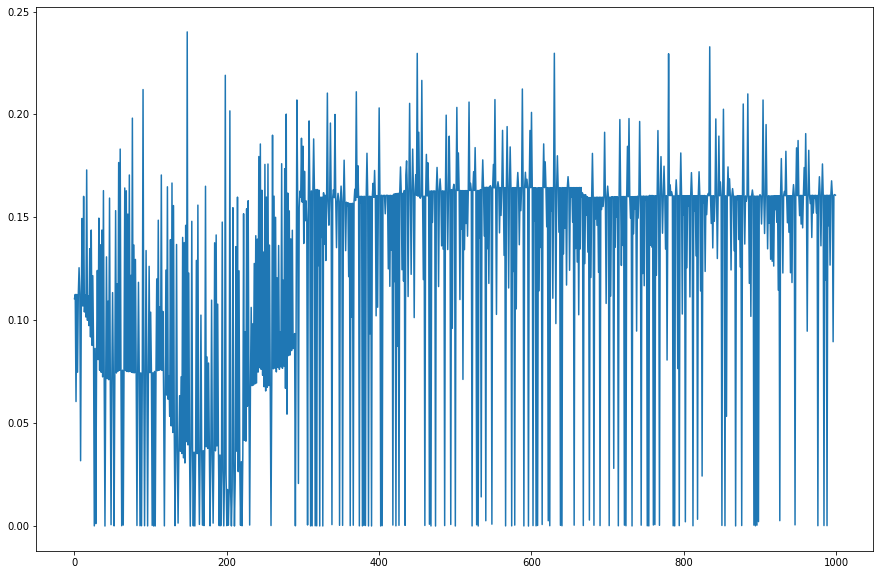

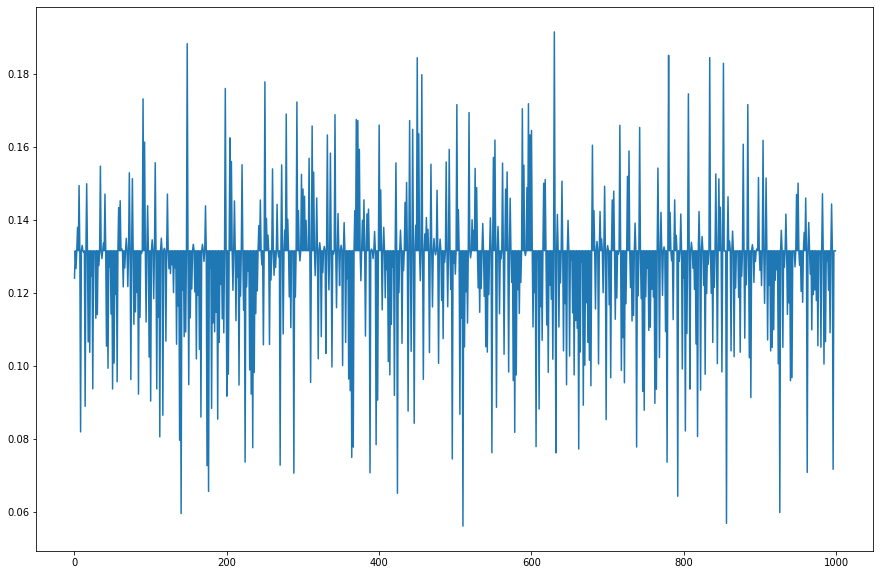

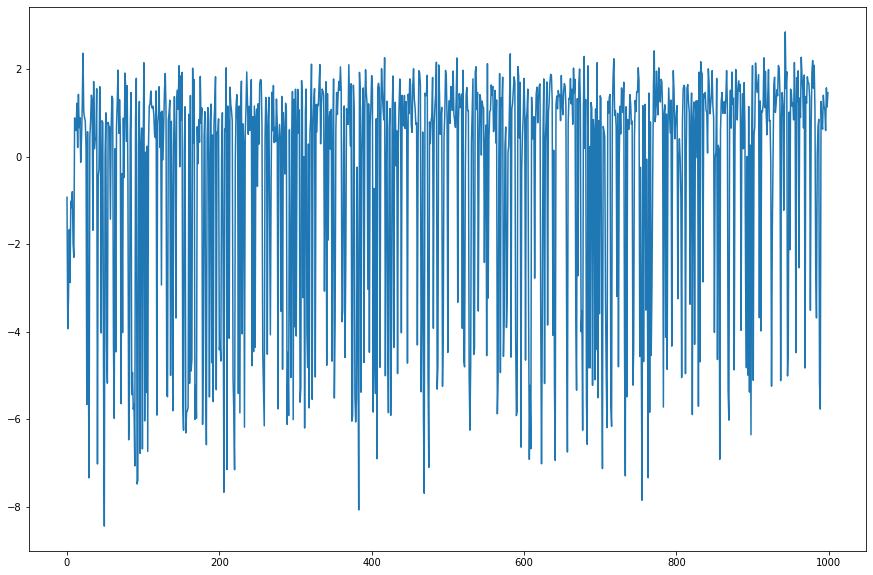

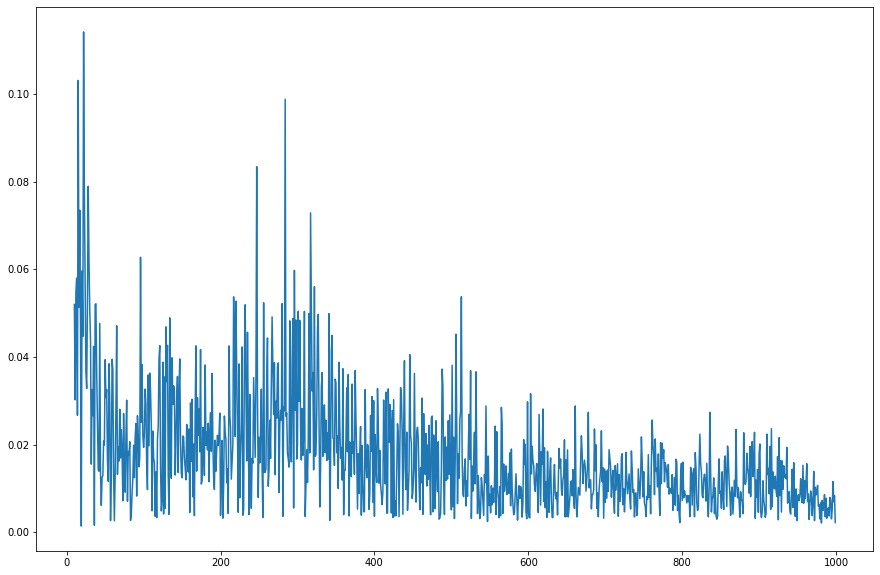

In [13]:
def preprocess_state(state):
    return np.expand_dims(state, 0)

def build_summaries():
    with tf.compat.v1.variable_scope('total_reward'):
      var = tf.Variable(0.)
      tf.summary.scalar('reward', var)
      tf.summary.histogram('histogram', var)
    return tf.summary.merge_all(scope='total_reward'), var


def restore_model(sess,saver):
    saver.restore(sess, str(restore_path)+'/model_vars.ckpt')


def save_model(sess,saver,wsee,fpa):
    saver.save(sess, str(path2)+'/model_vars_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

def train(sess, env, params, actor, critic, noise, state_dim, action_dim,action_min,action_max, saver):
    global ep_rewards, ep_wsee, equal_wsee, test_ep_rewards, test_ep_wsee, df_wsee, df_eqwsee, df_loss, df_reward, result, EPSILON, MIN_EPSILON, EPSILON_DECAY
    EPSILON = 0.6
    MIN_EPSILON = 0.0001
    EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
    result = [None, None]
    ep_rewards = [] 
    ep_wsee = []
    equal_wsee =[]
    test_ep_rewards = []
    test_ep_wsee = []
    df_wsee = pd.DataFrame(columns=['wsee'])
    df_eqwsee = pd.DataFrame(columns=['eqwsee'])
    df_reward = pd.DataFrame(columns=['reward'])
    df_loss = pd.DataFrame(columns=['loss'])
    sess.run(tf.compat.v1.initialize_all_variables())

    sess.run([actor.update_target_policy_params, critic.update_target_q_params])

    replay_buffer = ReplayBuffer(random_seed=int(params['random_seed']))

    total_steps = 0
    total_episodes = 0

    if params['restore']:
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')
        total_steps, total_episodes = sess.run([total_steps_var, total_episodes_var])

    if params['use_adaptive_parameter_noise']:
      agent = actor.perturbed_predict
    else:
      agent = actor.predict

    max_exploration_steps = params['max_exploration_steps']
    p = 1
    drop_prob = params['drop_prob']
    indicator = False
    counter = 0
    prev_wsee = 0
    for episode in tqdm(range(params['max_episodes']),ascii=True, unit="episode"):

      
      
      _distance = []
      _std_dev = []
      
      episode_reward = 0

      observation, agent_no = env.reset(episode)

      state = preprocess_state(observation)

      total_reward = 0
      _evaluate = False

      for step in range(params['max_episode_len']):

        if total_steps < max_exploration_steps:

          
          state = np.reshape(state, [1, state_dim])
          # print(f'############################################ step: {step}, state: {state} ###############################################')
          actions = agent(state, drop_prob = drop_prob)
          if not params['use_adaptive_parameter_noise']:
            actions += noise(0, 0.2, action_dim)
            p -= 1/max_exploration_steps
          
        
        else:
          print('### Training Complete ###')
          raise KeyboardInterrupt

        # action = action[0]
        action =  np.clip(actions, action_min, action_max)/action_max
        # print(f'############################################ step: {step, action_max}, action: {action} ###############################################')
        next_state, reward, terminal = env.step(action, agent_no)

        episode_reward += reward


        replay_buffer.add(
            (state, action, reward, terminal, next_state)
        )
        
        # if actor.normalize_observations:
        #   actor.obs_rms.update(state)

        current_state, agent_no = env.agent_reset()
        state = preprocess_state(current_state)
        total_reward += reward
        total_steps += 1

        if total_steps % 100 == 0:
          _evaluate = True

        if terminal:
          if _evaluate:
            test_no = 100
            # if episode > 990 or counter == 10:
            #   test_no = 800
            curr_wsee, indicator = evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee)
            prev_wsee = curr_wsee
            # if indicator:
            #   counter += 1
            # else:
            #   counter = 0
          break

      # if counter == 11:
      #   break
      for train_step in range(params['train_step']):
        if len(replay_buffer.buffer) >= params['minibatch_size']:
          
          minibatch, importance, indices = replay_buffer.sample()
          
          current_states = np.array([np.asarray(transition)[0] for transition in minibatch])
          current_states = np.reshape(current_states, [len(minibatch), state_dim])
          
          current_actions = np.array([np.asarray(transition)[1] for transition in minibatch])
          current_actions = np.reshape(current_actions, [len(minibatch), action_dim])
          # current_actions = np.clip(current_actions, action_min, action_max)/action_max

          current_qs_list = critic.predict(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)
          # current_qs_list = critic.predict(current_states, np.asarray(env.pu*current_actions), drop_prob)
          
          new_states = np.array([np.asarray(transition)[4] for transition in minibatch])
          new_states = np.reshape(new_states, [len(minibatch), state_dim])

          future_actions = actor.target_predict(new_states, drop_prob)
          future_actions = np.clip(future_actions, action_min, action_max)/action_max

          future_qs_list = critic.target_predict(new_states, np.asarray(-np.log10(env.pu*future_actions)), drop_prob)
          # future_qs_list = critic.target_predict(new_states, np.asarray(env.pu*future_actions), drop_prob)
          
          y = []
          errors = []
          for index, (current_state, action, reward, terminal, next_state) in enumerate(minibatch):
              if not terminal:
                future_q = future_qs_list[index]
                new_q = reward + critic.gamma*future_q
                new_action = future_actions[index]
              else:
                new_q = reward
                new_action = action
              current_q = current_qs_list[index]
              errors.append(new_q-current_q)
              y.append(new_q)
          
          y = np.reshape(y, [1, len(minibatch)])
          importance = np.reshape(importance, [1, len(minibatch)])
          result = critic.train(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob, y, importance)
          
          actor.train(current_states, drop_prob,
                      critic.compute_grads(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)[0])
          
          sess.run(actor.update_target_policy_params)
          sess.run(critic.update_target_q_params)

          # errors = y - critic.predict(state_batch,
          #                             actor.predict(state_batch, drop_prob),
          #                             drop_prob)

          if params['use_adaptive_parameter_noise'] and train_step % 20 == 0:
              distance, std_dev = actor.add_param_noise(current_states)
              _distance.append(distance)
              _std_dev.append(std_dev)

          replay_buffer.set_priorities(indices, errors)
      total_episodes += 1
      # distance, std_dev = actor.add_param_noise(current_states)
      # _distance.append(distance)
      # _std_dev.append(std_dev)

      sess.run([total_steps_var.assign(total_steps), total_episodes_var.assign(episode)])
      loss = result[0]
      ep_rewards.append(episode_reward)
      equal_wsee.append(env.cal_equal_p_WSEE(0))
      ep_wsee.append(env.cal_total_WSEE(0))

      if params['use_adaptive_parameter_noise']:
            print(
                f'Loss: {loss}|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} || Distance: {np.array(_distance).mean():.4f} ||')
      else:
          print(
              f'|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} ||')
          

      if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_wsee = sum(ep_wsee[-AGGREGATE_STATS_EVERY:])/len(ep_wsee[-AGGREGATE_STATS_EVERY:])
        average_equal_wsee = sum(equal_wsee[-AGGREGATE_STATS_EVERY:])/len(equal_wsee[-AGGREGATE_STATS_EVERY:])
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        #agent.tensorboard.update_stats(avg_equal_p_wsee = average_equal_wsee, reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon, avg_wsee = average_wsee) 
        # cma_reward = (cma_reward + (average_reward-cma_reward)/(episode+1))
        # print(cma_reward)
        df_wsee = df_wsee.append({'wsee': average_wsee}, ignore_index=True)
        df_eqwsee = df_eqwsee.append({'eqwsee': average_equal_wsee}, ignore_index=True)
        df_reward = df_reward.append({'reward': average_reward}, ignore_index=True)
        df_loss = df_loss.append({'loss': loss}, ignore_index=True)
        print(f'wsee: {average_wsee}, eqwsee: {average_equal_wsee}, reward: {average_reward}')
        # agent.tensorboard.update_stats2(rval, train, episode, "loss")
        # agent.tensorboard.update_stats2(average_wsee, train, episode, "wsee")
        # agent.tensorboard.update_stats2(average_equal_wsee, train, episode, "eq_wsee")
        # agent.tensorboard.update_stats2(average_reward, train, episode, "reward")
        # Save model, but only when min reward is greater or equal a set value
        # if min_reward >= MIN_REWARD and episode%5==0:
        # #     #agent.model.save(f'./models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.h5')
        #   actor.actions.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_actor_2.h5')
        #   critic.q_value.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_critic_2.h5')
        if EPSILON > MIN_EPSILON:
          EPSILON *= EPSILON_DECAY
          EPSILON = max(MIN_EPSILON, EPSILON)
      

global eval_wsee, eval_fpa, eval_reward

eval_reward = []
eval_wsee = []
eval_fpa = []

def evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee):

    if params['restore'] and not params['train']:
        sess.run(tf.compat.v1.global_variables_initializer())
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')

    total_steps = sess.run(total_steps_var)
    err = 0.01
    _reward = []
    _test_wsee = []
    _test_fpa_wsee = []
    flag = 0
    start = 1100
    end = start+test_no
    for episode in range(start,end):
        env.reset_test(episode)
        total_reward = 0
        
        for a in range(env.K):
            agent_no = a
            observation = env.initialize_state_test(a)
            state = preprocess_state(observation)
            state = np.reshape(state, [1, state_dim])
            actions = actor.predict(state, drop_prob=0.)
            actions = np.clip(actions, action_min, action_max)/action_max
            action = actions[0]

            _, reward, _ = env.step(action, a)
            
            total_reward += reward
        if total_reward >= 0:
          flag += 1
        _reward.append(total_reward)
        _test_wsee.append(env.cal_total_WSEE(0))
        _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
        if episode % 20 ==0:
          print(f'|| Test Run No: {episode} || WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || Reward: {total_reward:.2f} ||')
    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    eval_wsee.append(wsee)
    eval_fpa.append(fpa)
    eval_reward.append(np.sum(_reward)/len(_reward))
    print(f'wsee:{wsee}, fpa_wsee: {fpa}')
    if flag > 0.95*test_no:
        # save_model(sess,saver,wsee, fpa)
        # actor.save_model(wsee, fpa)
        # critic.save_model(wsee, fpa)
        print('Model could have been saved!')
    # total_reward = np.max(np.array(_reward))
    # summary = sess.run(merge_op, feed_dict={total_reward_var: total_reward})
    # writer.add_summary(summary, total_steps)
        if abs(prev_wsee - wsee) < err: 
          return wsee, True
        else:
          return wsee, False
    else:
      return wsee, False


def main(args, power, nrx):
    params = vars(args)
    tf.compat.v1.set_random_seed(int(params['random_seed']))
    np.random.seed(int(params['random_seed']))
    if params['train']:
      gainspath = 'testNrx/channel_K10_AP32_2k_fresh.h5'
    if params['restore']:
      gainspath = '25thJulyTestGains/channel_K10_AP32_2k.h5'

    with tf.compat.v1.Session() as sess:
        try:
            env = wirelessEnv(power, nrx, gainspath, int(params['random_seed'])) 
            # env = gym.make(args['env'])
            state_dim = env.s_dim
            action_dim = env.a_dim
            action_min = 0.000001
            action_max = power

            # assert (env.action_space.high == -env.action_space.low).all()
            # action_bound = env.action_space.high[0]

            global total_steps_var, total_episodes_var
            total_episodes_var = tf.Variable(0)
            total_steps_var = tf.Variable(0)

            # if args['use_gym_monitor']:
            #     if not args['render_env']:
            #         env = wrappers.Monitor(
            #             env, args['monitor_dir'], video_callable=False, force=True)
            #     else:
            #         env = wrappers.Monitor(env, args['monitor_dir'], force=True)

            actor = Actor(sess, state_dim, action_dim, 
                          use_param_noise=params['use_adaptive_parameter_noise'], 
                          tau=params['tau'], gamma=params['gamma'], 
                          delta=params['delta'], normalize_observations=params['normalize_obs'])
            
            critic = Critic(sess, state_dim, action_dim, tau=params['tau'], gamma=params['gamma'],
                            learning_rate=params['critic_lr'], 
                            normalize_observations=params['normalize_obs'])

            ## Noise
            noise = np.random.normal

            saver = tf.compat.v1.train.Saver()
            # writer = tf.summary.FileWriter(args['summary_dir'] + '/' + args['env'] + '/' + str(datetime.now()))

            if params['train']:
                train(sess,env,params,actor,critic,noise,state_dim,action_dim,action_min,action_max, saver)
            # evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver)
            # save_model(sess,saver)
            # actor.save_model()
            # critic.save_model()
            # print('Model saved!')

        except KeyboardInterrupt:
            if params['save']:
              # save_model(sess,saver)
              # actor.save_model()
              # critic.save_model()
              print('Model saved!')


    test_wsee = np.sum(test_ep_wsee)/len(test_ep_wsee)
    wsee = np.sum(ep_wsee)/len(ep_wsee)
    print(f'wsee:{wsee}, test_wsee: {test_wsee}, agent.env.pi: {env.pi[1]}')

    plt.figure(figsize=(15,10))
    # df_wsee.reset_index().plot(kind='line',x='index', y='wsee')
    plt.plot(df_wsee['wsee'])
    # plt.show()
    plt.savefig(dest/r'wsee.jpg', dpi=300)
    # df_eqwsee.reset_index().plot(kind='line',x='index', y='eqwsee')
    plt.figure(figsize=(15,10))
    plt.plot(df_eqwsee['eqwsee'])
    # nrxmean = df_eqwsee['eqwsee'].mean(axis=0)
    # print(nrxmean, nrx)
    # nrx_val.append(nrxmean*env.B)
    # plt.show()
    plt.savefig(dest/r'eqwsee.jpg', dpi=300)
    # df_reward.reset_index().plot(kind='line',x='index', y='reward')
    plt.figure(figsize=(15,10))
    plt.plot(df_reward['reward'])
    # plt.show()
    plt.savefig(dest/r'reward.jpg', dpi=300)
    # df_loss.reset_index().plot(kind='line',x='index', y='loss')
    plt.figure(figsize=(15,10))
    plt.plot(df_loss['loss'])
    # plt.show()
    plt.savefig(dest/r'loss.jpg', dpi=300)

    df_wsee.to_csv(dest/r'wsee29thJan.csv')
    df_eqwsee.to_csv(dest/r'eqwsee29thJan.csv')
    df_reward.to_csv(dest/r'reward29thJan.csv')
    df_loss.to_csv(dest/r'loss29thJan.csv')


def test(args, power, nrx):
    # tf.set_random_seed(int(args['random_seed']))
    # np.random.seed(int(args['random_seed']))
    params = vars(args)
    gainspath2 = '25thJulyTestGains/channel_K10_AP32_2k.h5'
    with tf.compat.v1.Session() as sess:
    
        env = wirelessEnv(power, nrx, gainspath2) 
        # env = gym.make(args['env'])
        # env.seed(int(args['random_seed']))
        state_dim = env.s_dim
        action_dim = env.a_dim
        action_min = 0.000001
        action_max = power

        global total_steps_var, total_episodes_var
        total_episodes_var = tf.Variable(0)
        total_steps_var = tf.Variable(0)

        saver_actor = tf.compat.v1.train.import_meta_graph(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor/model_actor.ckpt.meta')
        saver_actor.restore(sess, tf.train.latest_checkpoint(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor'))
        sess.run(tf.compat.v1.global_variables_initializer())
        graph = tf.compat.v1.get_default_graph()
        state_ph = graph.get_tensor_by_name("state_ph:0")
        drop_prob = graph.get_tensor_by_name("drop_prob:0")
        predict_operation = graph.get_tensor_by_name("actions:0")
        
        total_steps = sess.run(total_steps_var)
        _reward = []
        _test_wsee = []
        _test_fpa_wsee = []

        for episode in range(2000):
            env.reset_test(episode)
            total_reward = 0
            
            for a in range(env.K):
                agent_no = a
                observation = env.initialize_state_test(a)
                state = preprocess_state(observation)
                state = np.reshape(state, [1, state_dim])
                actions = sess.run(predict_operation, feed_dict = {state_ph: state, drop_prob: 0.0})
                actions = np.clip(actions, action_min, action_max)/action_max
                action = actions[0]

                _, reward, _ = env.step(action, a)
                
                total_reward += reward

            _reward.append(total_reward)
            _test_wsee.append(env.cal_total_WSEE(0))
            _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
            print(f'|| WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || agent.env.pi: {env.pi[1]} || Reward: {total_reward:.2f} ||')



    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    print(f'wsee:{wsee}, fpa_wsee: {test_wsee}')



parser = argparse.ArgumentParser(description='provide arguments for DDPG agent')

# agent parameters
parser.add_argument('--actor-lr', help='actor network learning rate', default=0.005)
parser.add_argument('--critic-lr', help='critic network learning rate', default=0.05)
parser.add_argument('--gamma', help='discount factor for critic updates', default=1-10e-10)
parser.add_argument('--tau', help='soft target update parameter', default=0.01)
parser.add_argument('--use-adaptive-parameter-noise', help='', default=True)
parser.add_argument('--delta', help='desired action deviation', default=.2)
parser.add_argument('--l2_reg', help='Q loss regularization strength', default=.0)
parser.add_argument('--drop-prob', help='drop out probability', default=.4)
parser.add_argument('--buffer-size', help='max size of the replay buffer', default=10000)
parser.add_argument('--minibatch-size', help='size of minibatch for minibatch-SGD', default=512)
parser.add_argument('--normalize-obs', help='normalizes observations', default=True)

# run parameters
parser.add_argument('--train', help='train the model', default=True)
parser.add_argument('--train_step', help='number of training steps', default=50)
parser.add_argument('--max-exploration-steps', help='', default=1e6)
# parser.add_argument('--env', help='choose the gym env', default='HalfCheetah-v2')
parser.add_argument('--save', help='save trained model', default=True)
parser.add_argument('--restore', help='restore prev trained model', default=False)
parser.add_argument('--random-seed', help='random seed for repeatability', default=1337)
parser.add_argument('--max-episodes', help='max num of episodes to do while training', default=1000)
parser.add_argument('--max-episode-len', help='max length of 1 episode', default=20000)
# parser.add_argument('--render-env', help='render the gym env', action='store_true')
# parser.add_argument('--use-gym-monitor', help='record gym results', action='store_true')
# parser.add_argument('--monitor-dir', help='directory for storing gym results', default='./results/gym_ddpg')
parser.add_argument('--summary-dir', help='directory for storing tensorboard info', default='./results/tf_ddpg')

parser.set_defaults()
# parser.set_defaults(use_gym_monitor=False)

args, _ = parser.parse_known_args()

# with open('./random_seeds_used', 'a+') as f:
#     f.write(f"Time: {str(datetime.now())}, random seed: {args['random_seed']}\n")


pp.pprint(args)
# merge_op, total_reward_var = build_summaries()
power = 30
nrx = 2
main(args, np.power(10,power/10 - 3), nrx)


In [14]:
episode = [int(i*100) for i in range(1,len(eval_wsee)+1)]
# episode = episode*500

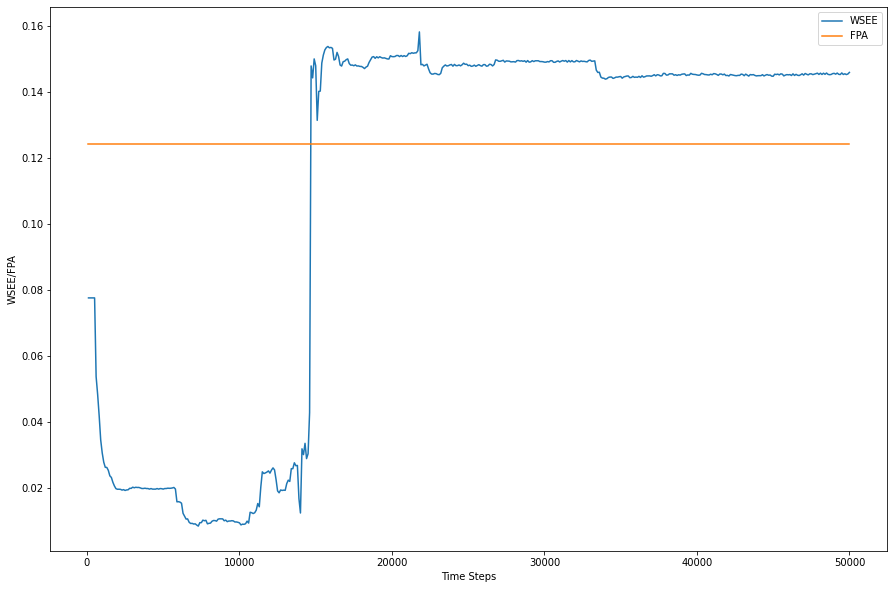

In [15]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_wsee, label='WSEE')
plt.plot(episode, eval_fpa, label='FPA')
plt.xlabel('Time Steps')
plt.ylabel('WSEE/FPA')
plt.legend()
plt.savefig(dest/r'training.jpg', dpi=300)

Text(0, 0.5, 'Reward')

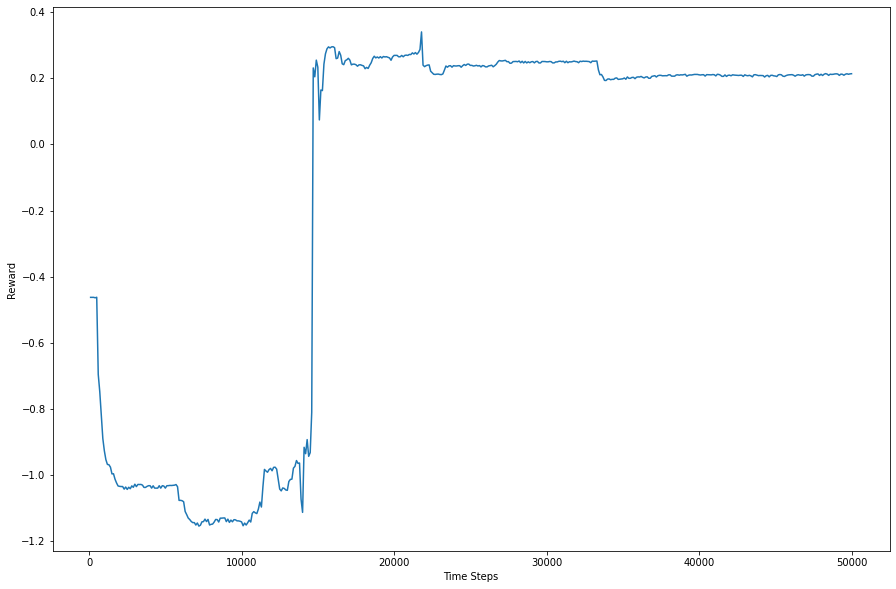

In [16]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_reward)
plt.xlabel('Time Steps')
plt.ylabel('Reward')
